## Purpose of the notebook: Reproduce the paper figures and instructions for applying the code to custom data.

### 0.1 Imports

Uncomment the following two cells if you're using in Colab. If not, download the data.

In [4]:
#import os
#if not os.path.isdir('learnable-handwriter'):
#    !git clone --quiet https://github.com/malamatenia/learnable-handwriter.git
#%cd /content/learnable-handwriter
#!pip install -r requirements.txt --quiet
#!pip install wandb --quiet

/content/learnable-handwriter
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.0 MB/s eta 0:00:00


In [5]:
#!rm -rf runs/ datasets/
#!wget 'https://www.dropbox.com/scl/fi/sxvejr12pg3b0bq4f1sj0/demo.zip?rlkey=24m4dggyvpfa558u5bmq7xew9&st=0slmvjqi&dl=0' -O demo.zip &> /dev/null
#!unzip -q demo.zip -d . &> /dev/null
#!rm demo.zip

In [6]:
import numpy as np
import pandas as pd
import os
import json
from pathlib import Path
import rootutils
import sys

import PIL

import matplotlib
import matplotlib.pyplot as plt

In [7]:
# Finds root based on a dummy marker file you added manually
root_path = Path(str(rootutils.find_root(search_from=os.getcwd())))

sys.path.append(str(root_path / 'scripts' / 'reproduce_results'))
print(f"Root path: {root_path}")

from utils import (
    folder_to_grid,
    visualize_comparison,
    calculate_metric_for_directory,
    merge_dataframes,
    selected_protos_directory,
    filter_prototypes,
    flag_prototypes,
    plot_document_graphs,
    plot_letter_graphs
)

Root path: /content/learnable-handwriter


In [8]:
prototypes_dir = root_path / "scripts" / "reproduce_results" / "prototypes"
grids_output_dir = root_path / "scripts" / "reproduce_results" / "grids"
output_comp = root_path / "scripts" / "reproduce_results" / "comp_prototypes"

finetune_dir = root_path / "runs" / "iwcp_south_north" / "finetune"
selected_protos_dir = prototypes_dir / "selected"
filtered_dir = prototypes_dir / "filtered"
flagged_dir = prototypes_dir / "flagged"
baseline_folder = selected_protos_dir / "baseline"

In [9]:
# Create a mapping dictionary to map the documents to their class and reference code in the article
codename_to_id = {
    'NT1': 'btv1b8447298r',
    'NT2': 'btv1b525068331',
    'NT3': 'Arras-861',
    'NT4': 'btv1b84473026',
    'NT5': 'btv1b8455783p',
    'NT6': 'btv1b55006072j',
    'NT7': 'SBB-PK-Hdschr25',
    'ST1': 'btv1b90615126',
    'ST2': 'btv1b100361755',
    'ST3': 'btv1b8433319z',
    'ST4': 'IB15304245v',
    'ST5': 'btv1b90590259',
    'ST6': 'btv1b8446940n',
    'ST7': 'IB15304274v'
}


### 1.0  From the finetuned output, choose only the range of characters that we want to include in our analysis

In [11]:
character_range = list(range(28, 37)) + list(range(39, 49)) #this range corresponds to the characters from a-u excluding j/k

In [10]:
selected_protos_directory(finetune_dir, selected_protos_dir)

### 1.1 Visualise the selected prototypes

Created directory: /content/learnable-handwriter/scripts/reproduce_results/grids
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/selected/baseline
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/selected/Northern_Textualis
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/selected/btv1b8447298r
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/selected/btv1b525068331
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/selected/Arras-861
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/selected/btv1b84473026
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/selected/btv1b8455783p
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/selected/btv1b55006072j
Processing folder: /content/learnable-handwriter/

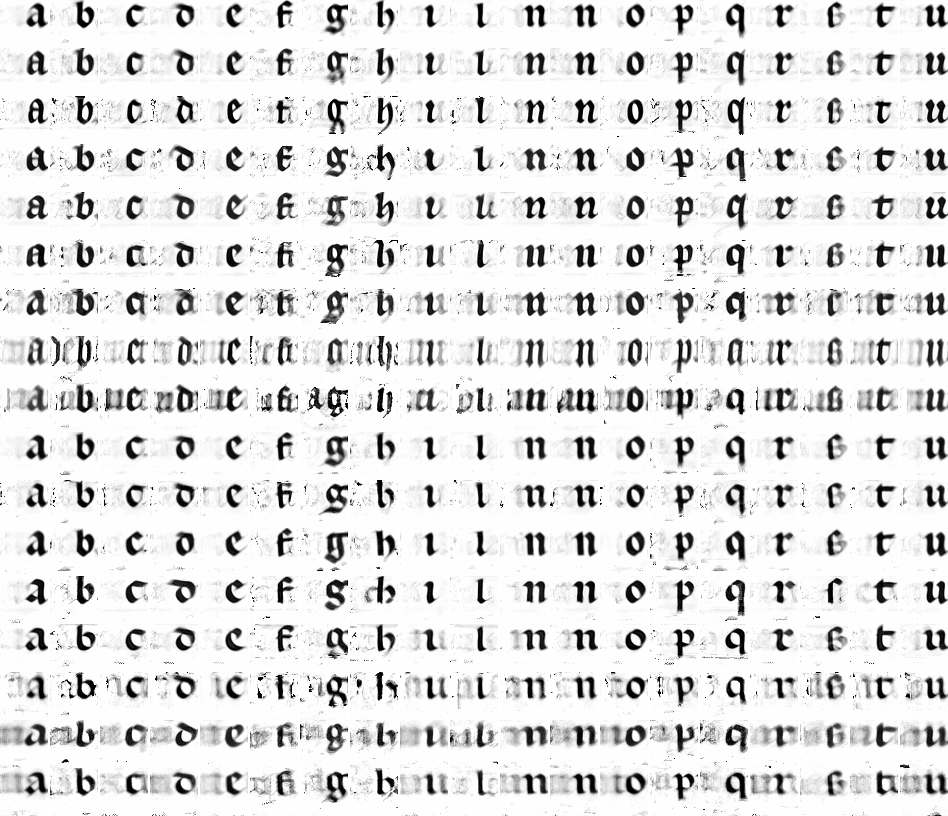

Image saved at: /content/learnable-handwriter/scripts/reproduce_results/grids/selected_prototypes.jpeg


In [12]:
#Adjust as per preference if used on custom dataset
folder_order = ['baseline', "Northern_Textualis", "btv1b8447298r", "btv1b525068331", "Arras-861", "btv1b84473026",
                "btv1b8455783p", "btv1b55006072j", "SBB-PK-Hdschr25", 'Southern_Textualis', "btv1b90615126", "btv1b100361755", "btv1b8433319z",
               "IB15304245v", "btv1b90590259", "btv1b8446940n", "IB15304274v"]

output_path = grids_output_dir / "selected_prototypes.jpeg"

grids_output_dir.mkdir(parents=True, exist_ok=True)
print(f"Created directory: {grids_output_dir}")

sample_image_path = selected_protos_dir / folder_order[0] / f"{character_range[0]}.png"
sample_image = PIL.Image.open(sample_image_path)
image_width, image_height = sample_image.size

margin = 2
denoised_prototypes_borders = folder_to_grid(
    str(selected_protos_dir),
    folder_order,
    character_range,
    image_width,
    image_height,
    margin=margin
)

denoised_prototypes_borders.save(output_path)
print("Image saved at:", output_path)

### 1.2 Filtering out the prototypes from artefacts (cf. Section 3.1 in the paper).

In [13]:
filter_prototypes(
    input_dir=selected_protos_dir,
    output_dir=filtered_dir,
    baseline_dir=baseline_folder,
    threshold=0.65
)

Prototype filtering complete.


### 1.3 Perform automatic failure case identification for our filtered sprites (cf. Section 3.1 of the article).

In [14]:
flag_prototypes(
    input_parent=selected_protos_dir,
    output_parent=flagged_dir,
    baseline_folder=baseline_folder,
    default_threshold=0.8 * 255,
    sup_threshold=0.65 * 255,
    show_plots=False  # or False if you don't want to see plots
)

Filtering and flagging complete.


### 1.4 Visualise the denoised prototypes with failure identification borders

Created directory: /content/learnable-handwriter/scripts/reproduce_results/grids
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/flagged/baseline
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/flagged/Northern_Textualis
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/flagged/btv1b8447298r
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/flagged/btv1b525068331
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/flagged/Arras-861
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/flagged/btv1b84473026
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/flagged/btv1b8455783p
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/flagged/btv1b55006072j
Processing folder: /content/learnable-handwriter/scripts/

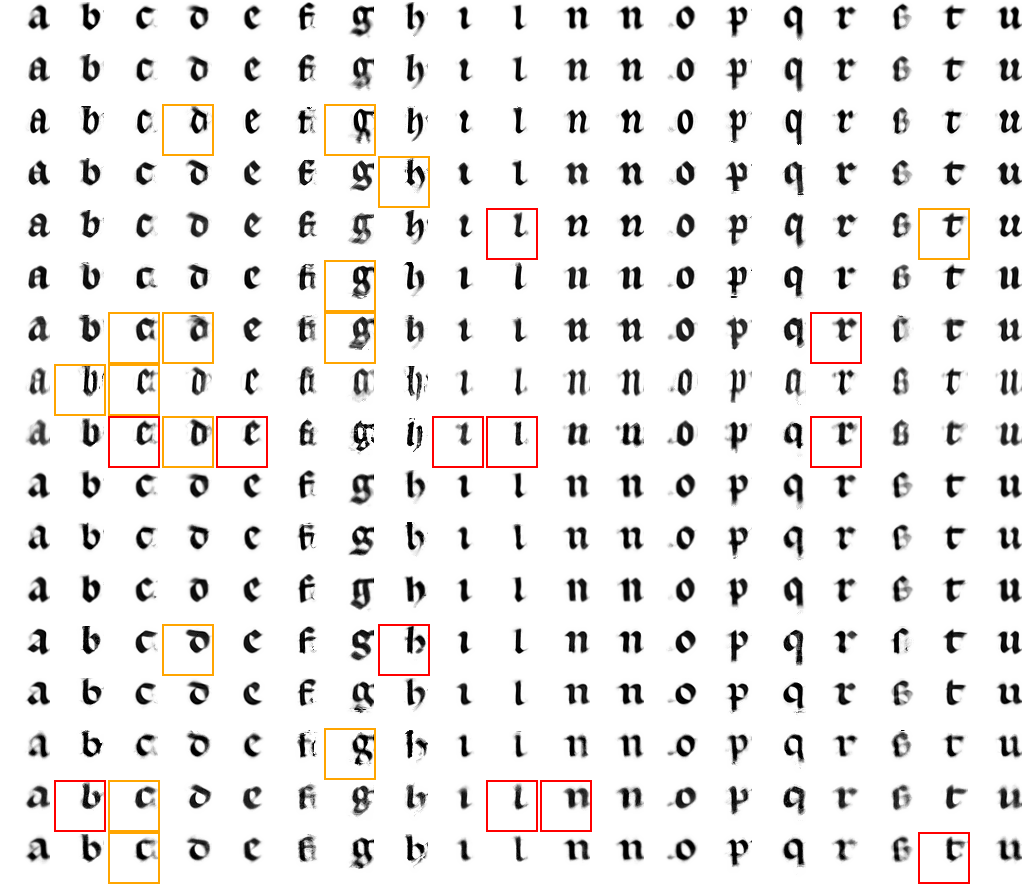

Image saved at: /content/learnable-handwriter/scripts/reproduce_results/grids/prototypes_failure_cases.jpeg


In [15]:
denoised_prototype_folders = flagged_dir
output_folder = grids_output_dir
output_path = os.path.join(output_folder, "prototypes_failure_cases.jpeg")

os.makedirs(output_folder, exist_ok=True)
print(f"Created directory: {output_folder}")

sample_image_path = os.path.join(denoised_prototype_folders, folder_order[0], f"{character_range[0]}.png")
sample_image = PIL.Image.open(sample_image_path)

image_width, image_height = sample_image.size

margin = 2

denoised_prototypes_borders = folder_to_grid(denoised_prototype_folders, folder_order, character_range, image_width, image_height, margin=margin)

denoised_prototypes_borders.save(output_path)
print("Image saved at:", output_path)

## 2.0 Visual comparison of the prototypes

### 2.1 Compare each document to the baseline and save the results

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/baseline


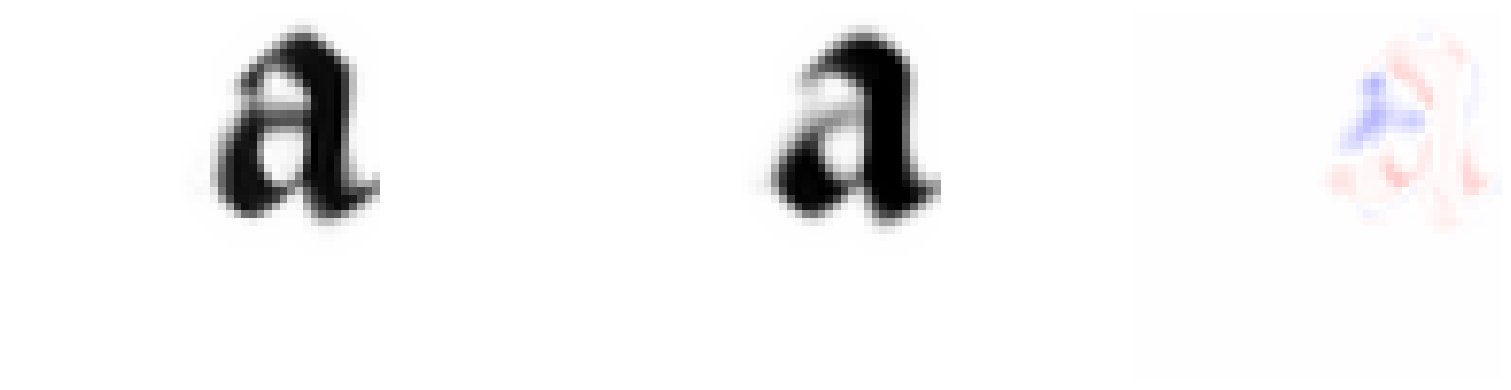

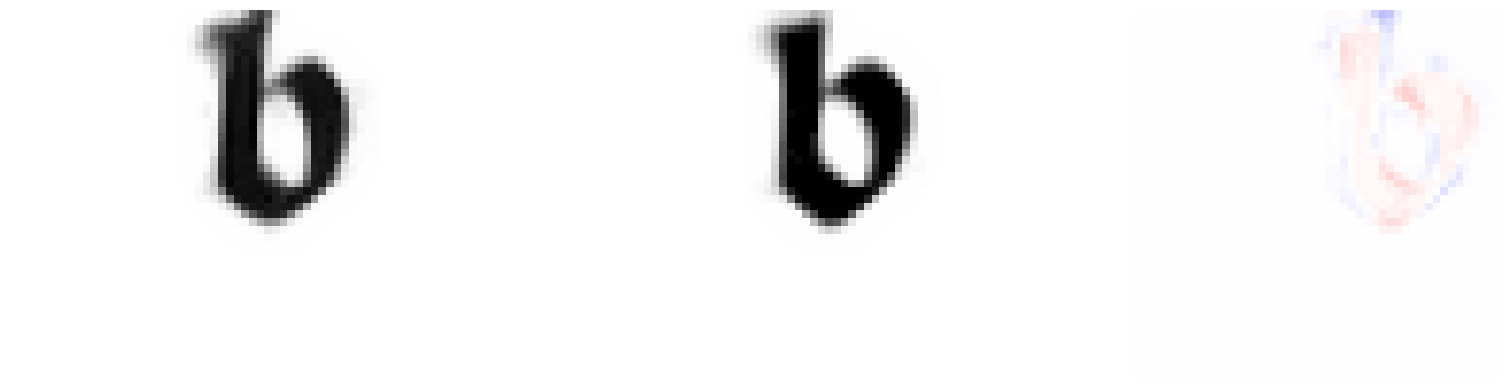

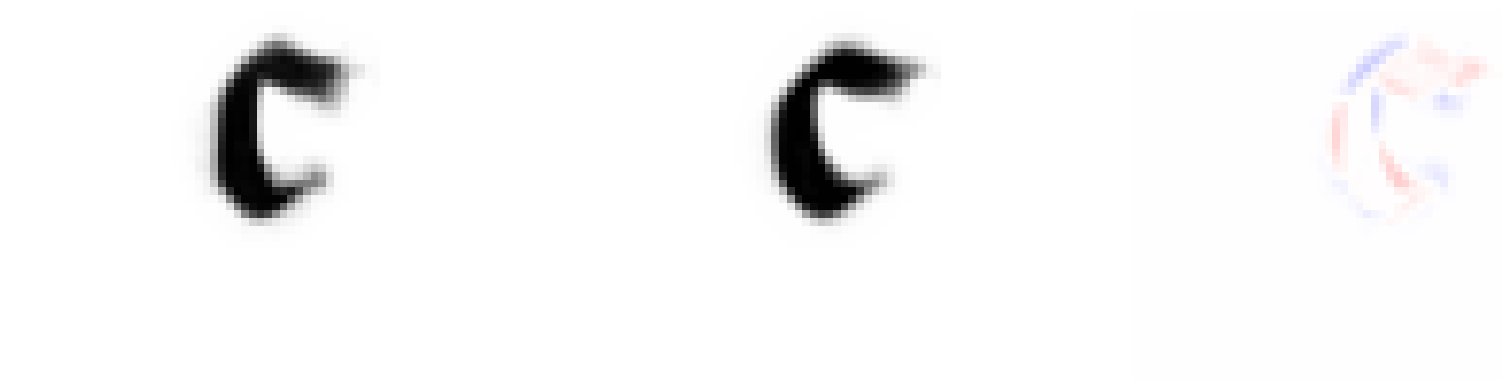

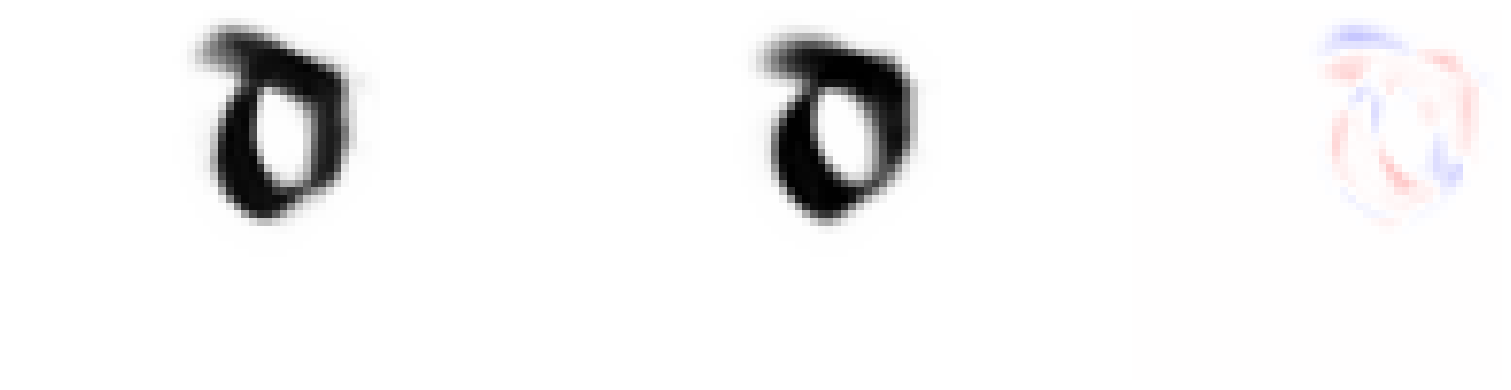

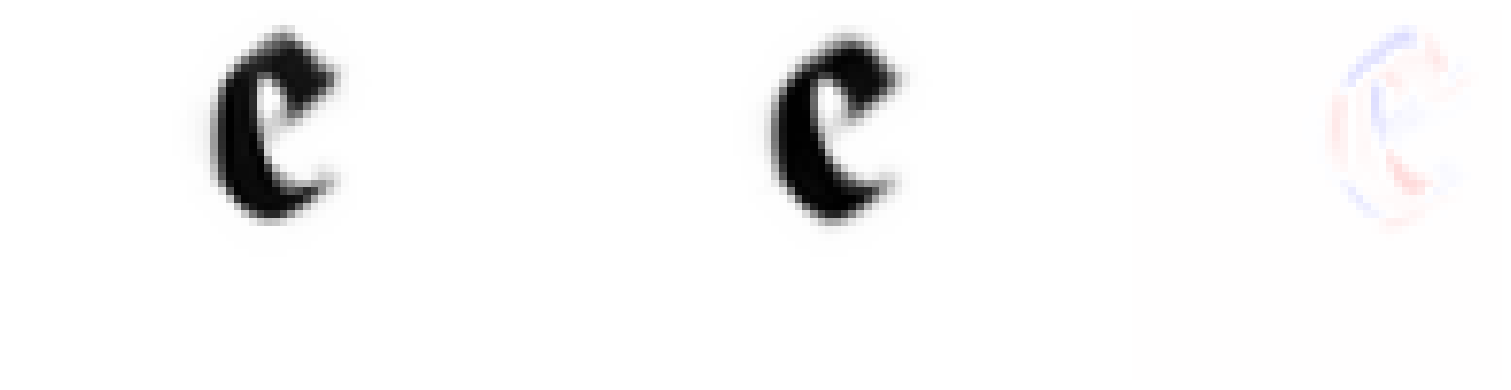

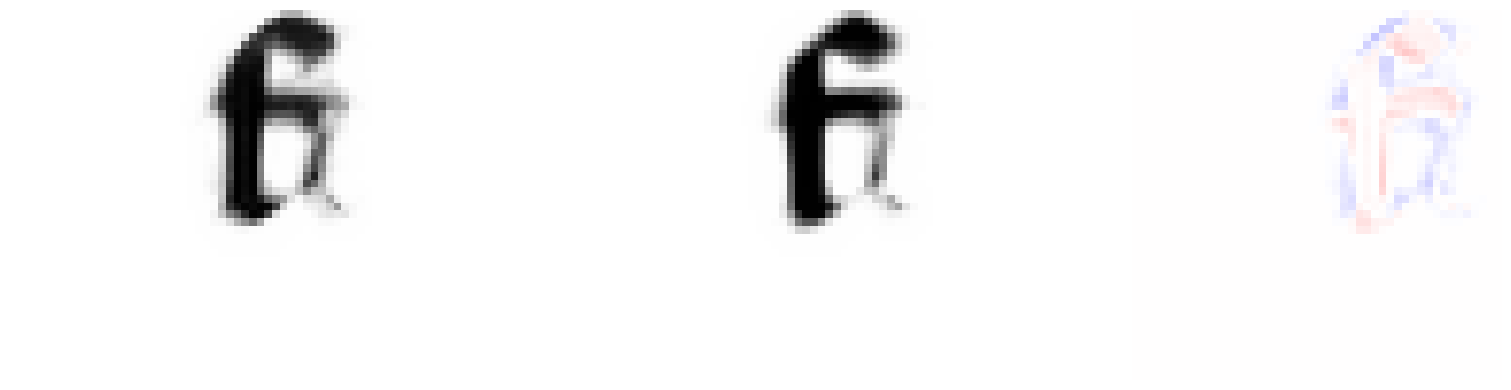

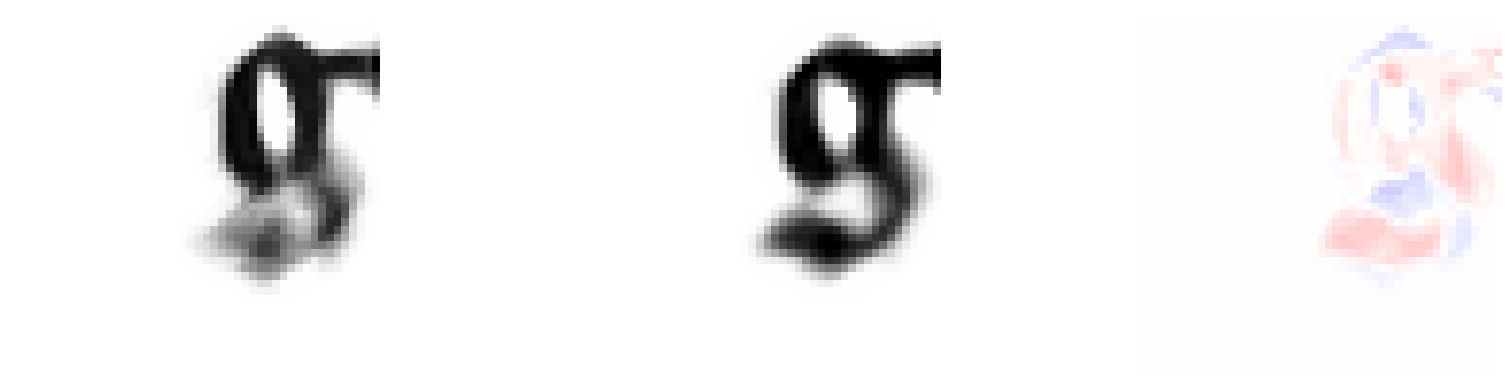

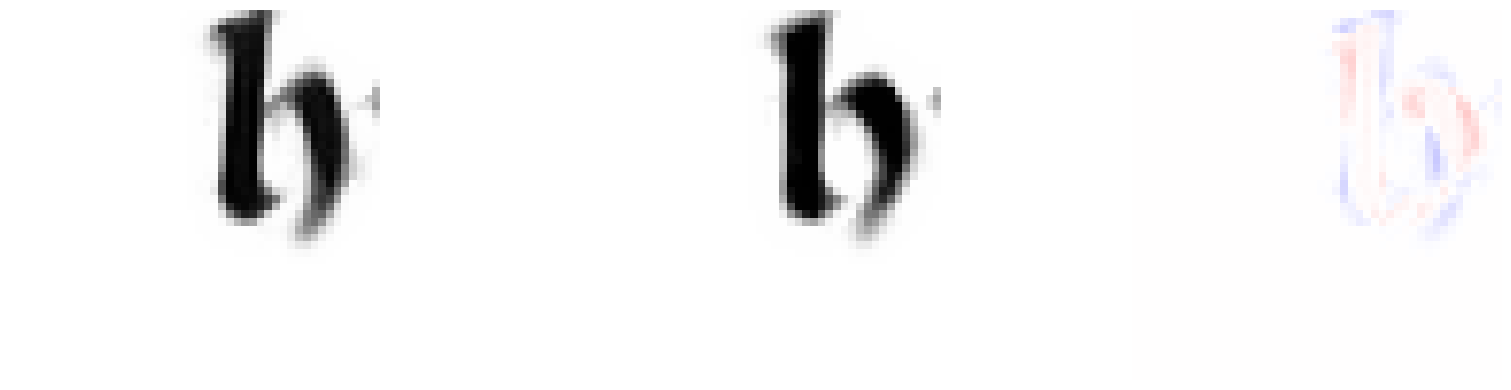

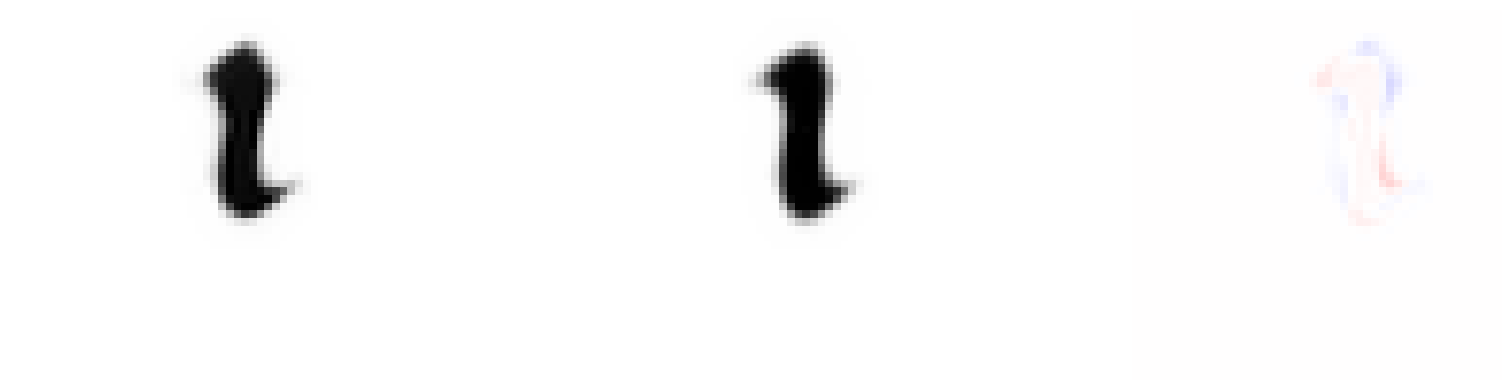

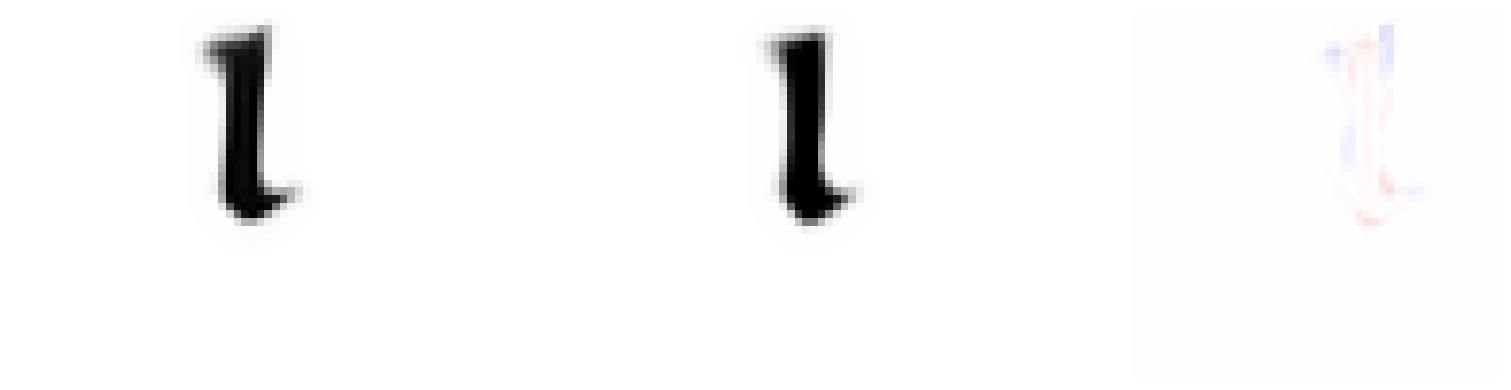

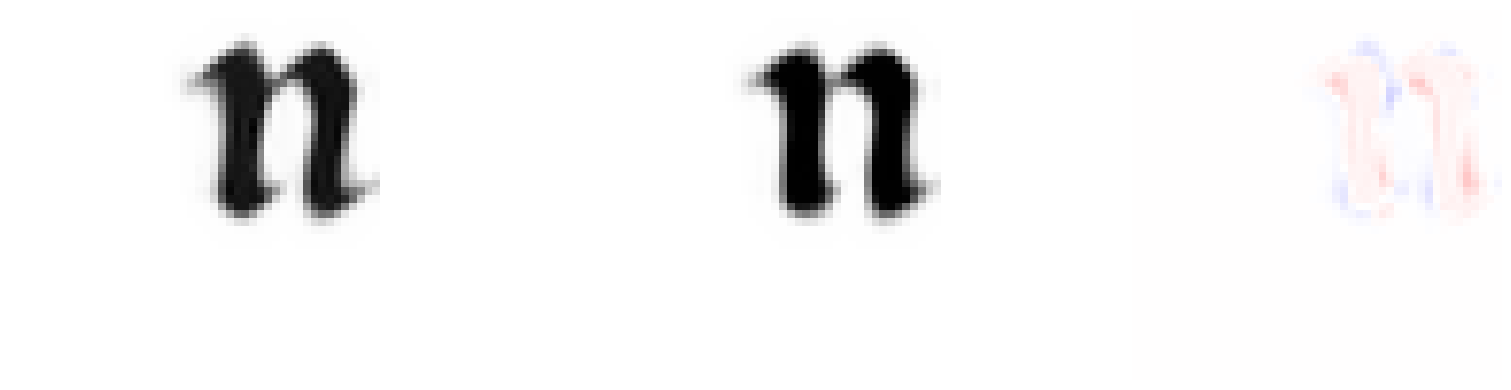

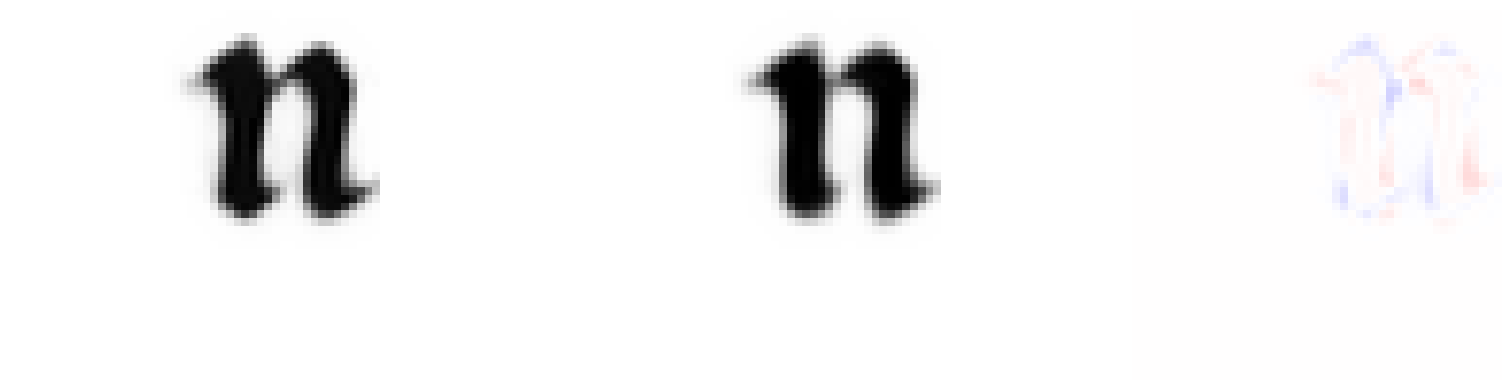

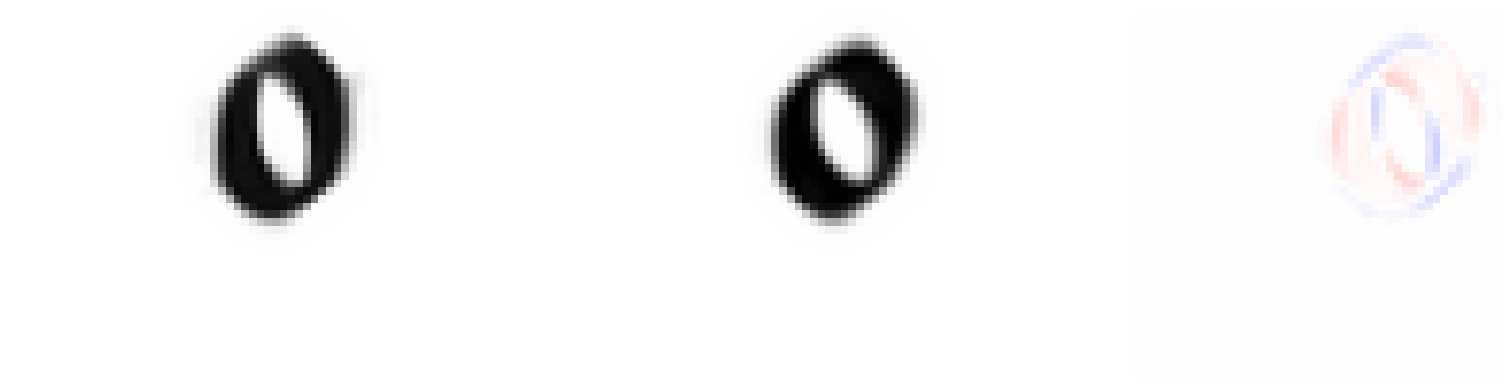

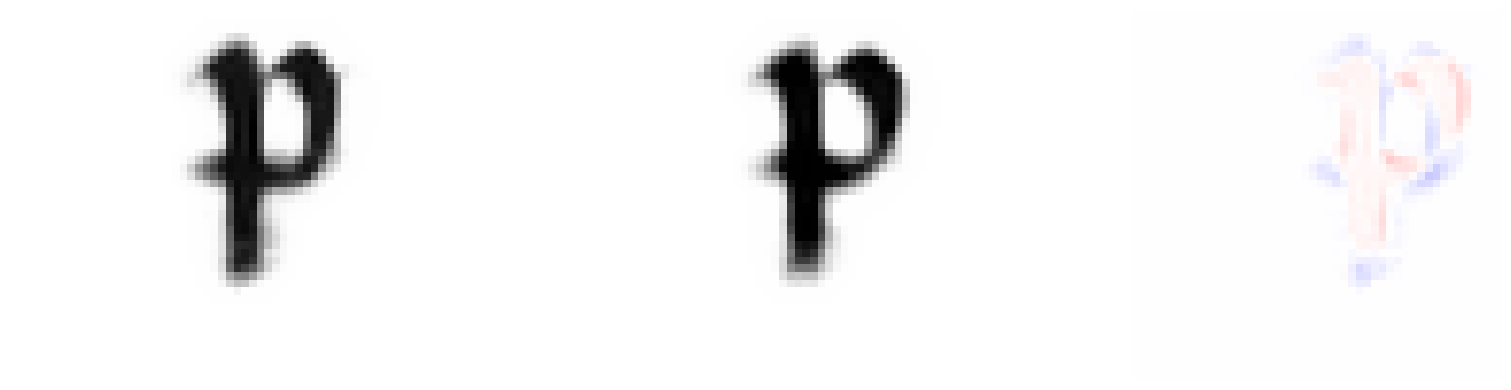

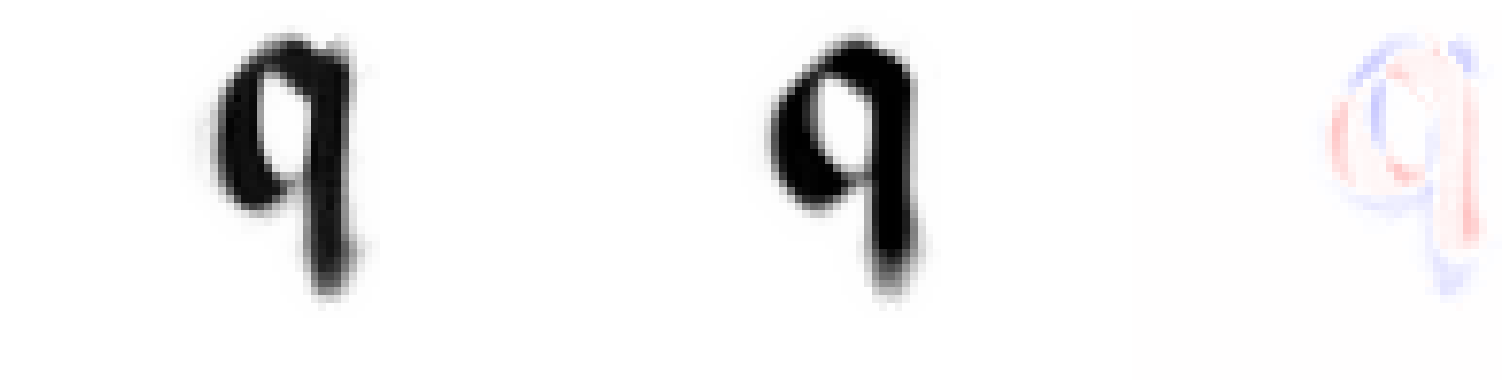

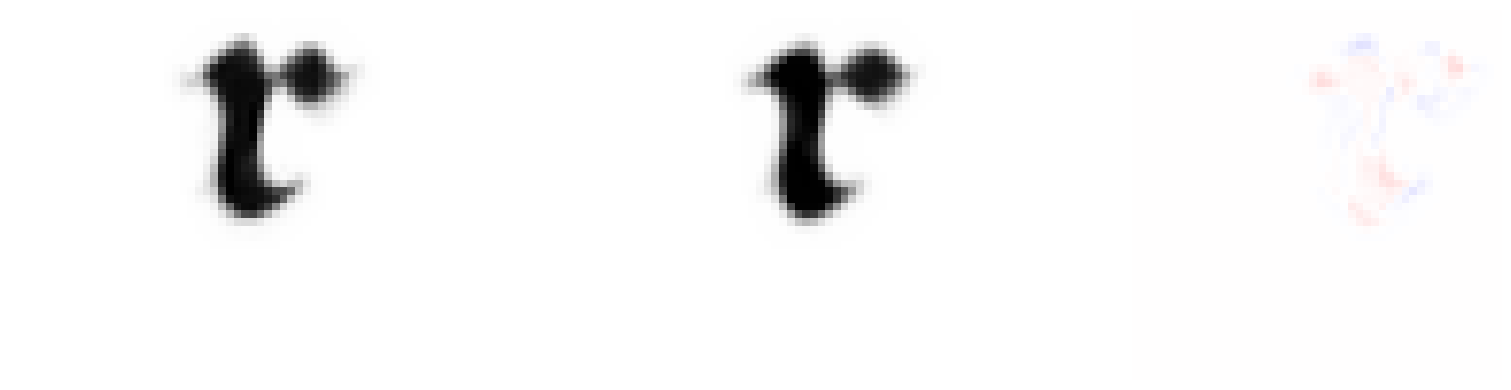

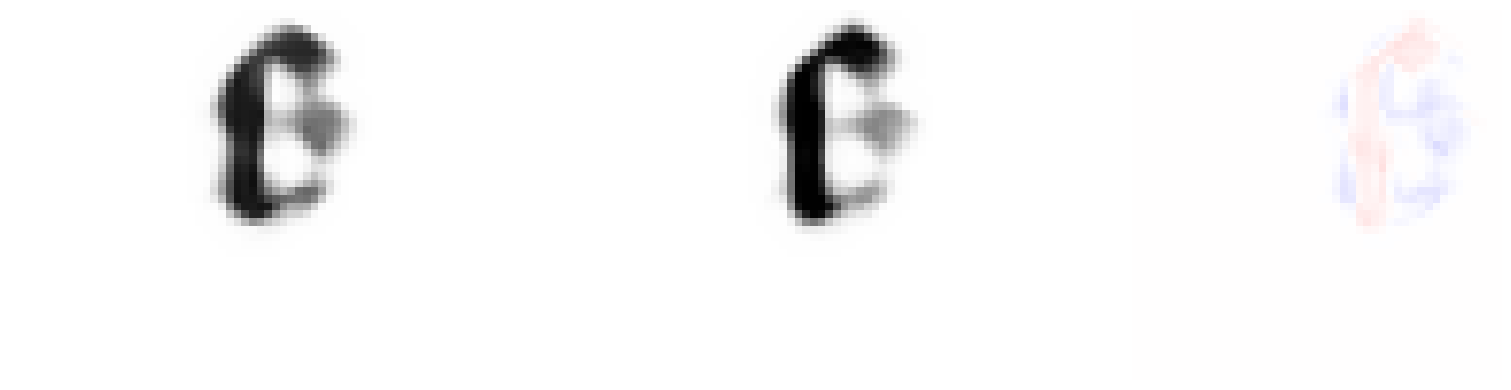

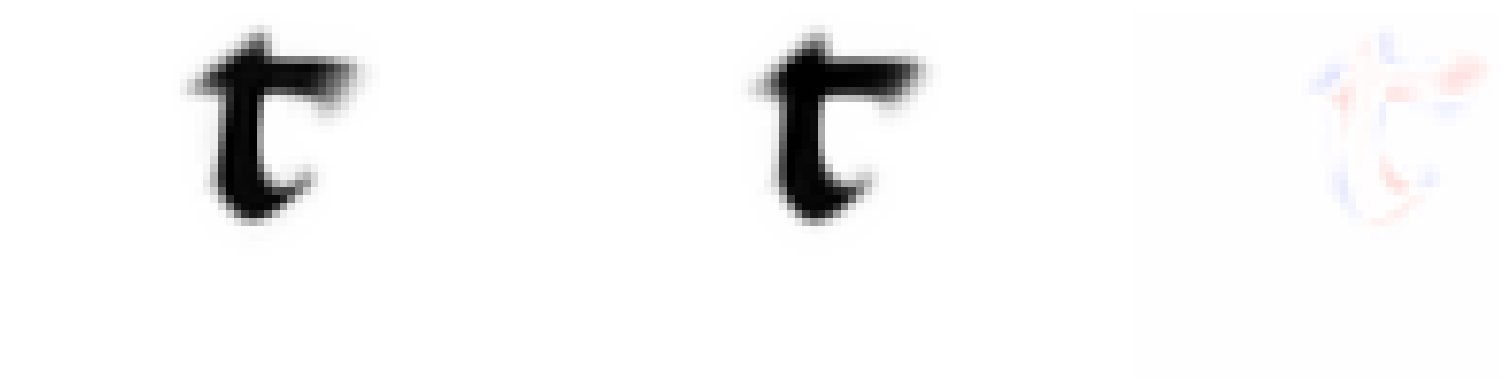

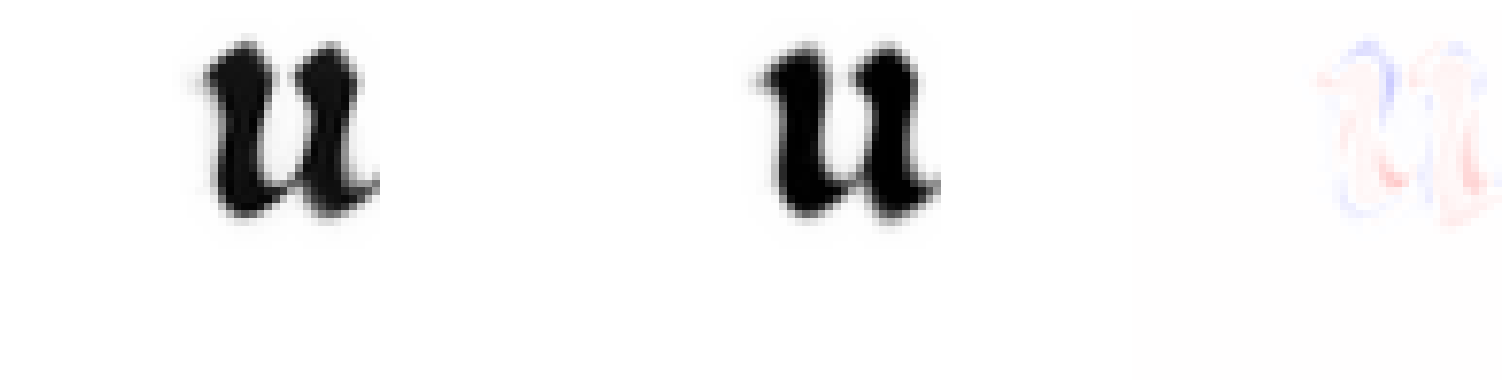

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/Northern_Textualis


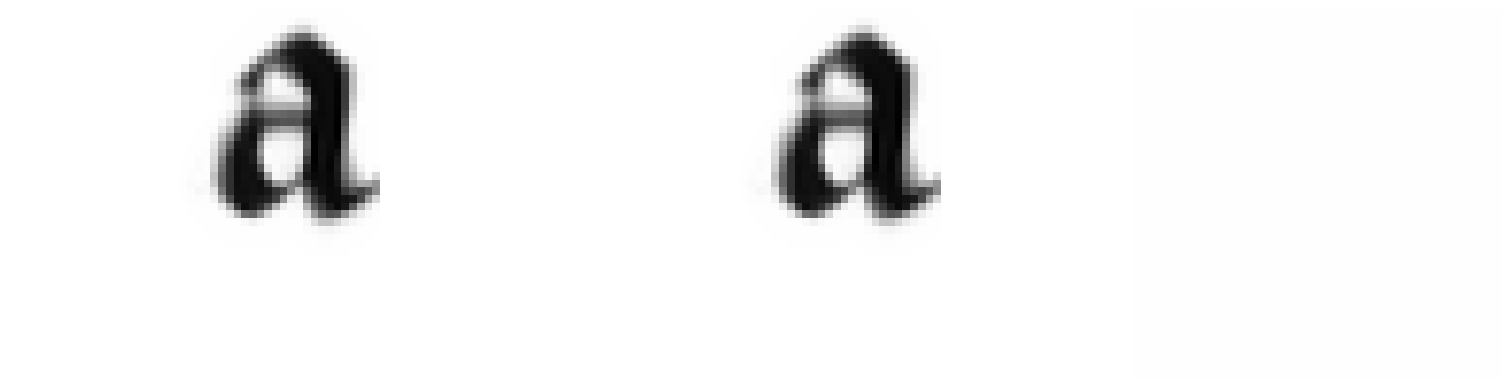

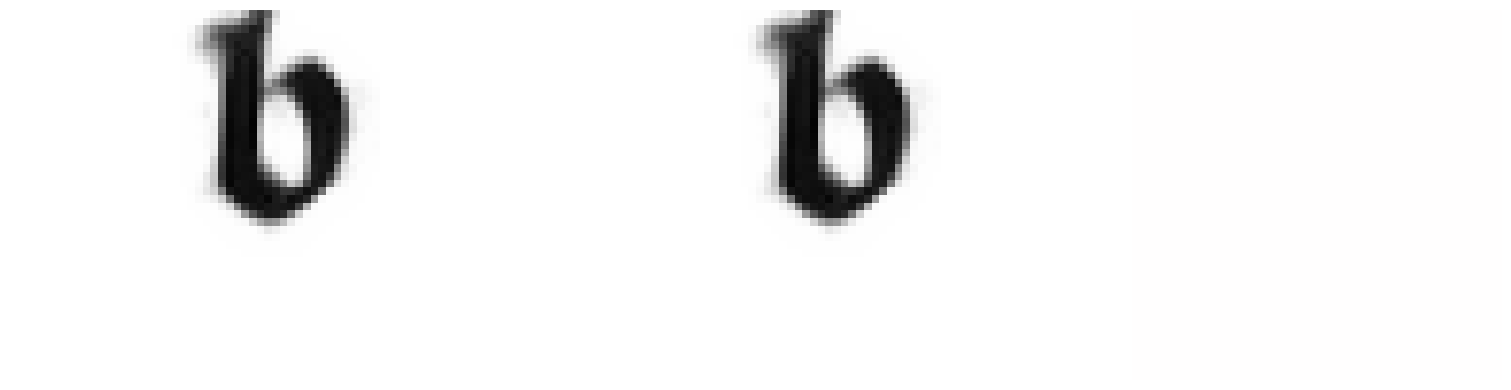

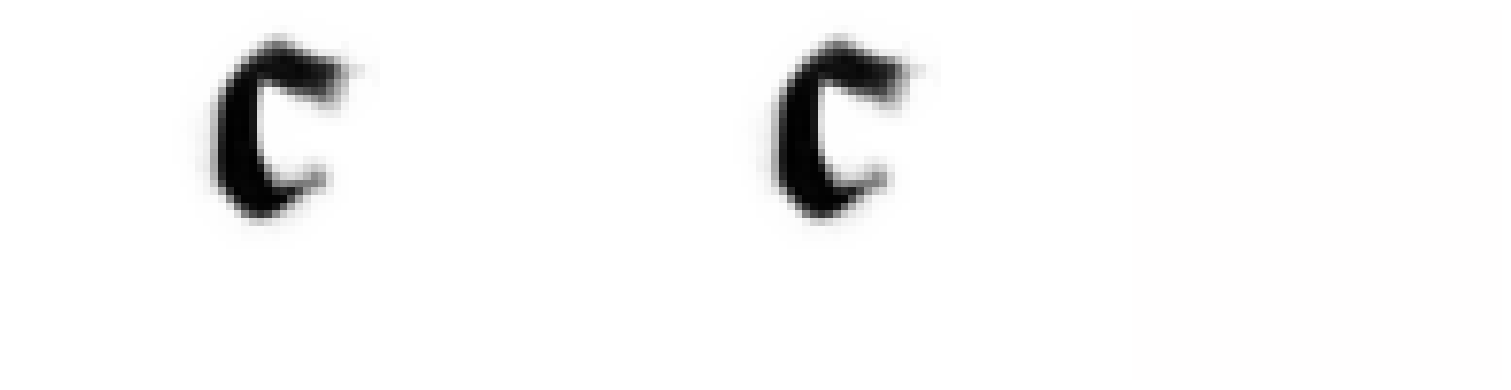

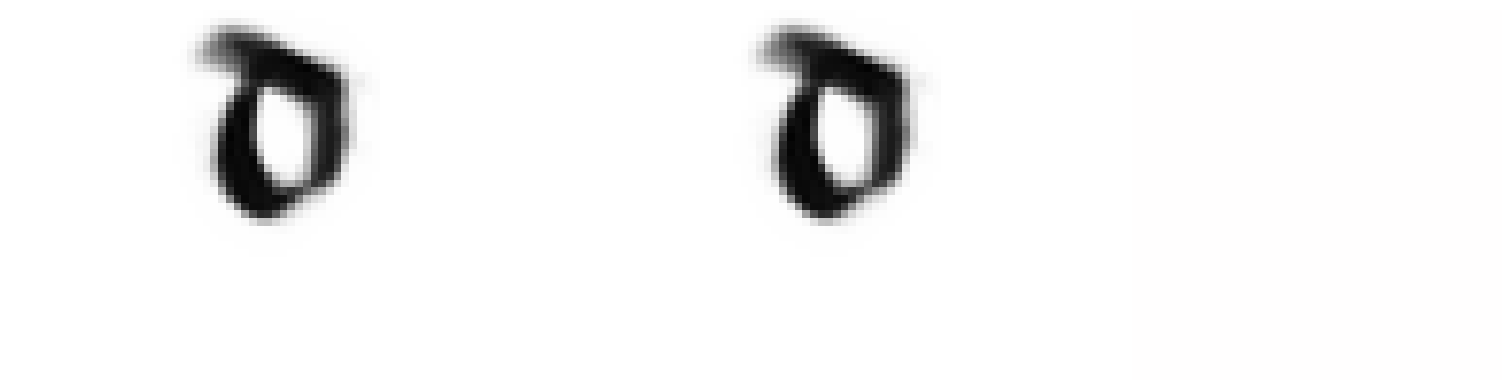

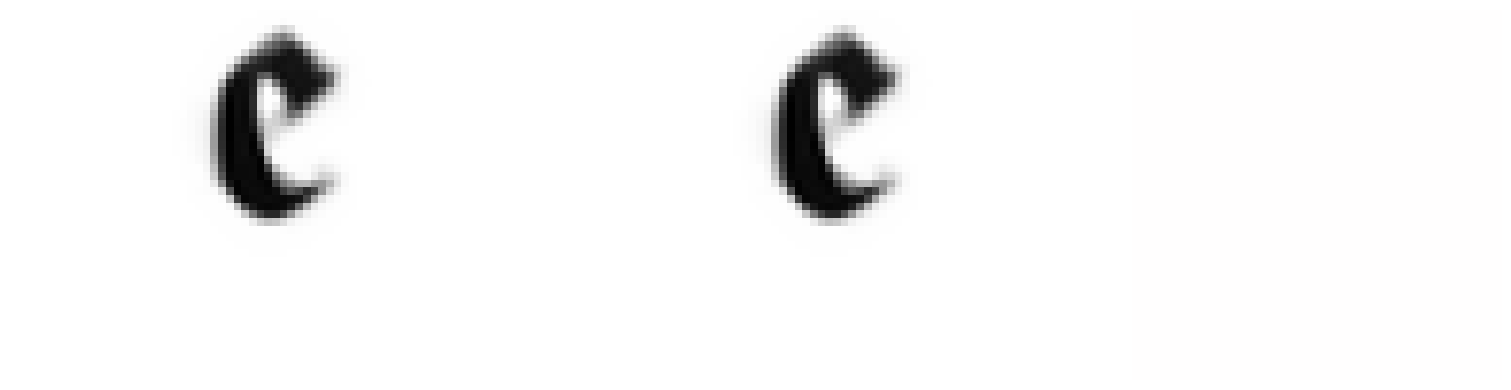

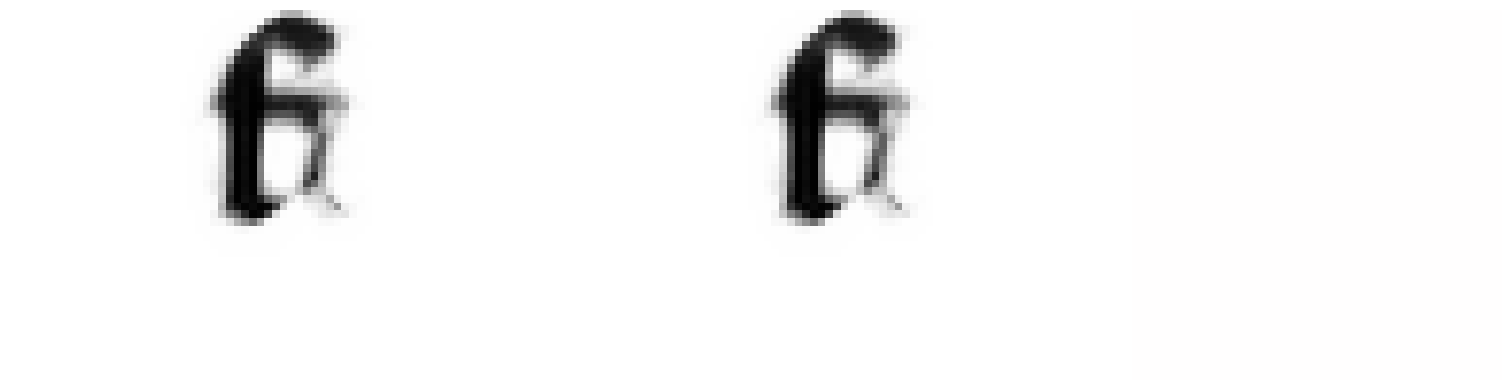

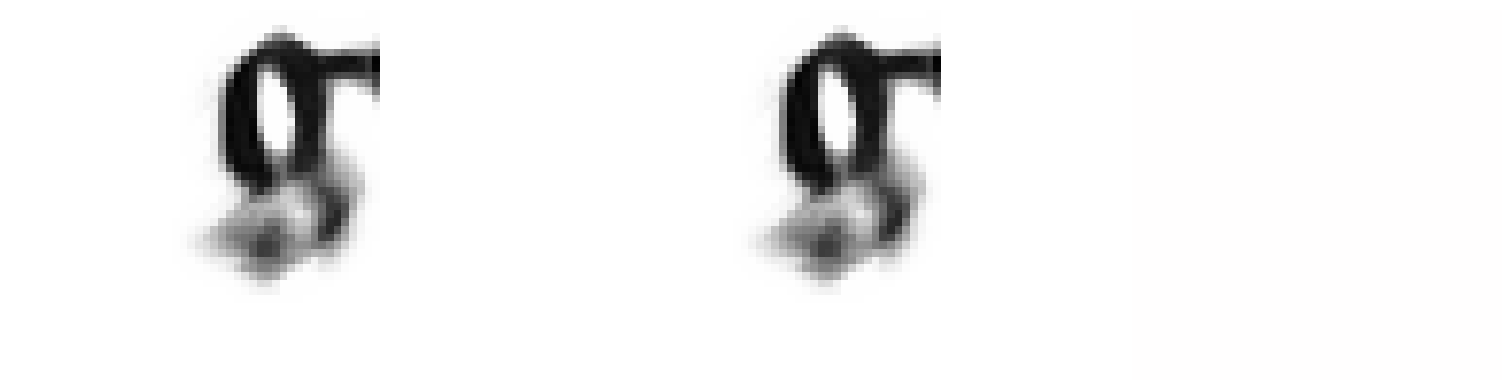

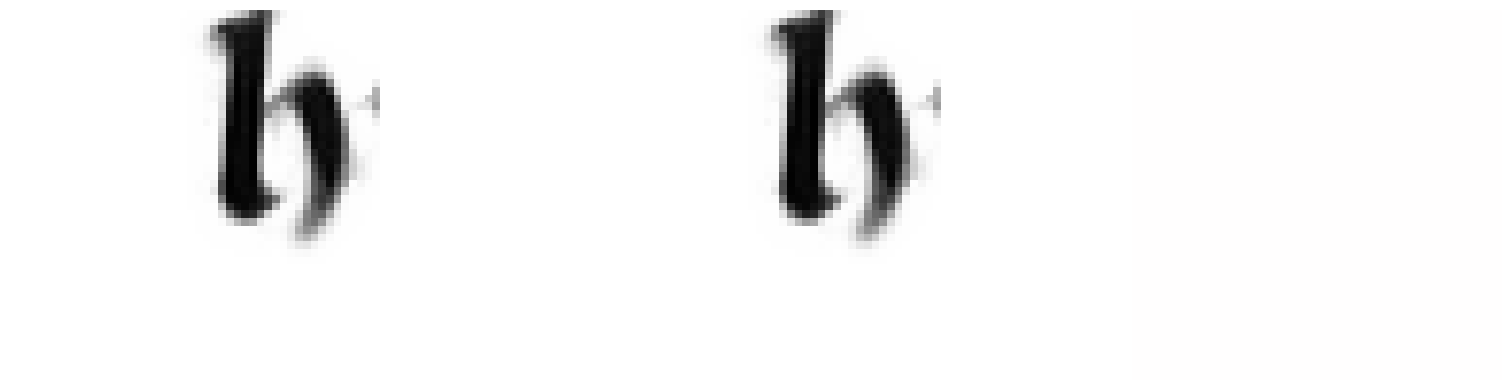

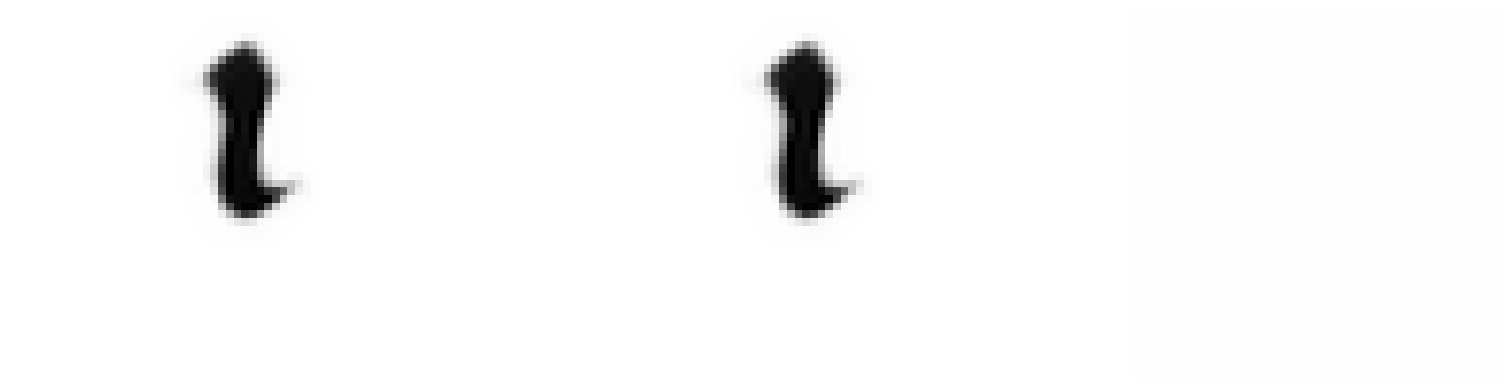

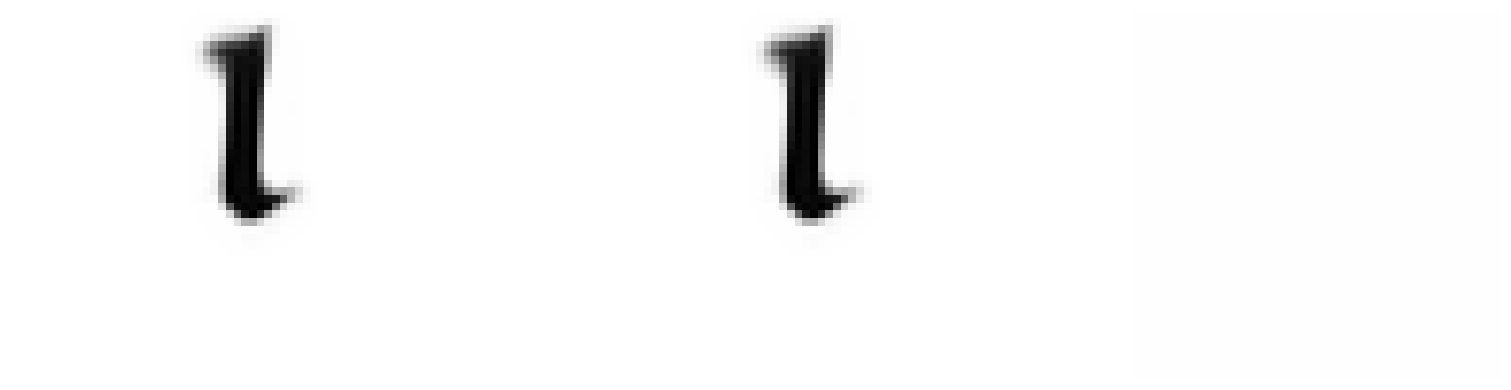

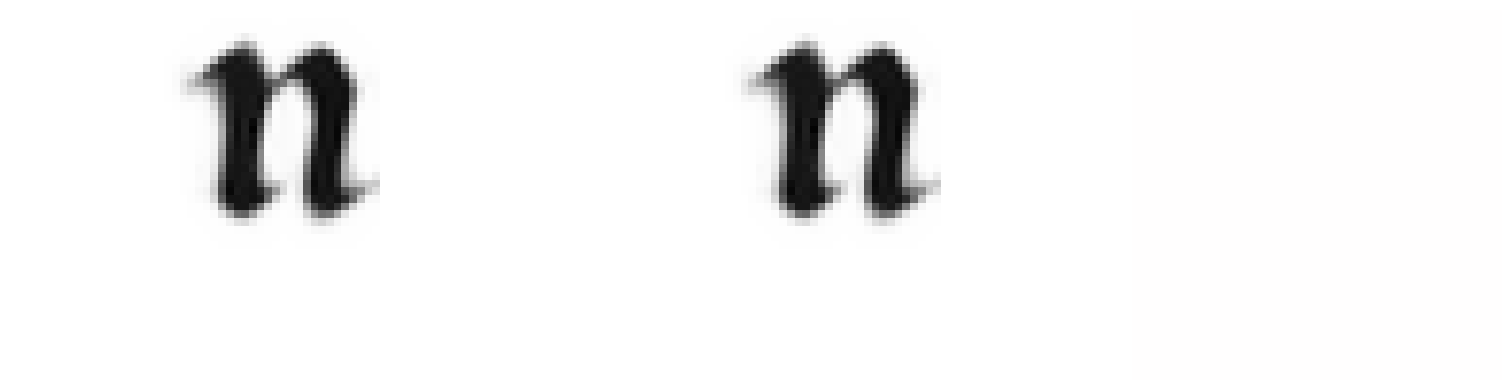

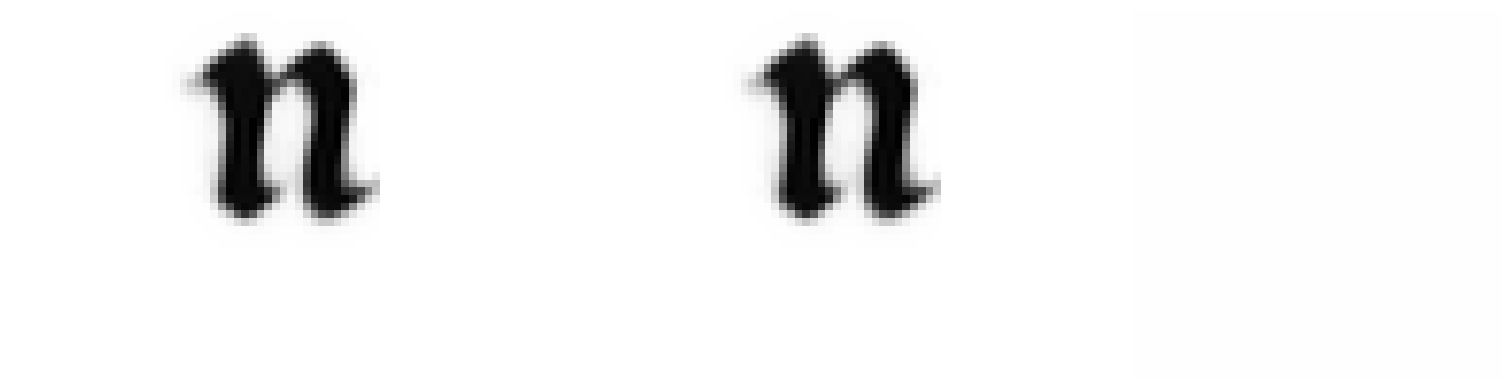

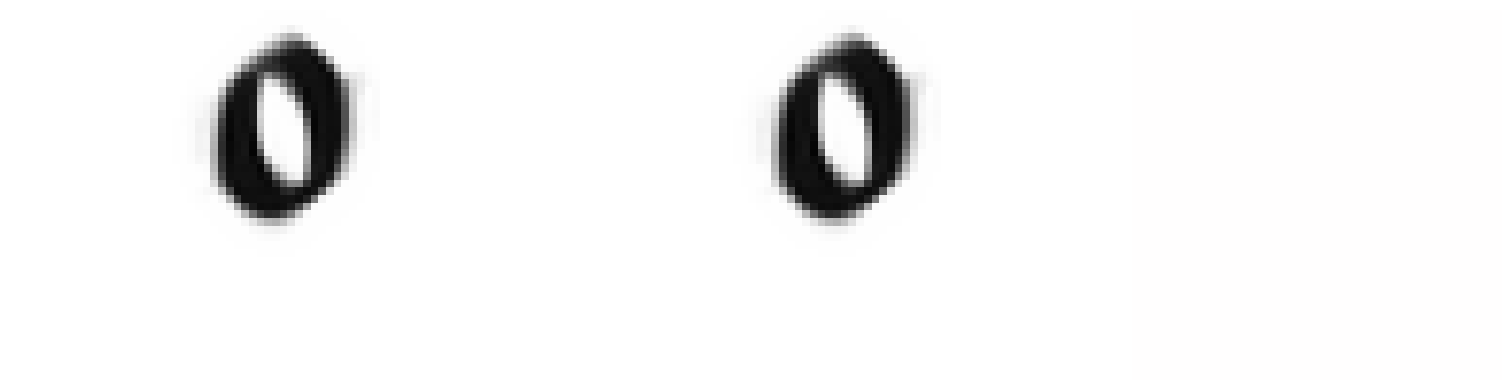

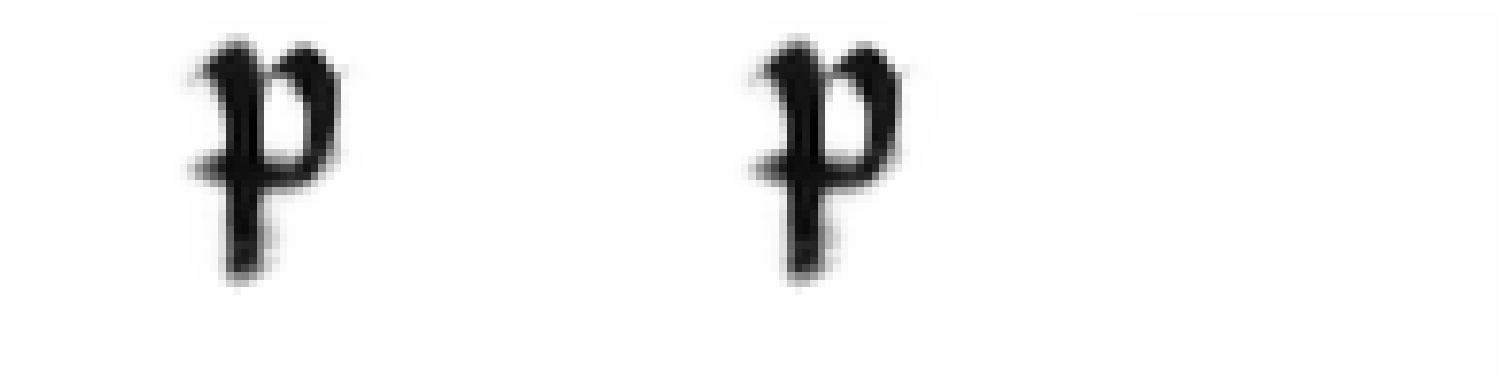

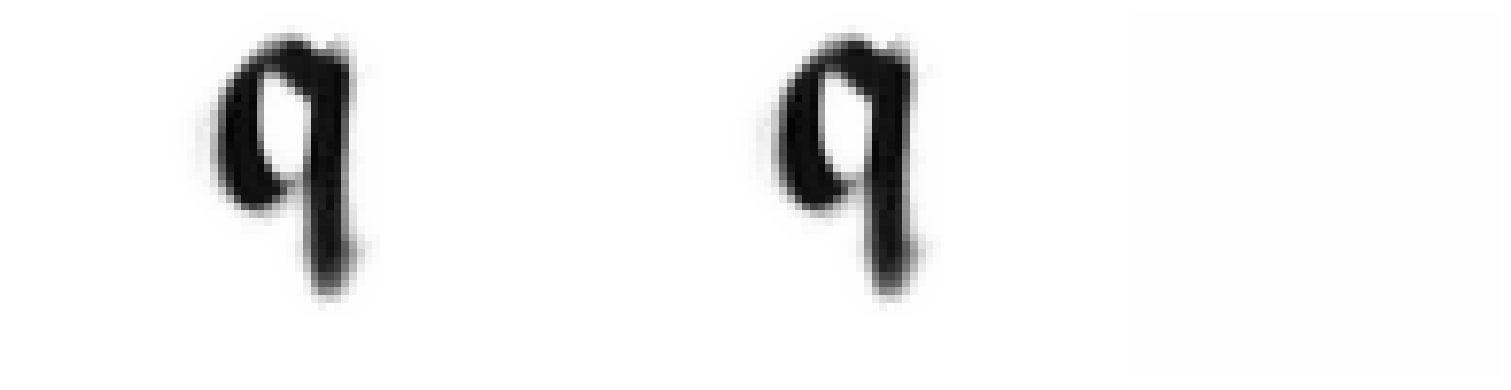

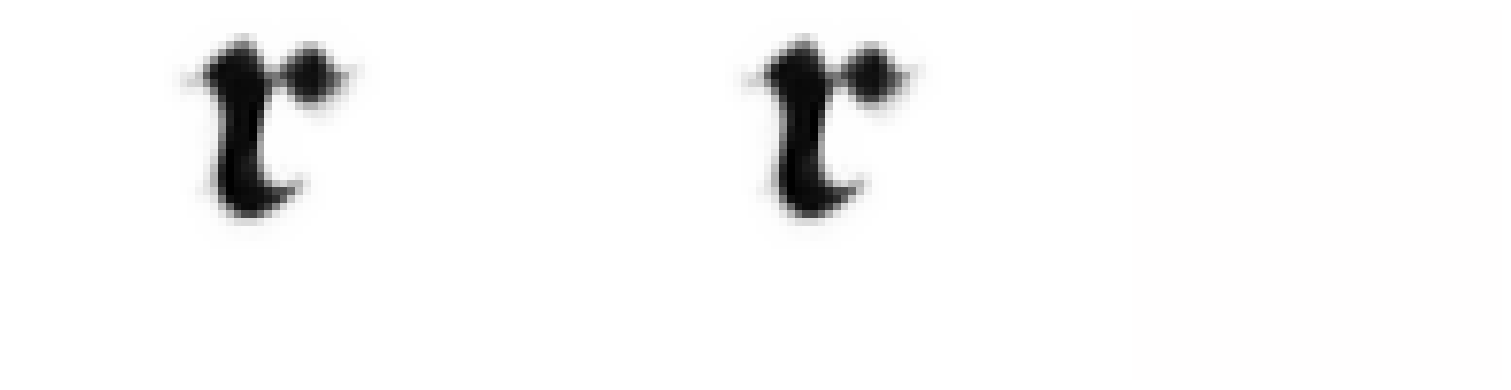

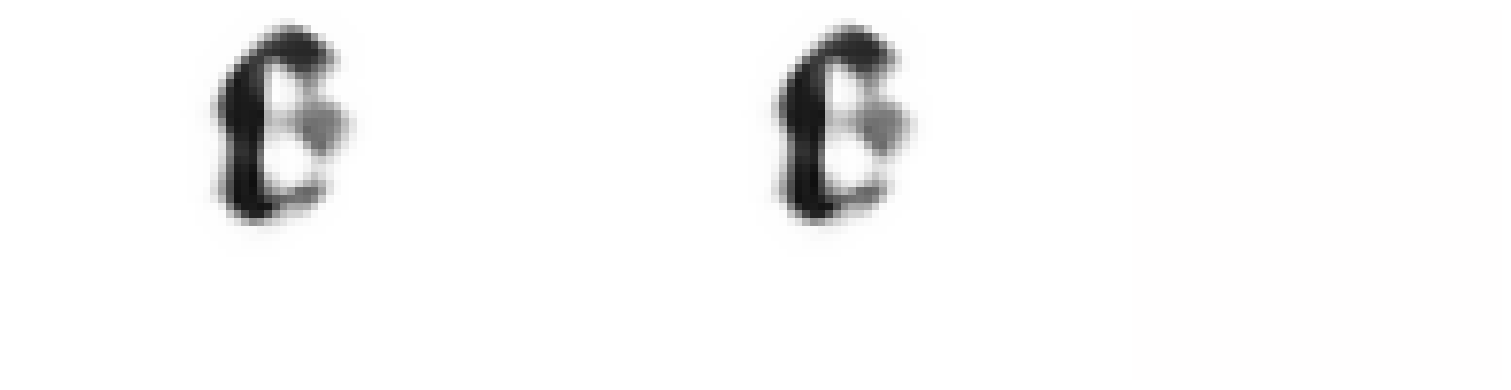

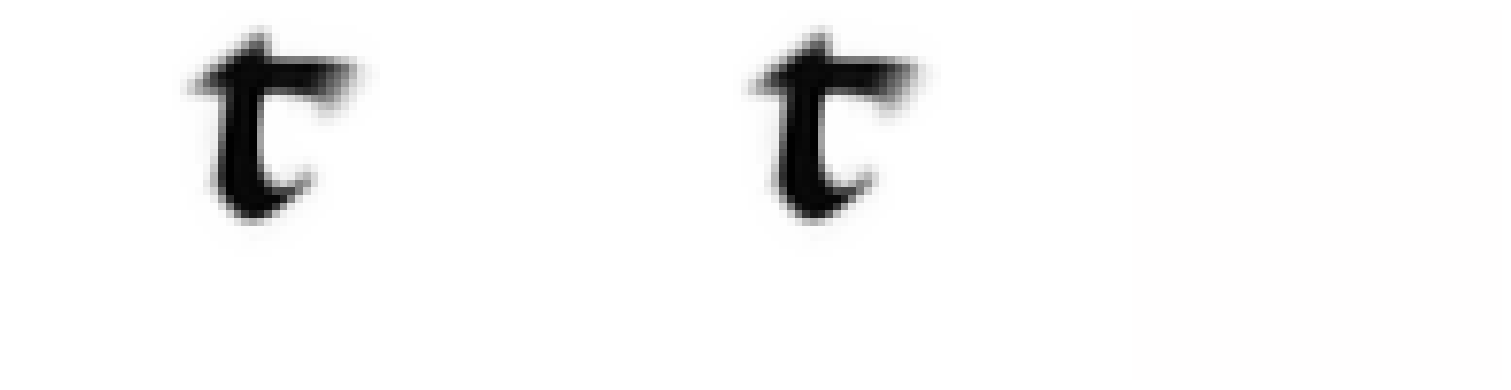

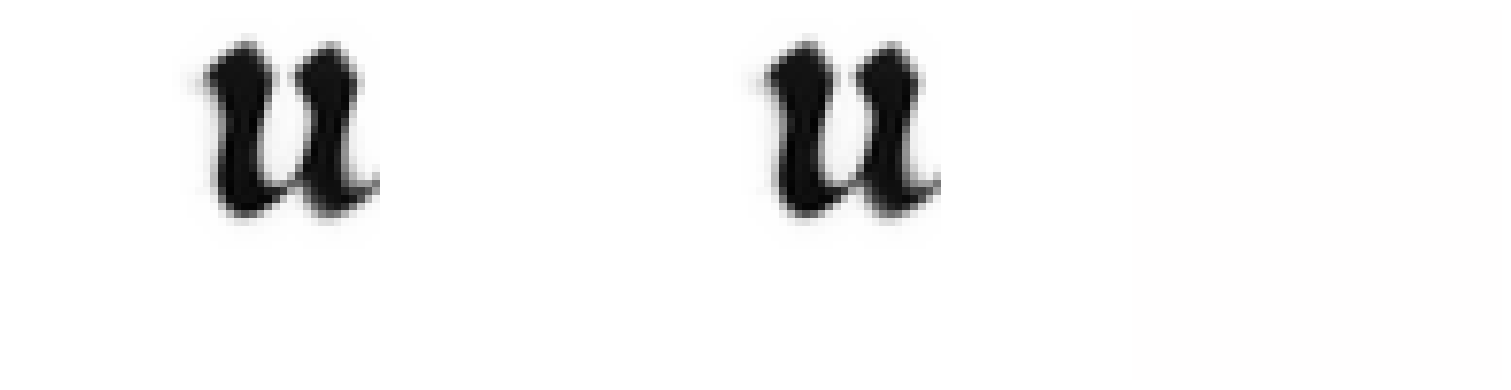

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/btv1b8447298r


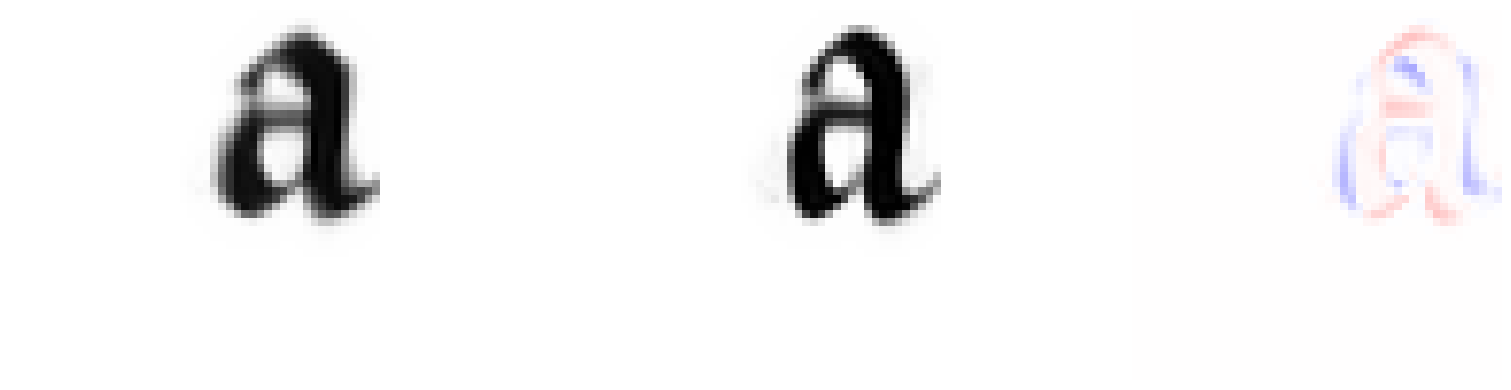

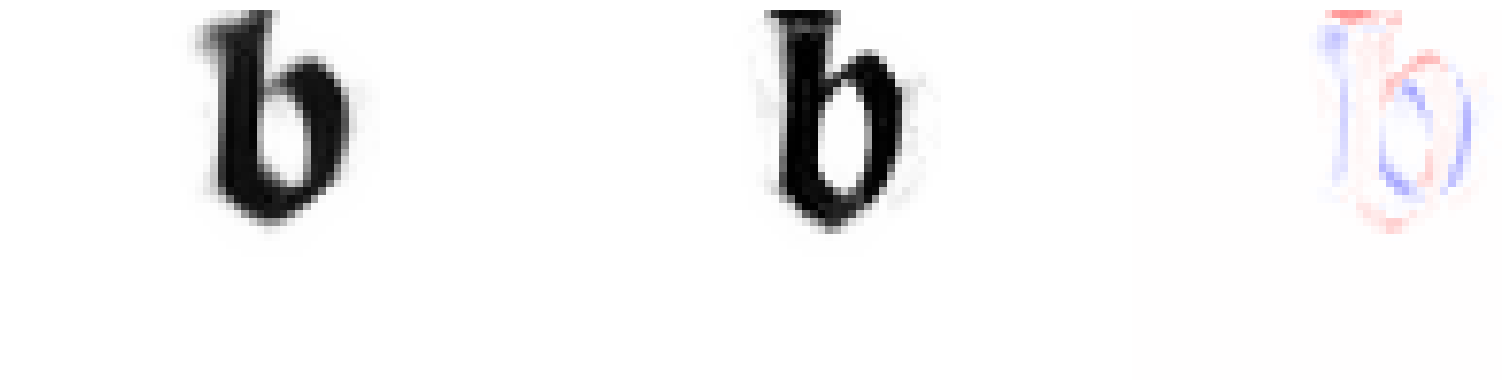

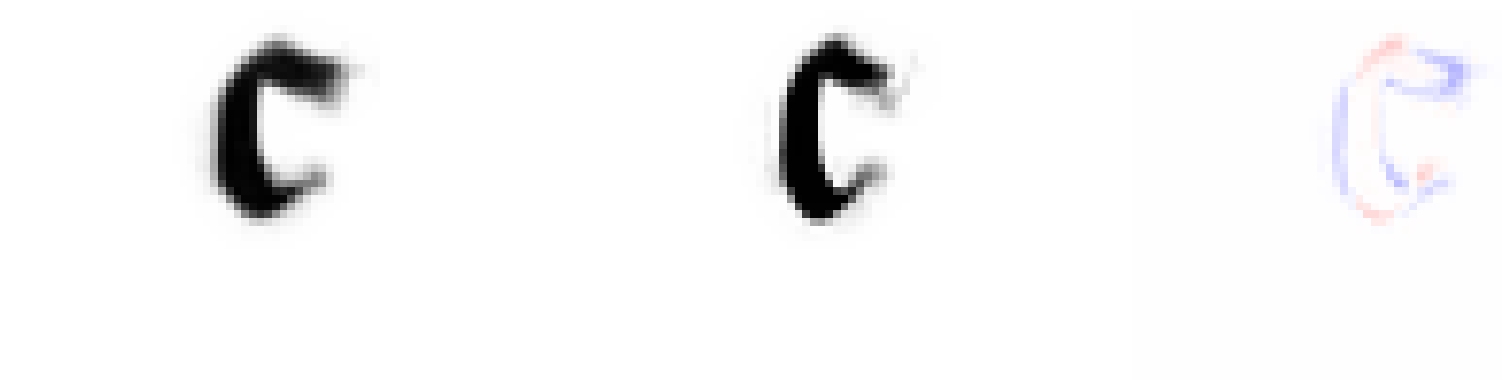

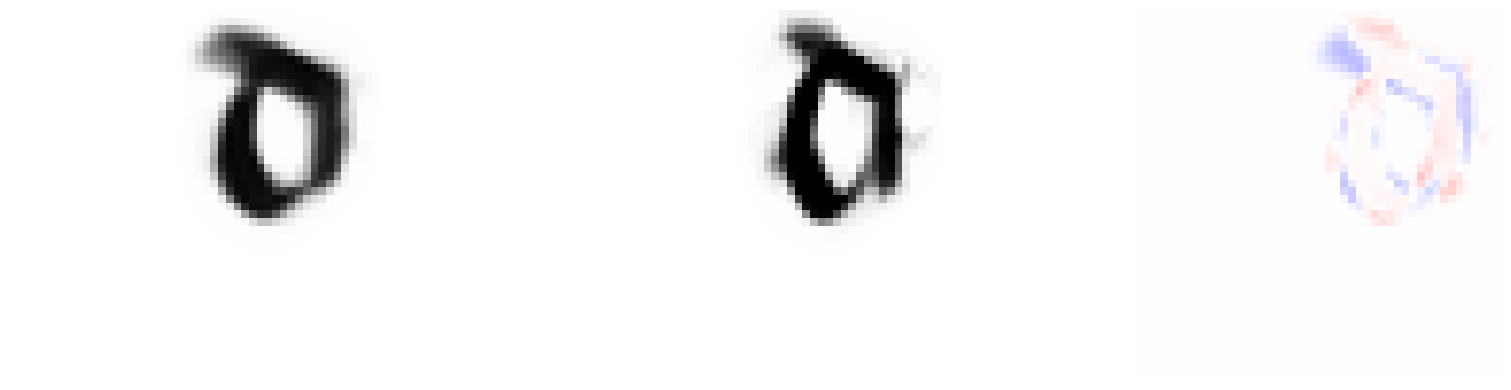

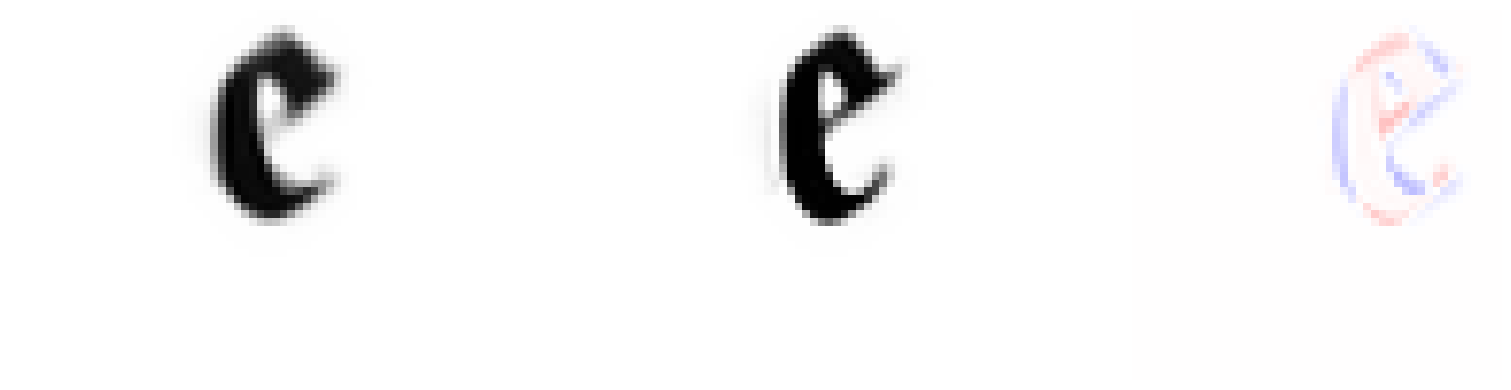

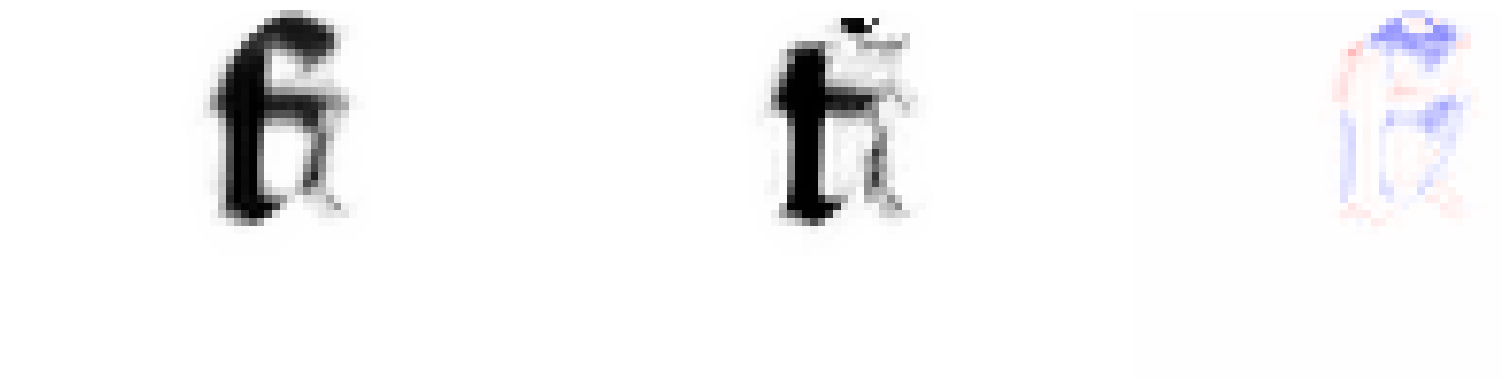

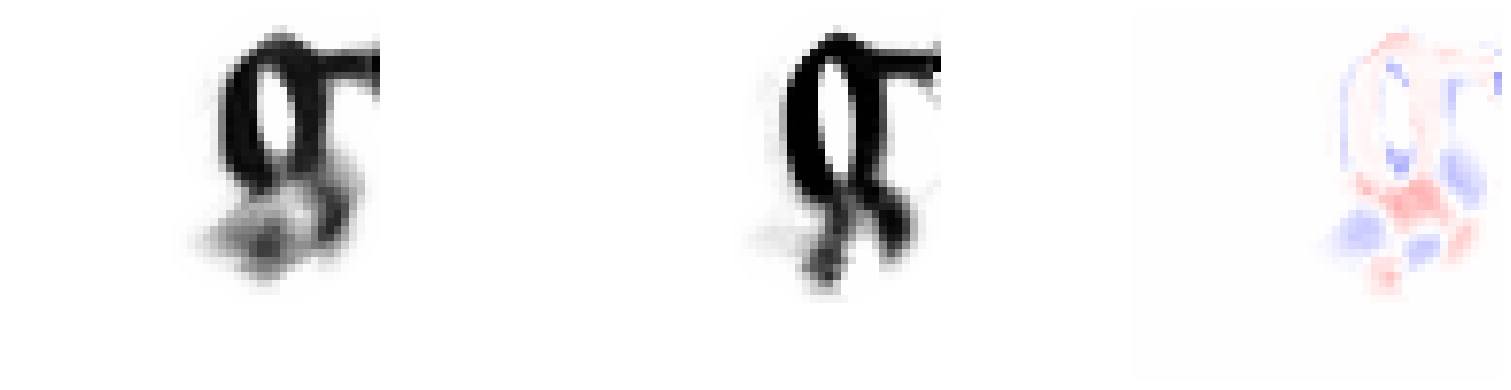

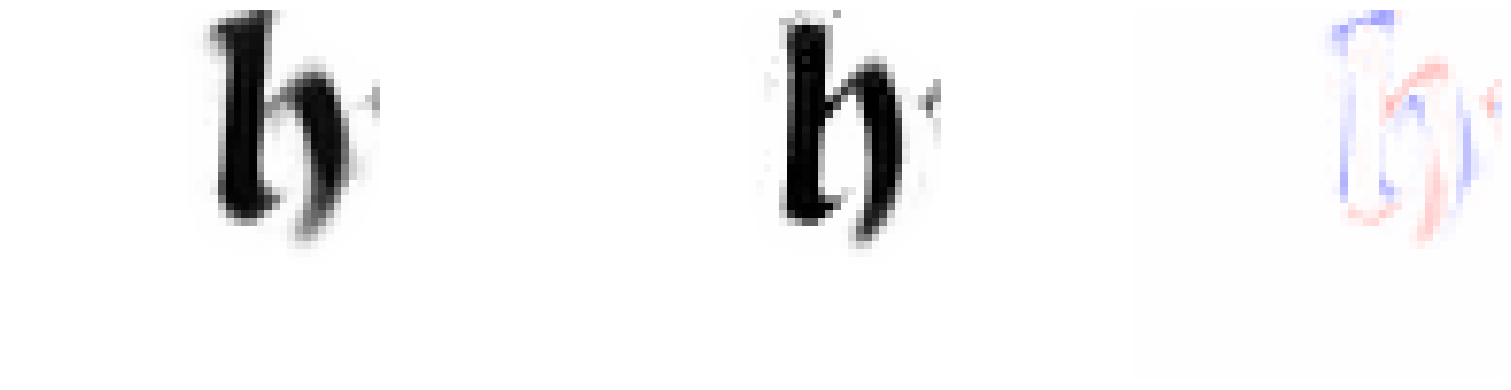

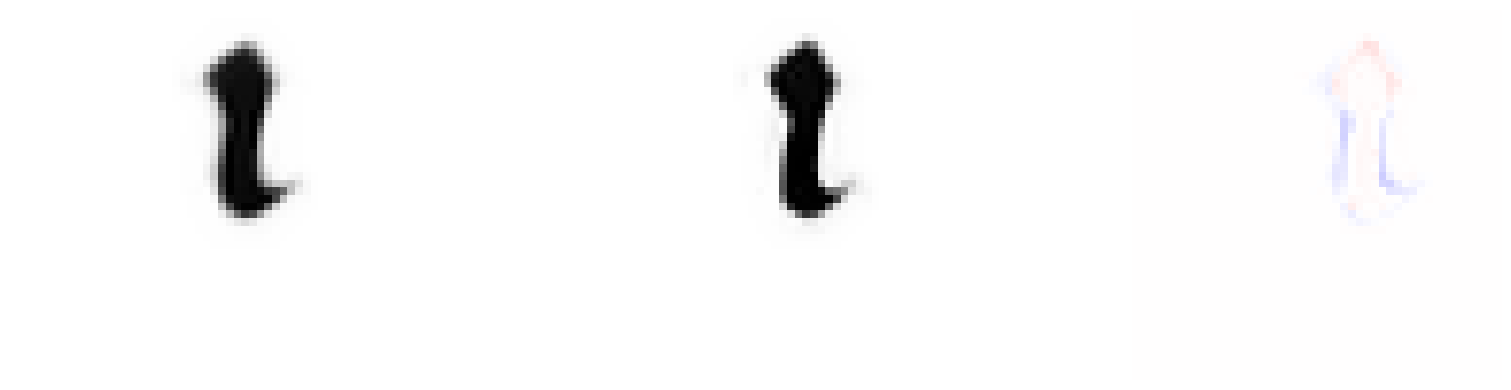

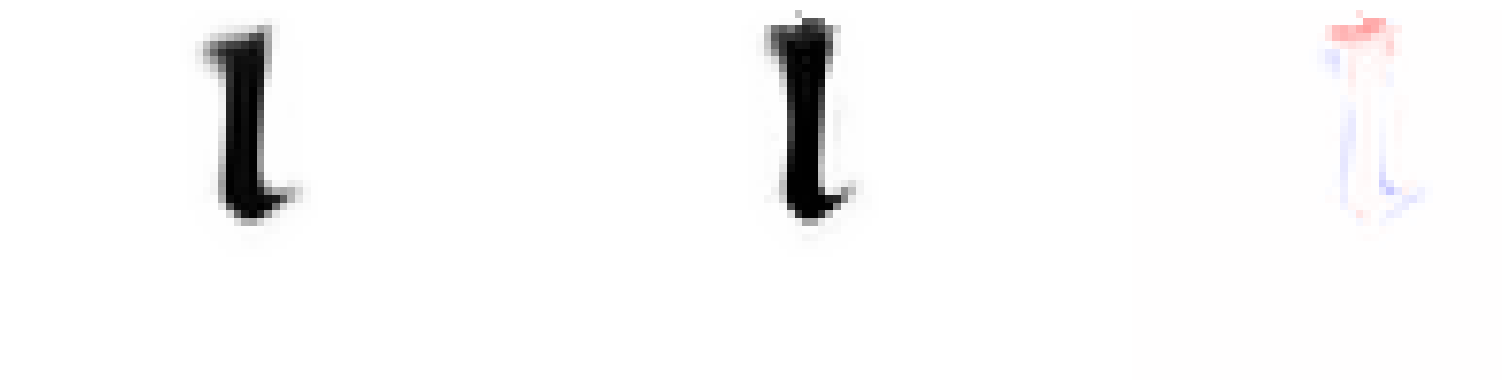

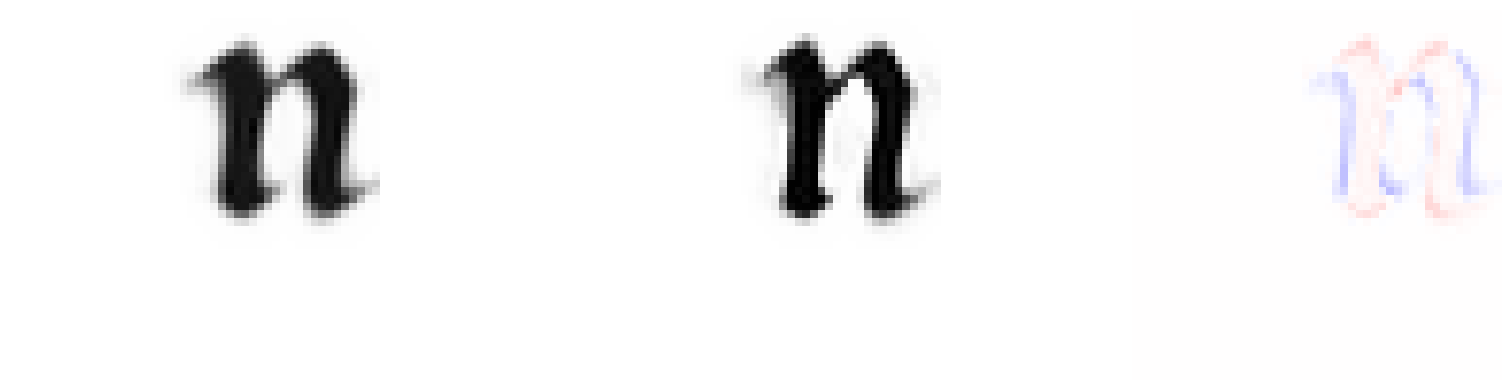

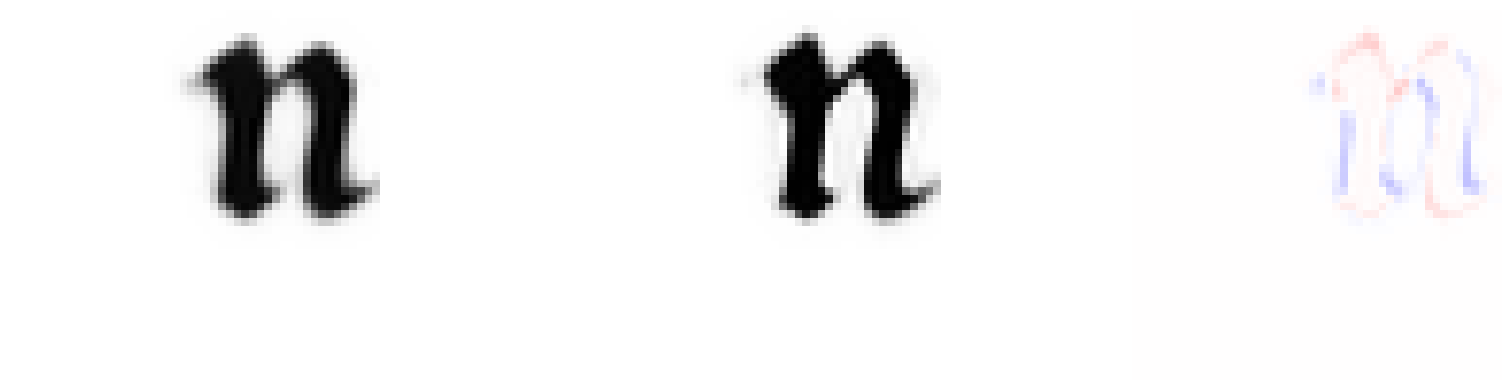

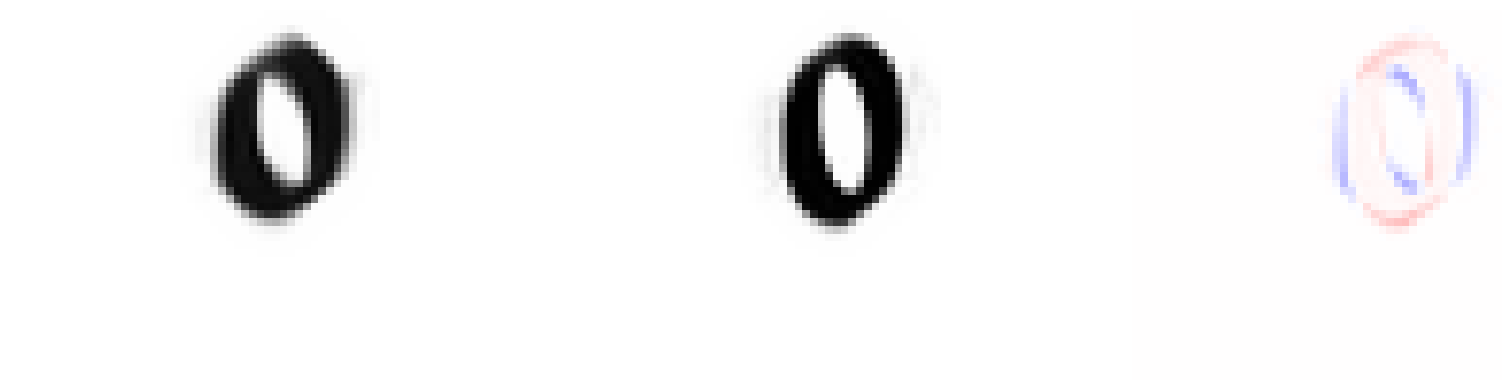

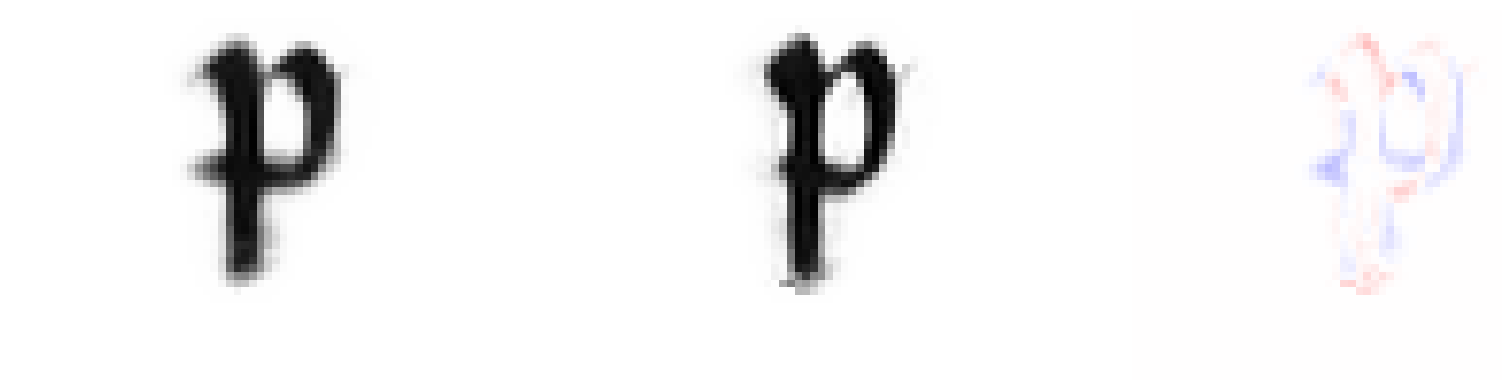

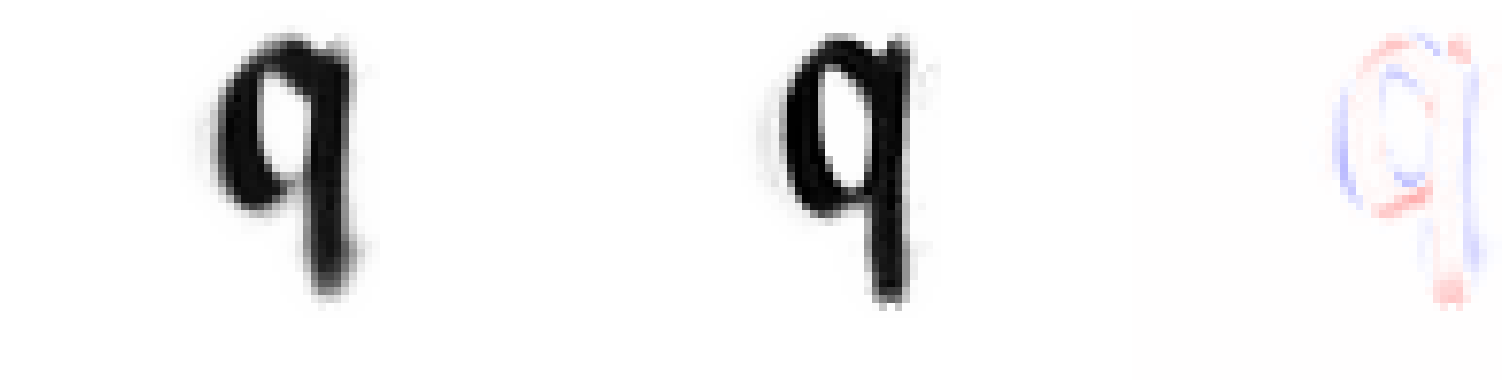

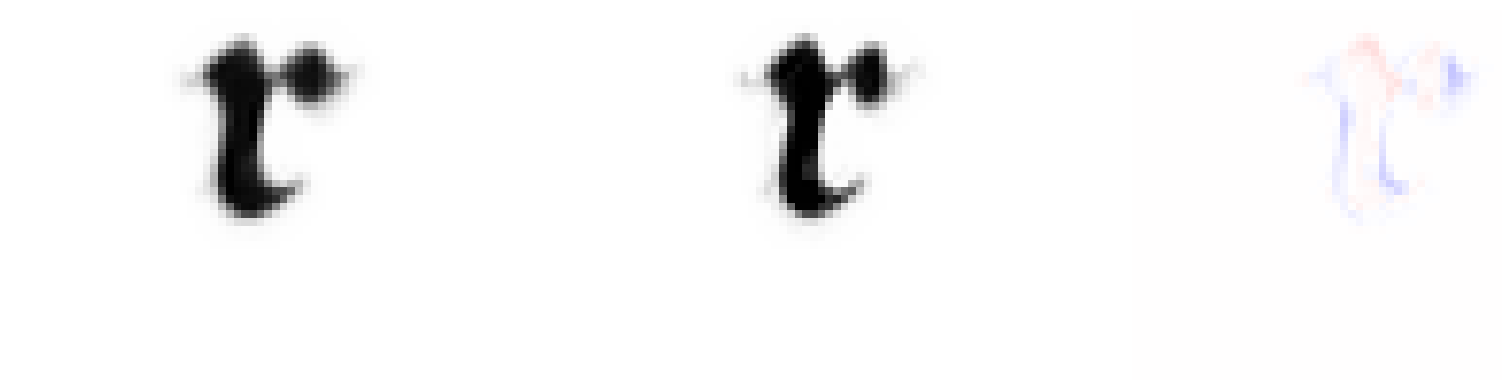

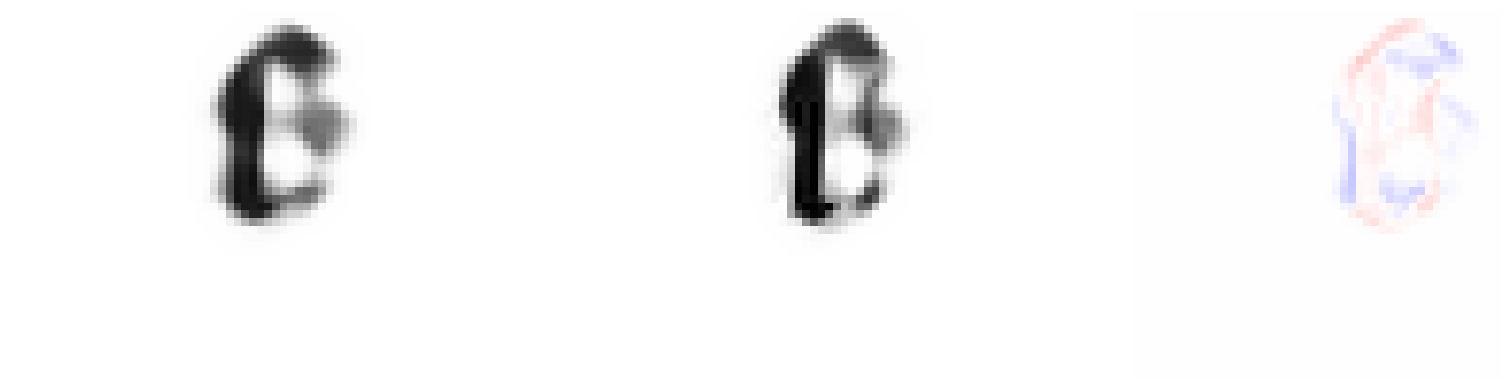

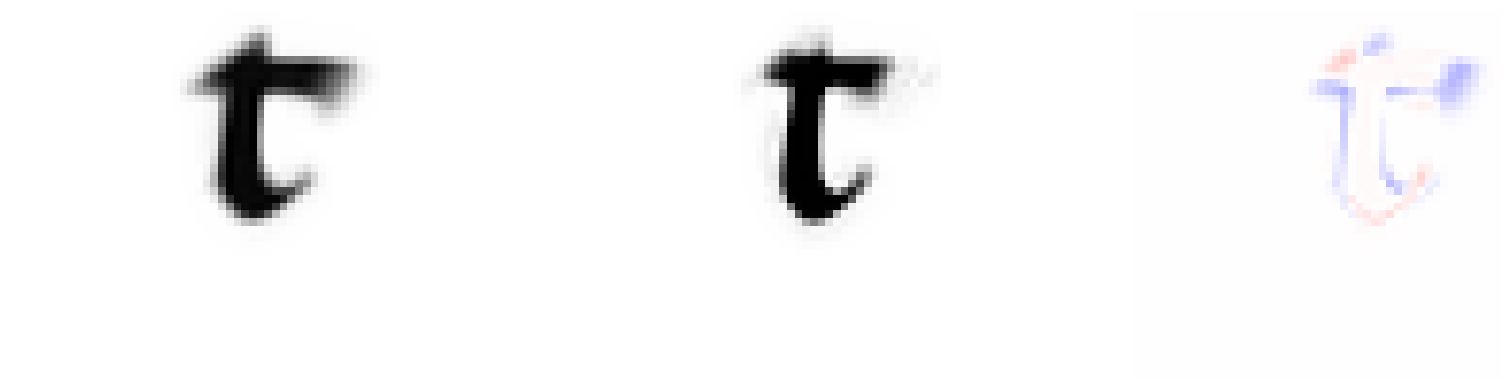

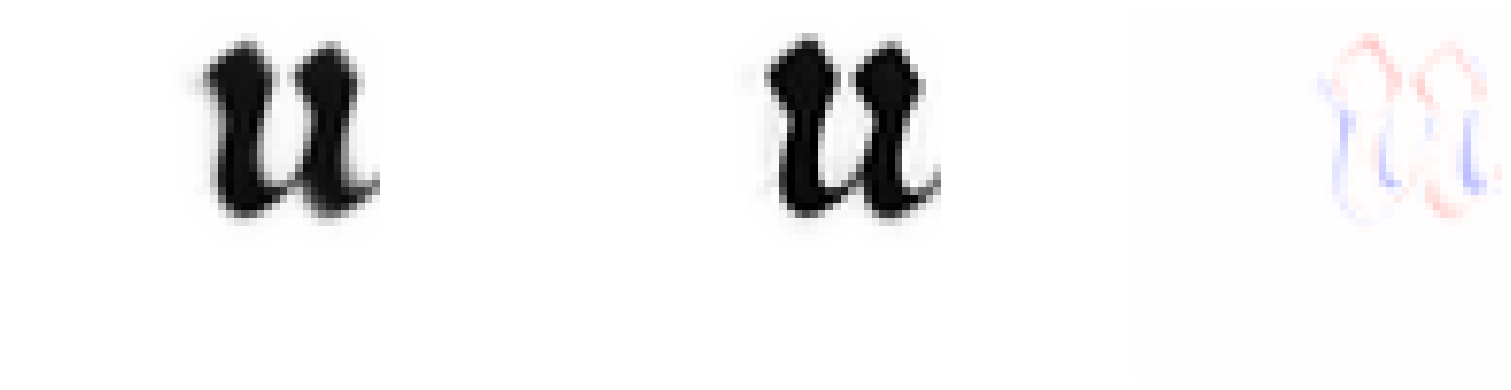

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/btv1b525068331


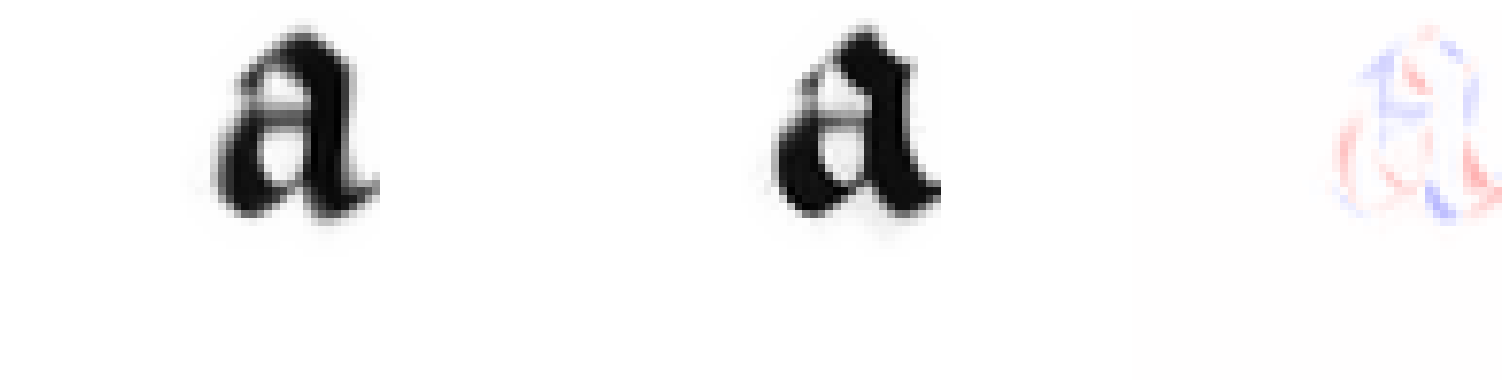

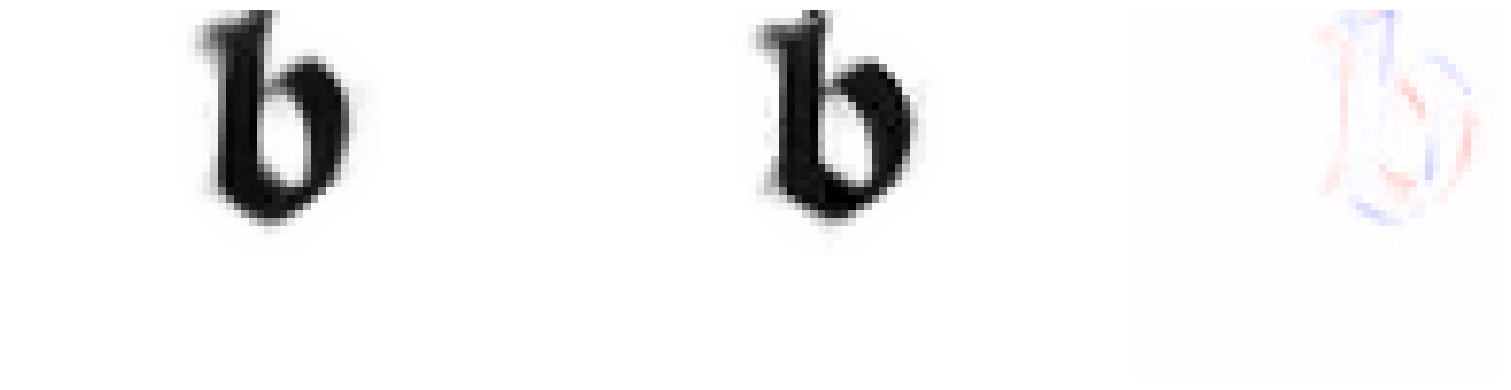

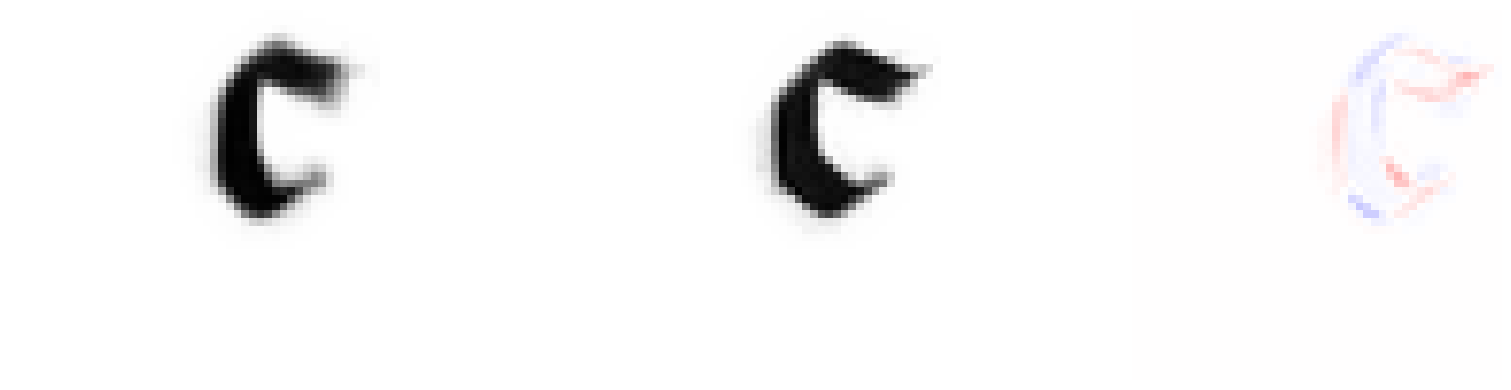

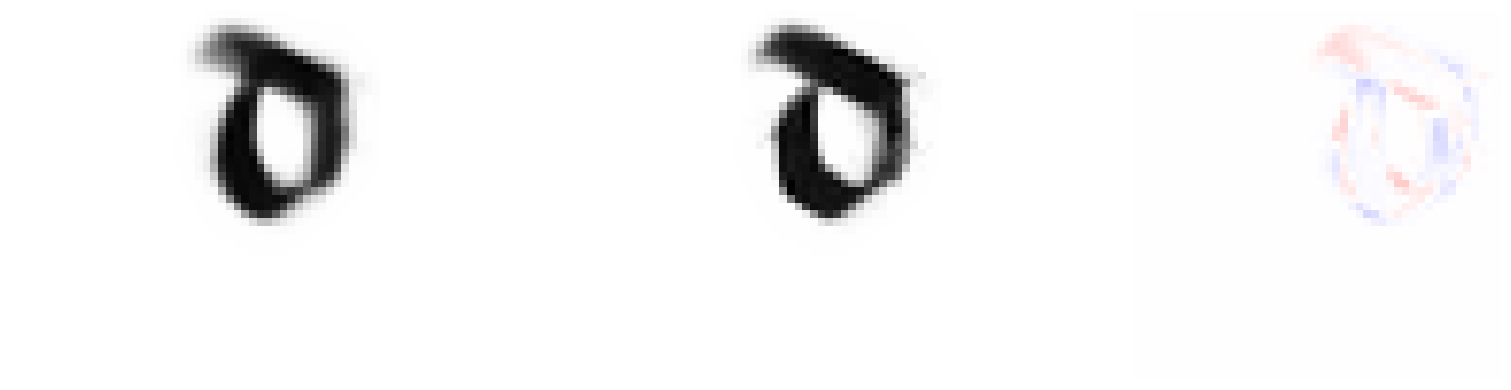

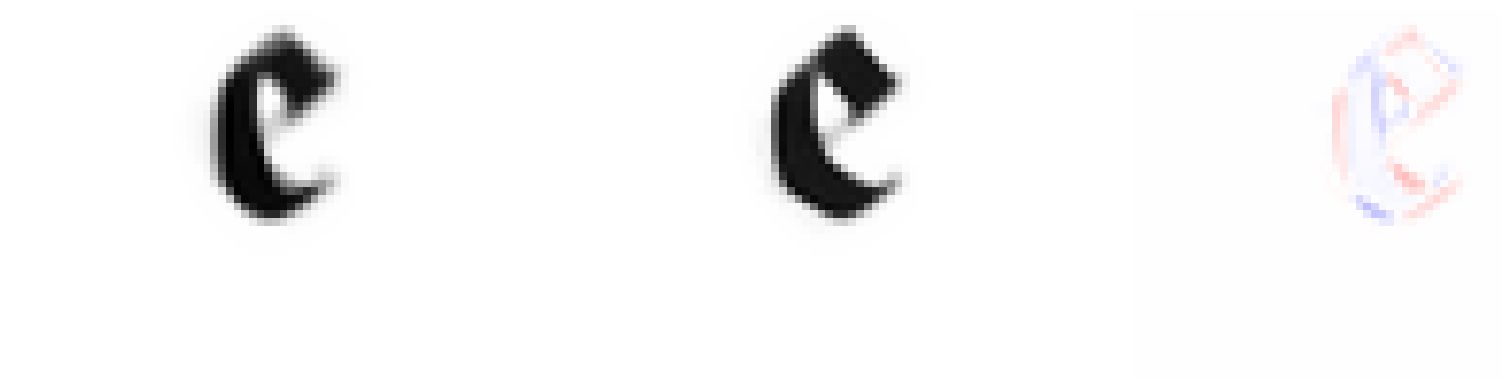

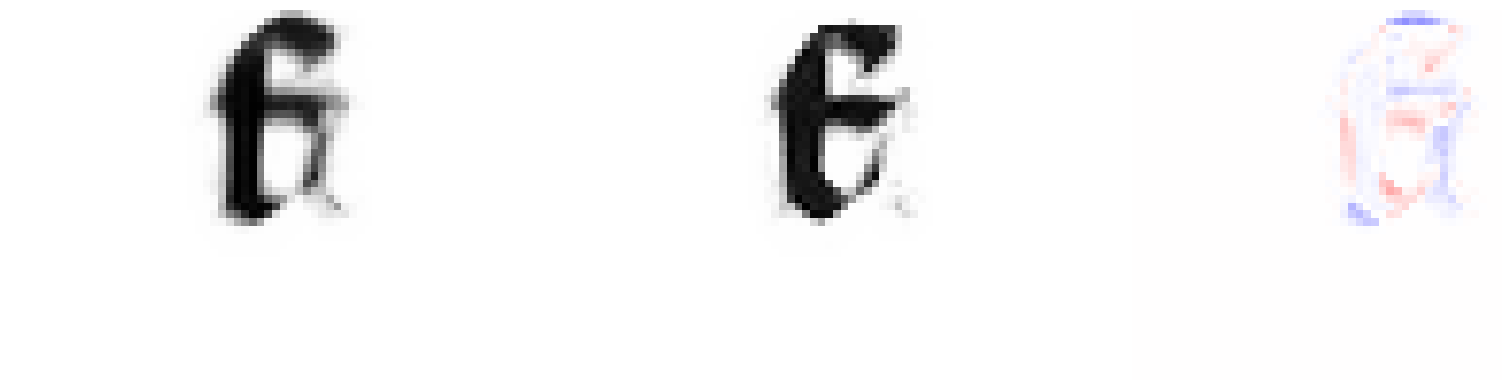

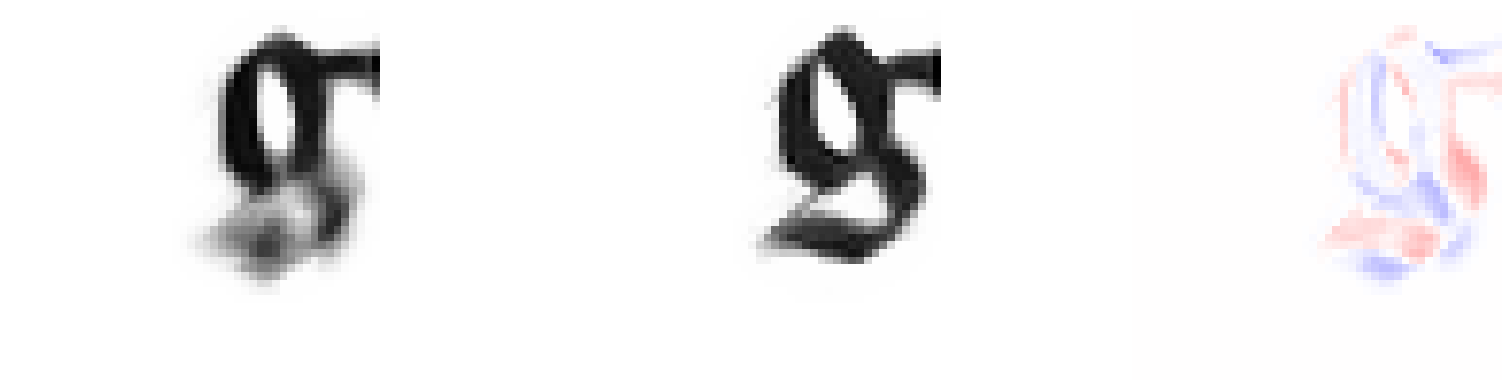

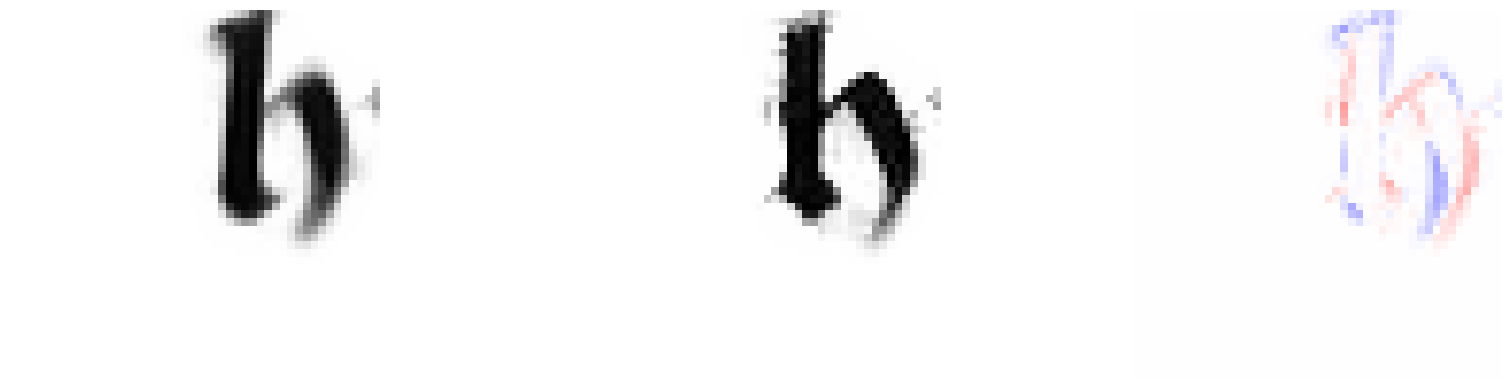

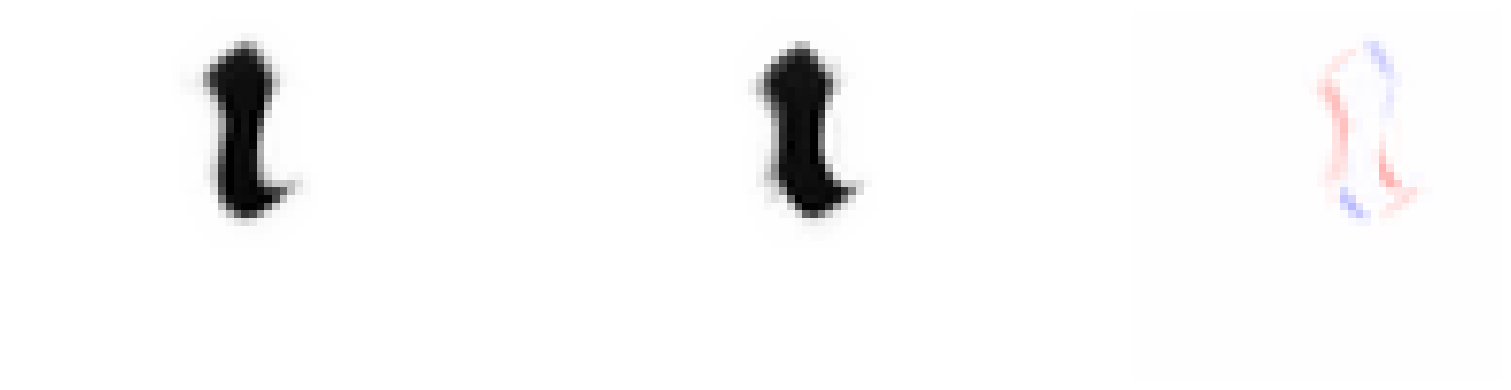

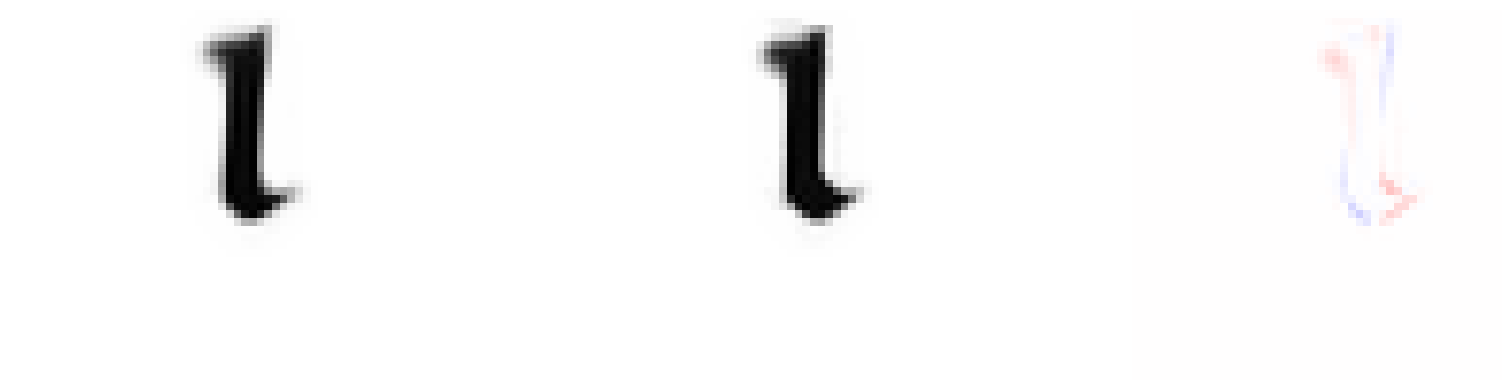

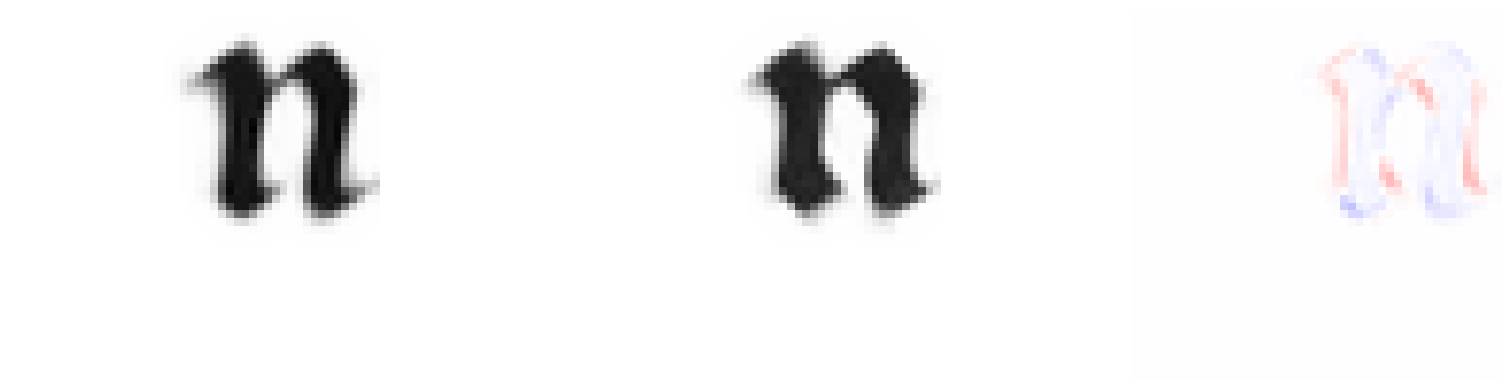

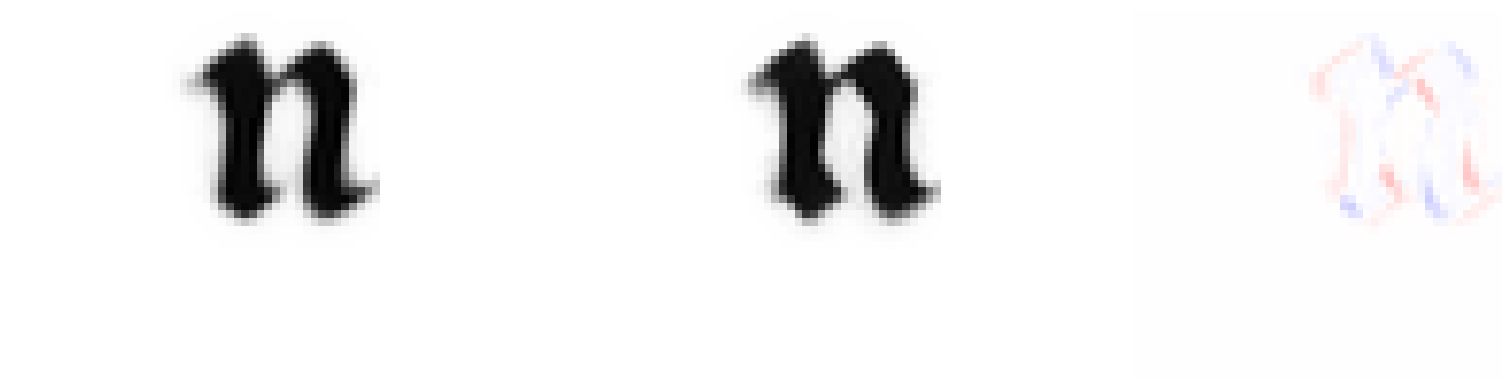

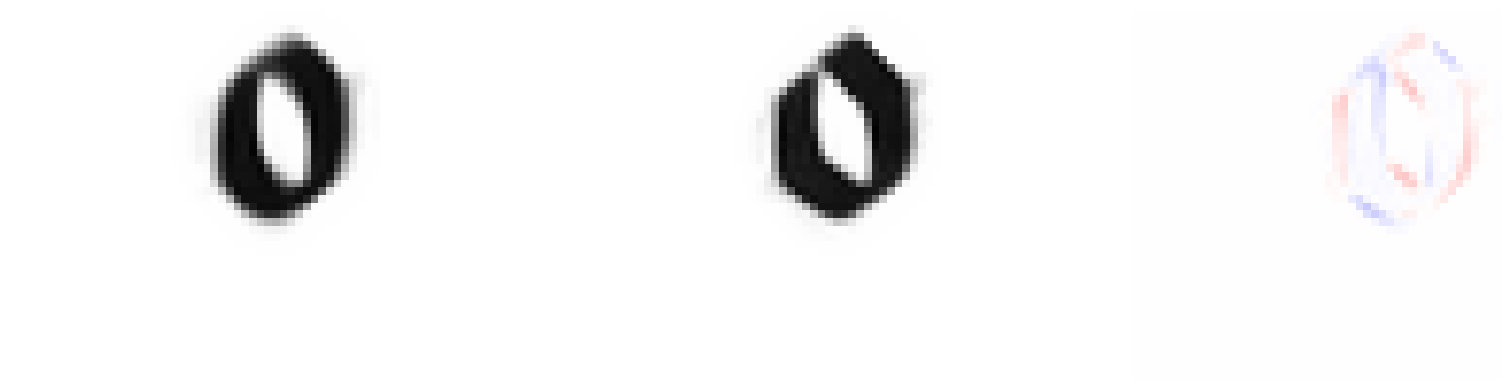

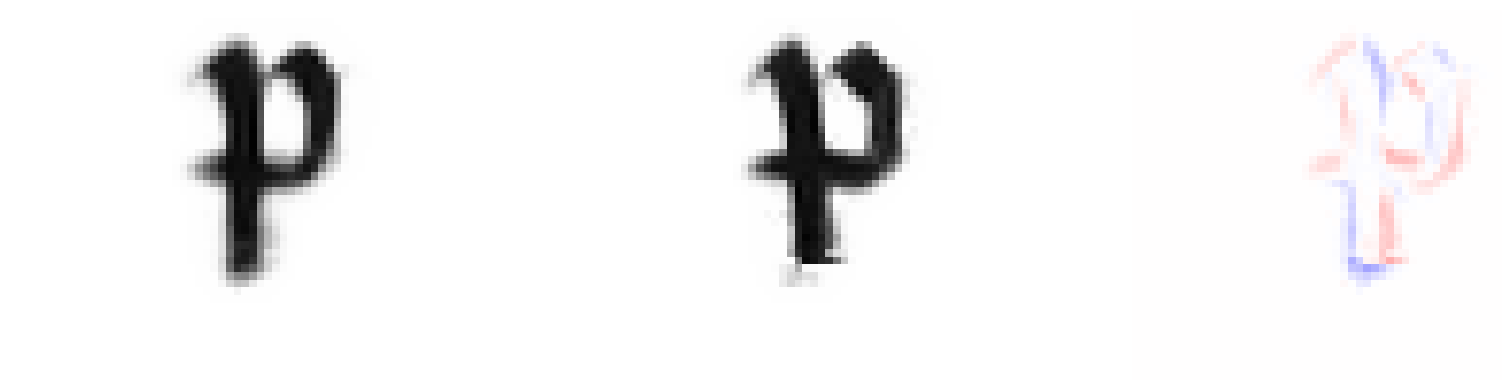

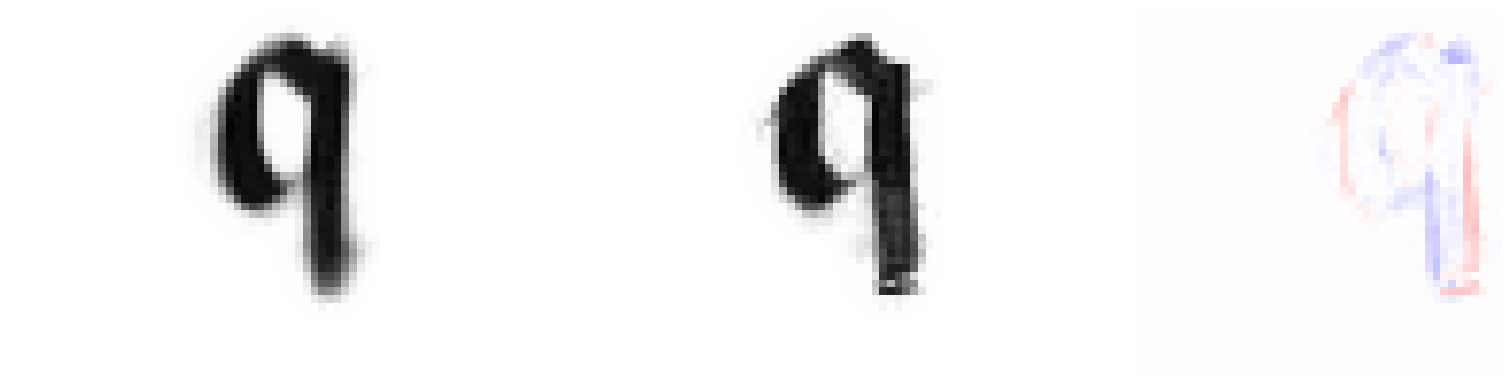

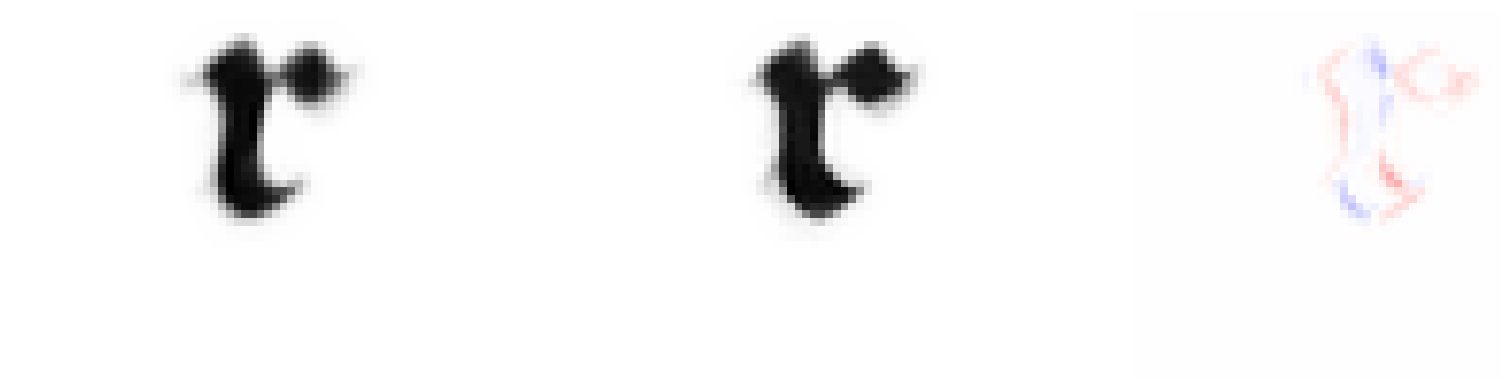

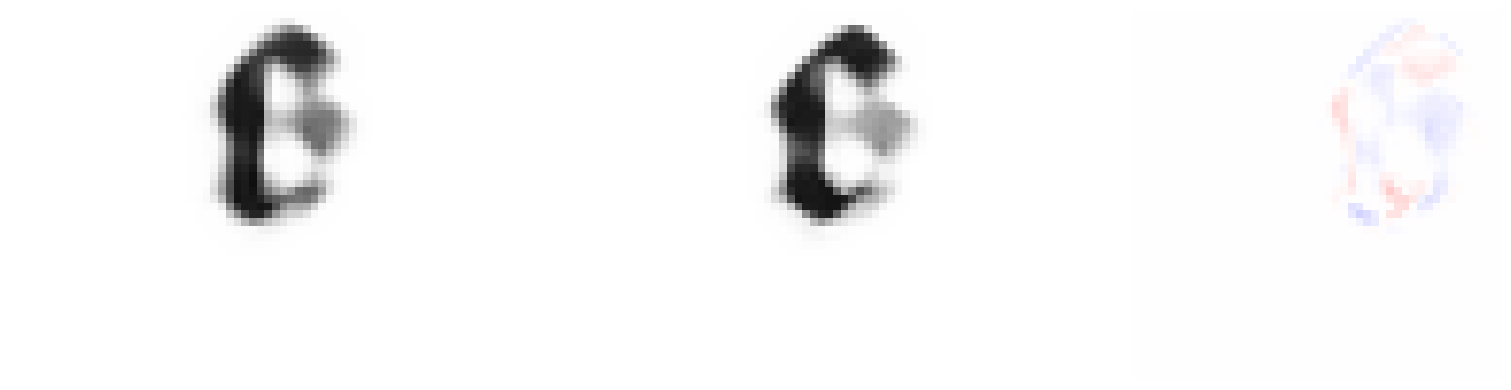

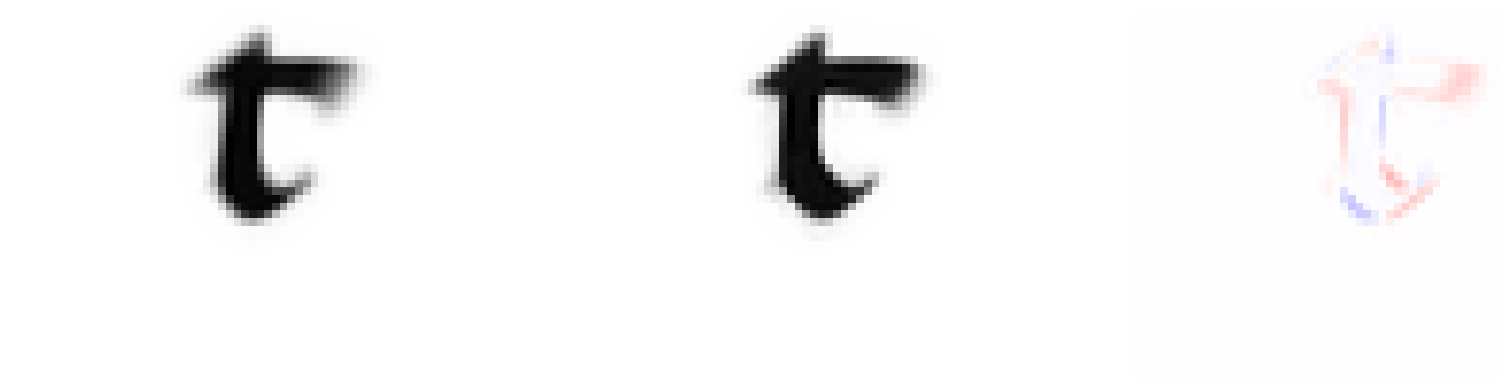

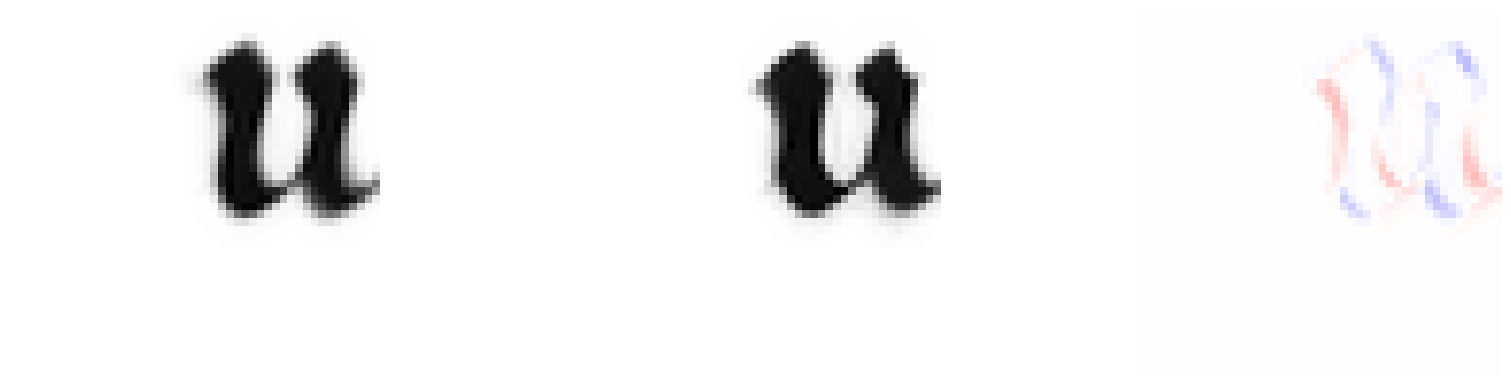

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/Arras-861


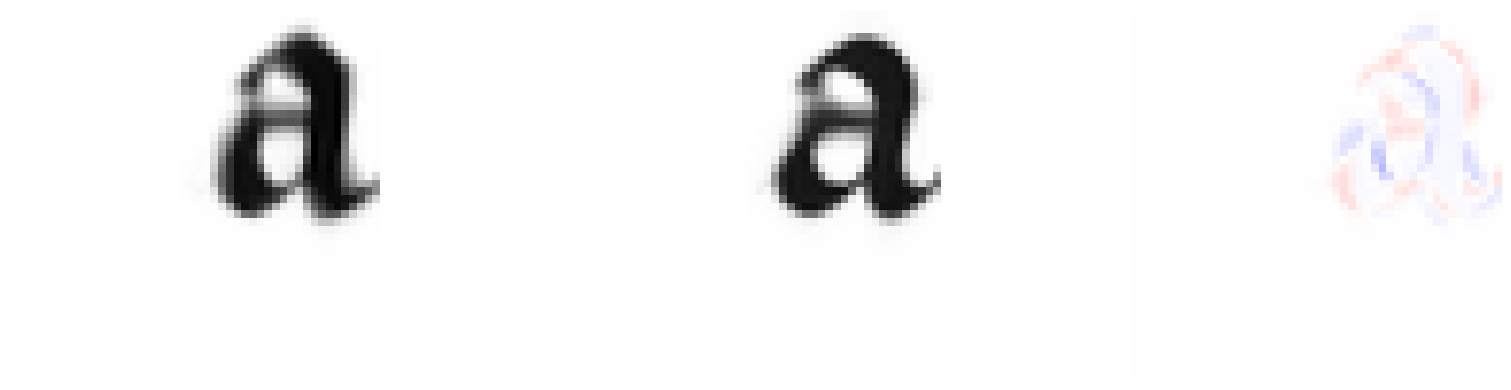

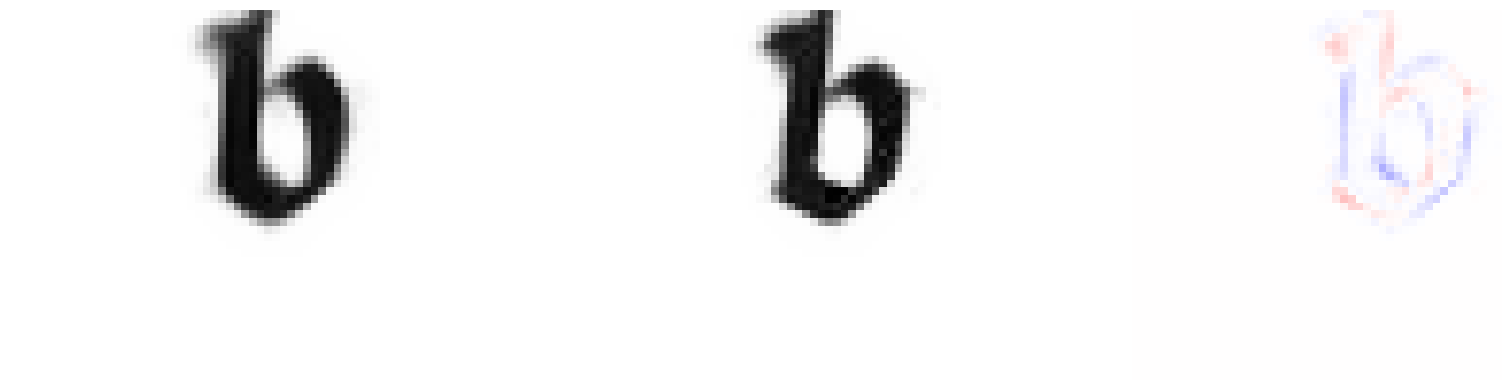

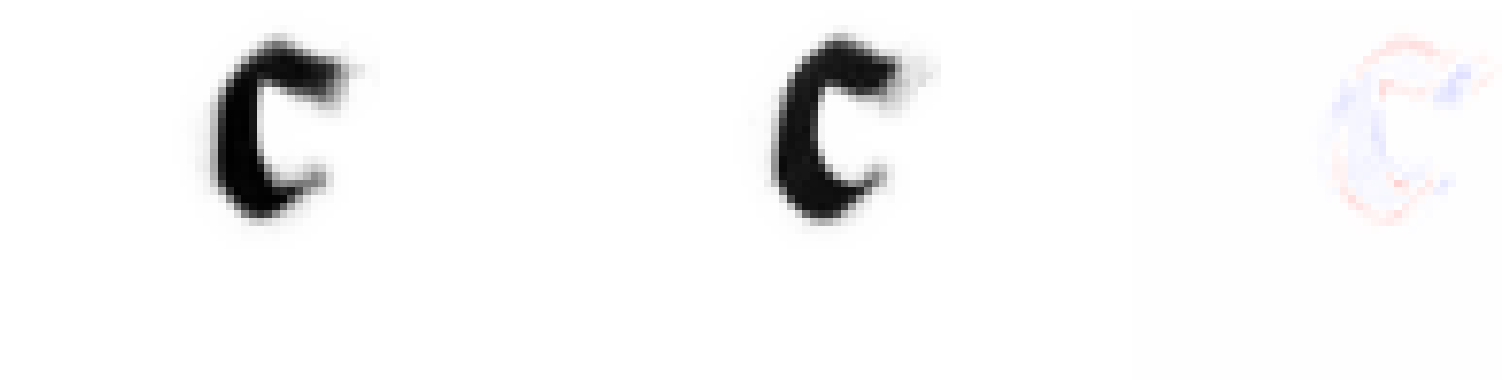

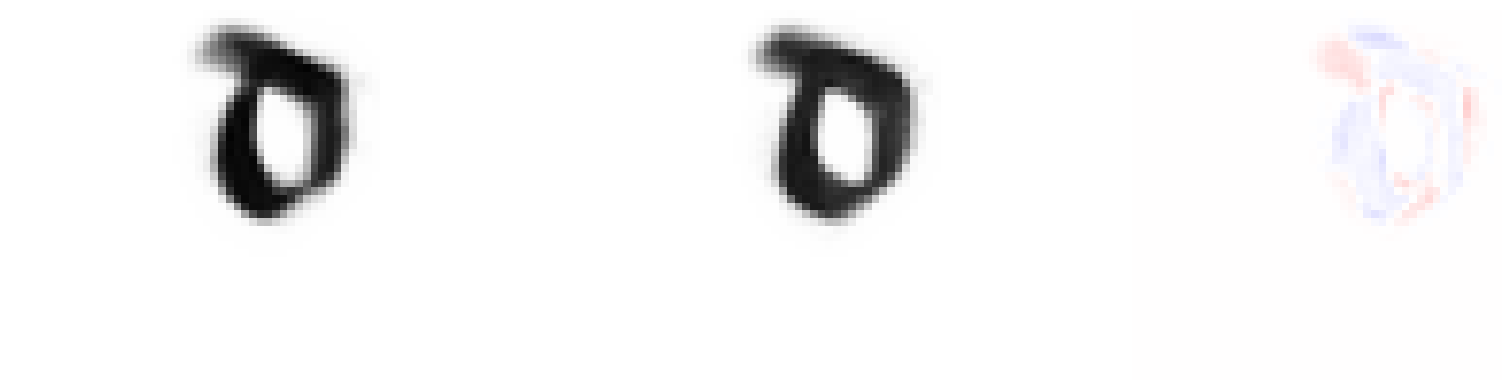

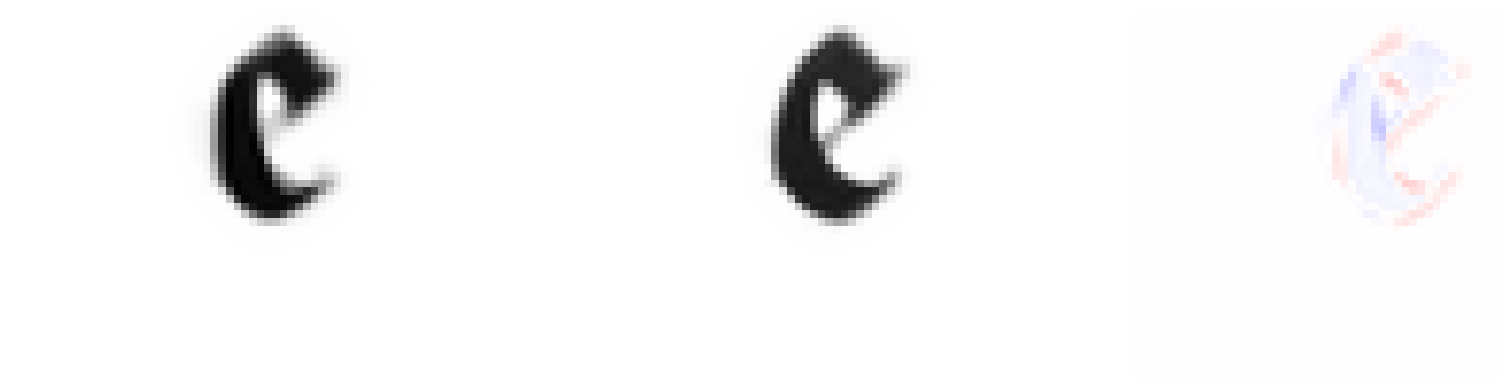

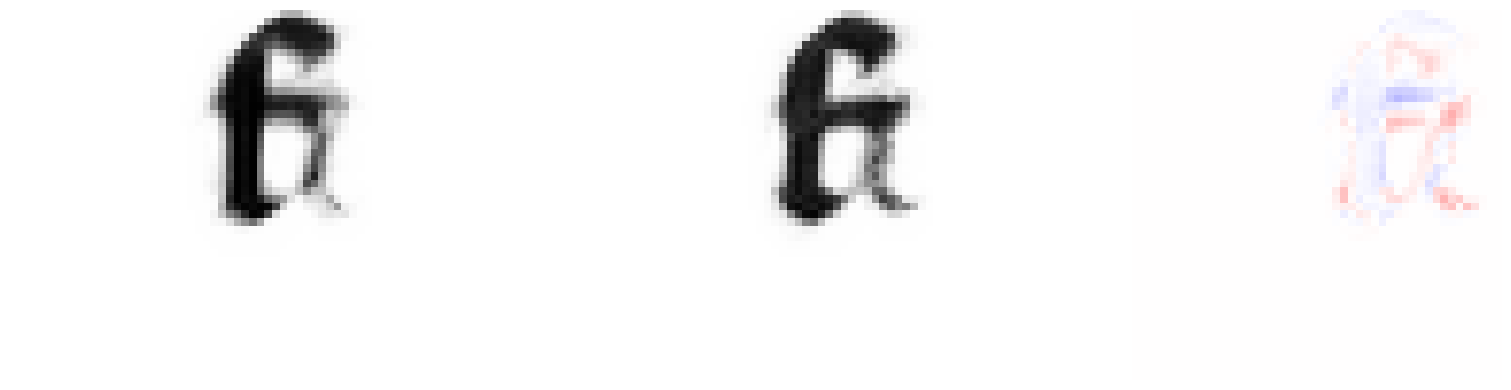

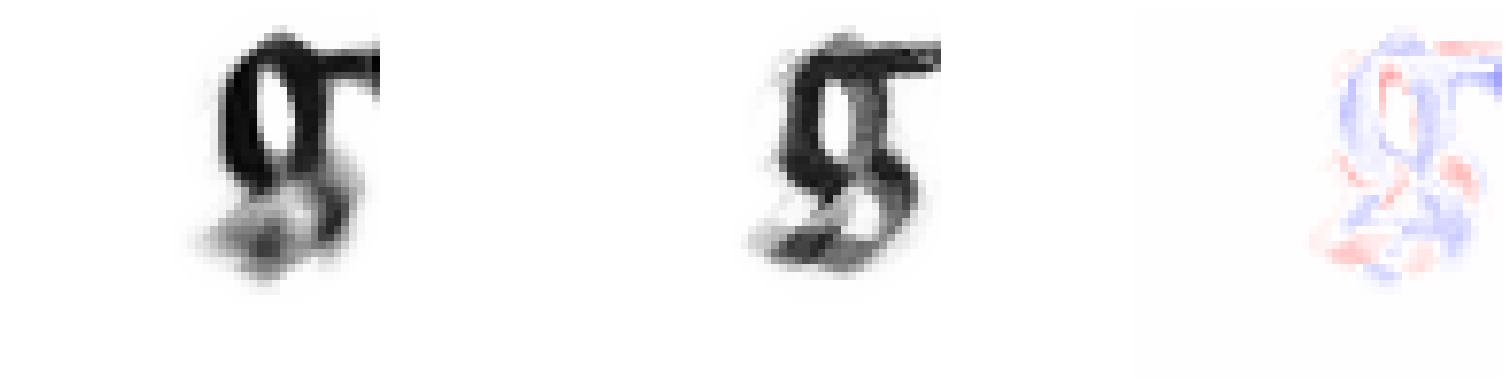

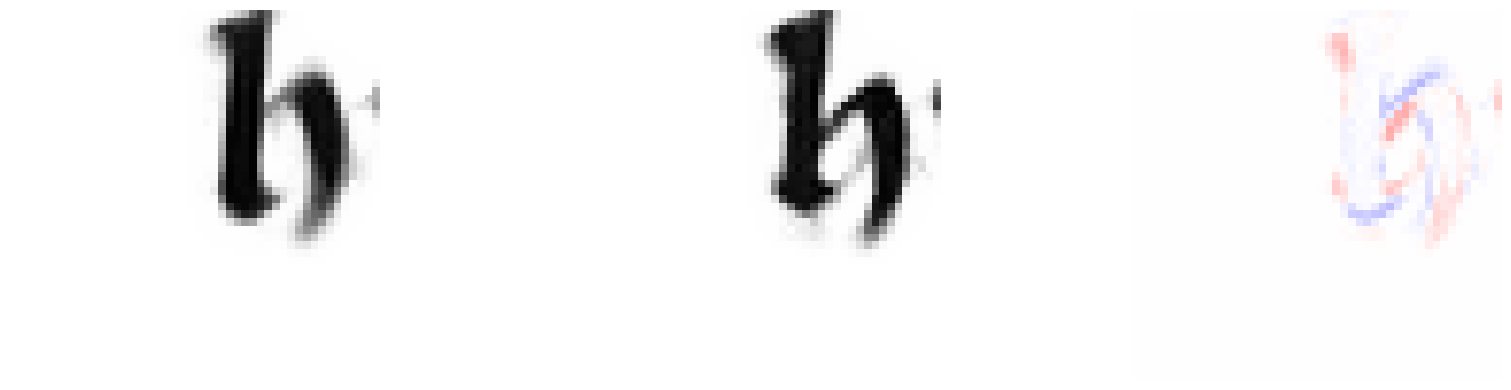

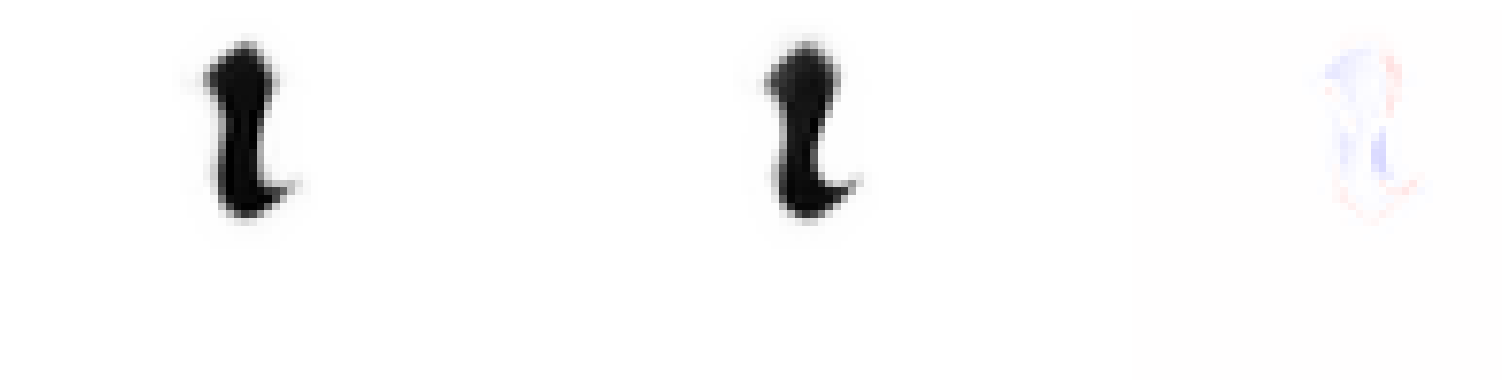

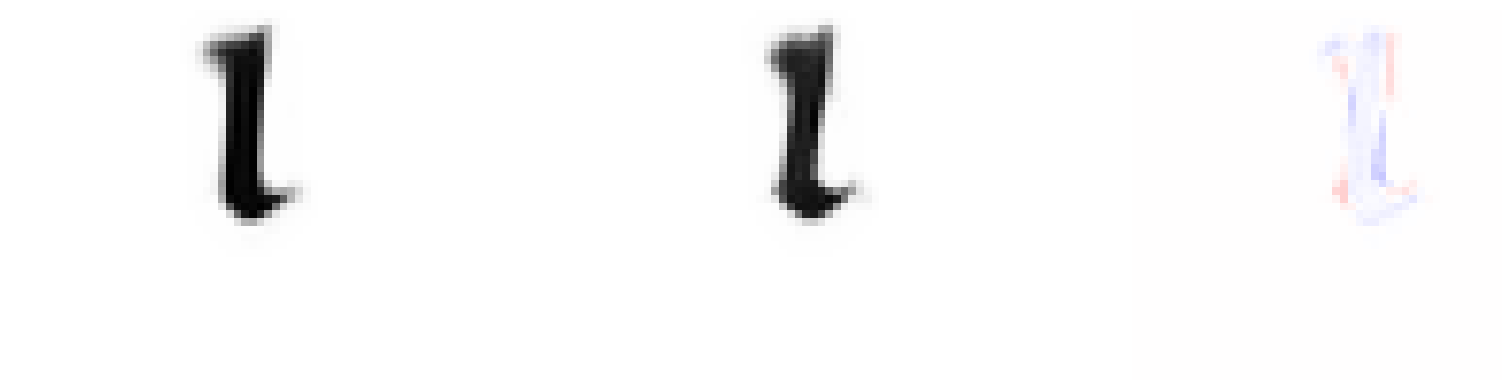

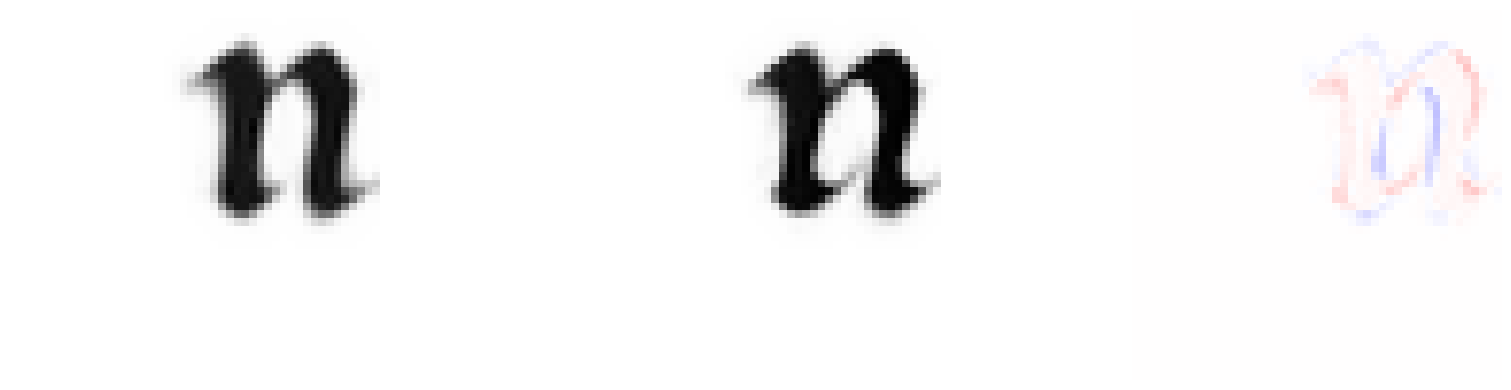

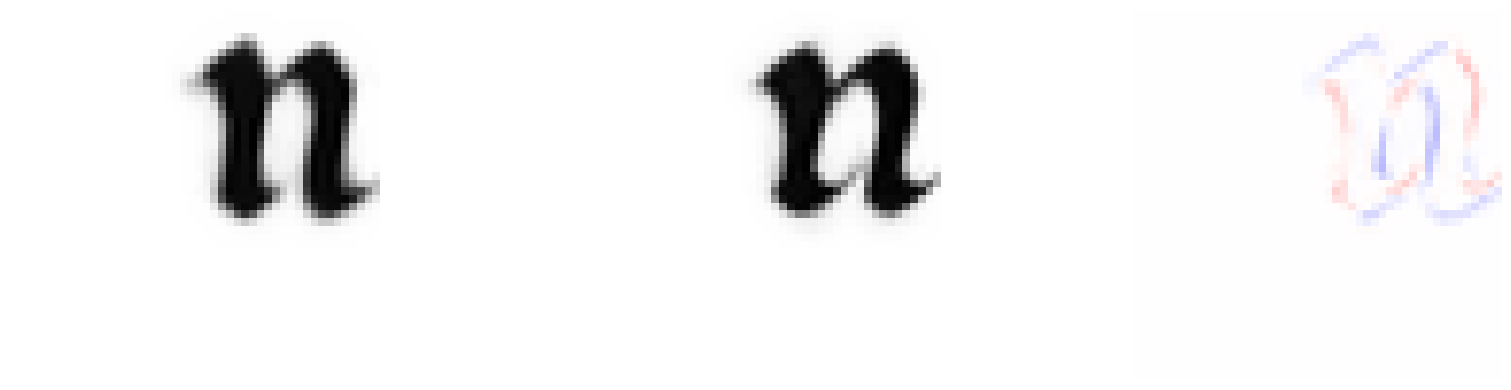

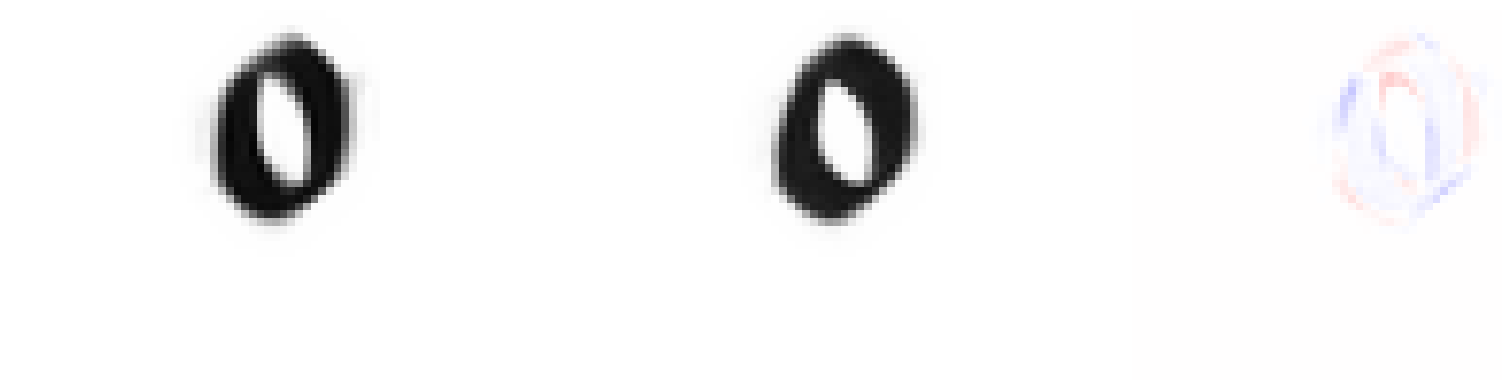

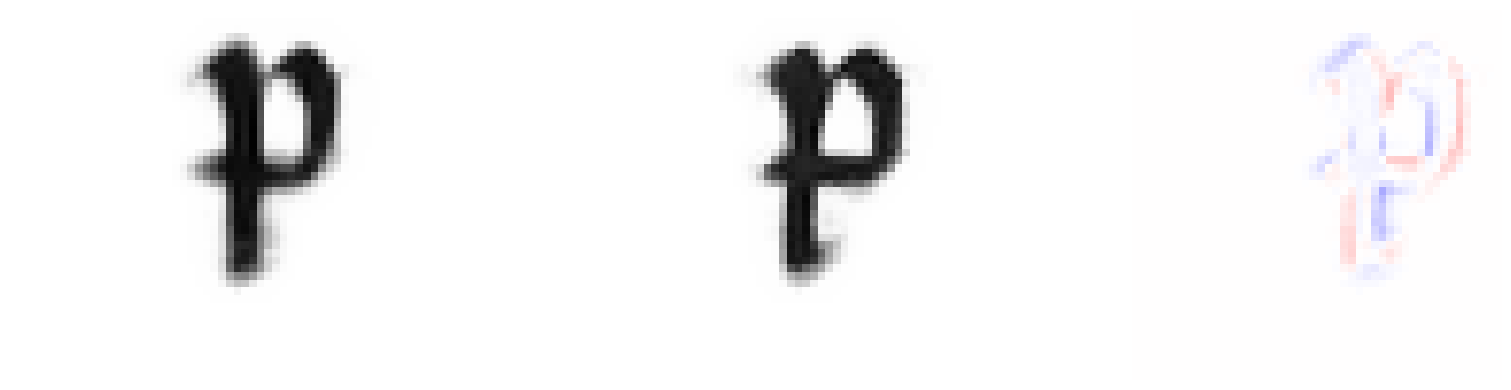

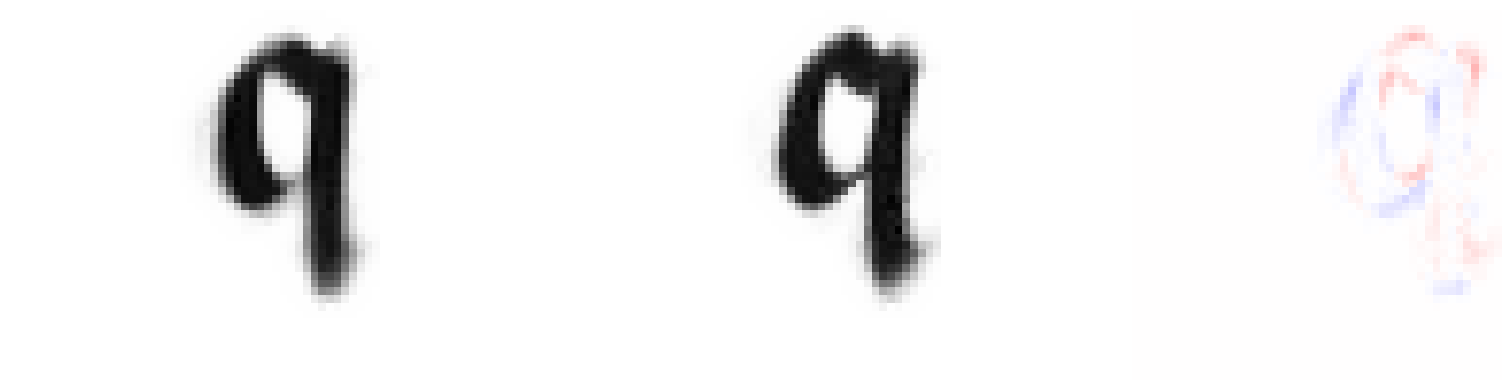

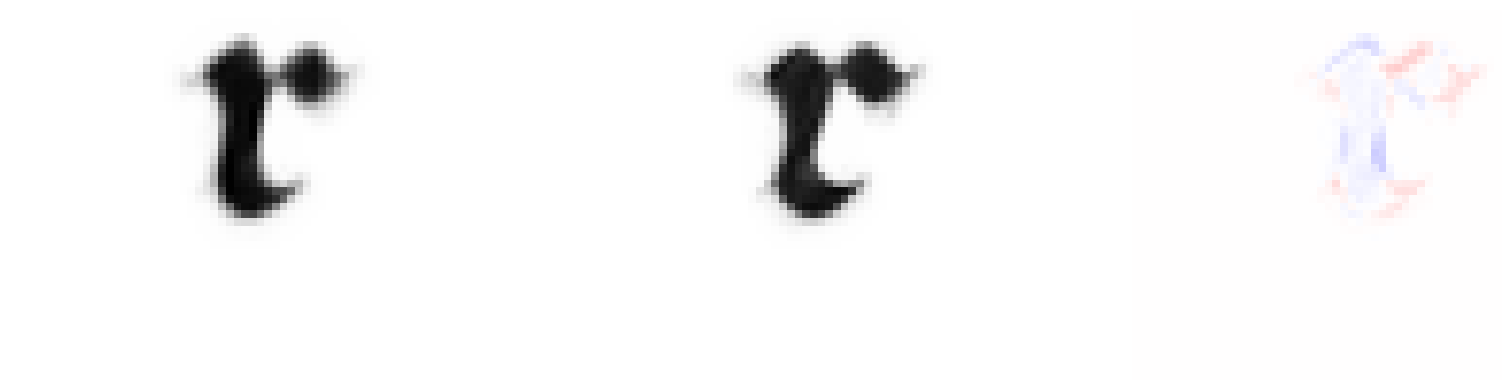

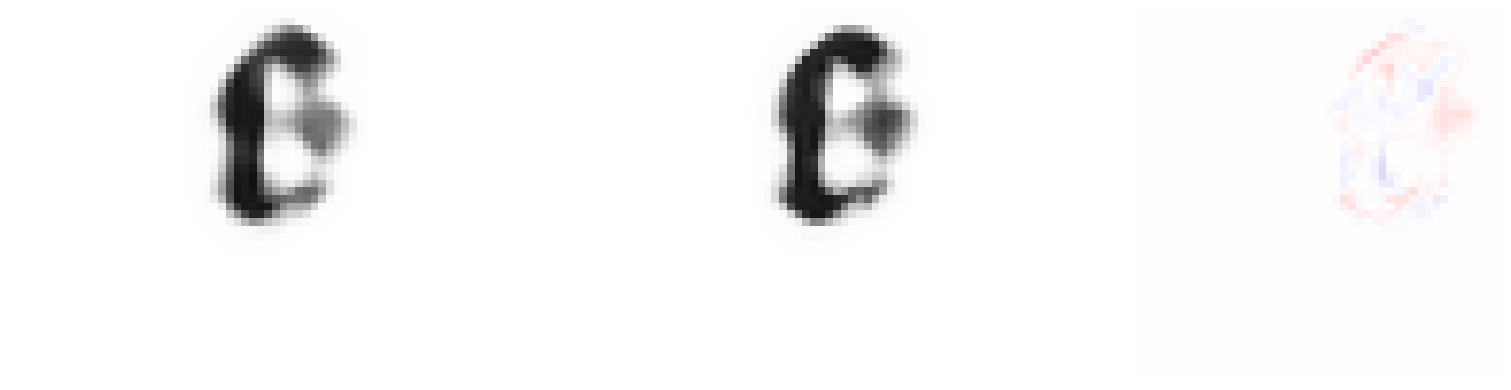

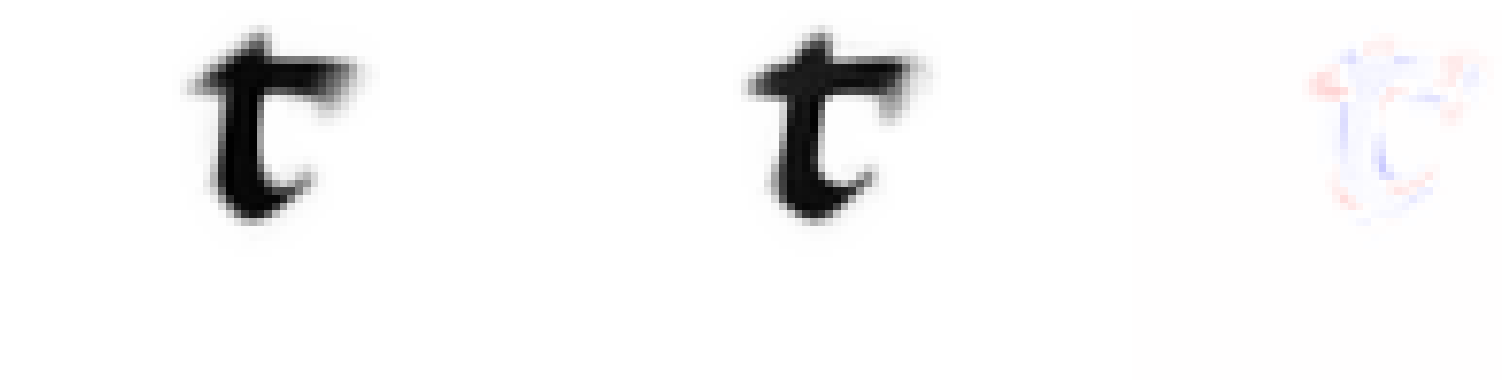

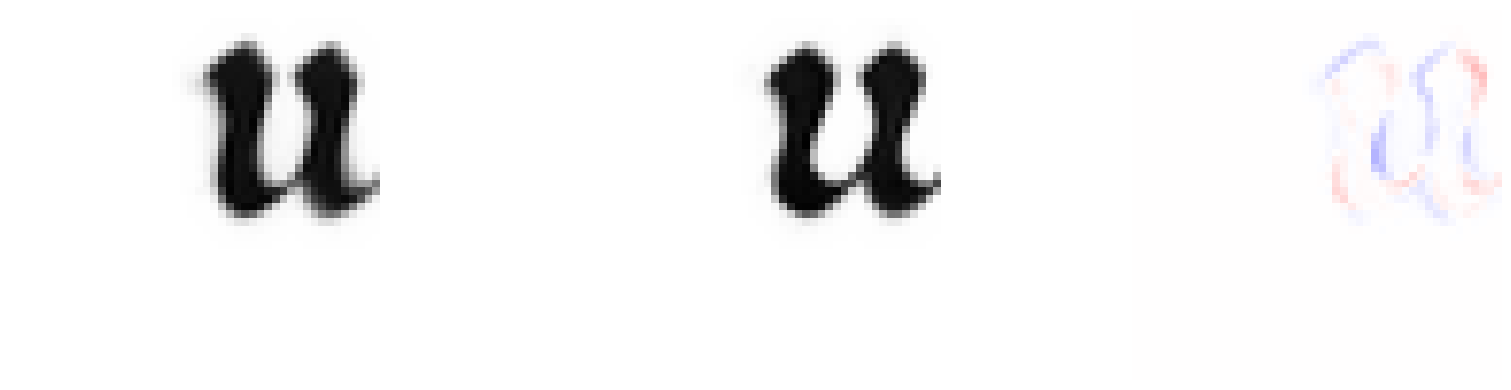

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/btv1b84473026


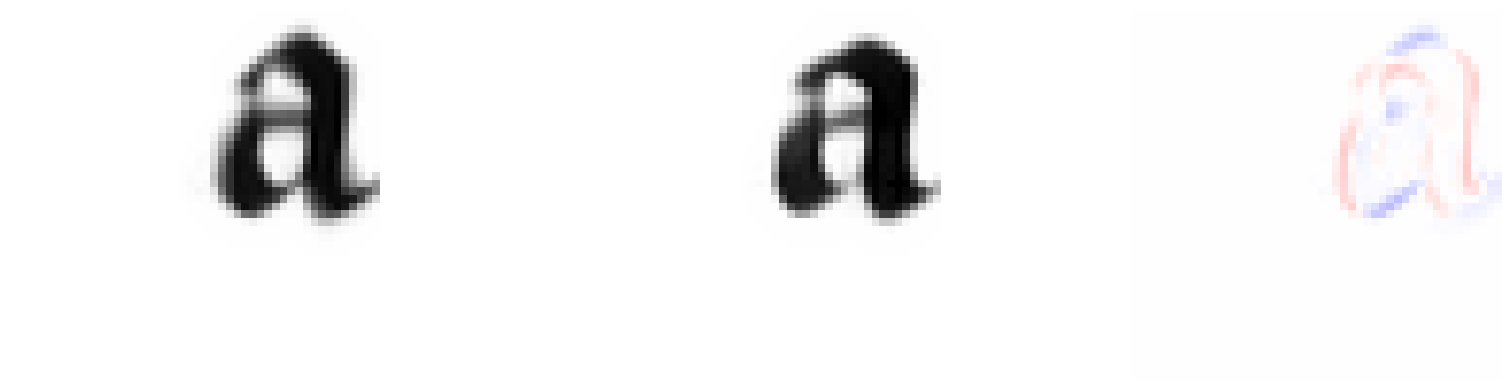

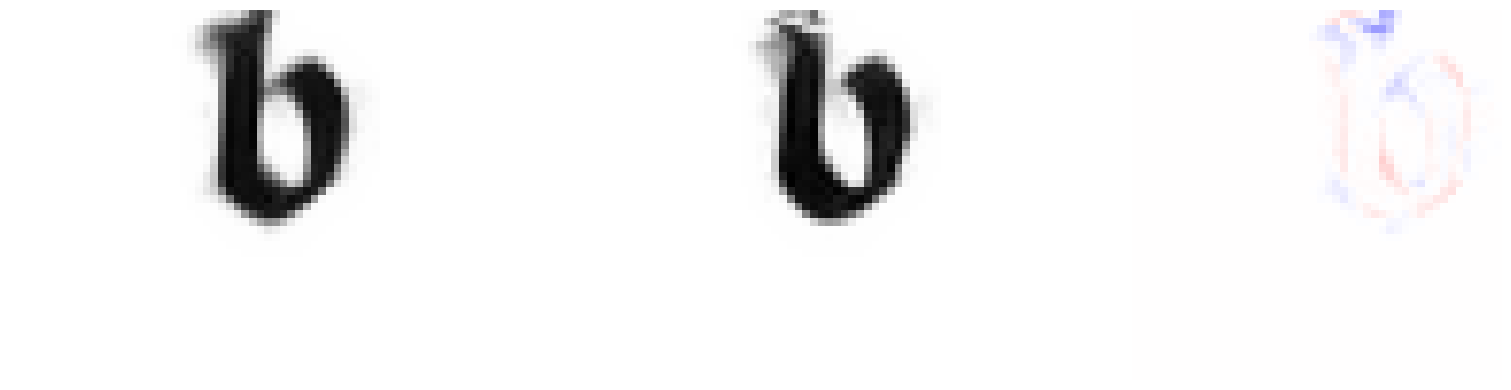

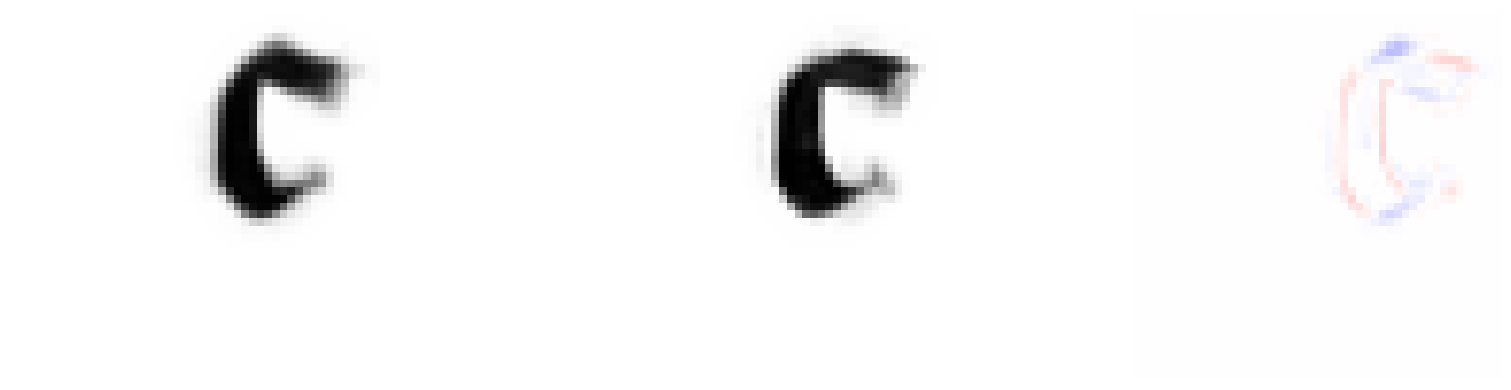

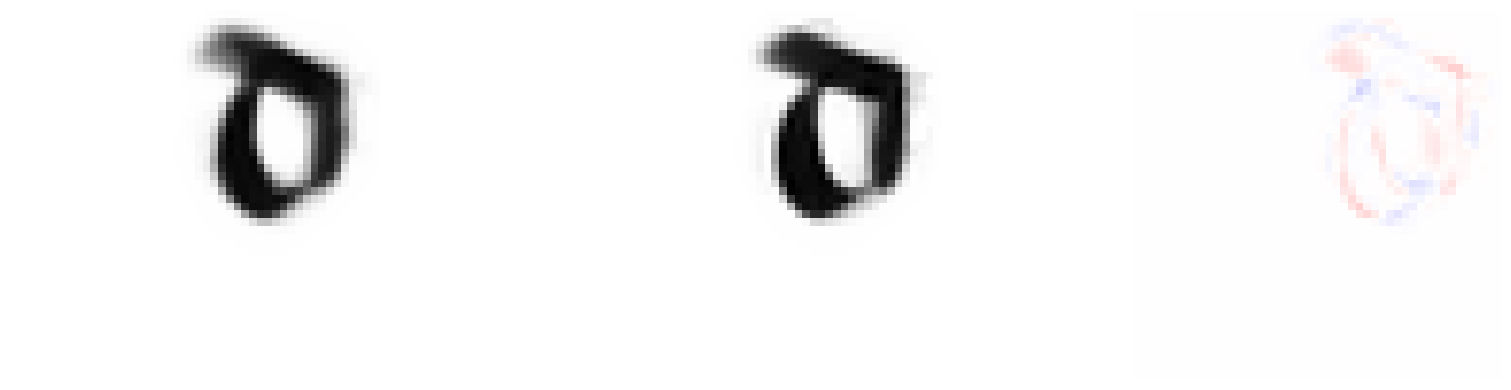

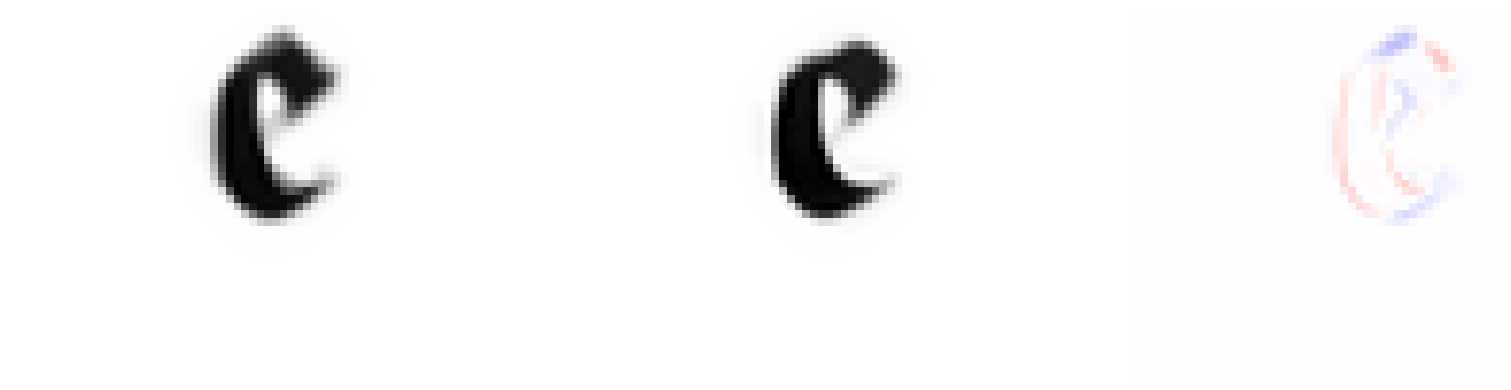

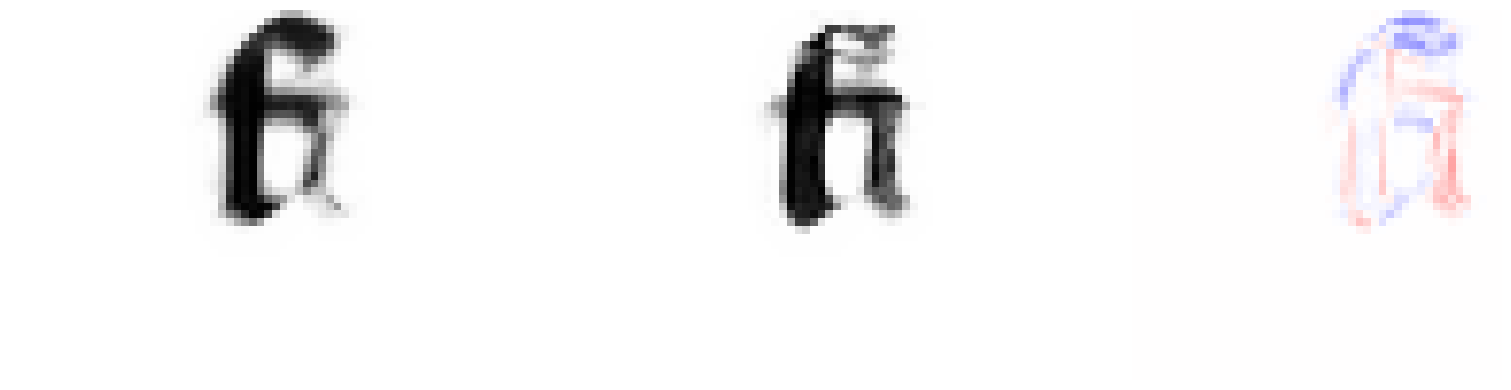

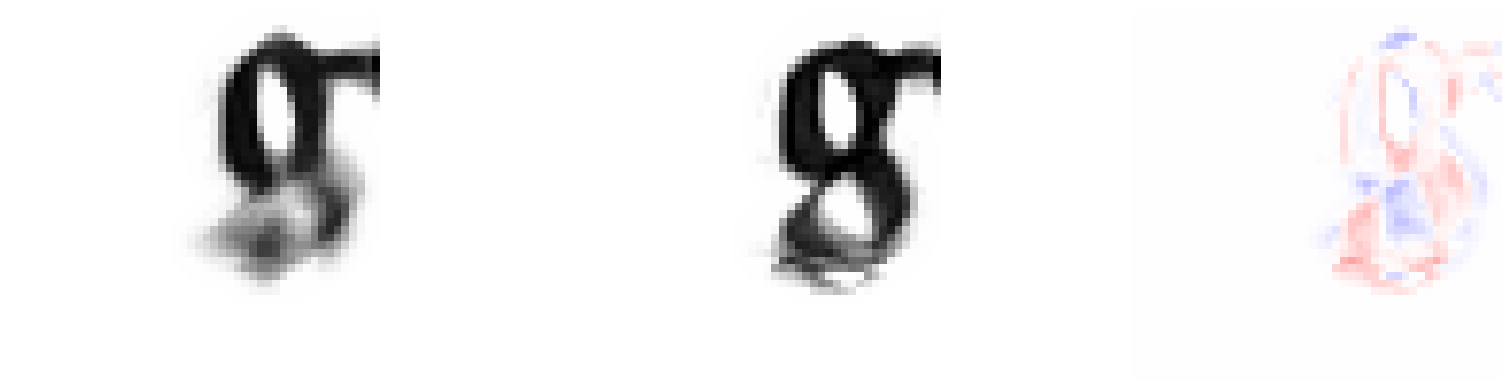

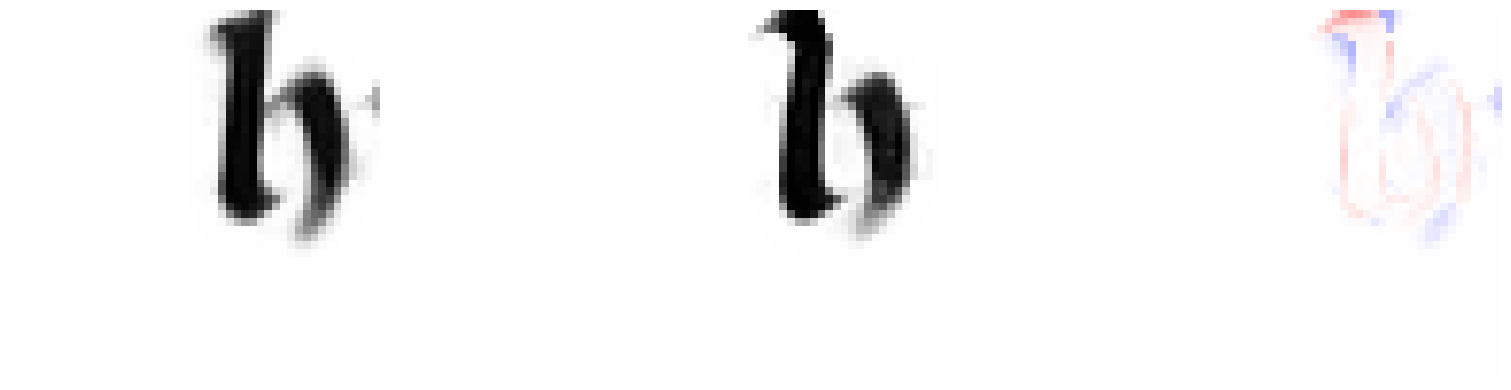

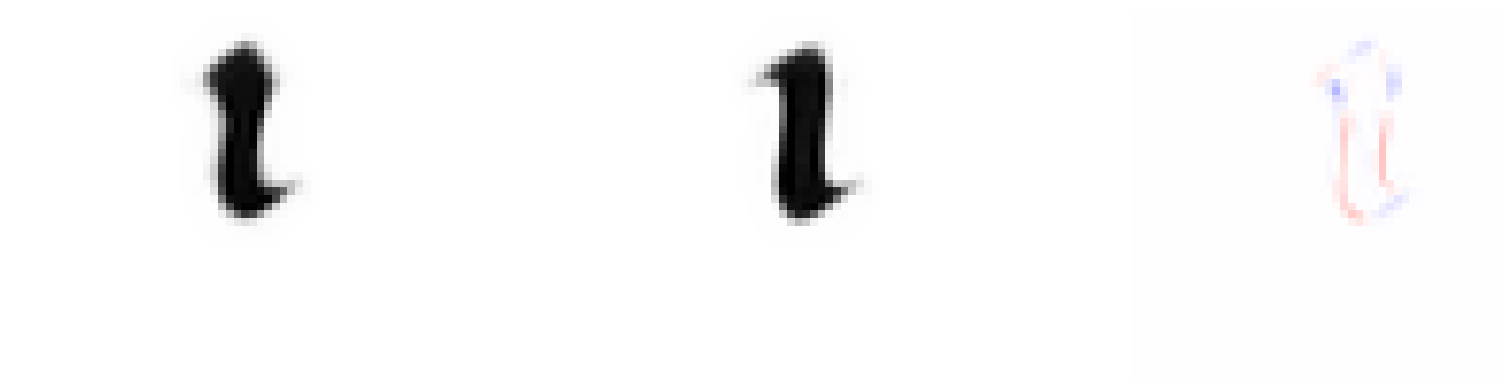

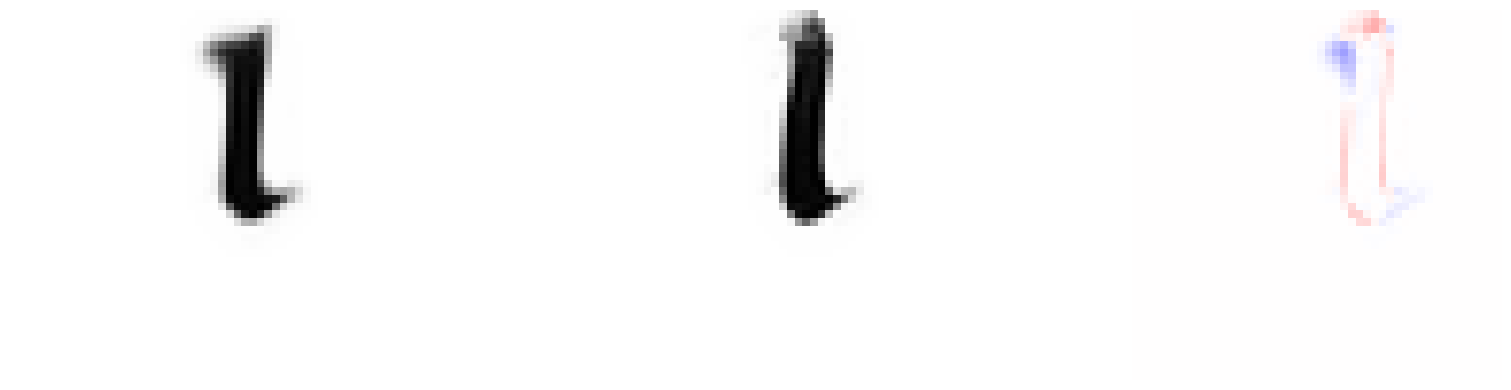

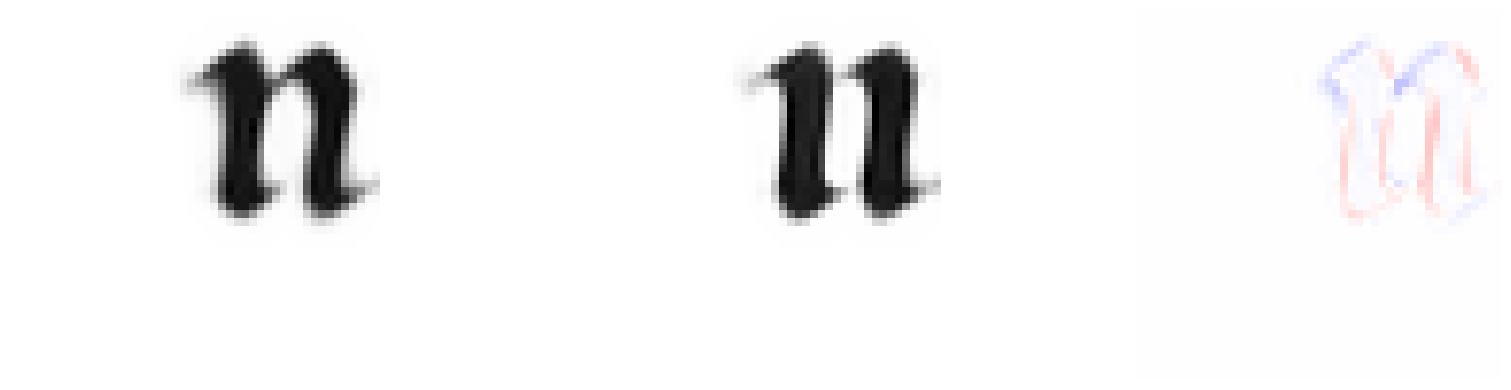

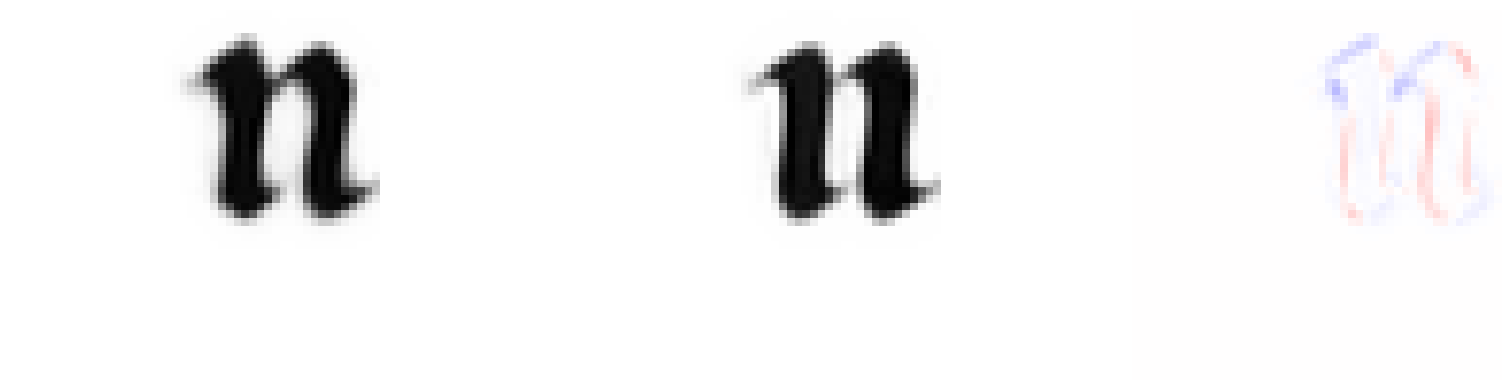

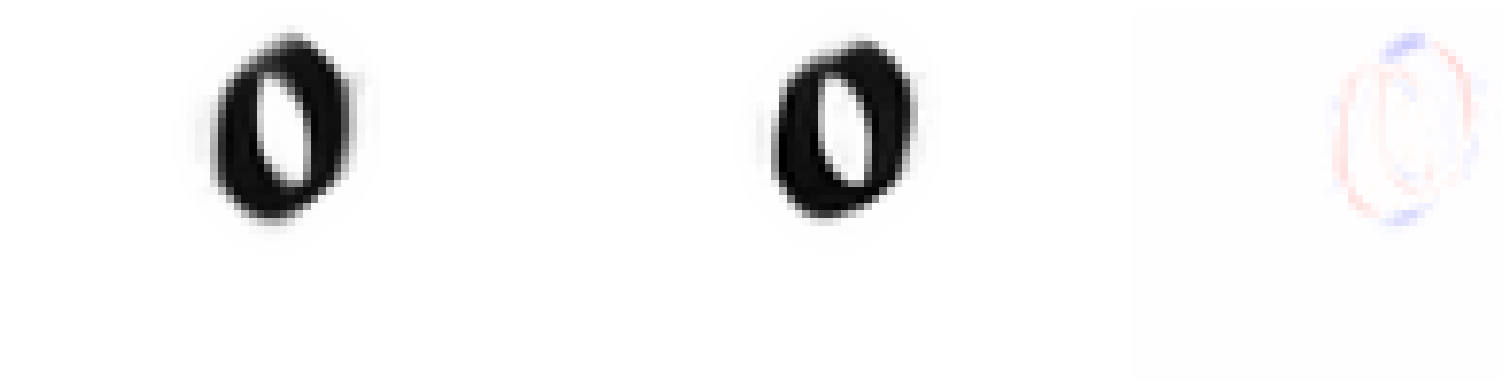

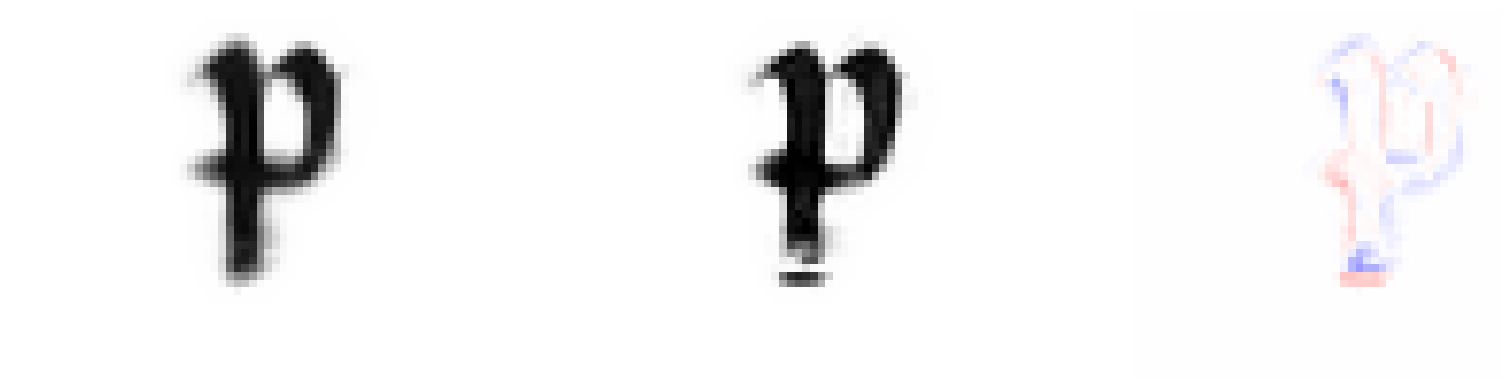

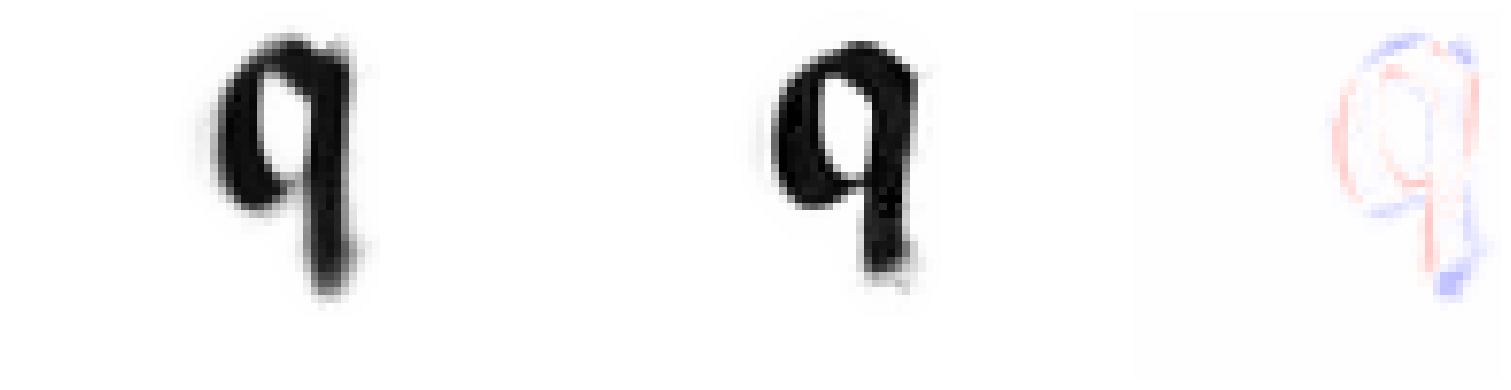

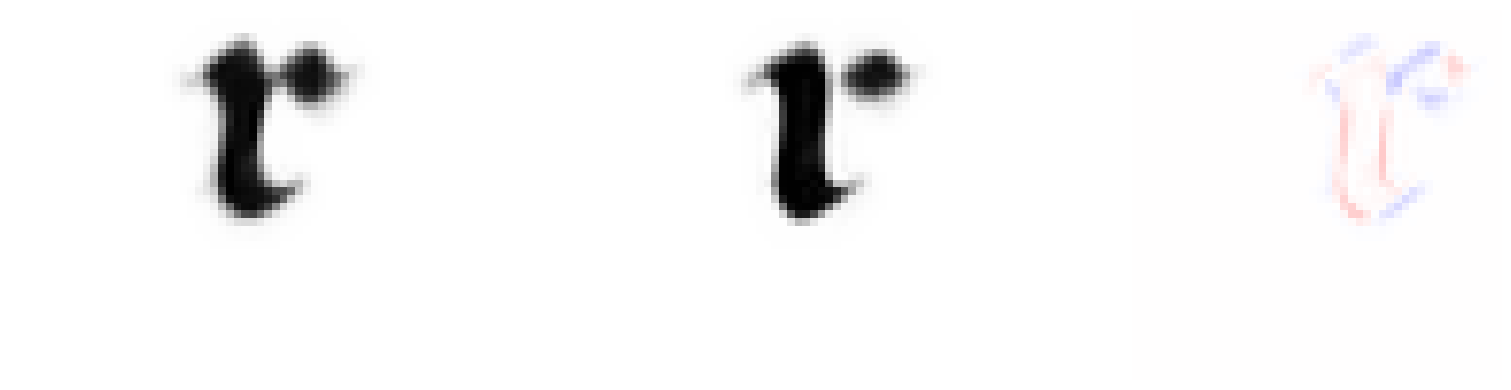

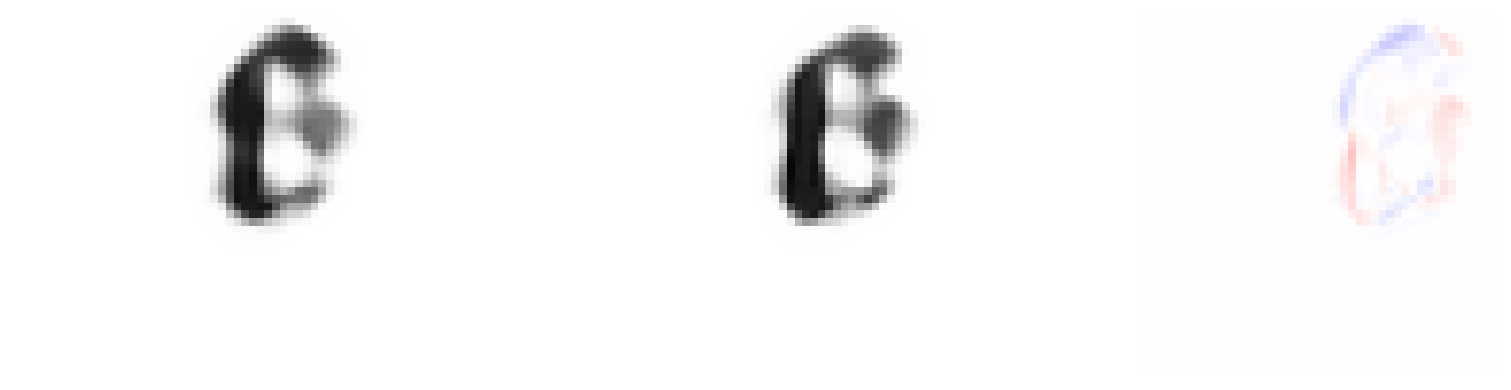

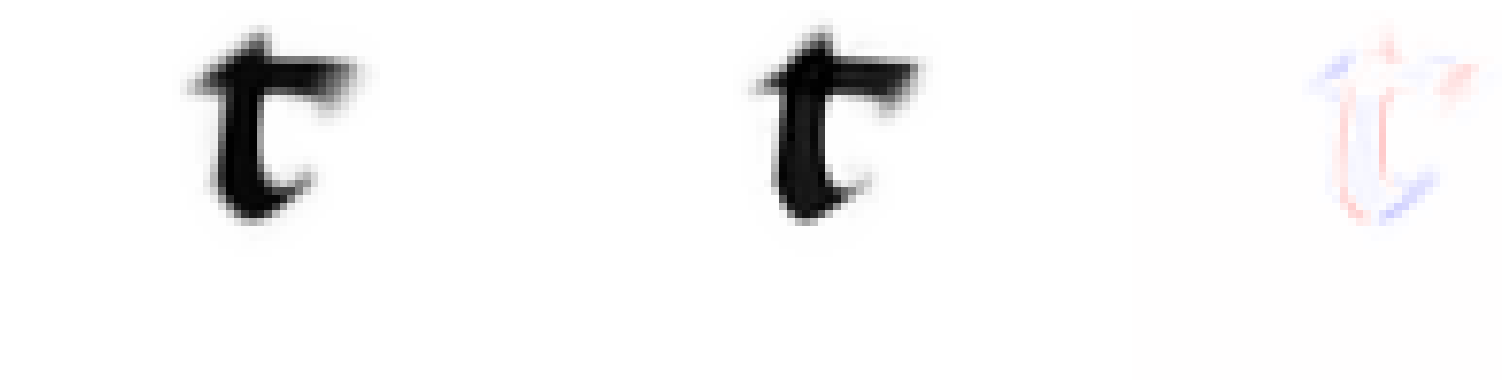

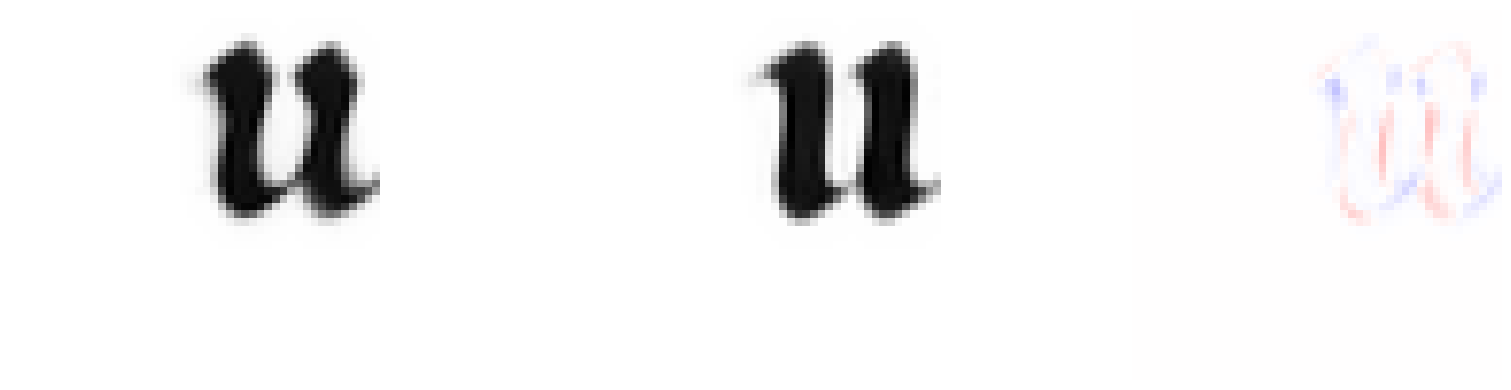

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/btv1b8455783p


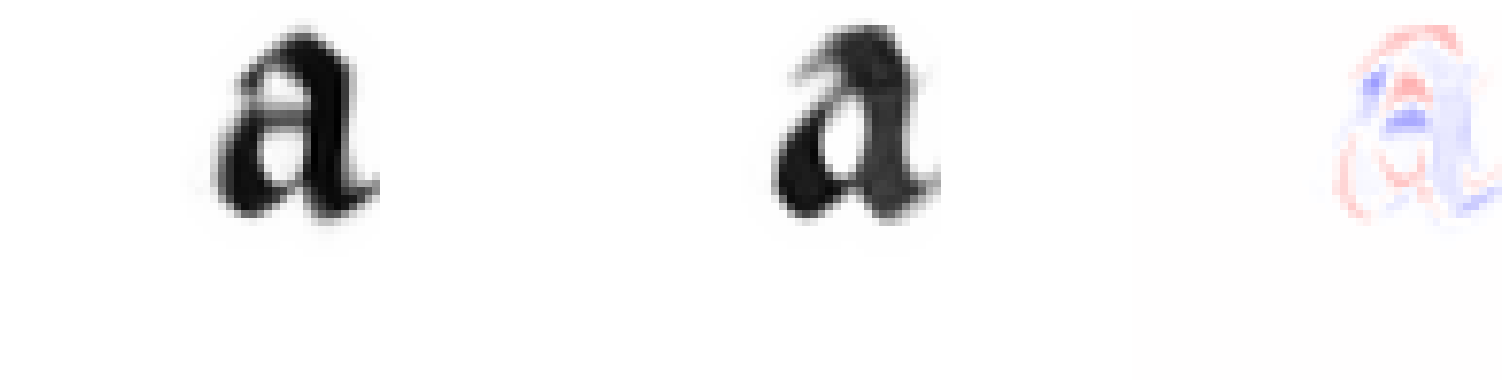

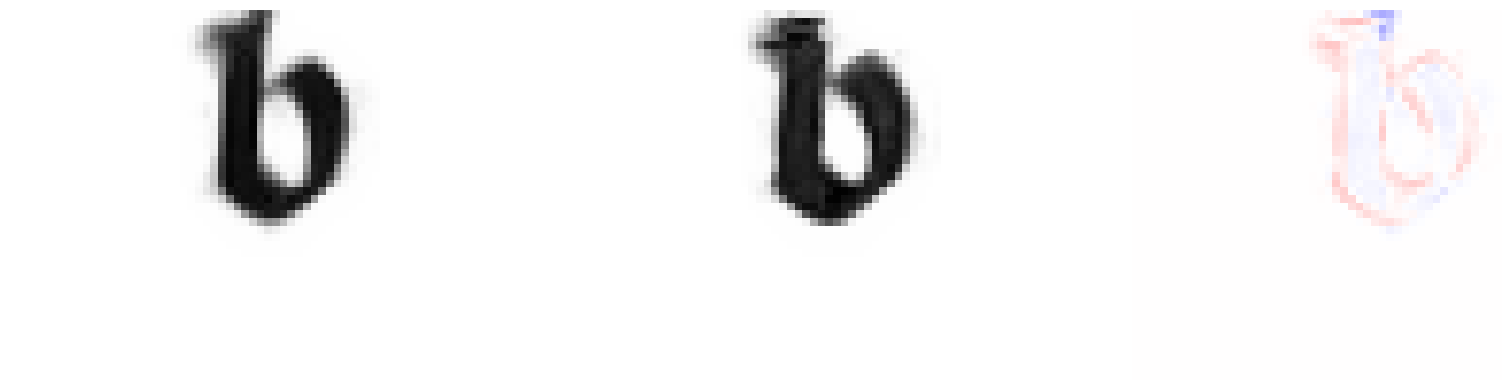

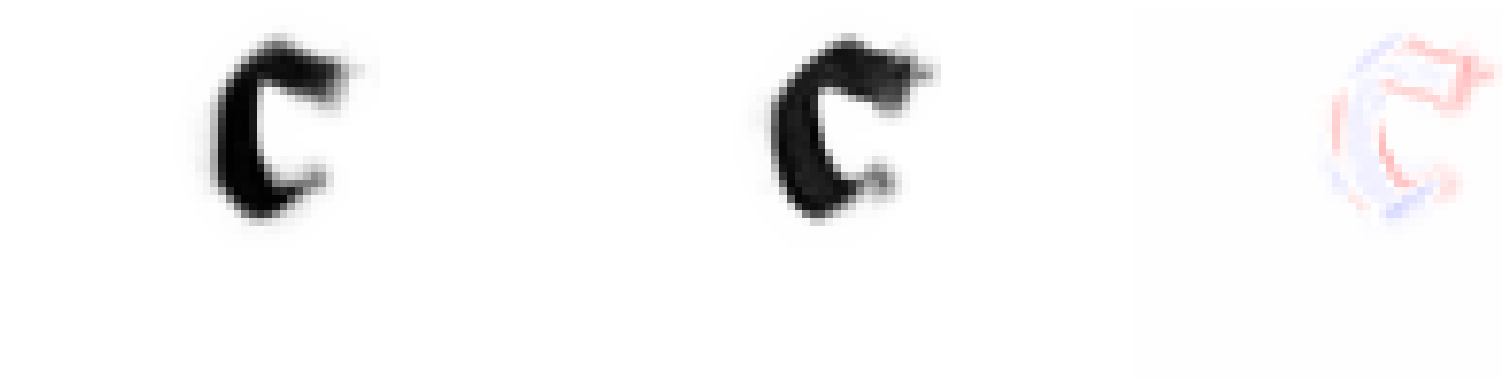

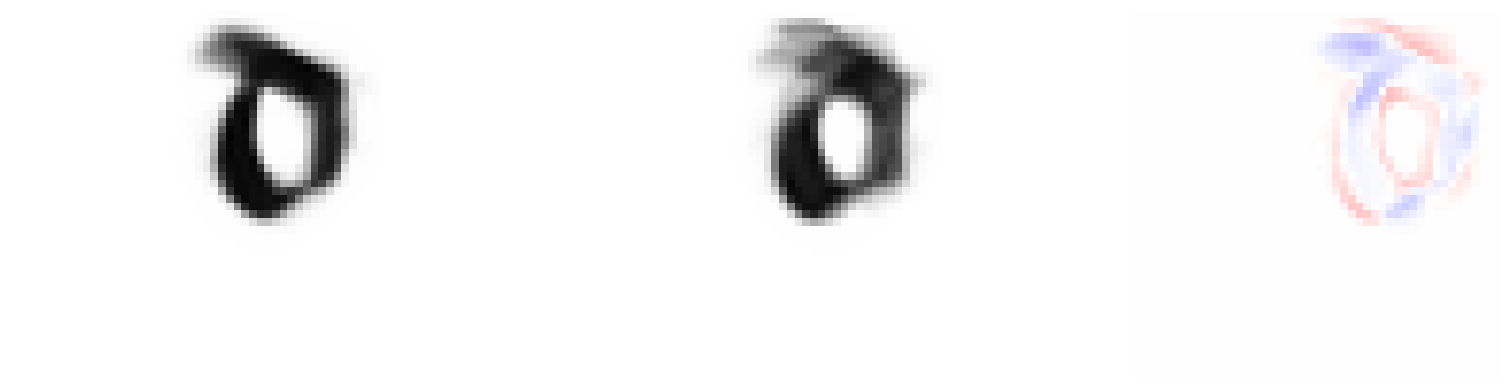

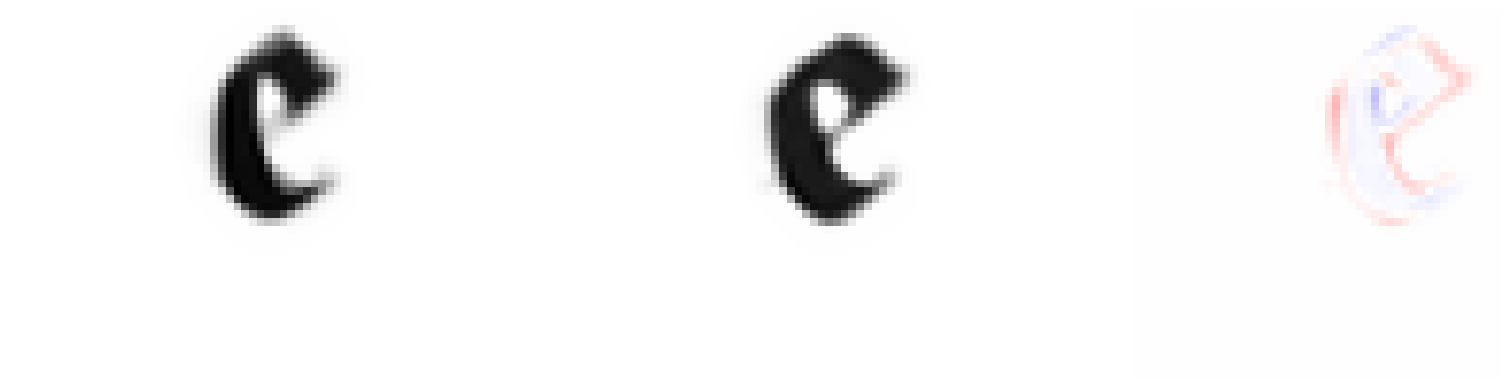

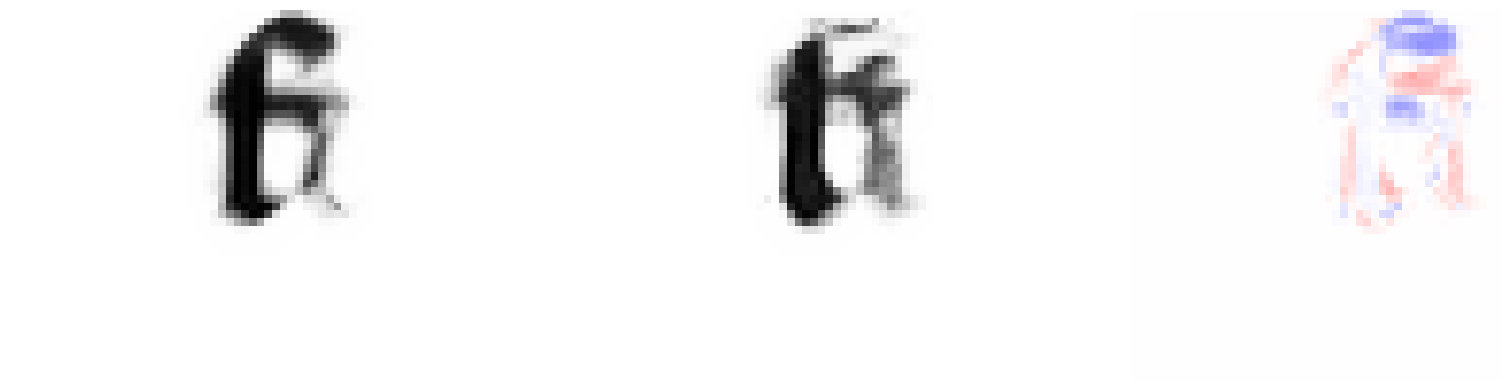

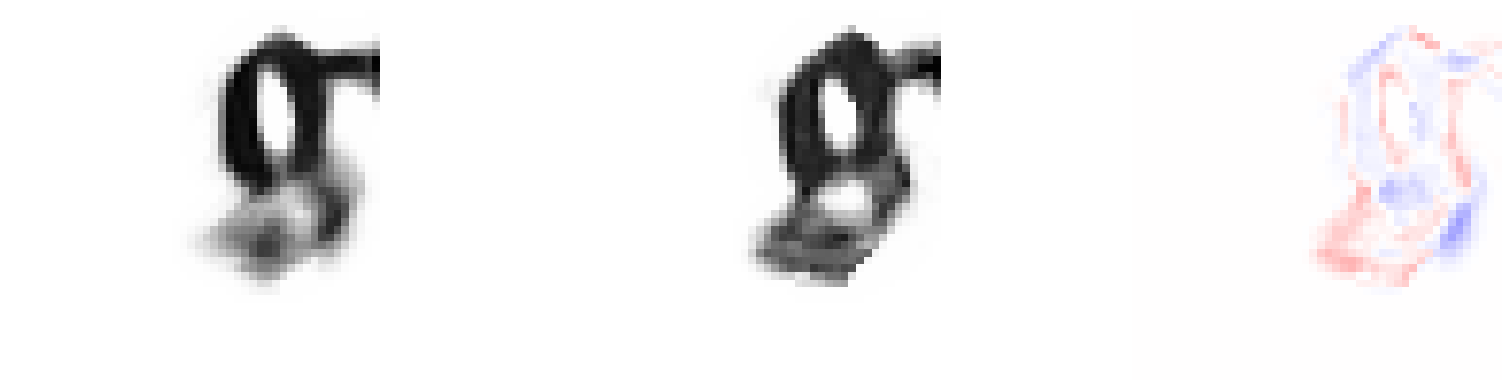

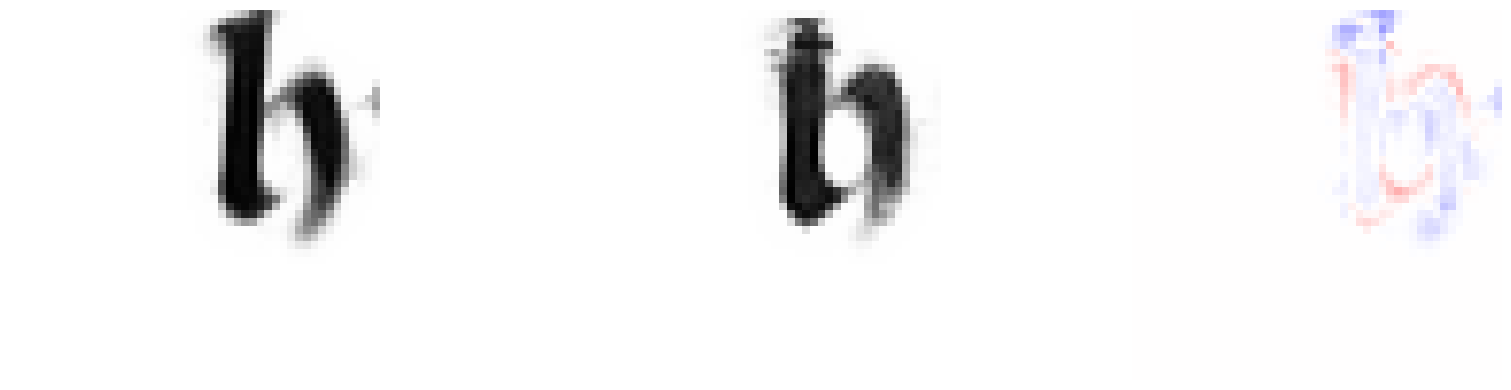

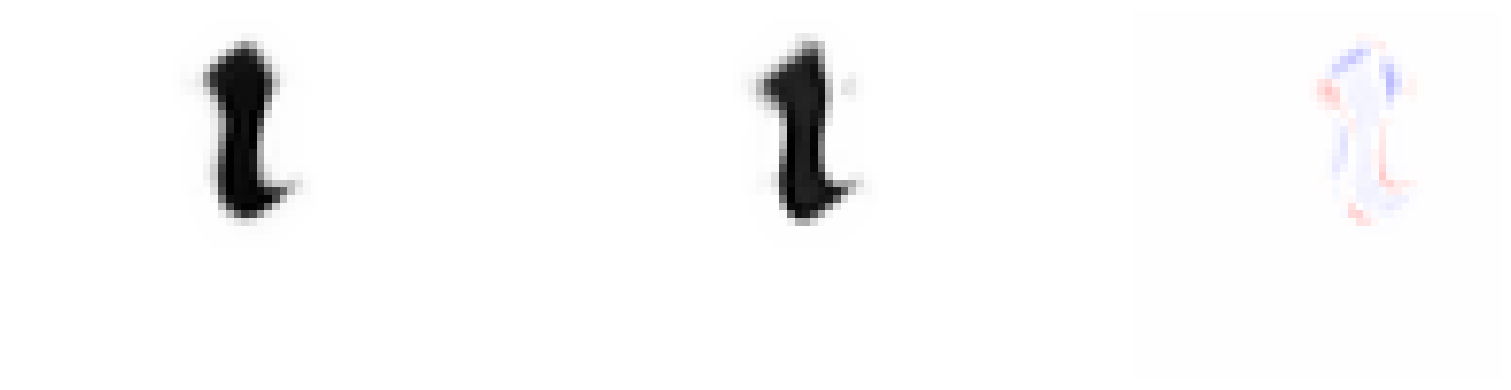

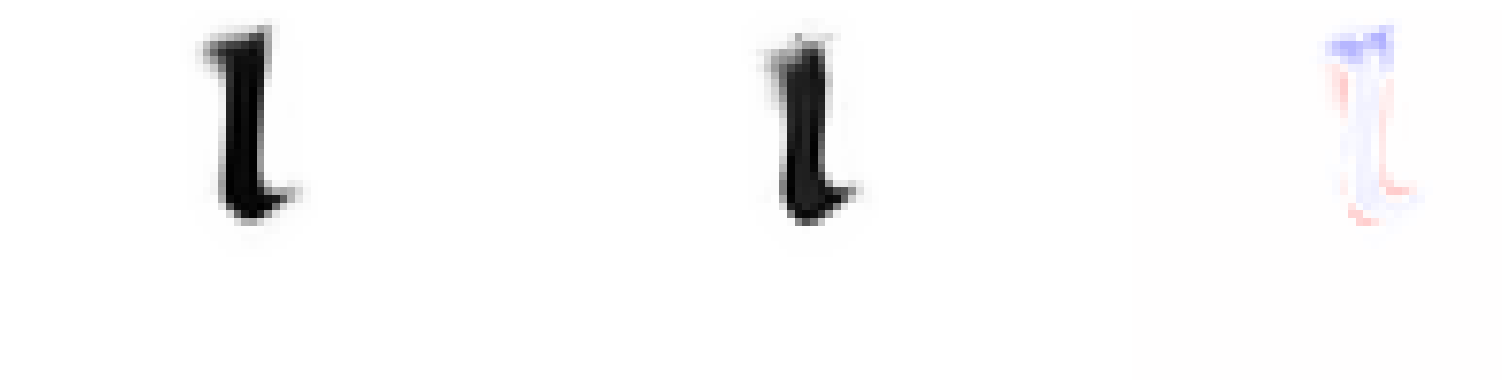

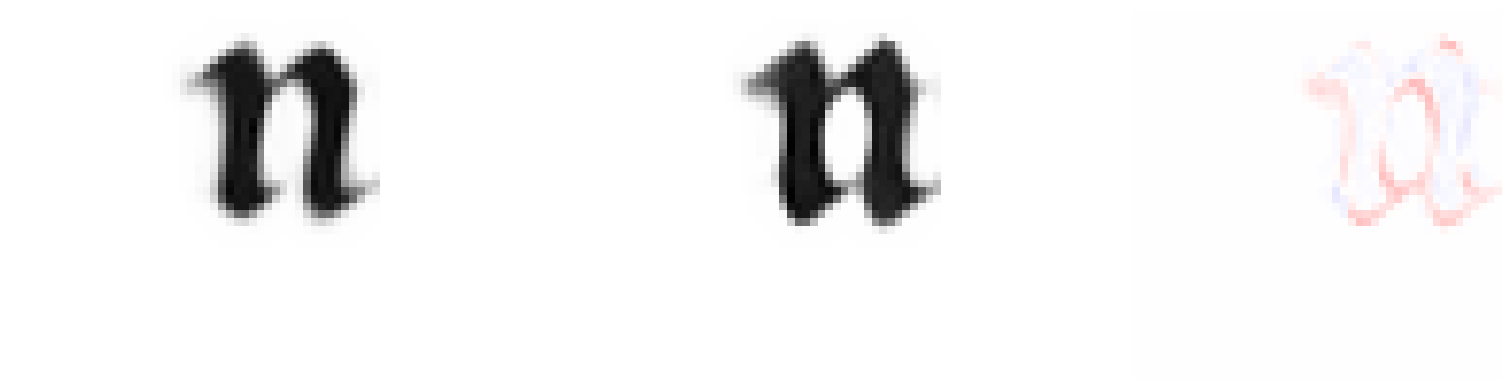

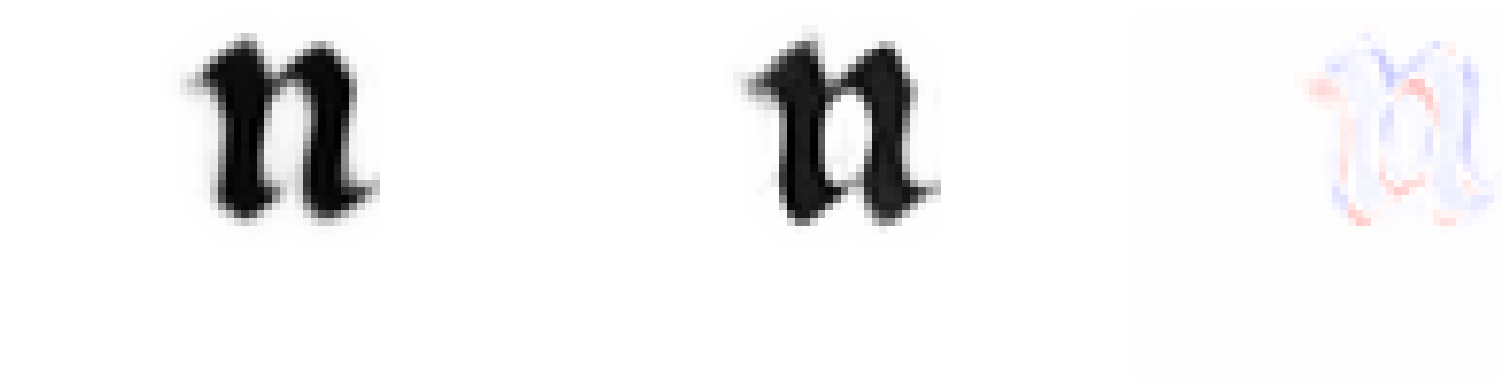

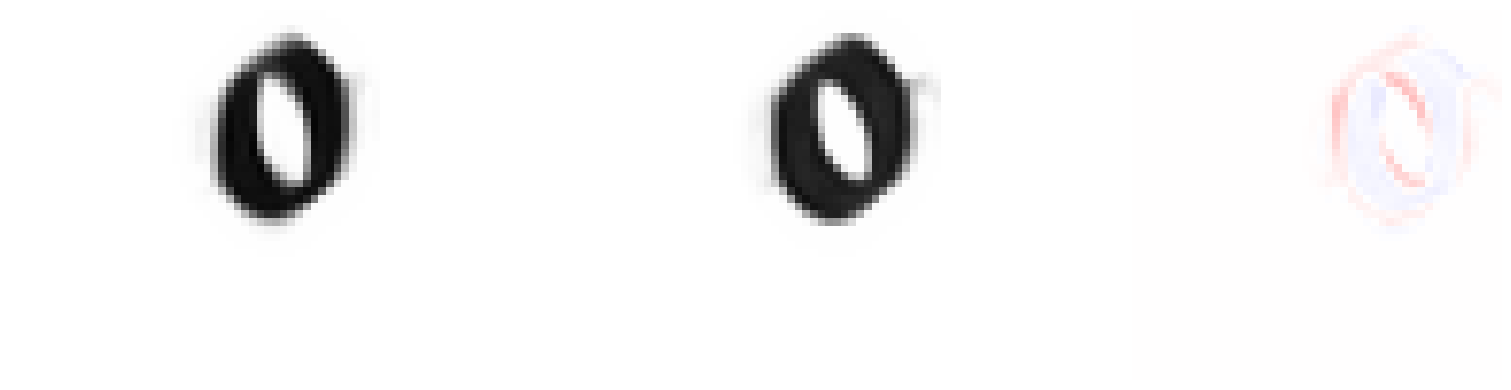

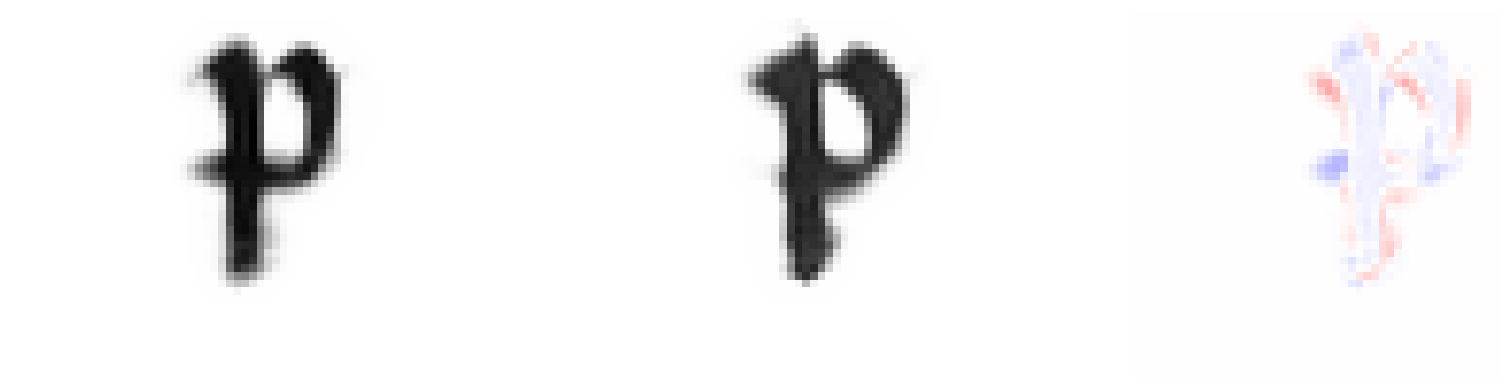

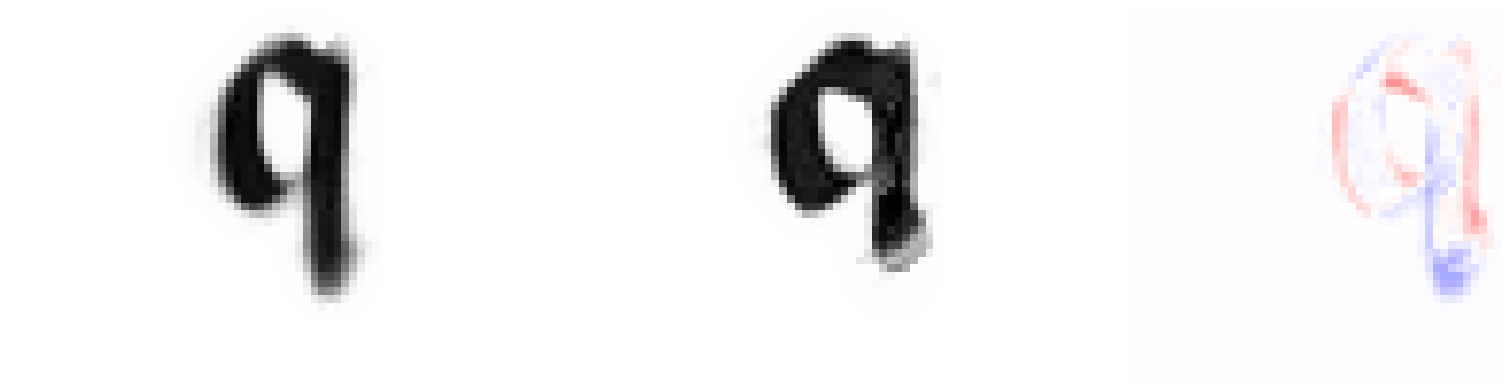

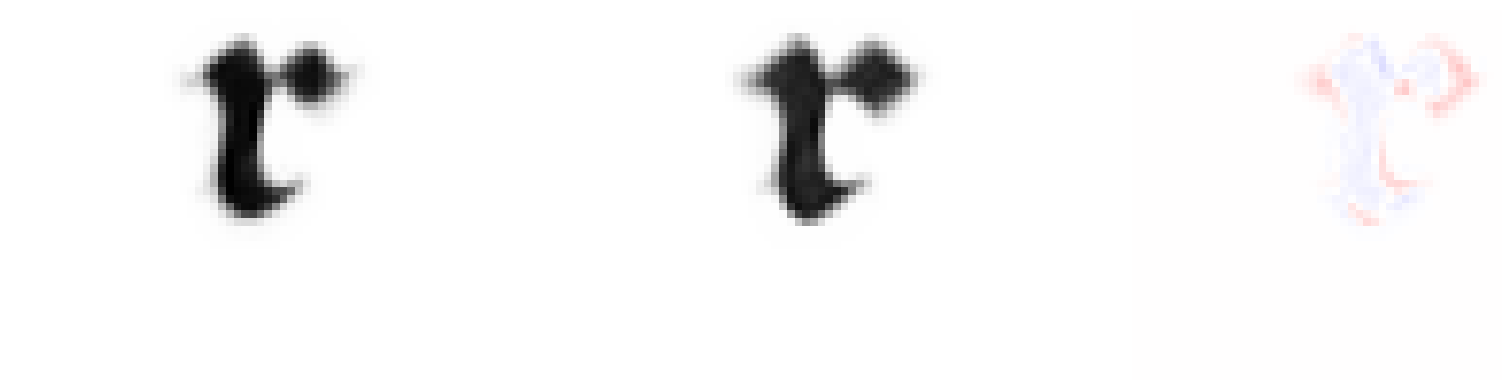

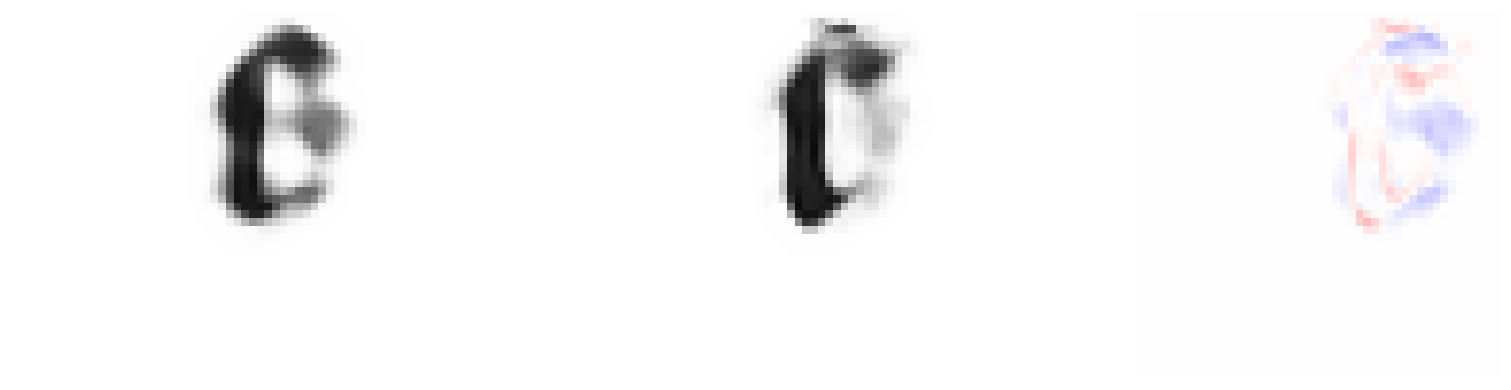

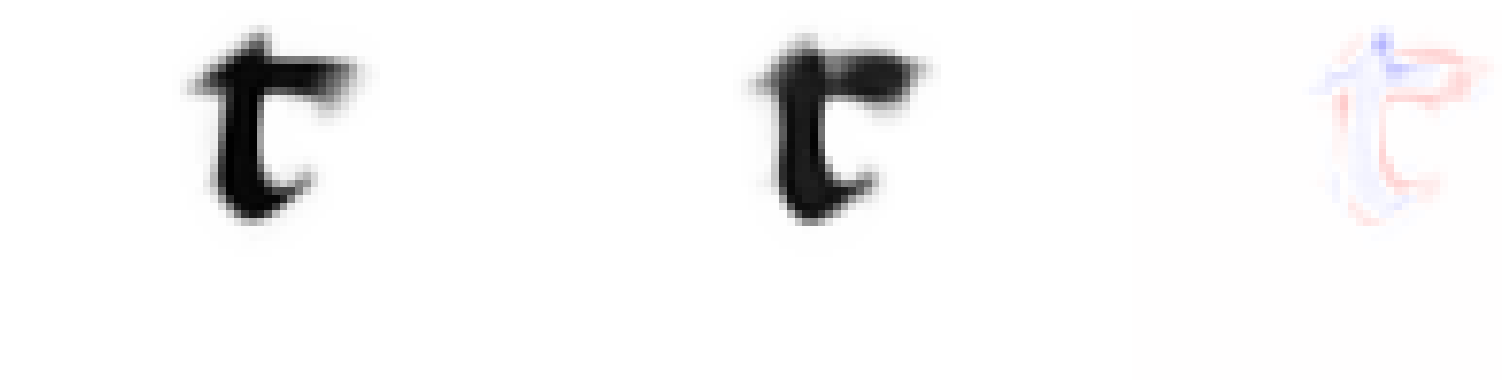

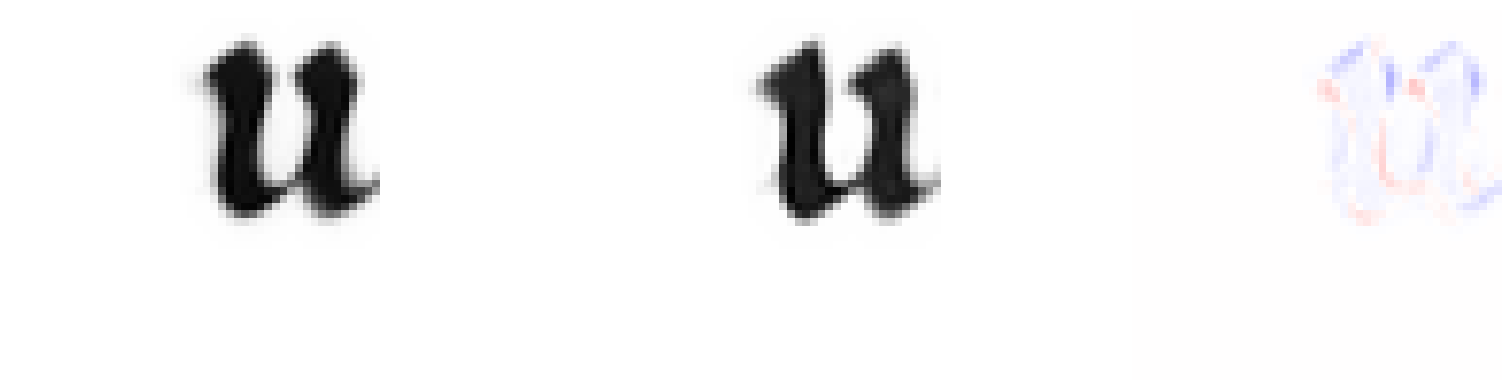

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/btv1b55006072j


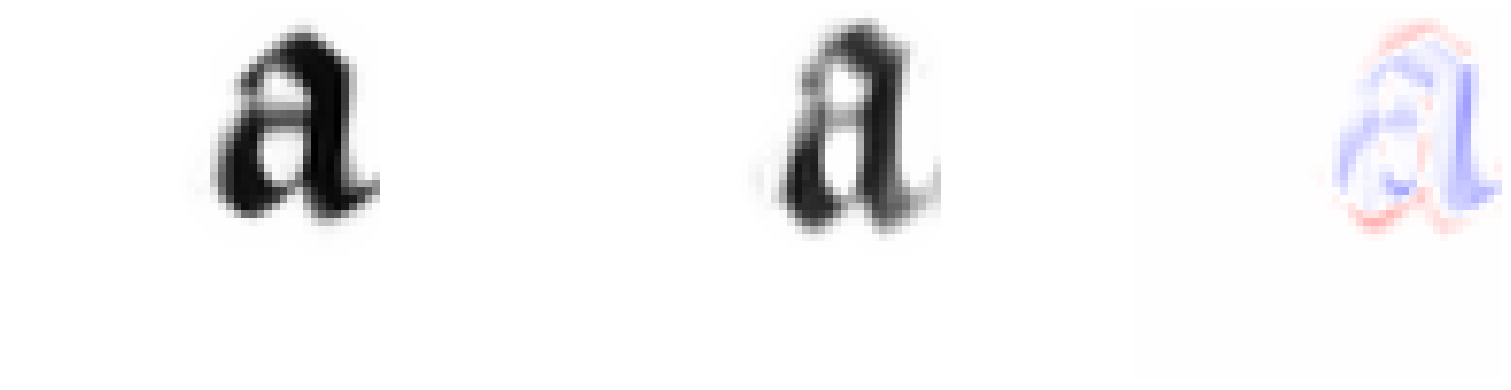

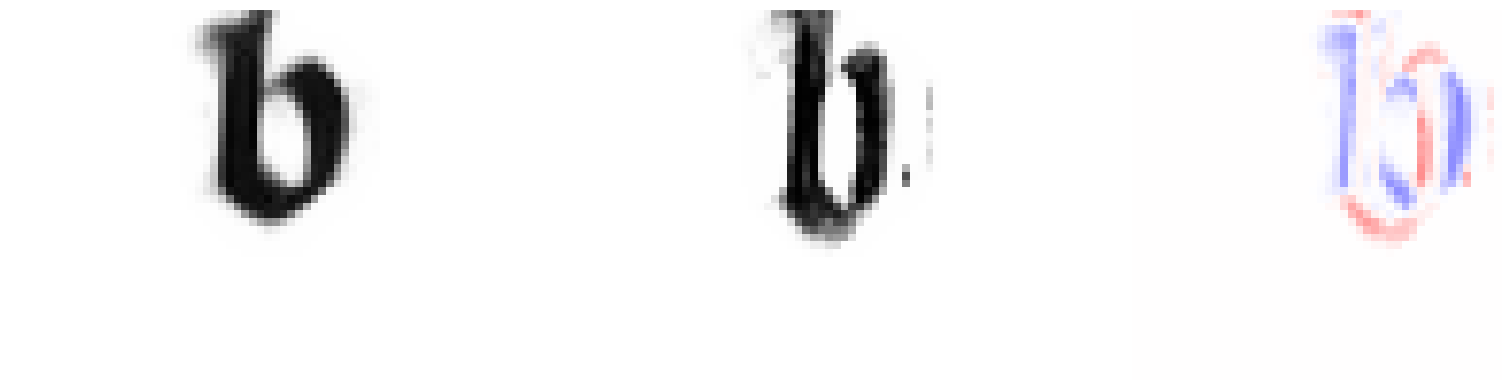

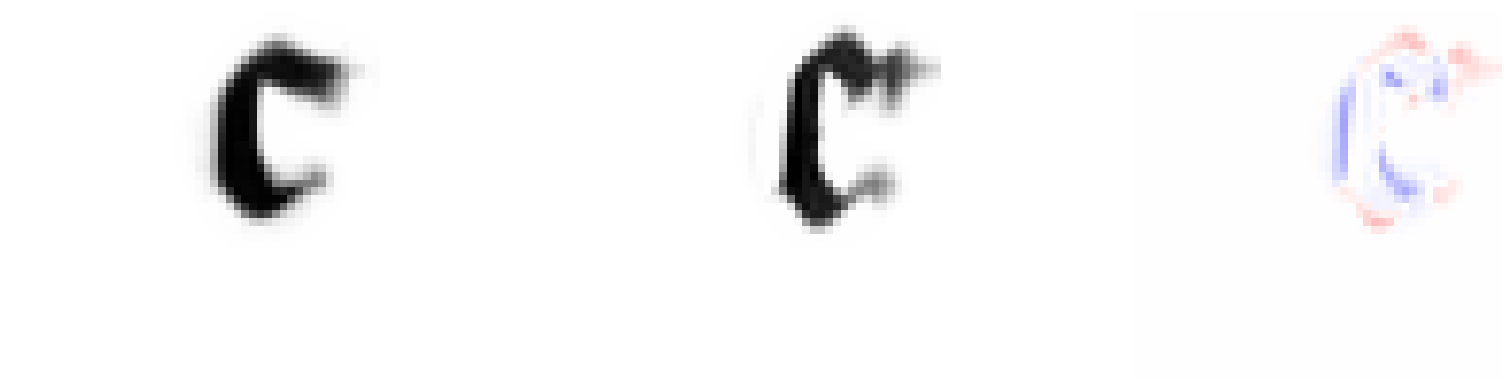

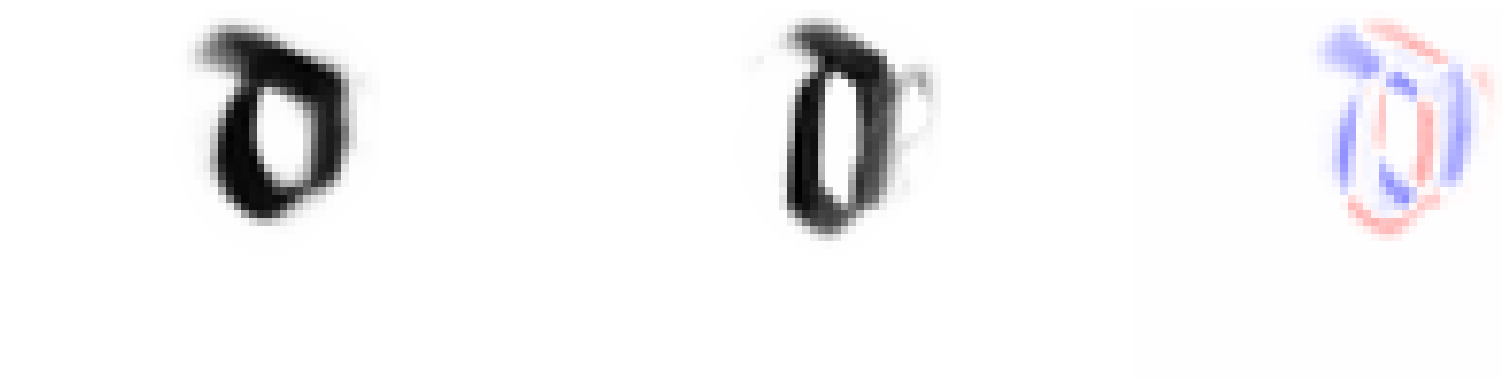

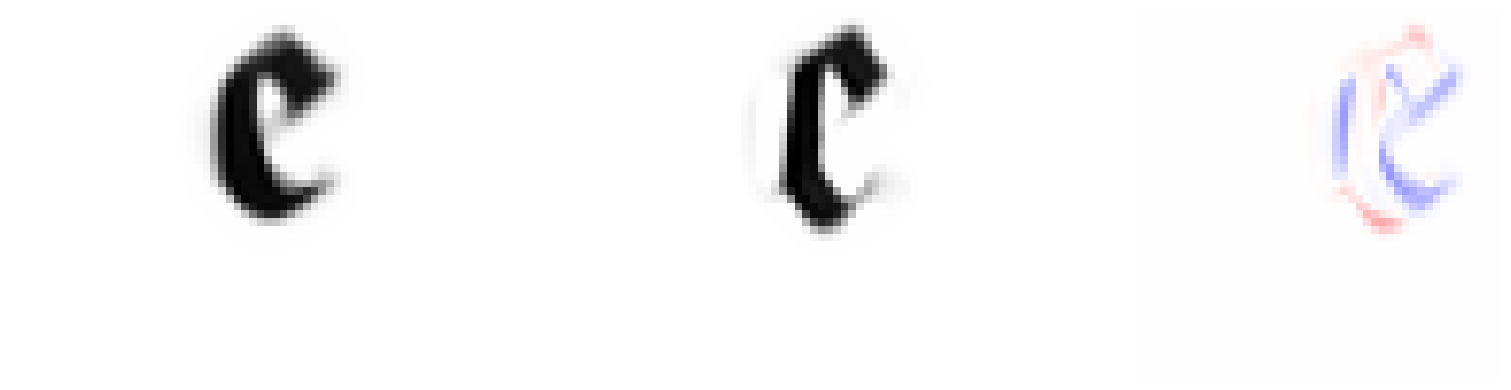

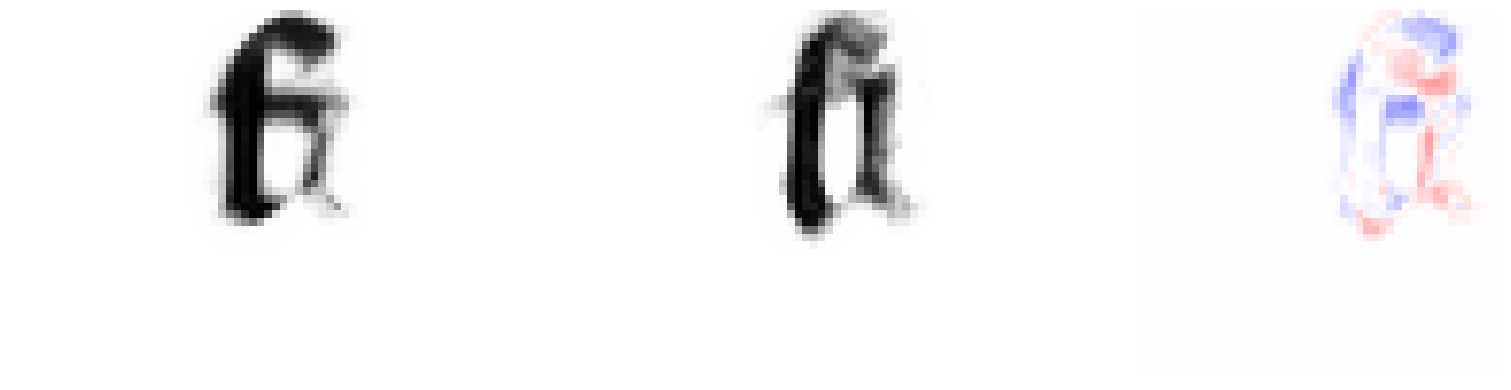

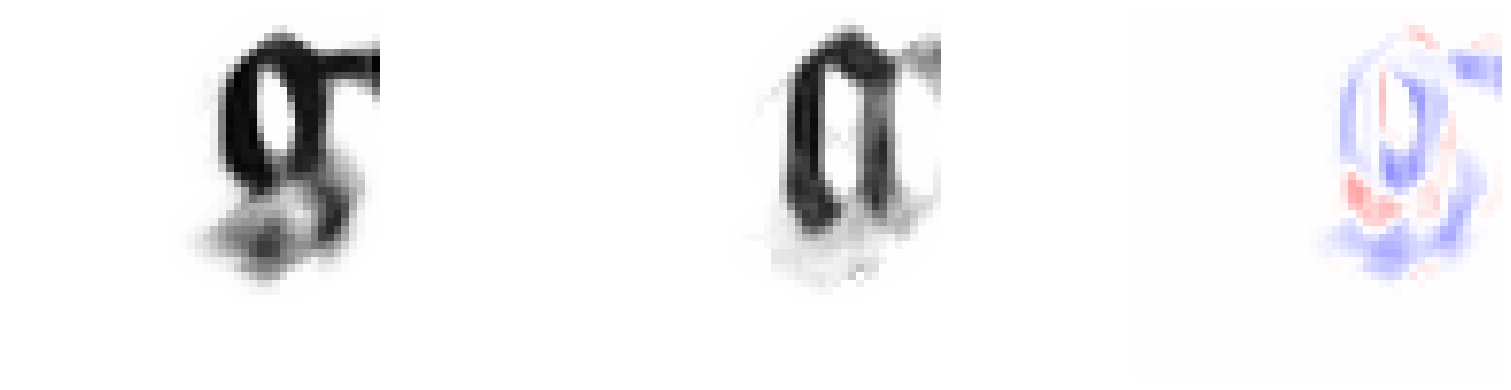

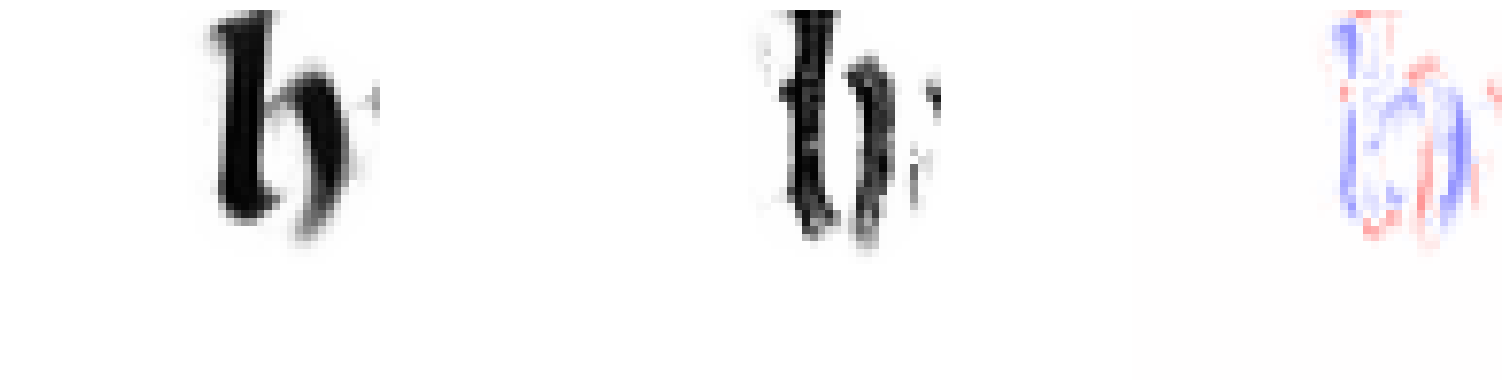

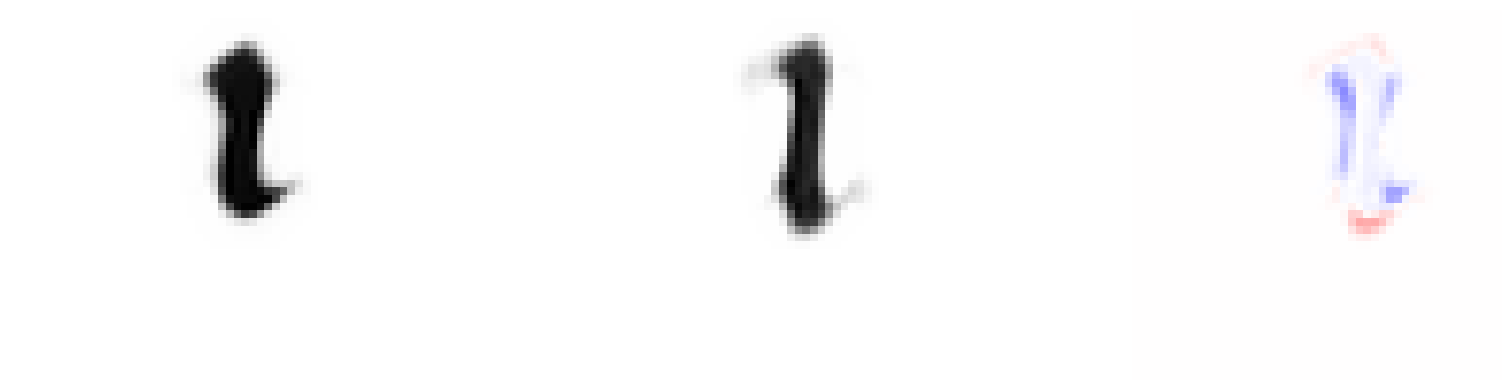

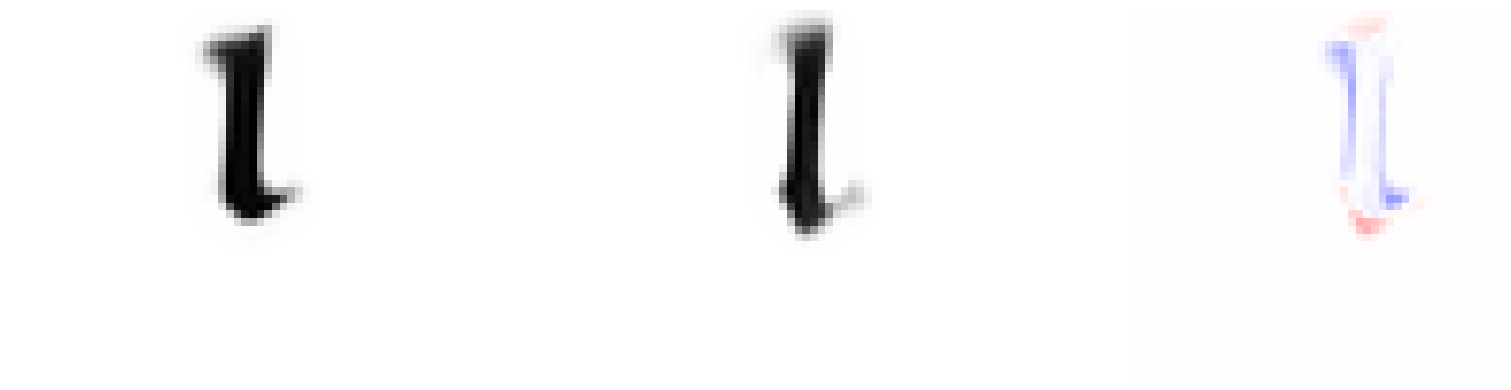

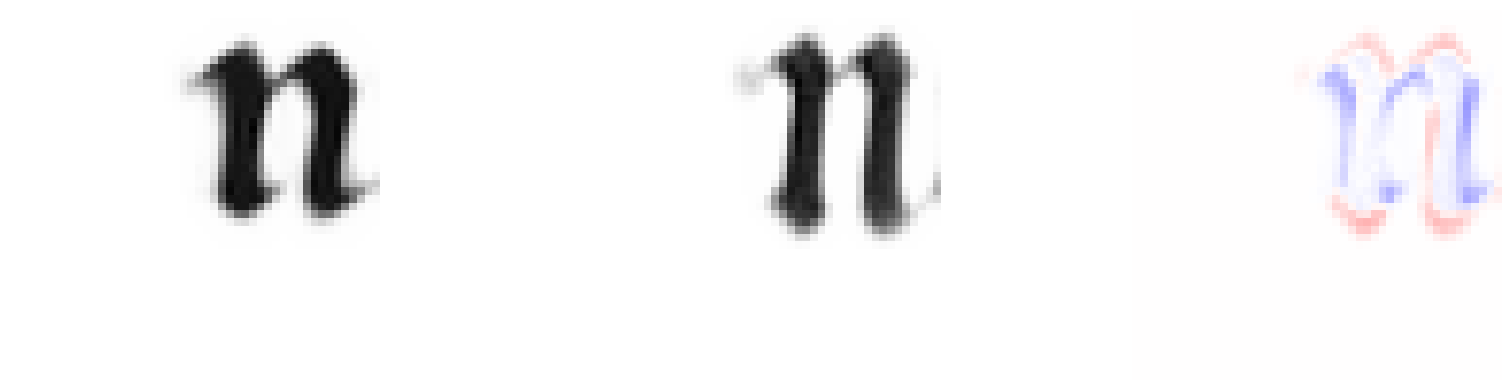

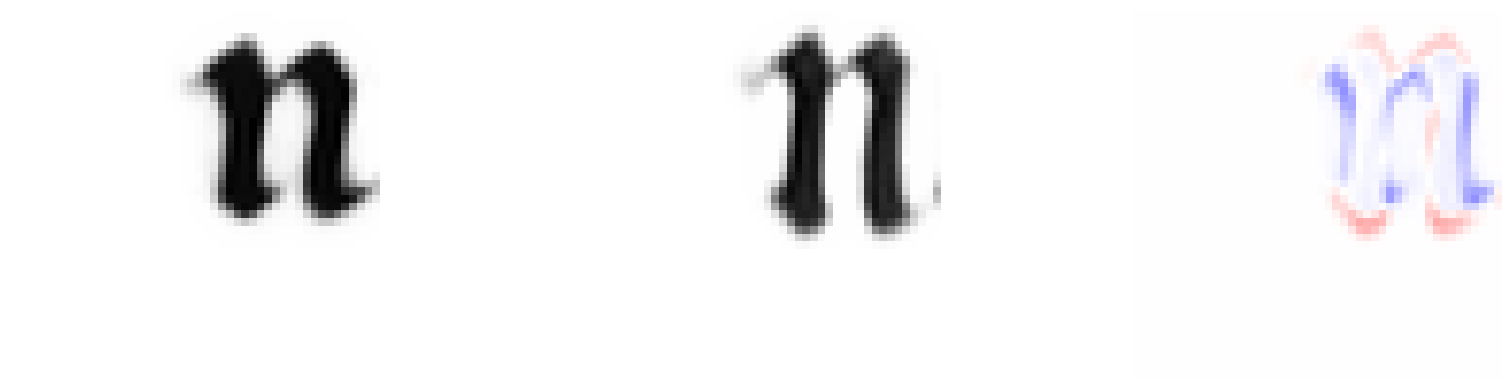

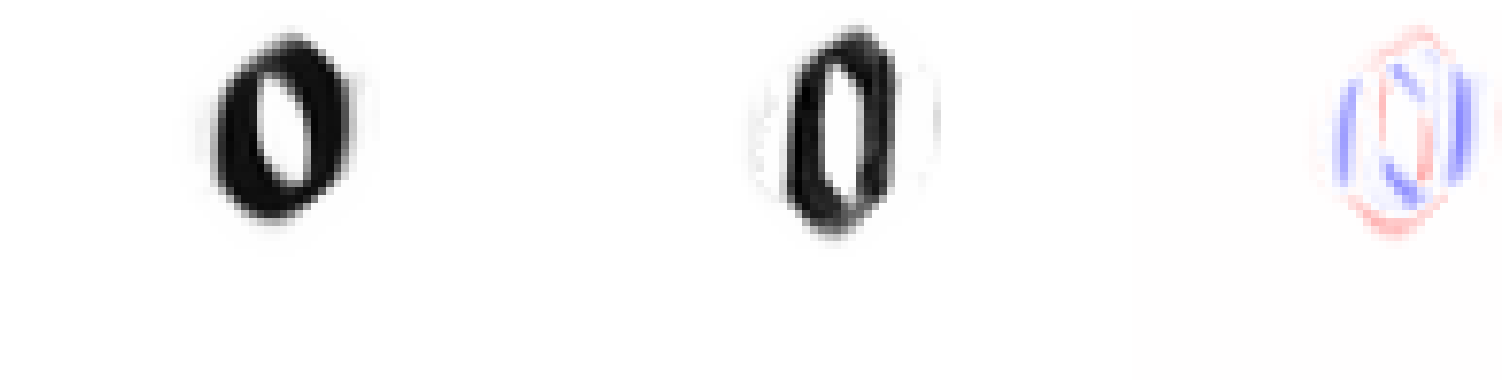

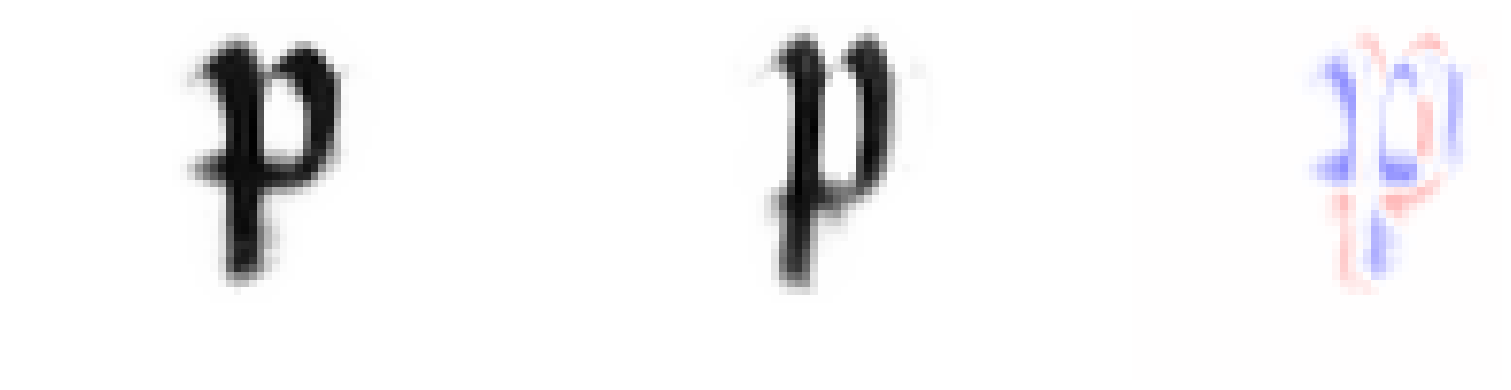

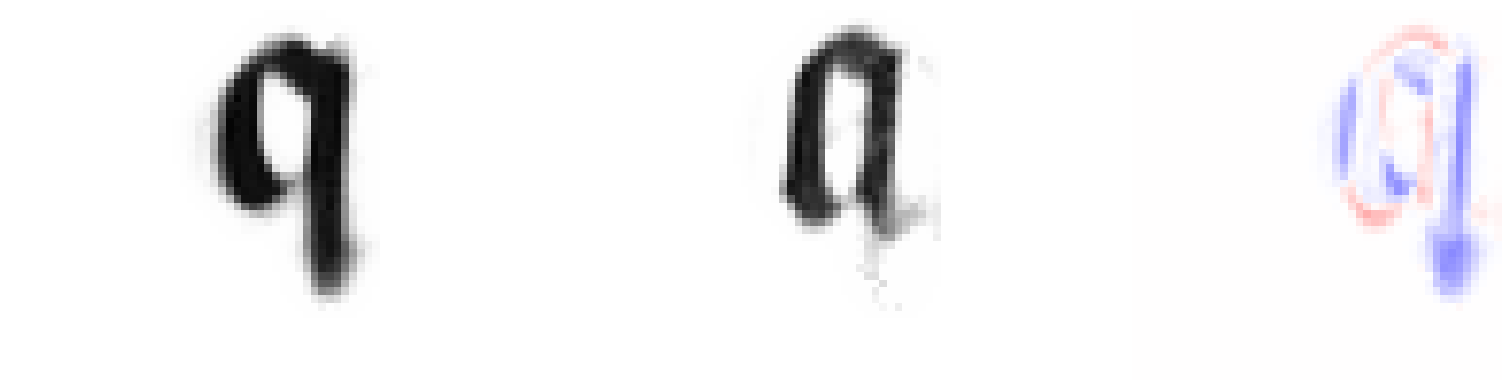

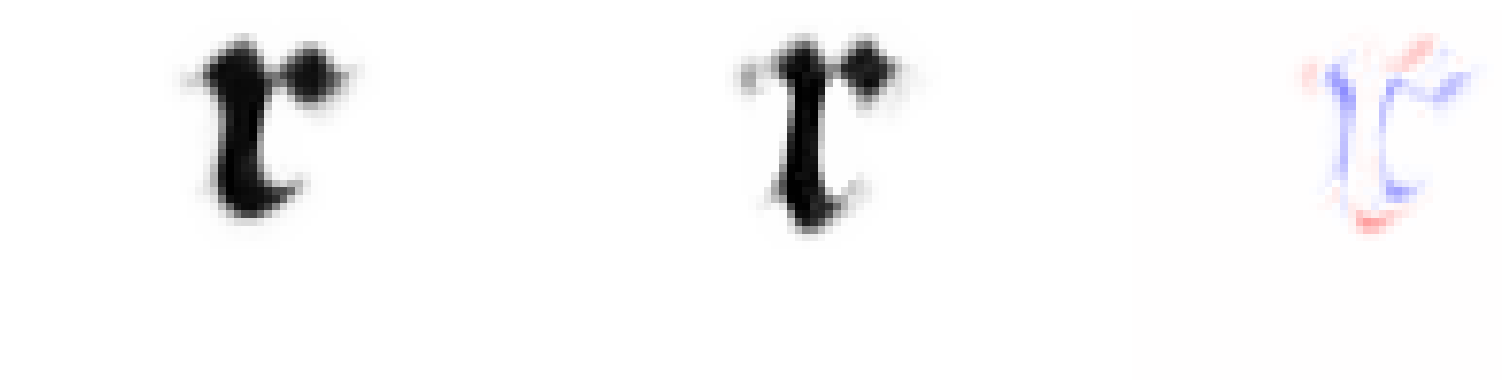

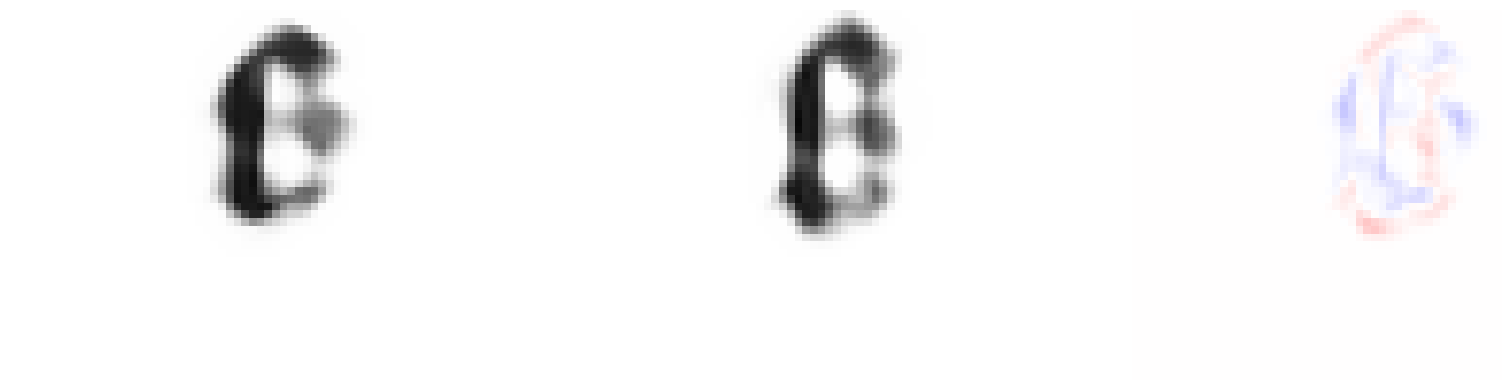

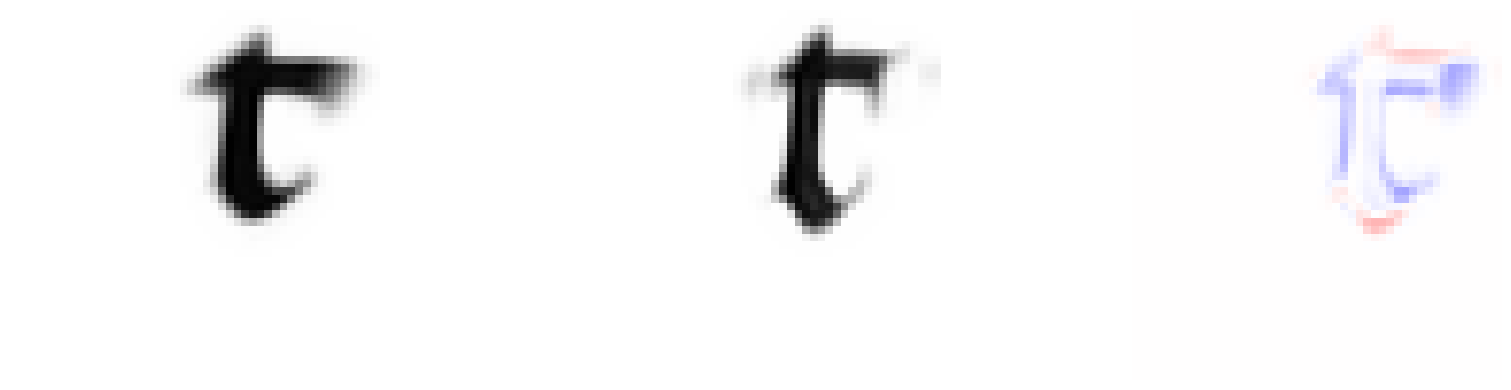

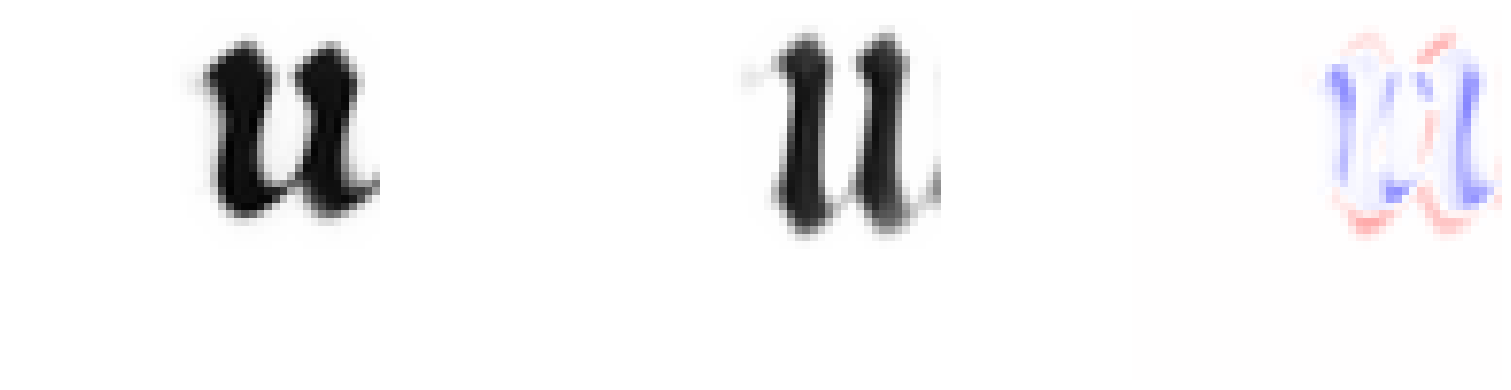

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/SBB-PK-Hdschr25


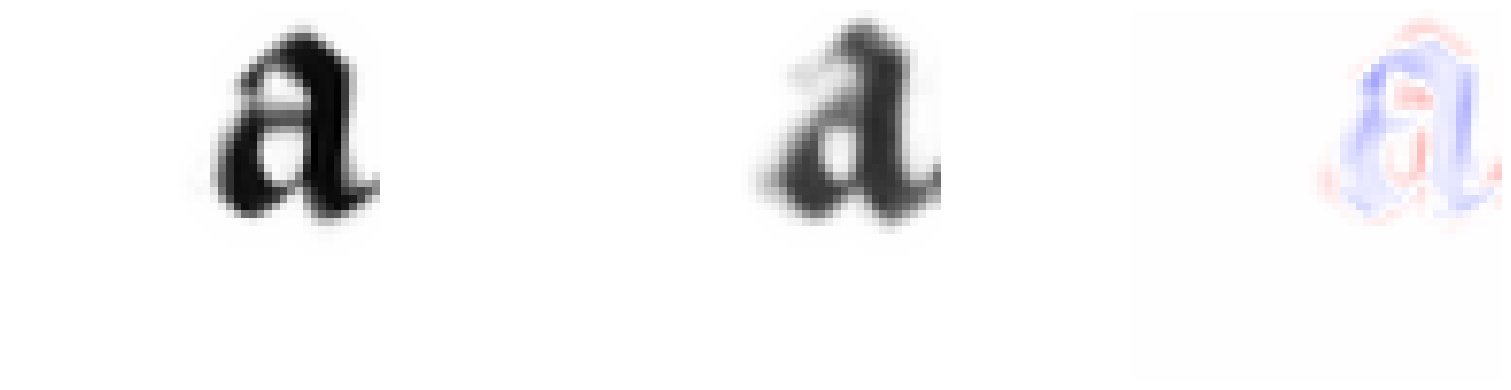

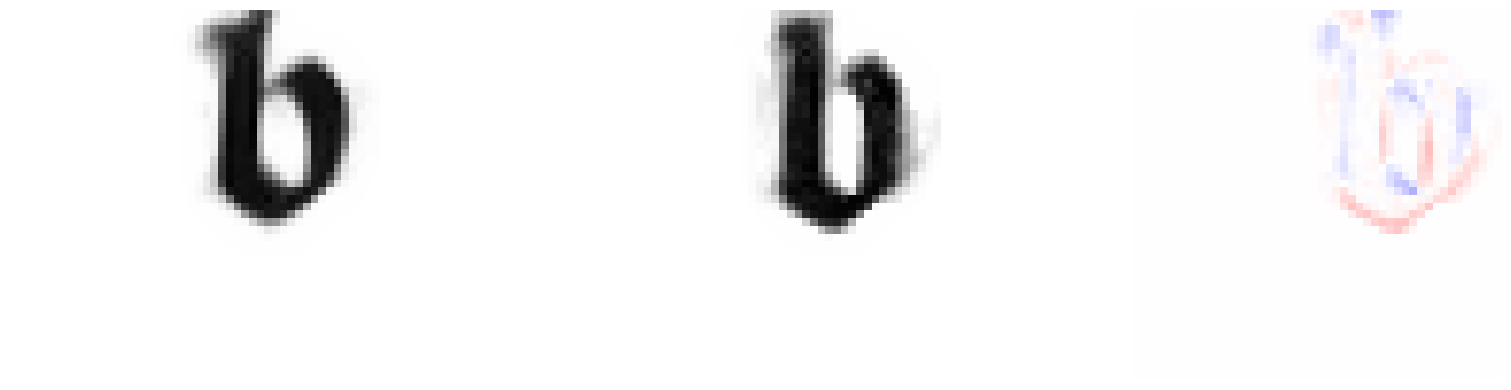

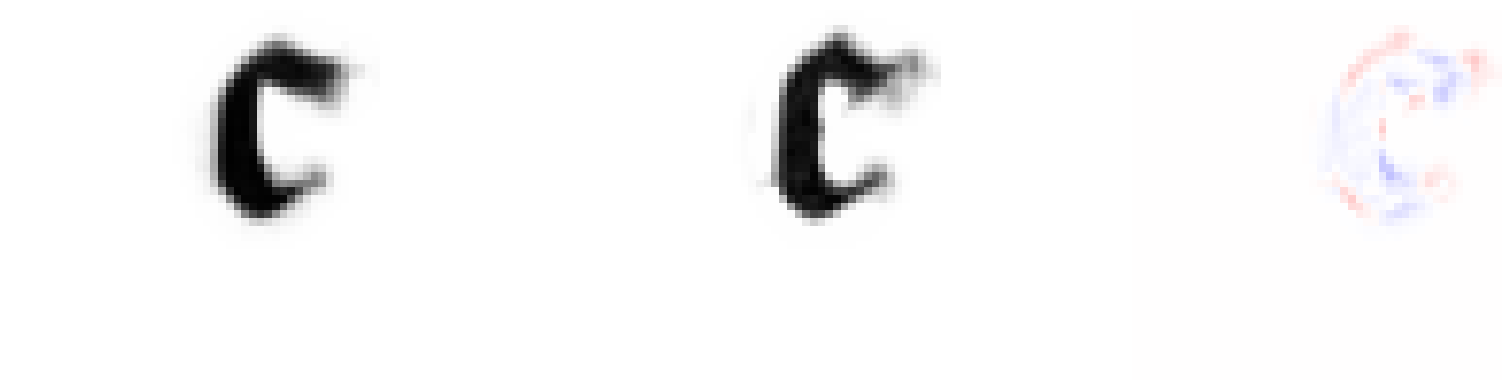

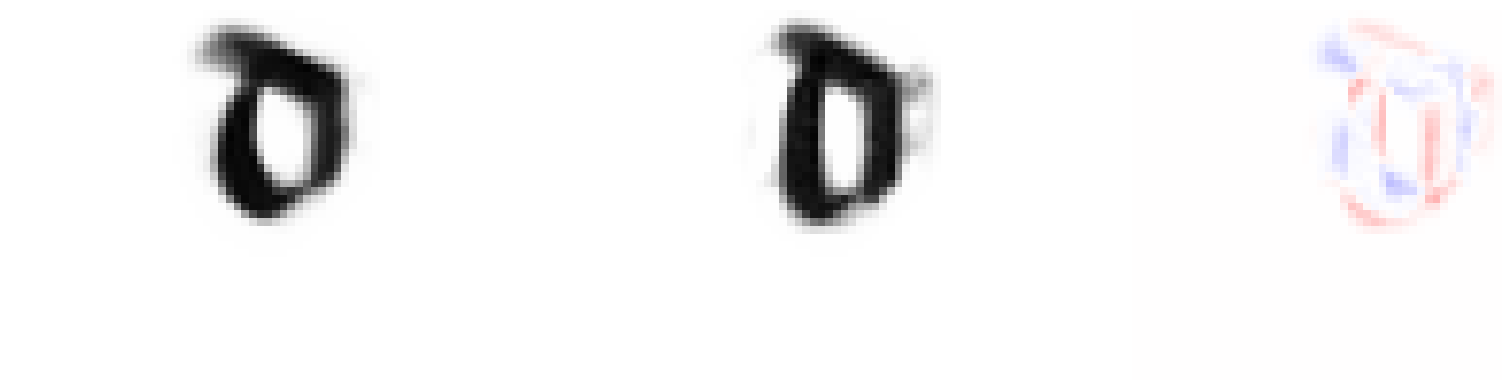

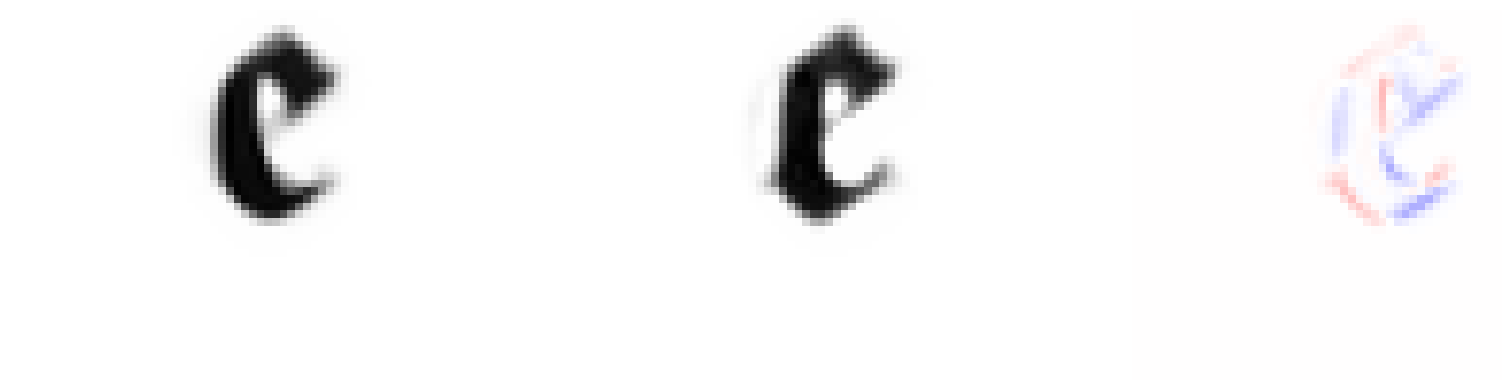

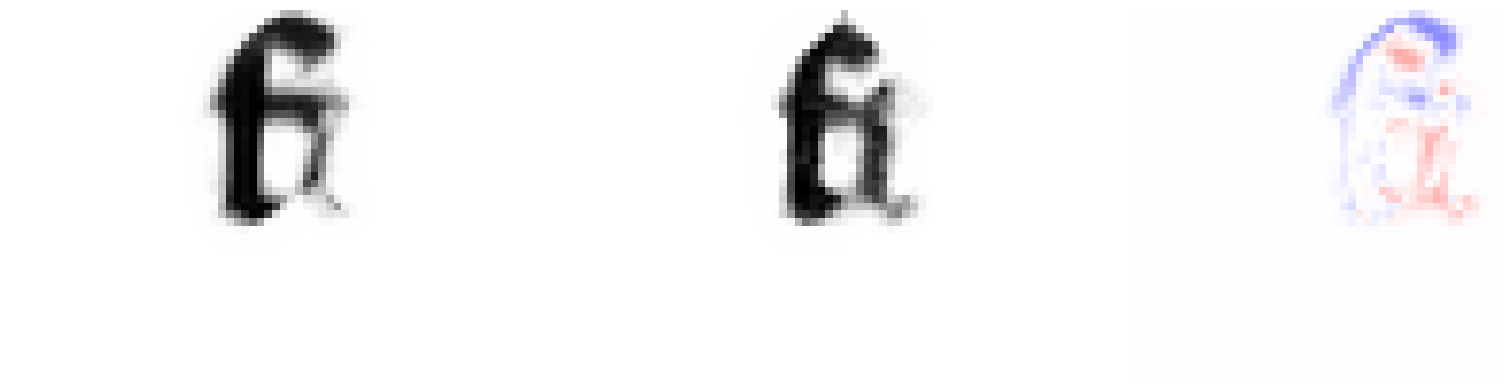

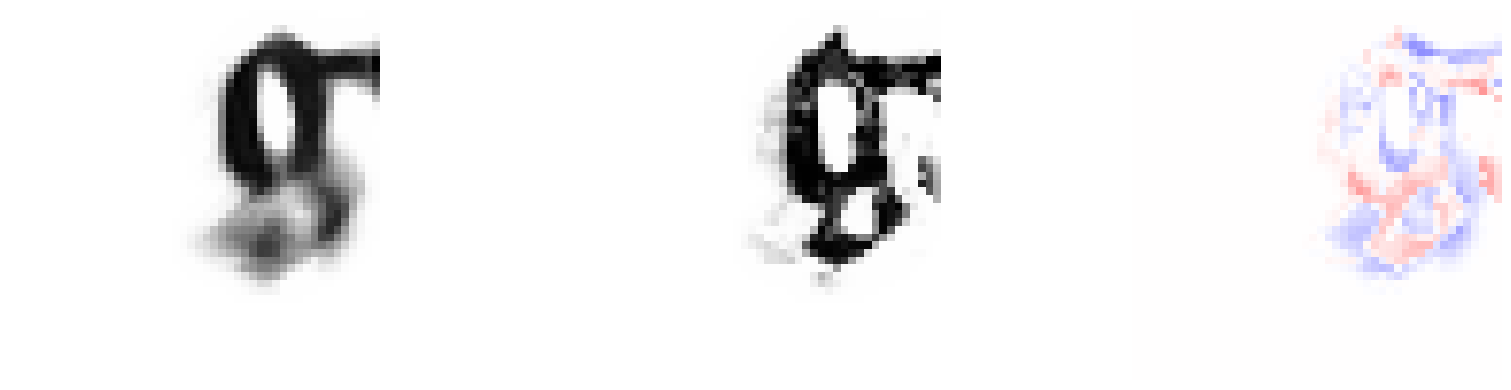

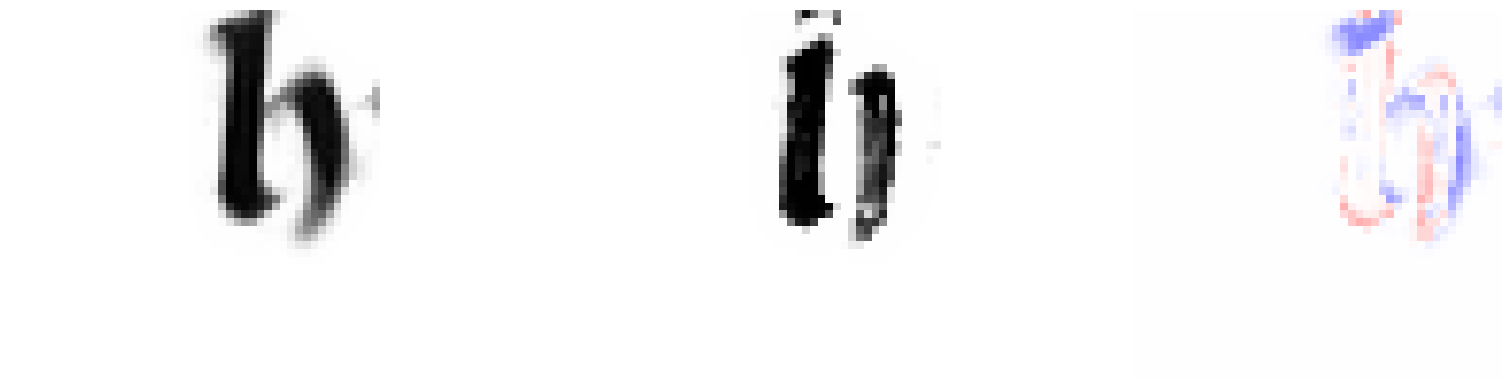

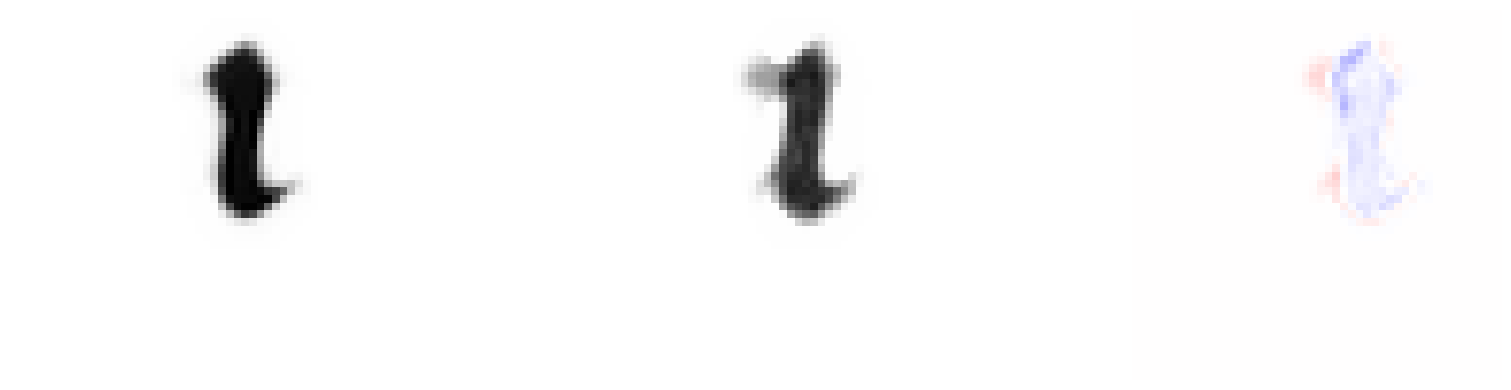

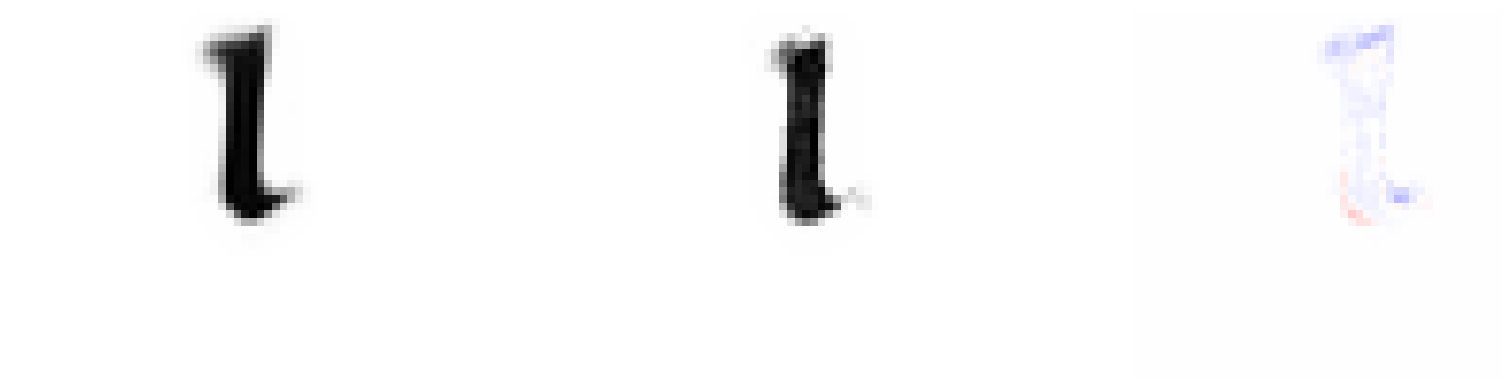

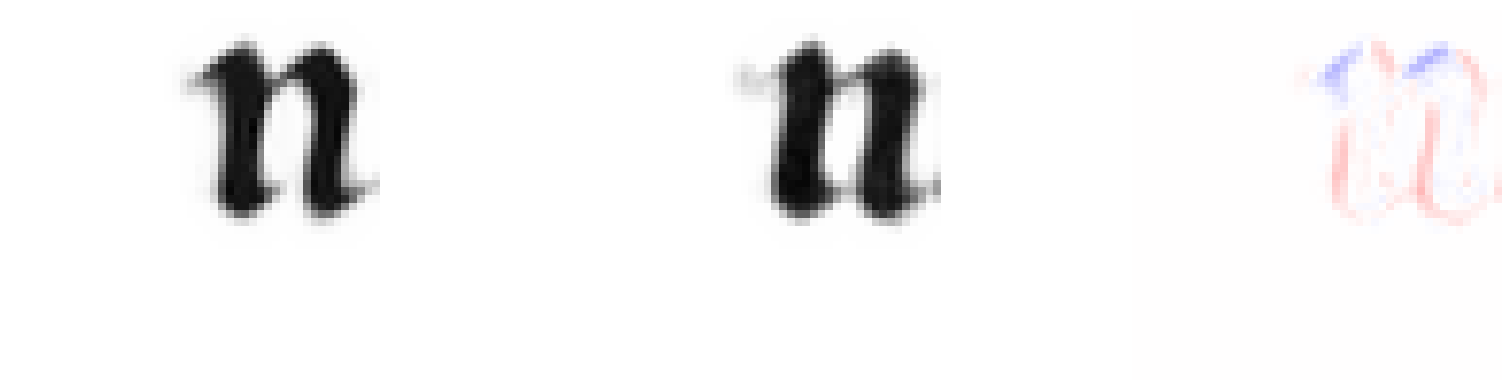

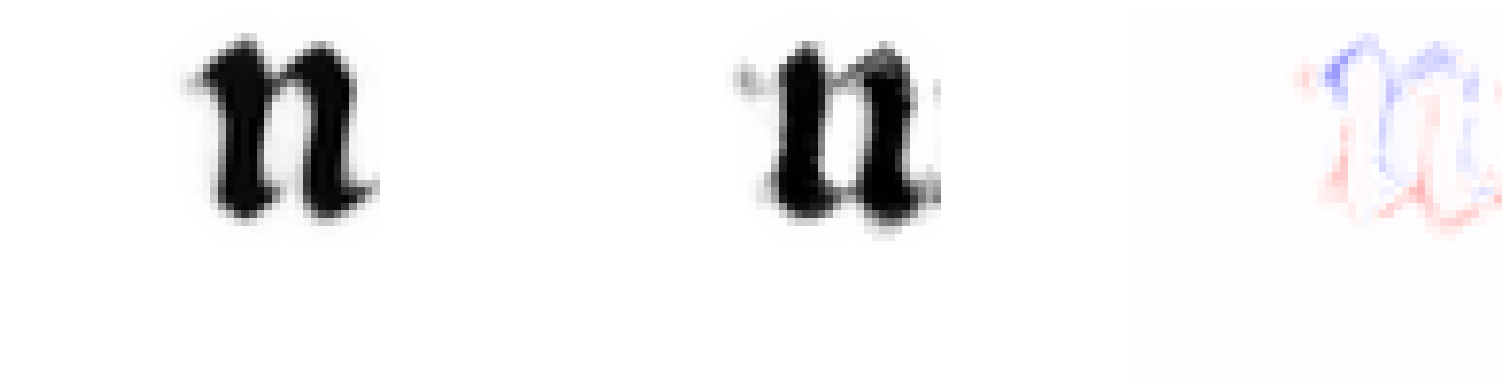

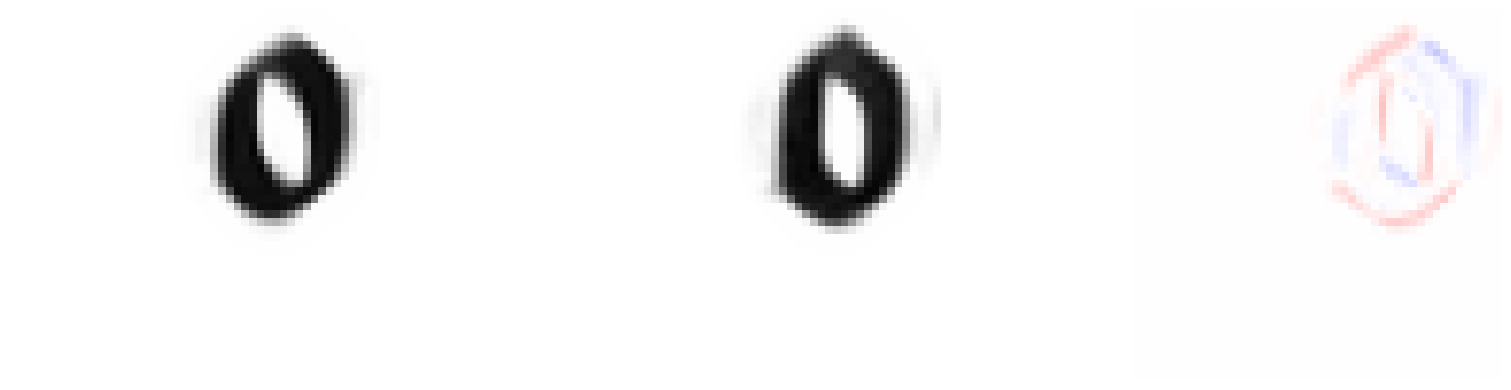

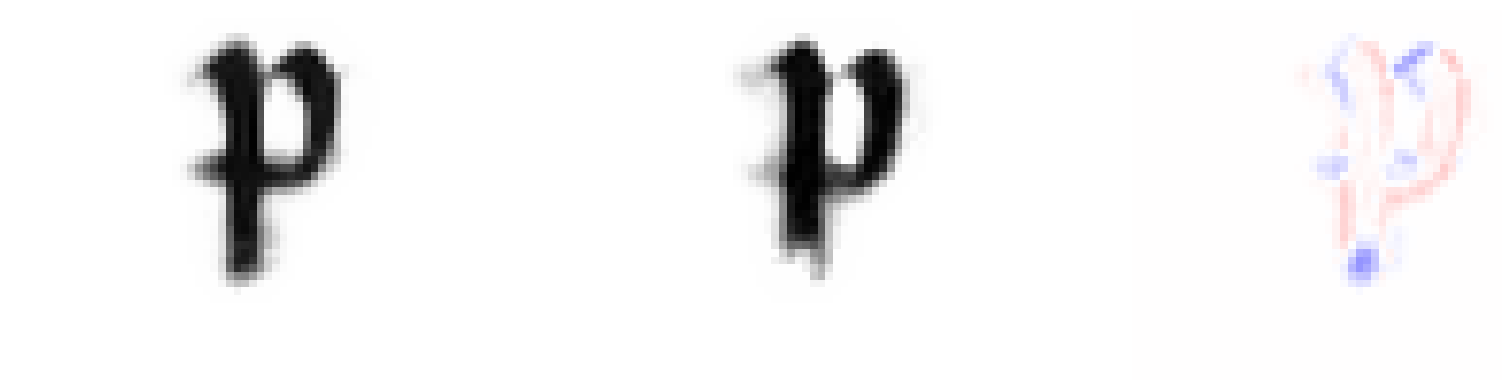

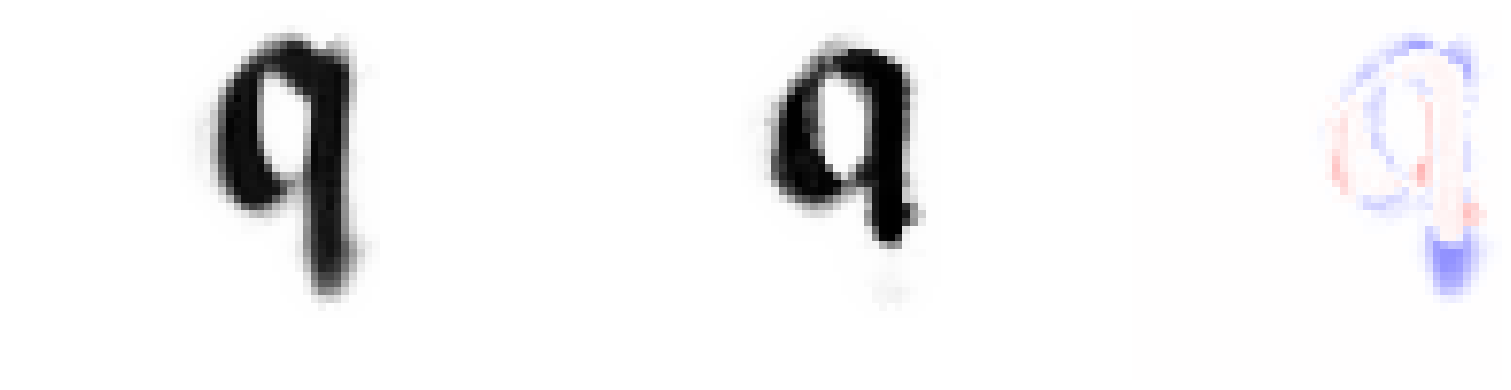

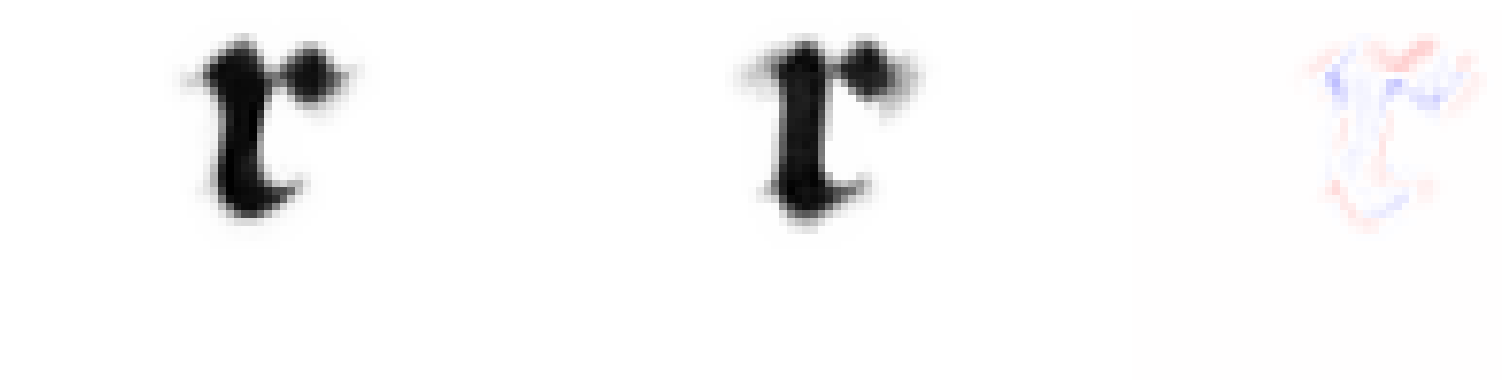

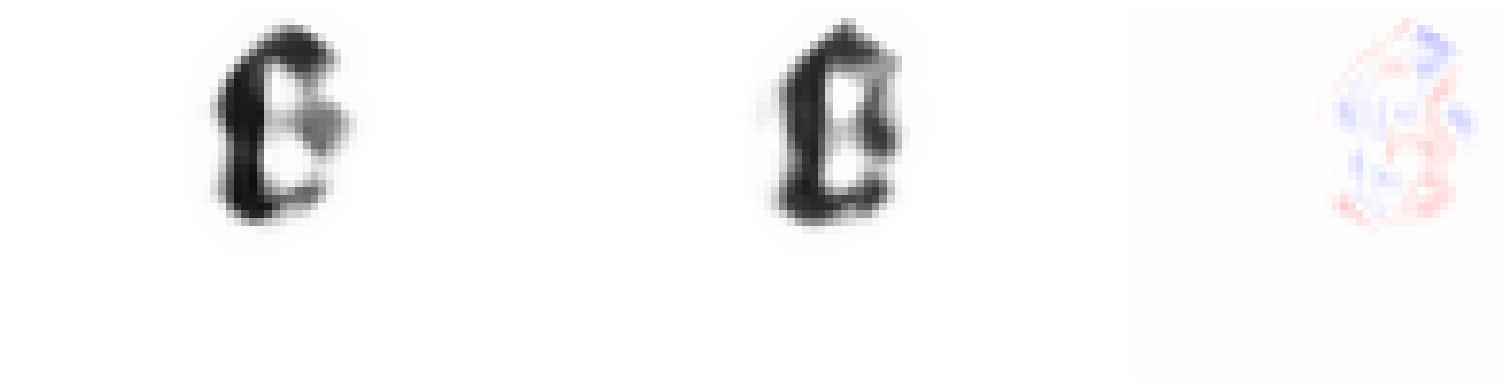

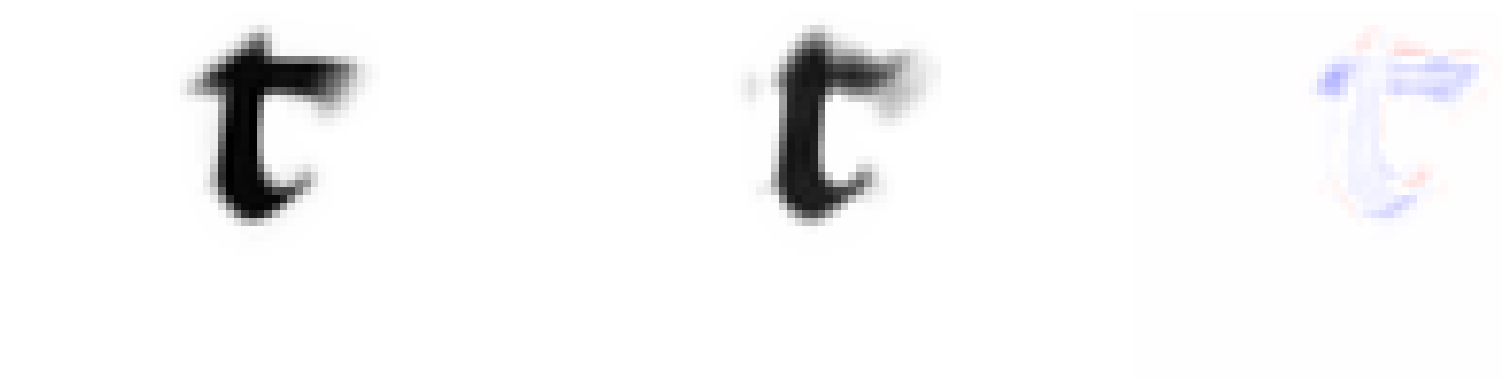

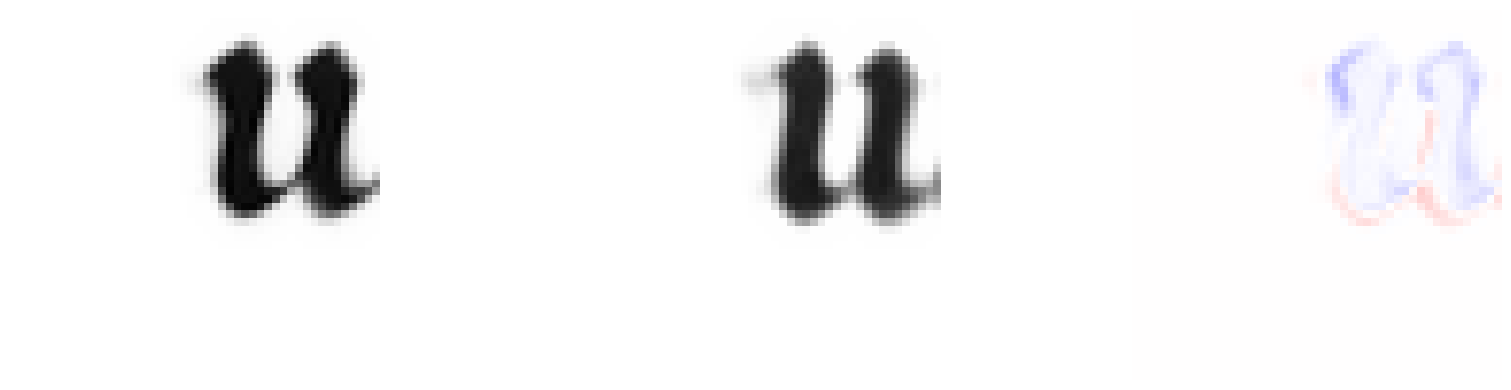

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/Southern_Textualis


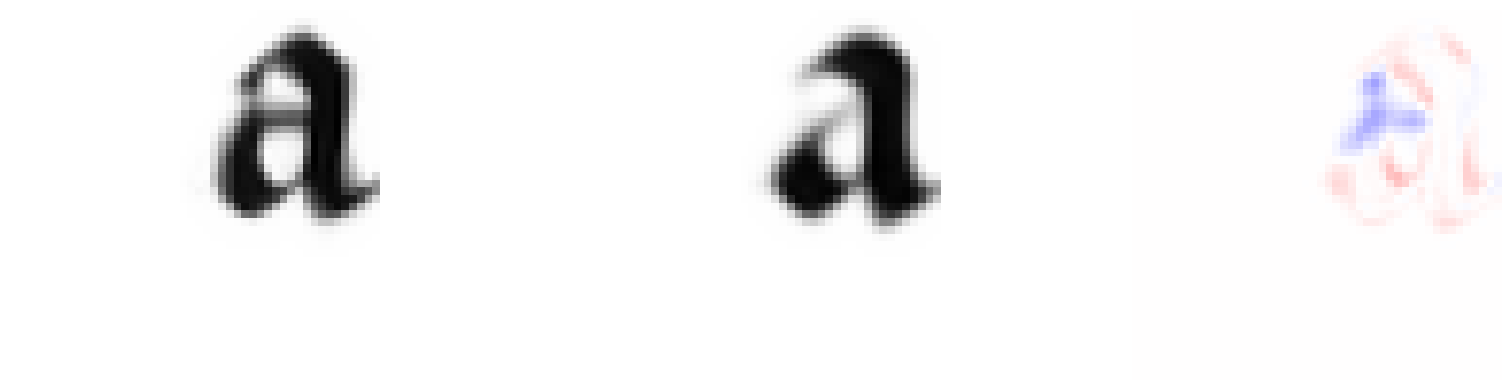

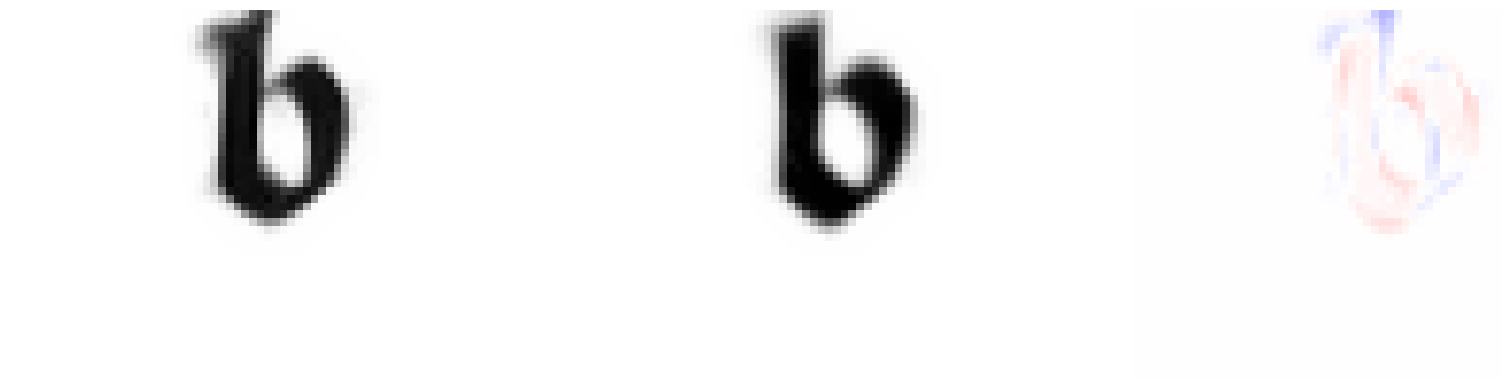

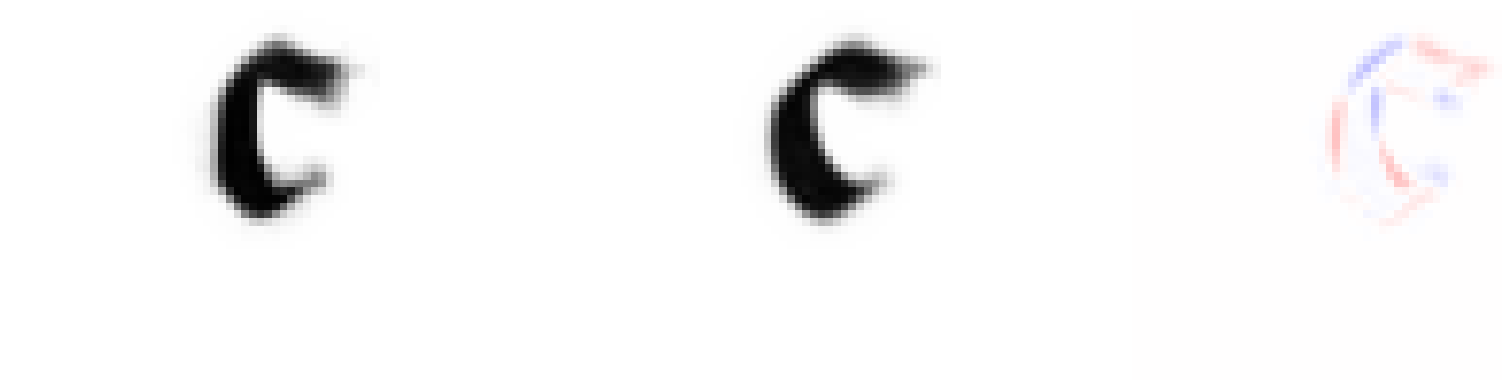

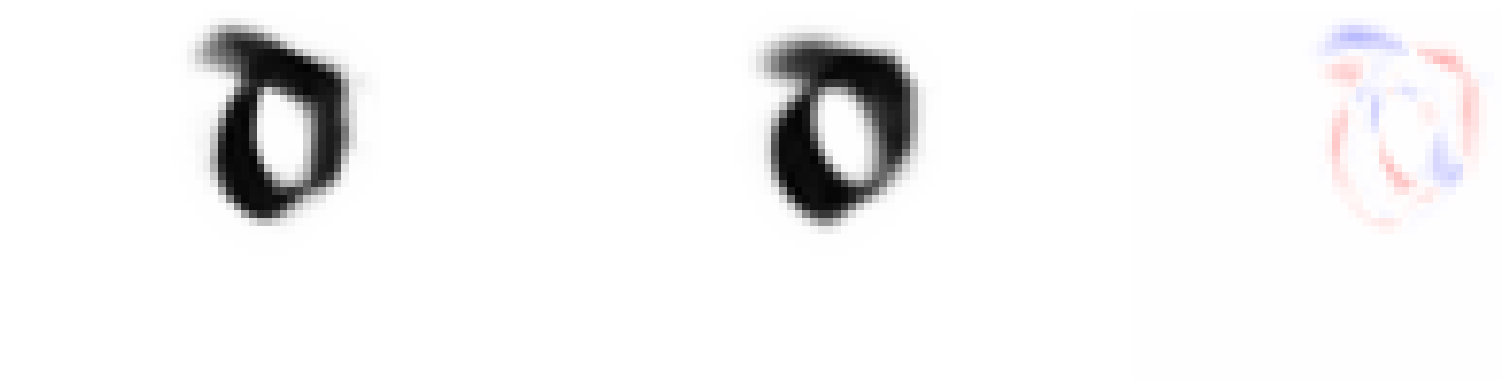

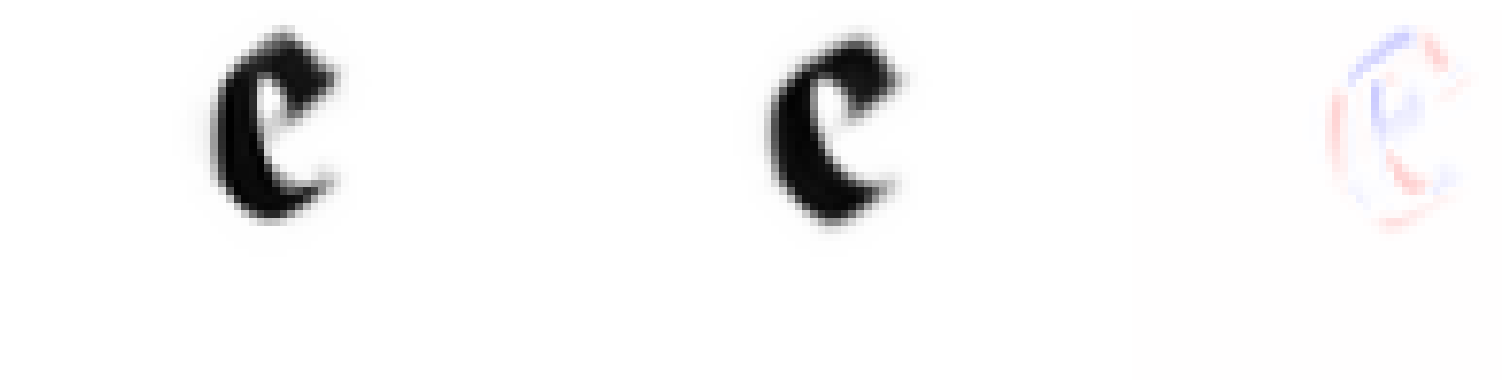

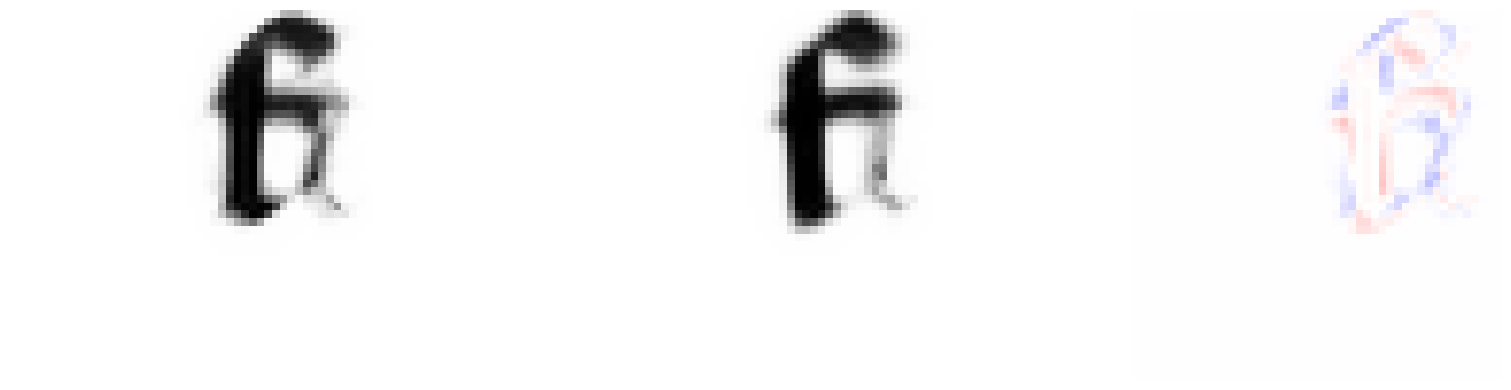

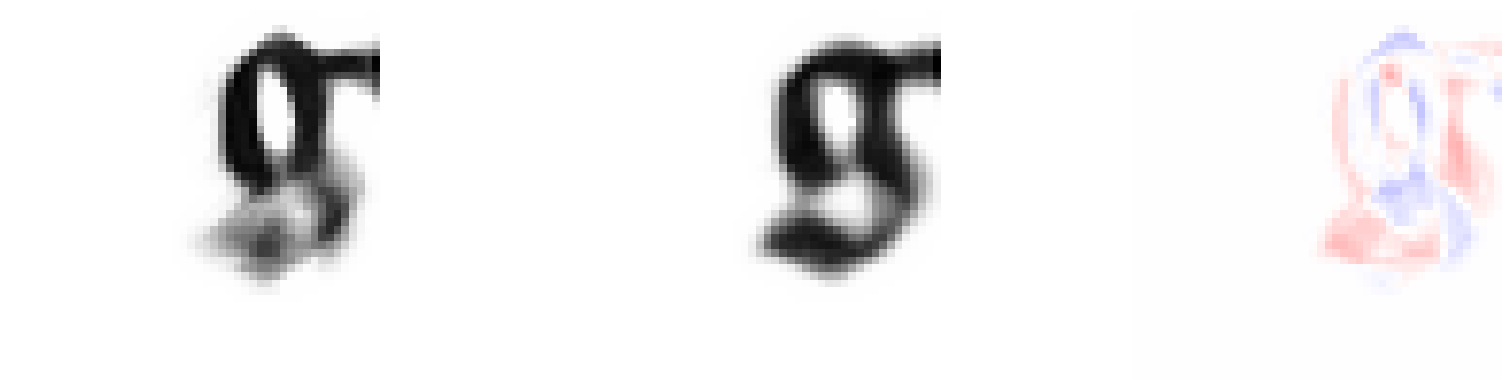

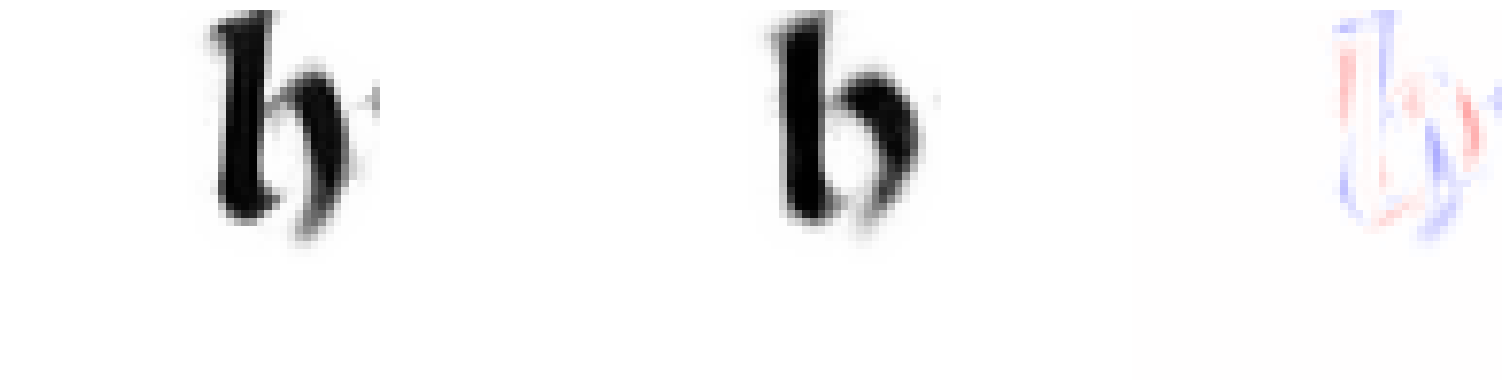

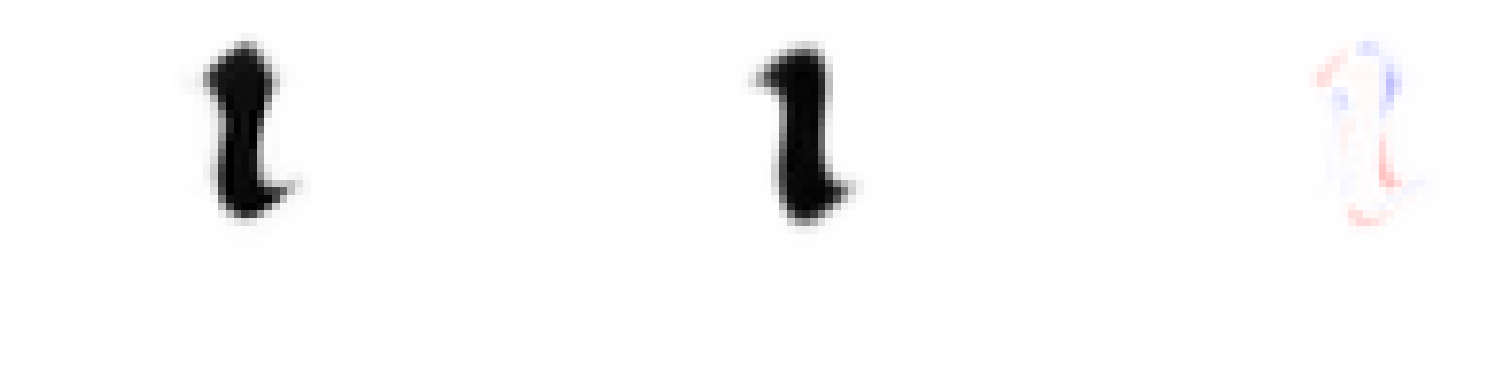

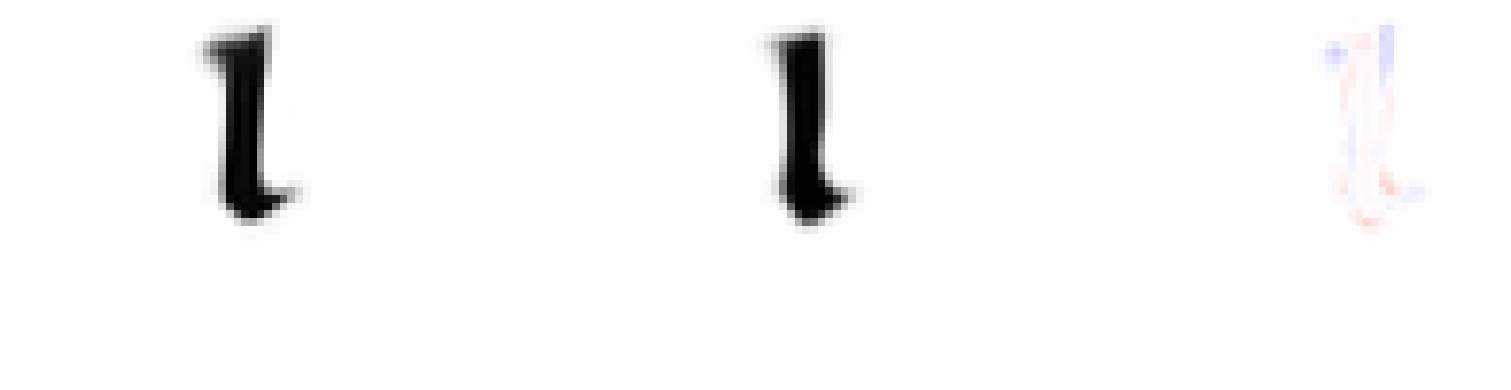

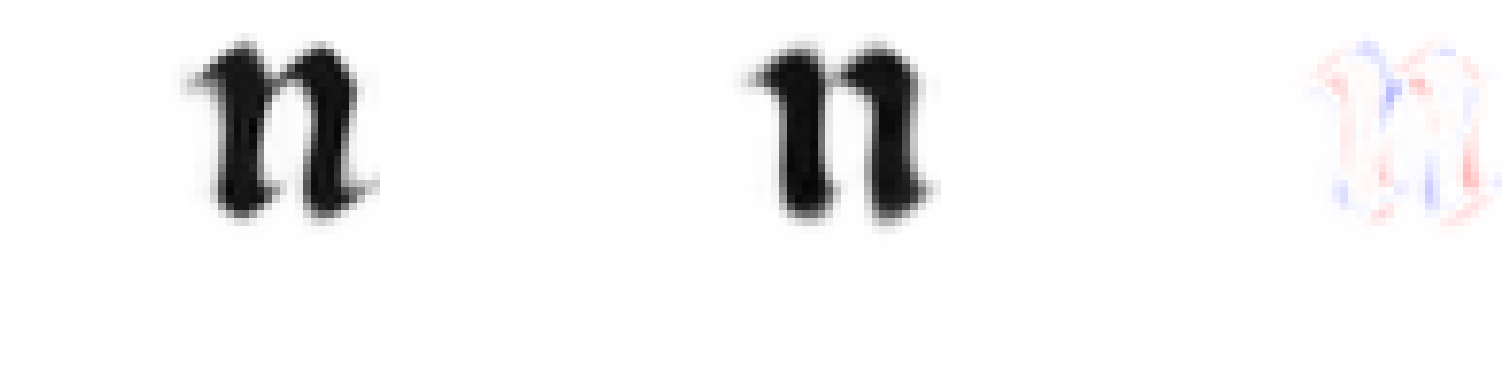

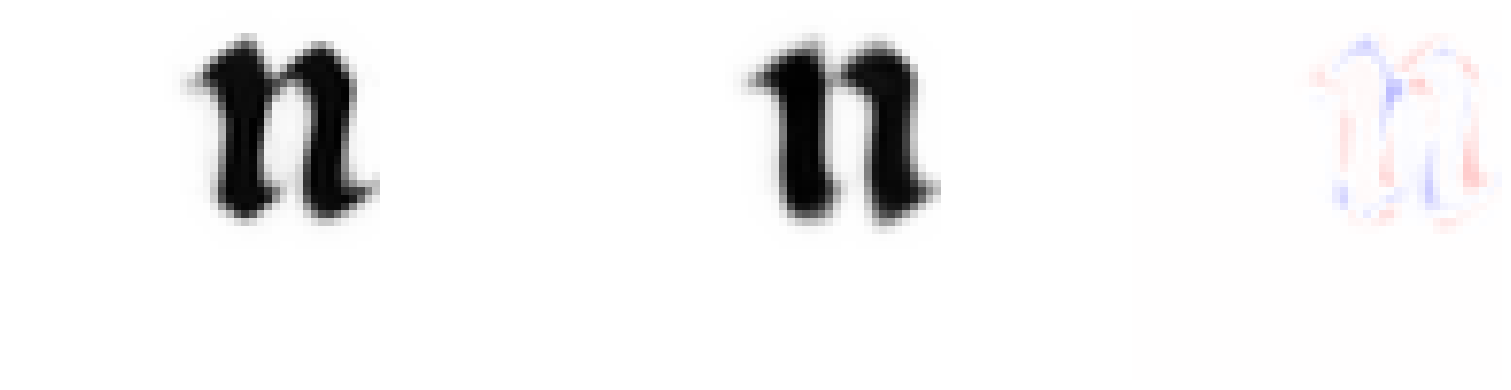

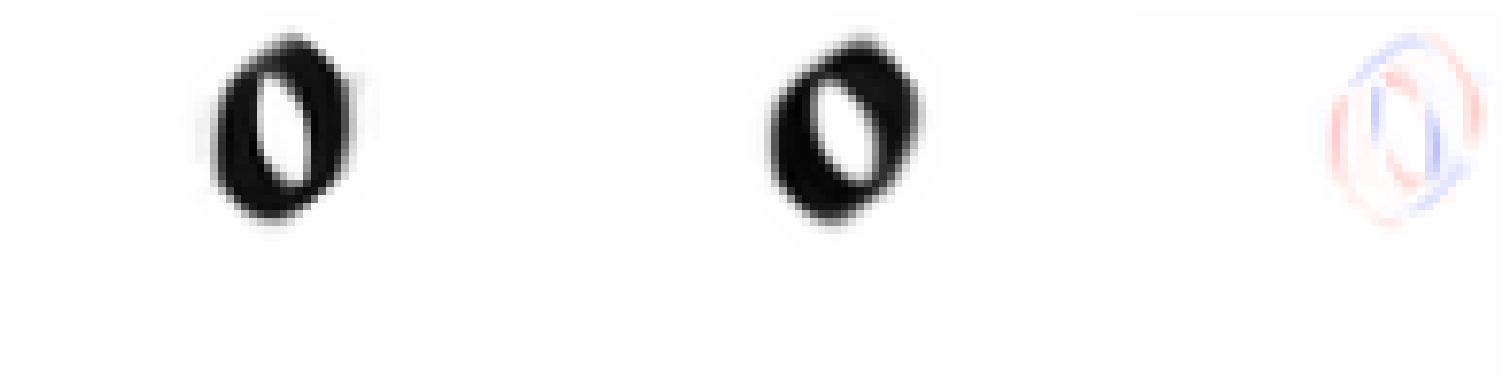

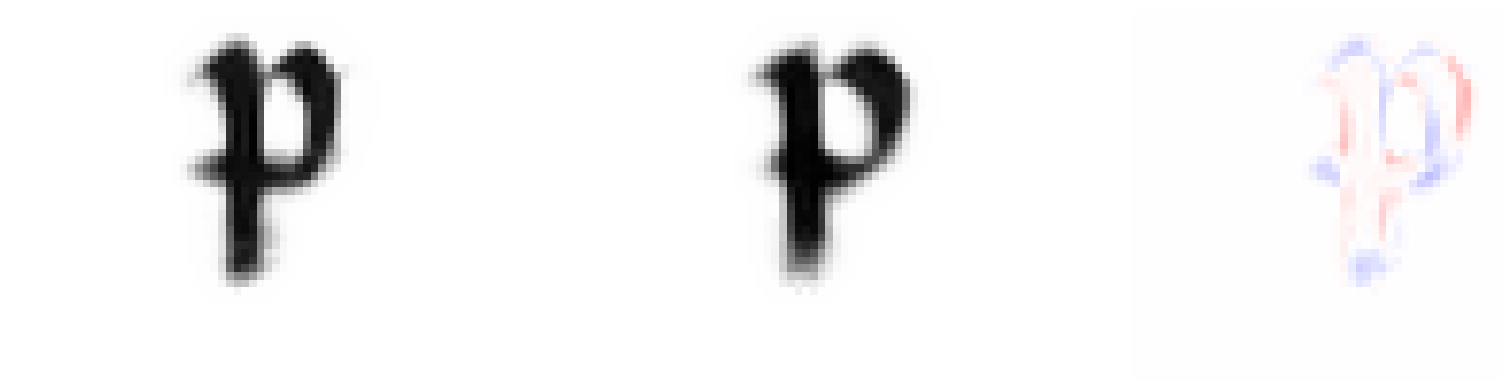

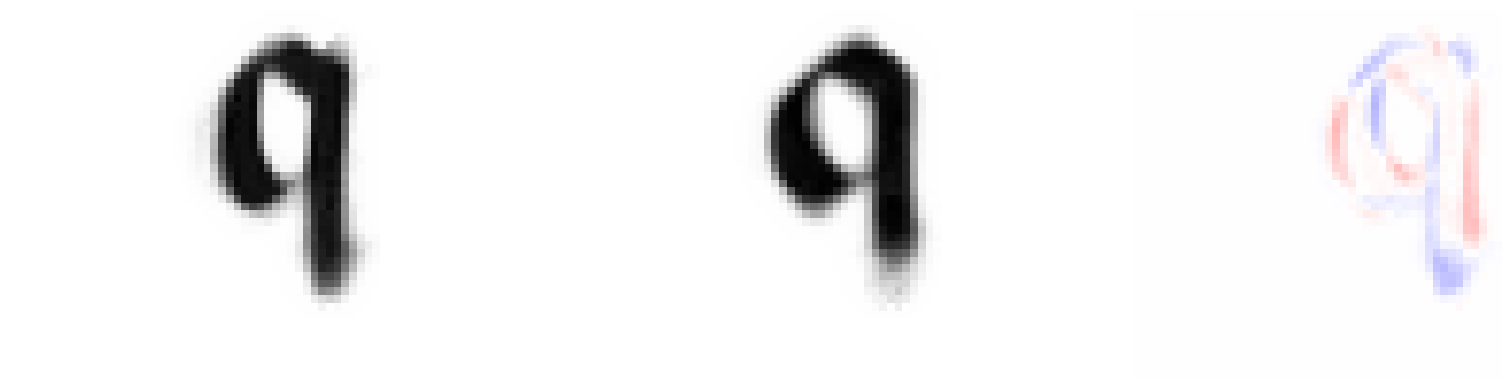

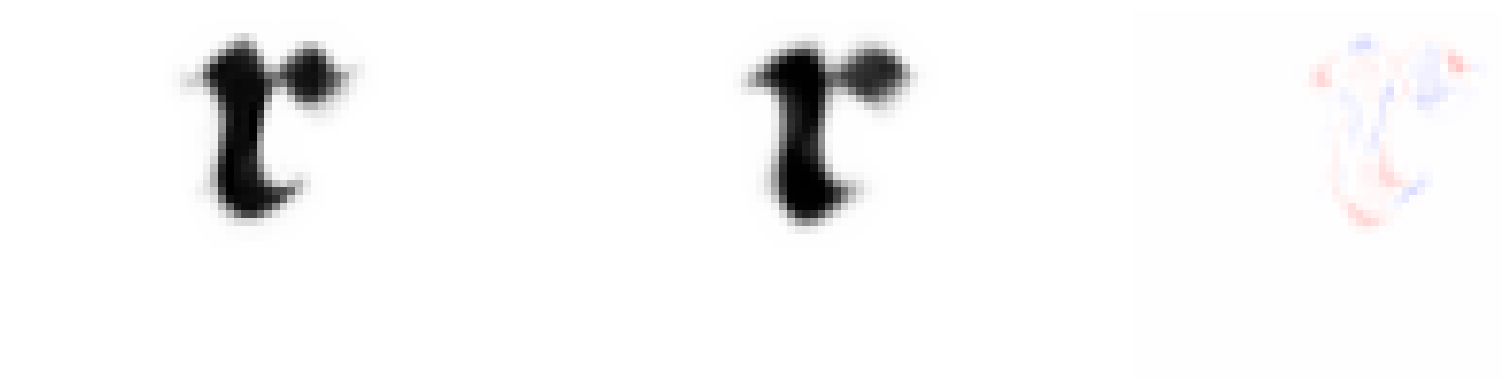

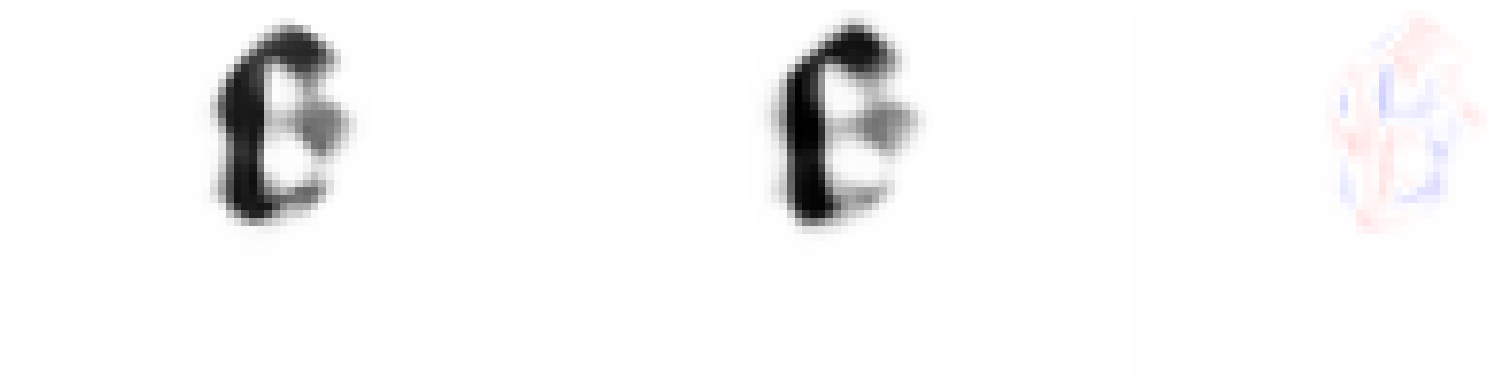

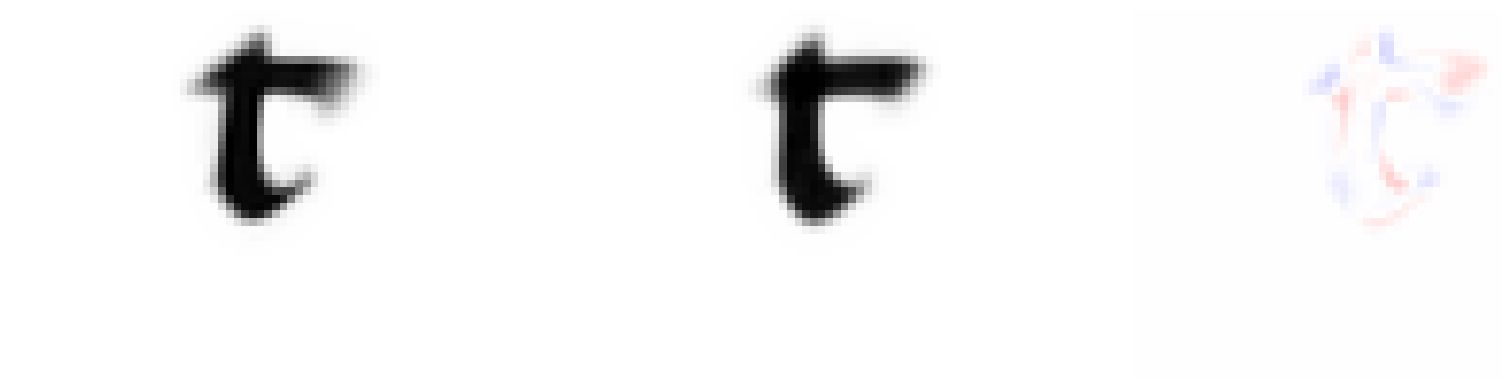

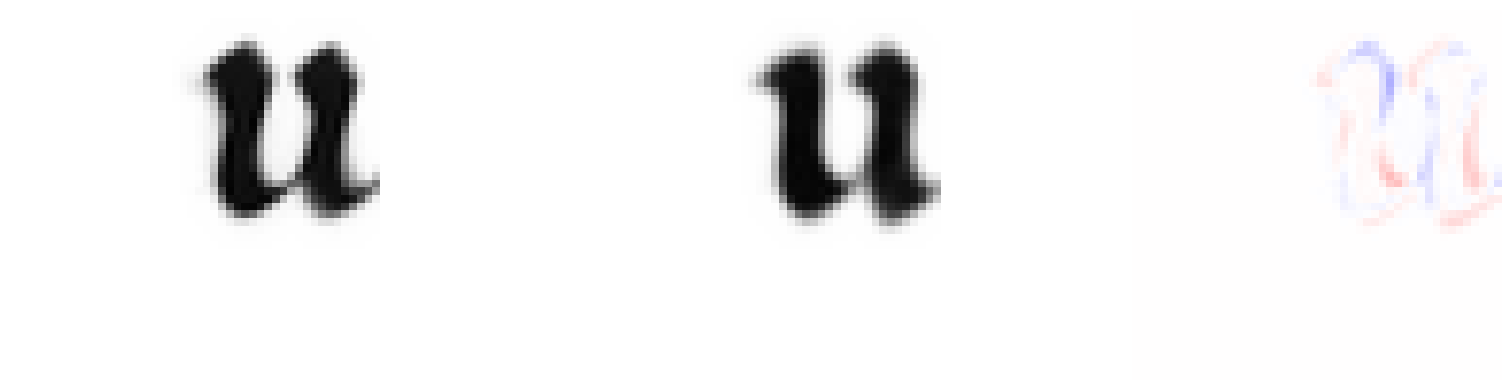

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/btv1b90615126


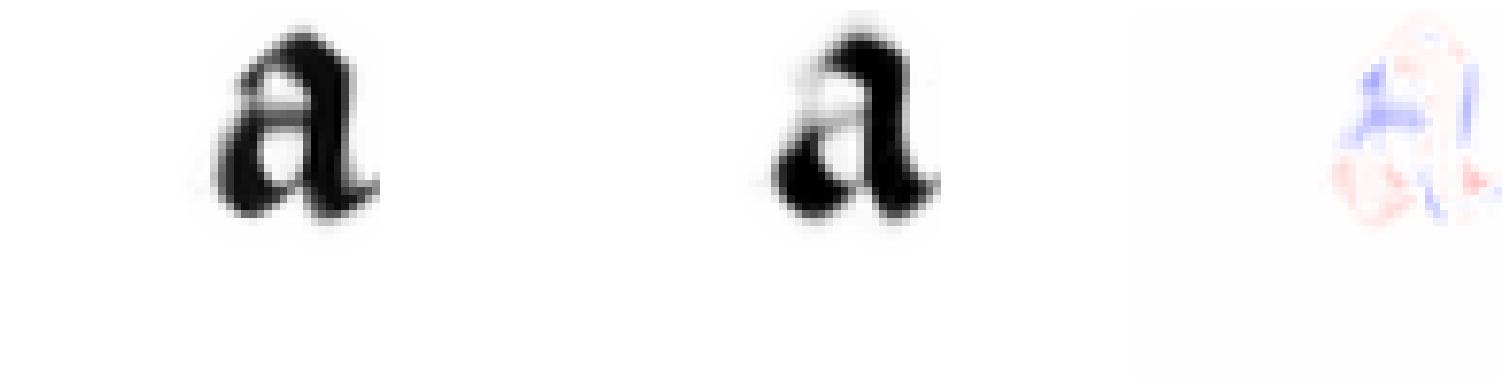

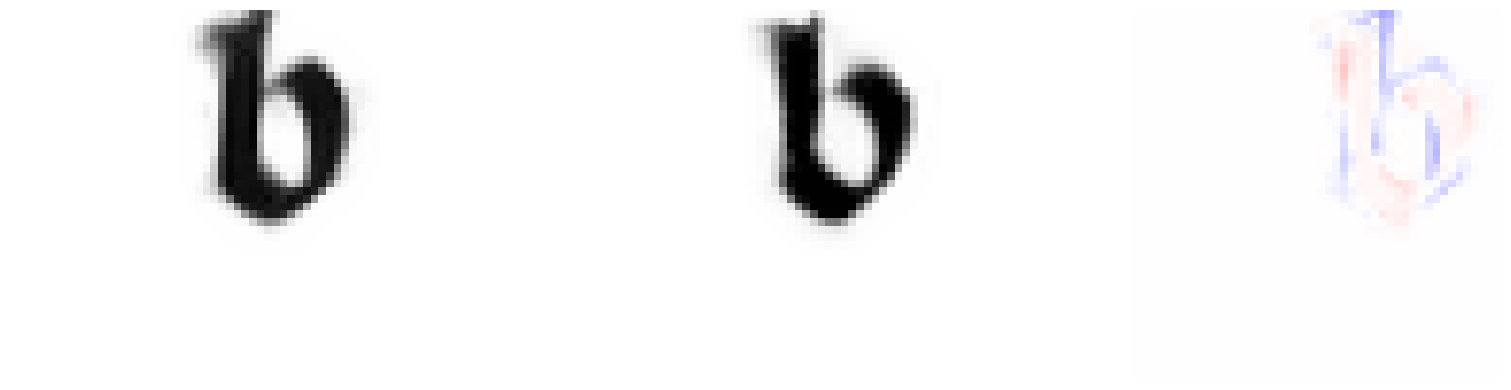

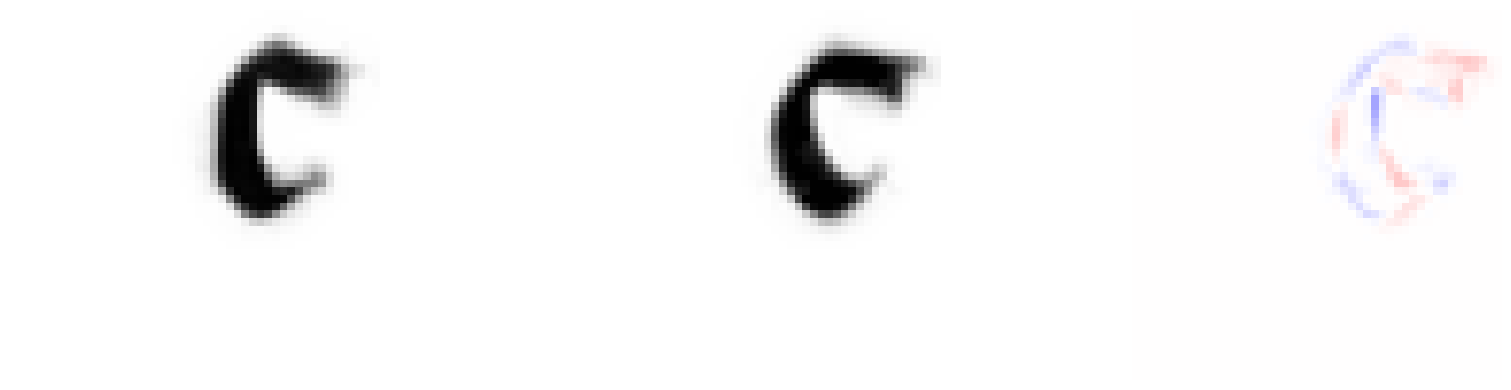

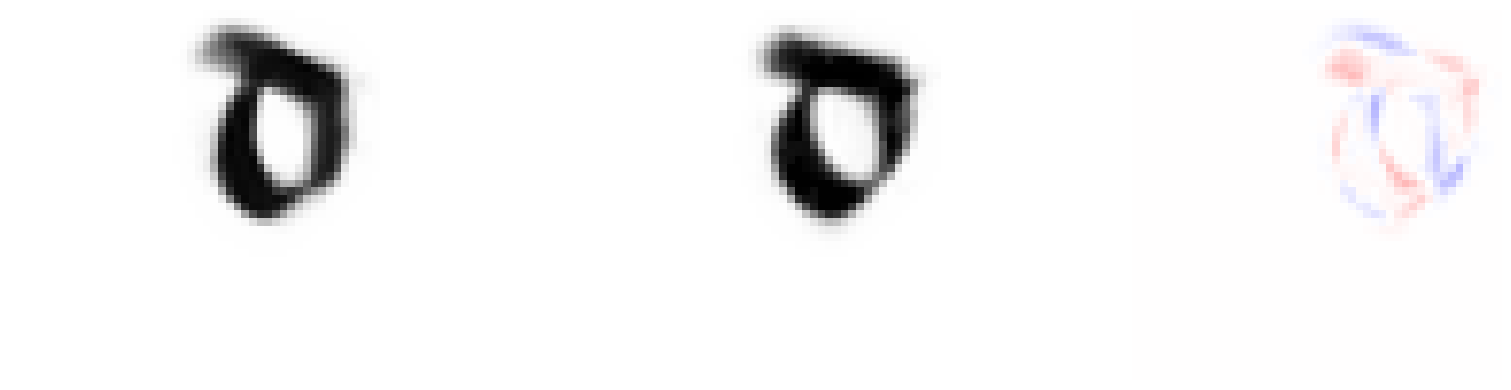

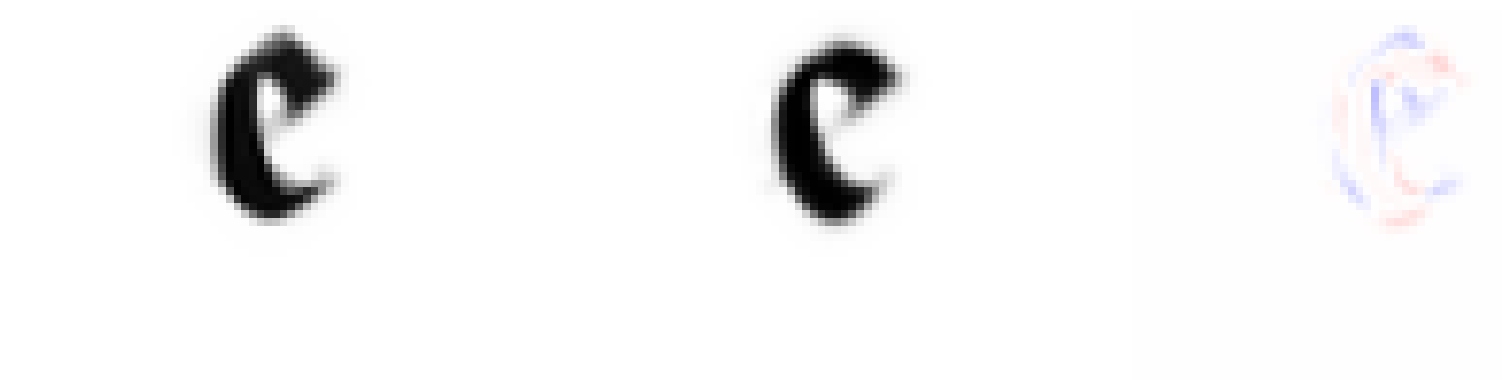

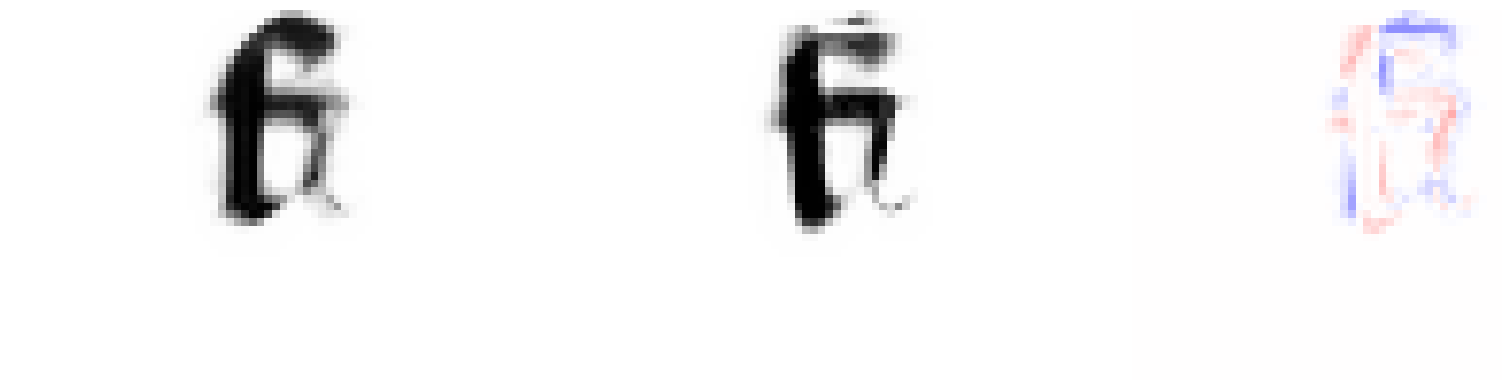

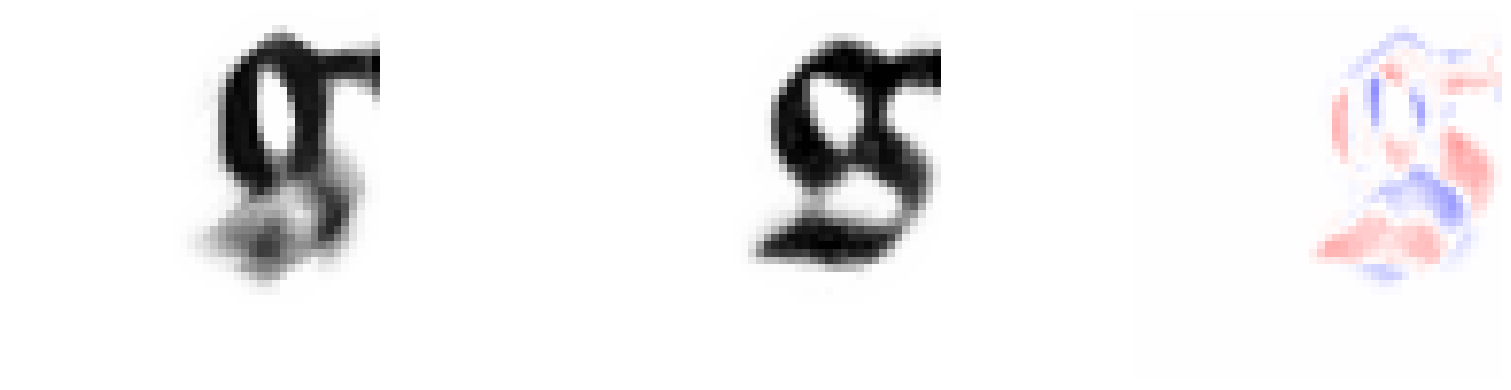

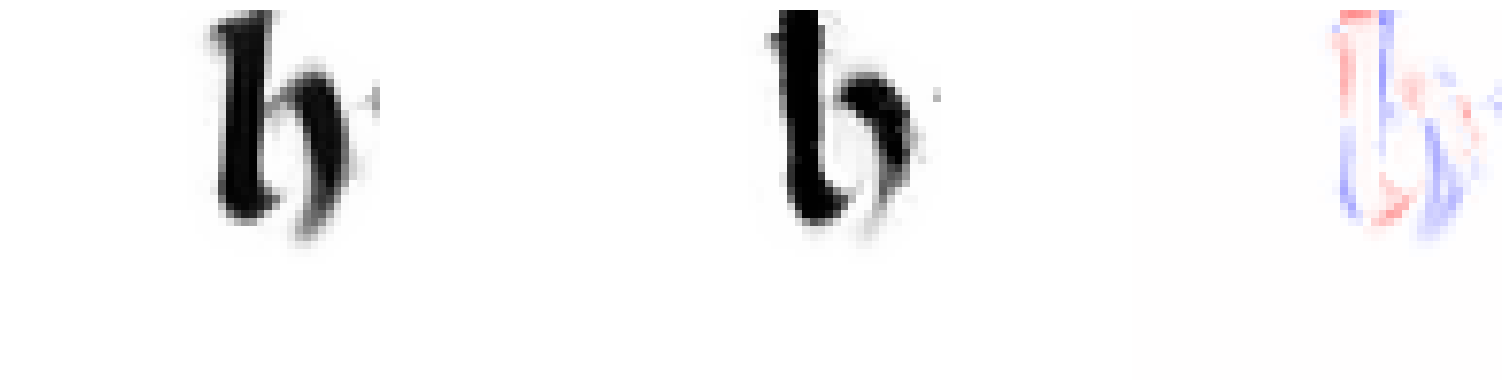

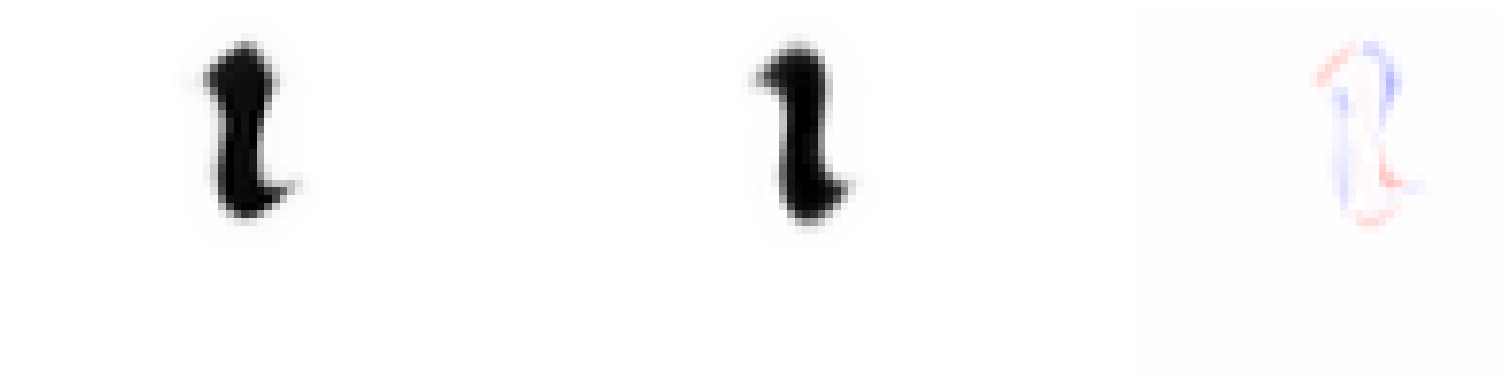

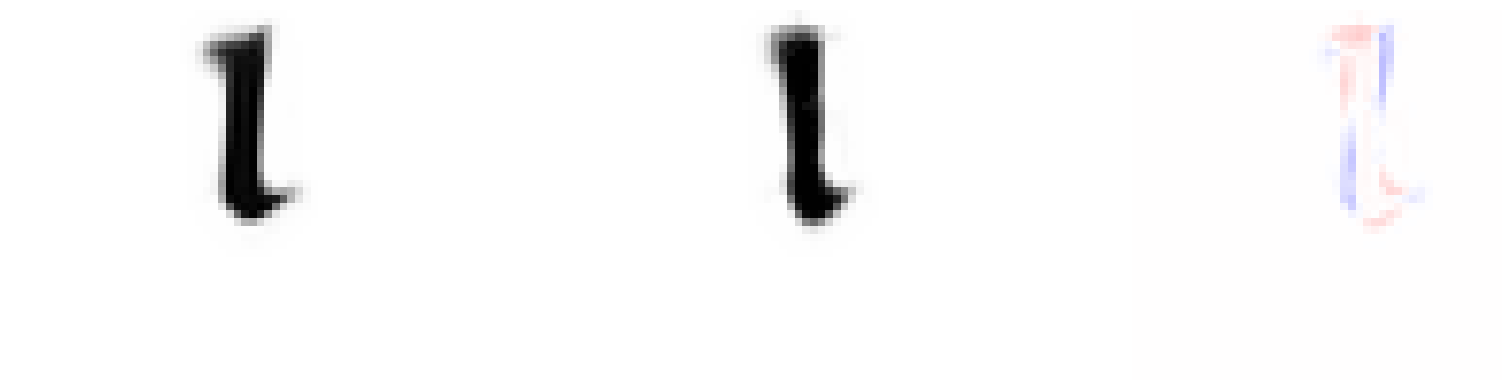

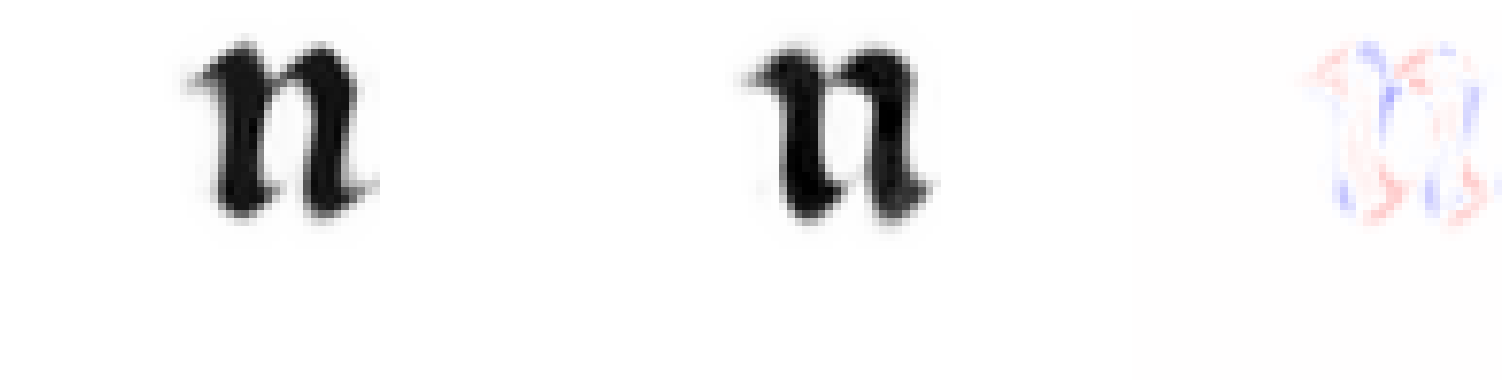

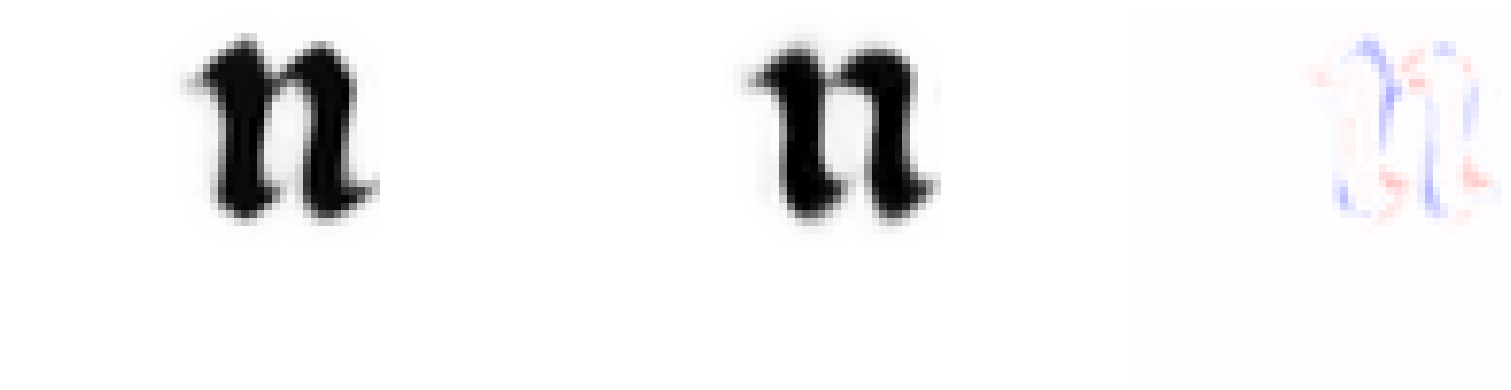

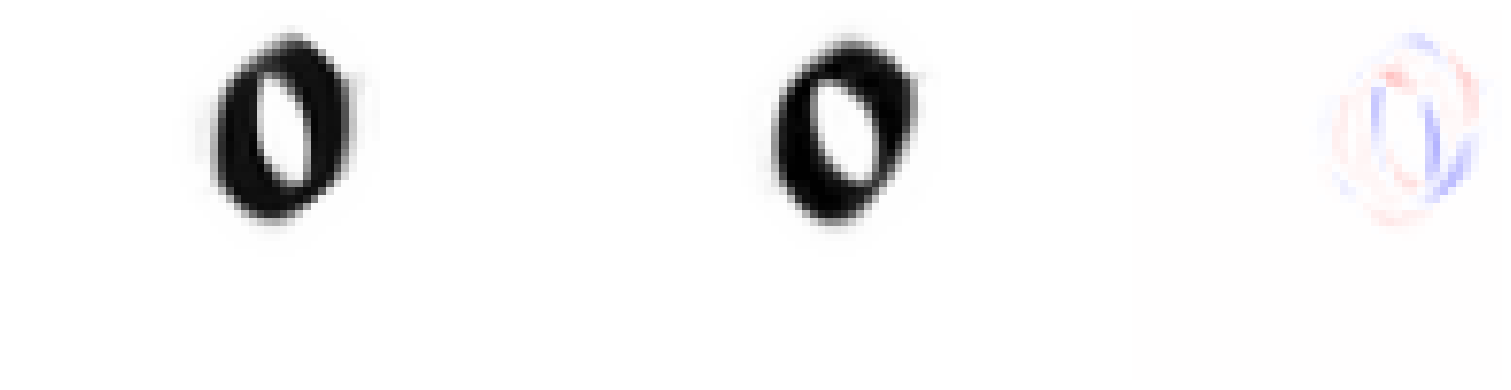

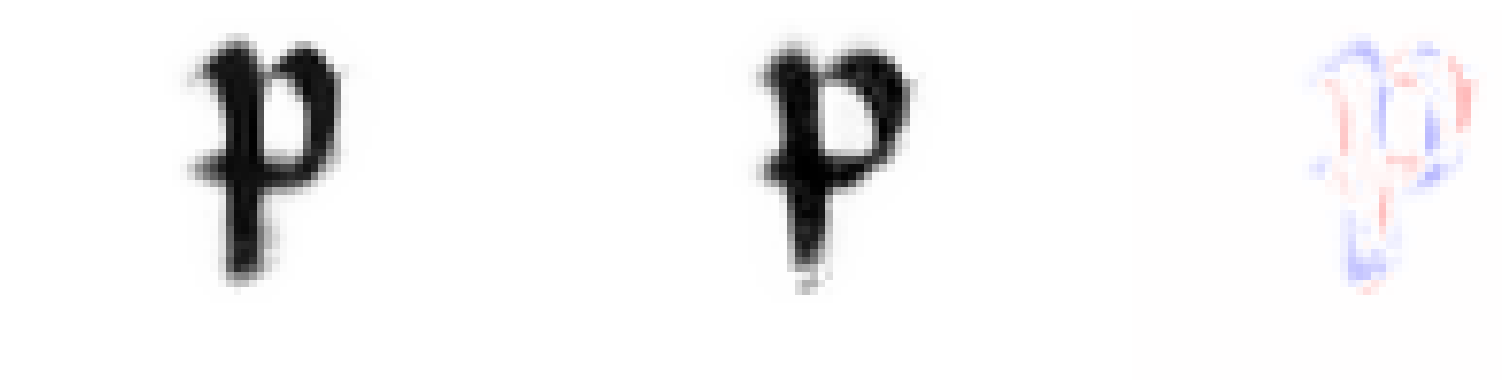

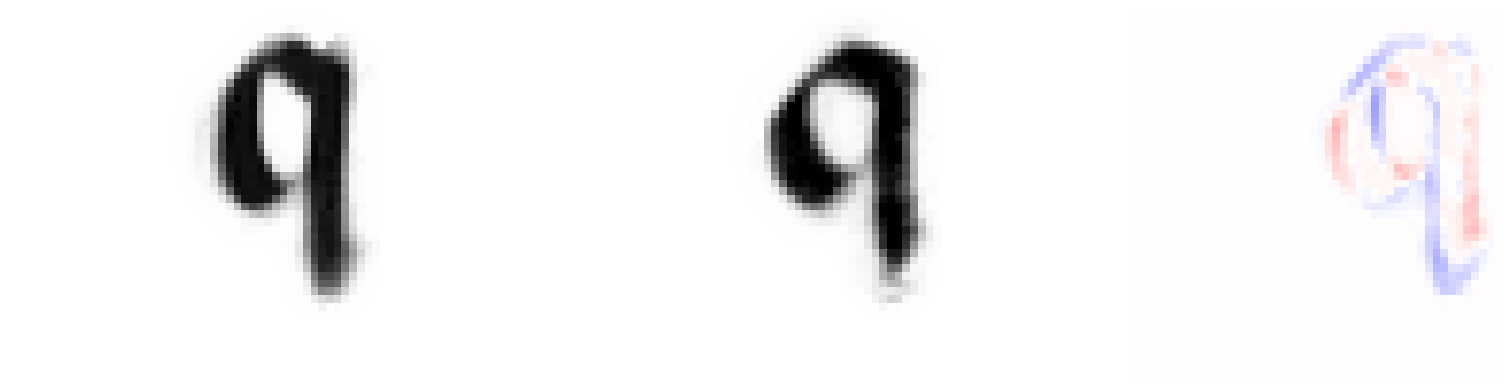

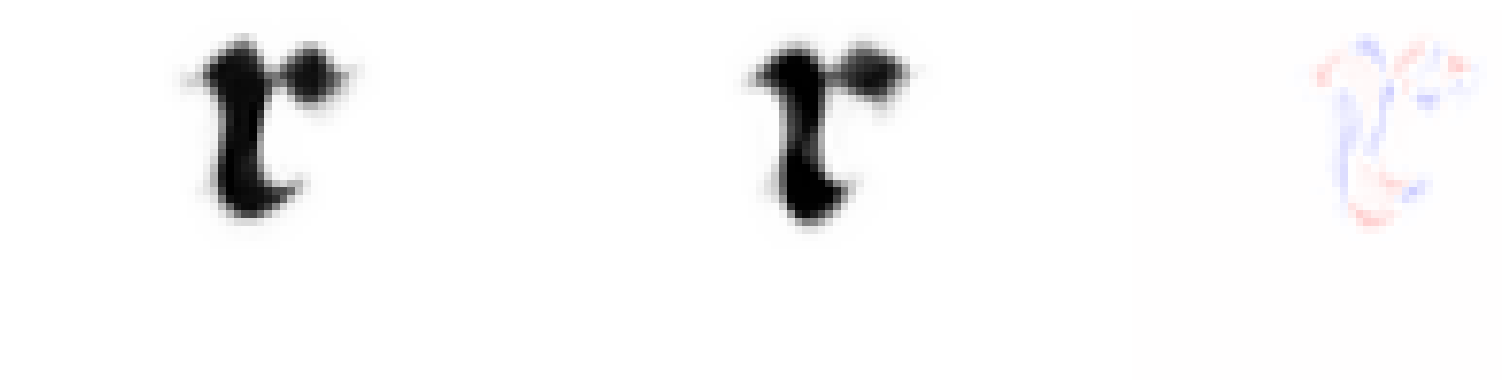

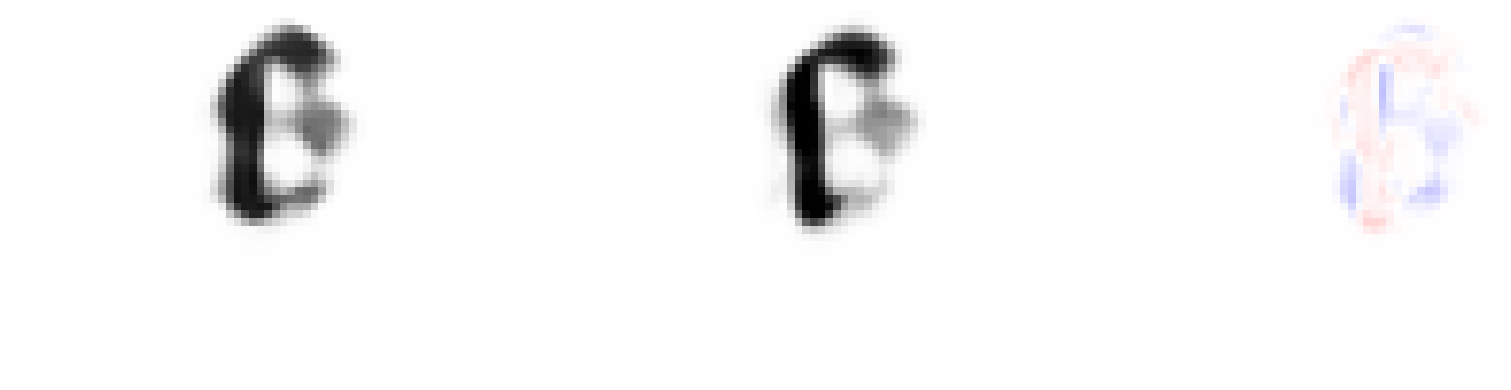

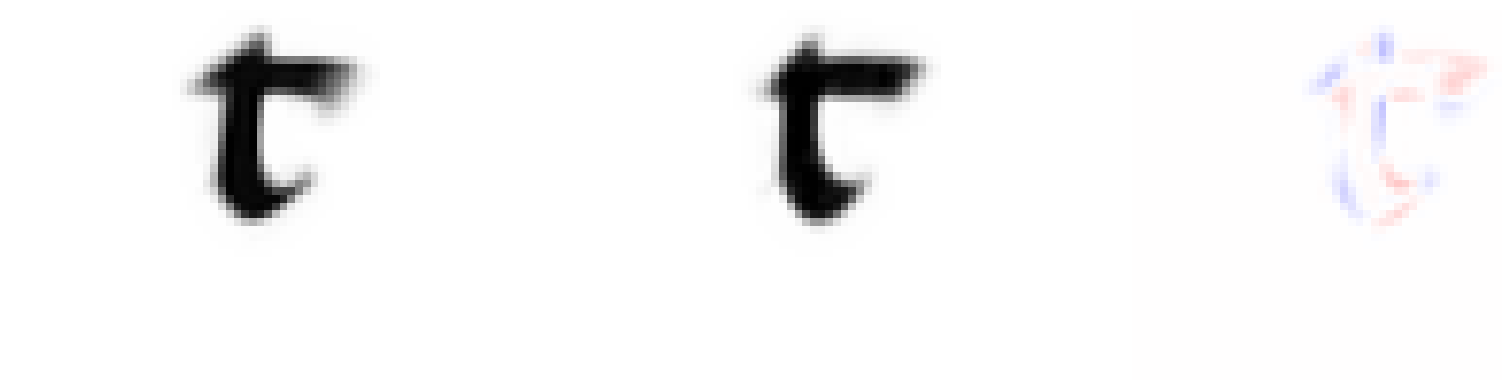

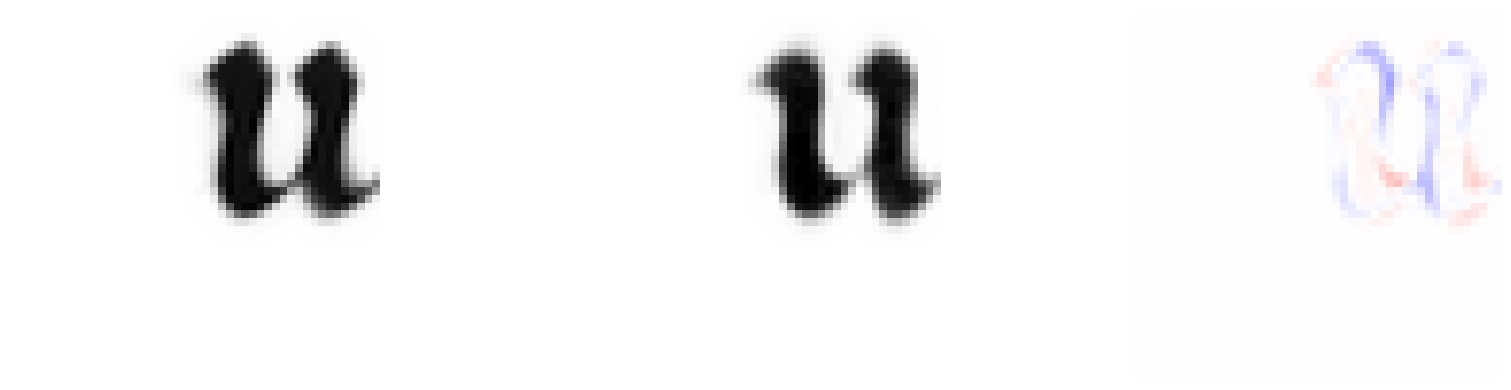

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/btv1b100361755


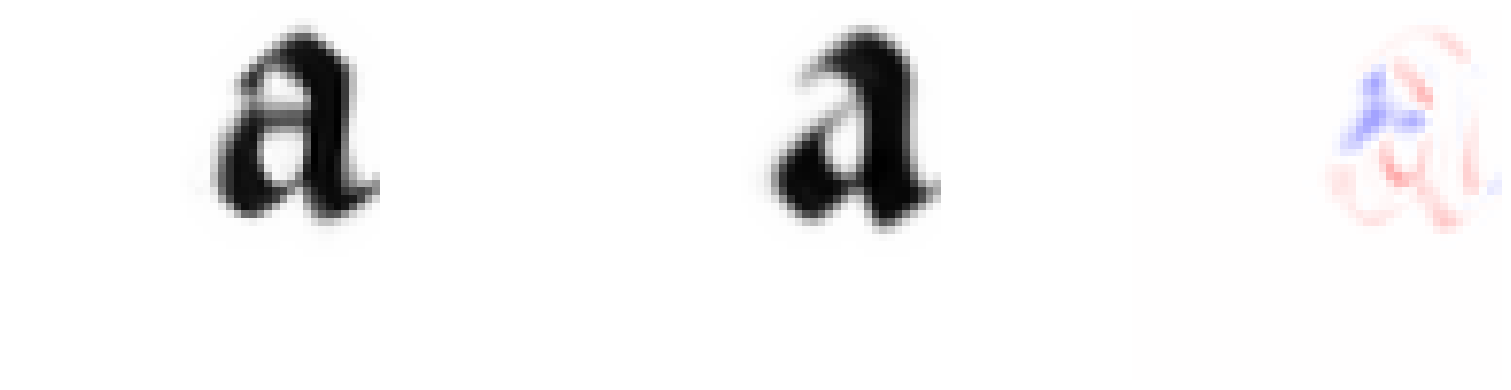

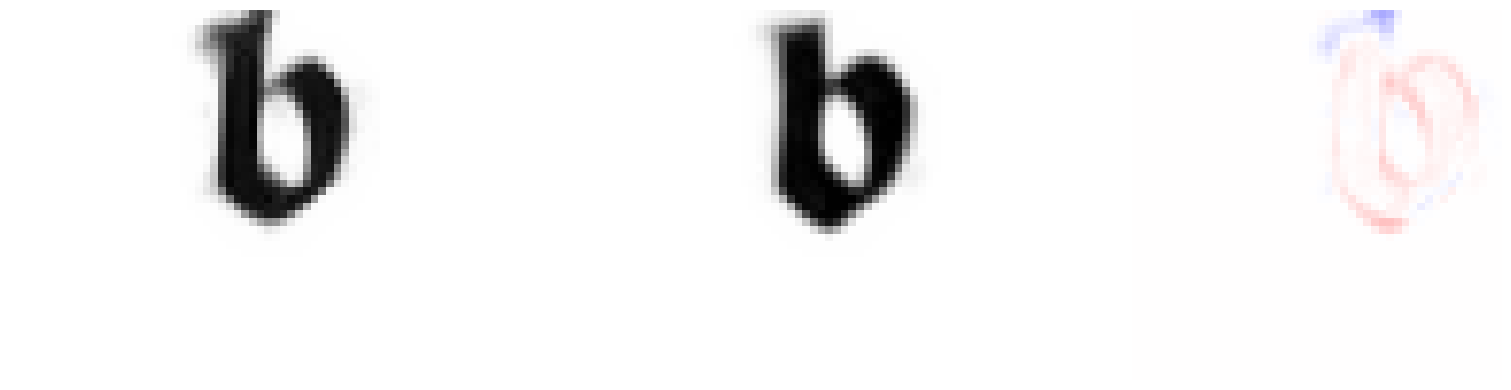

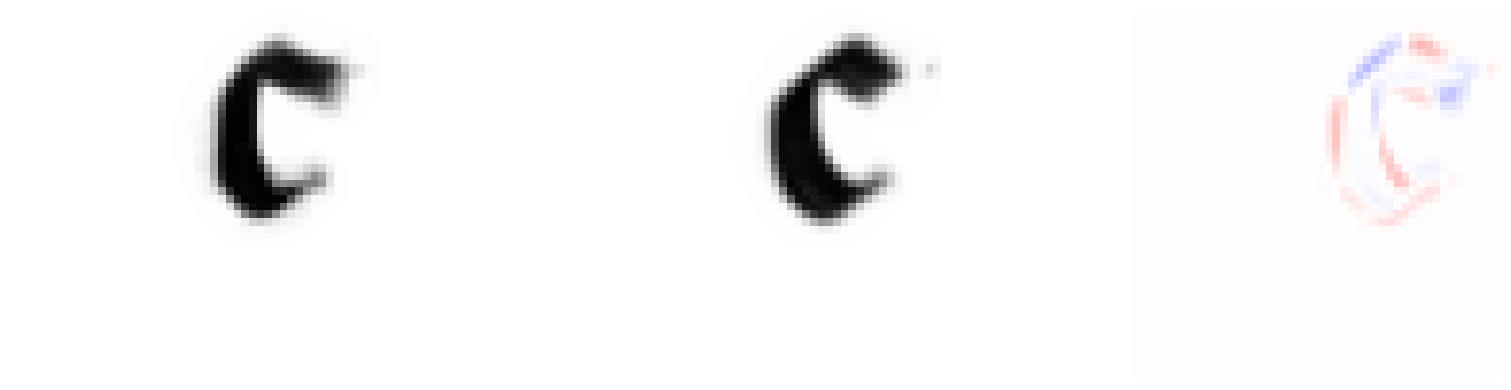

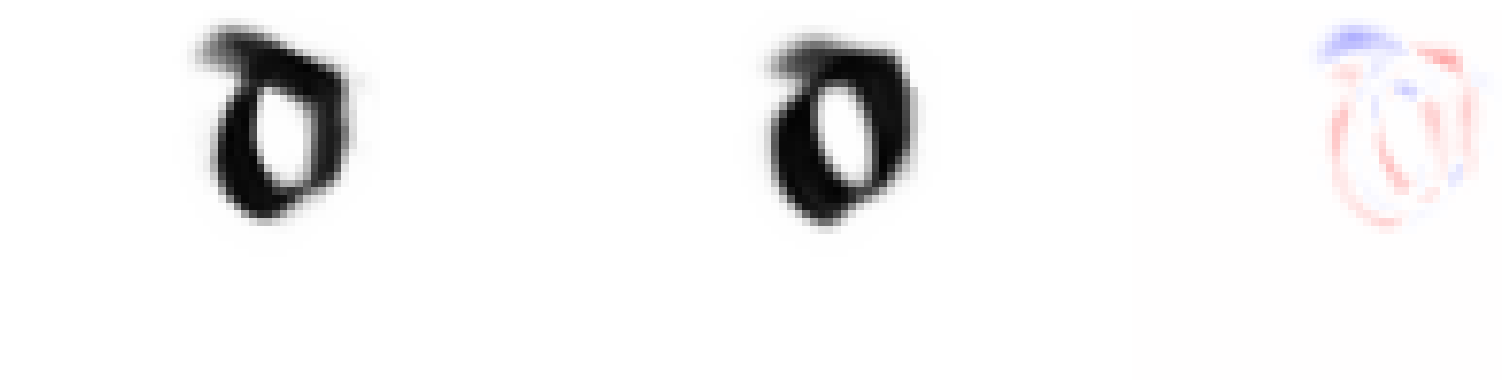

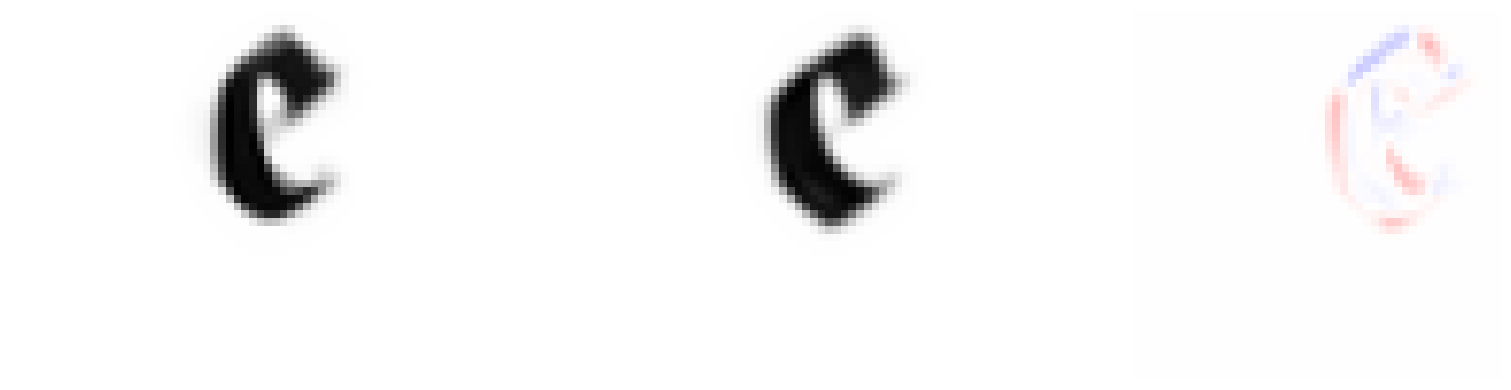

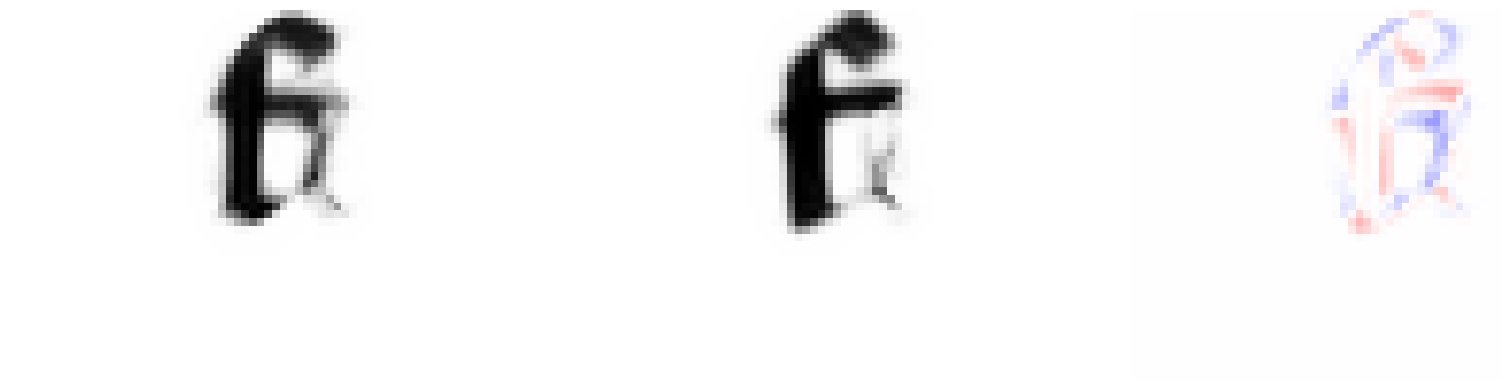

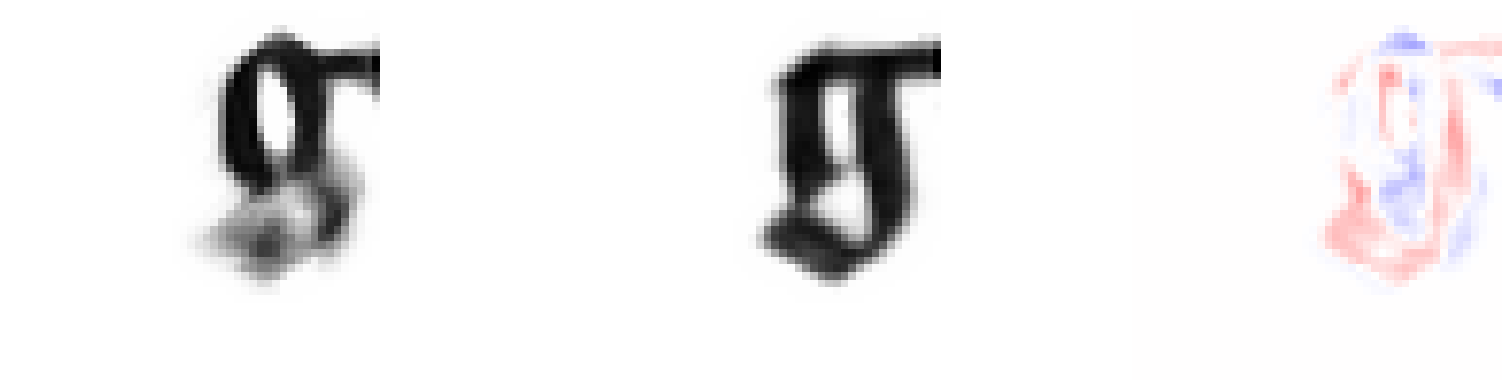

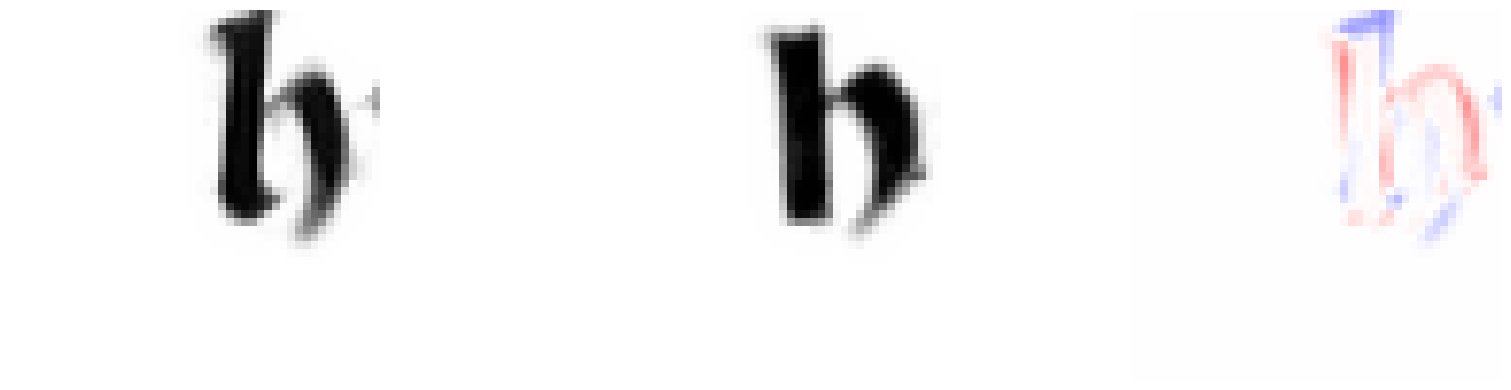

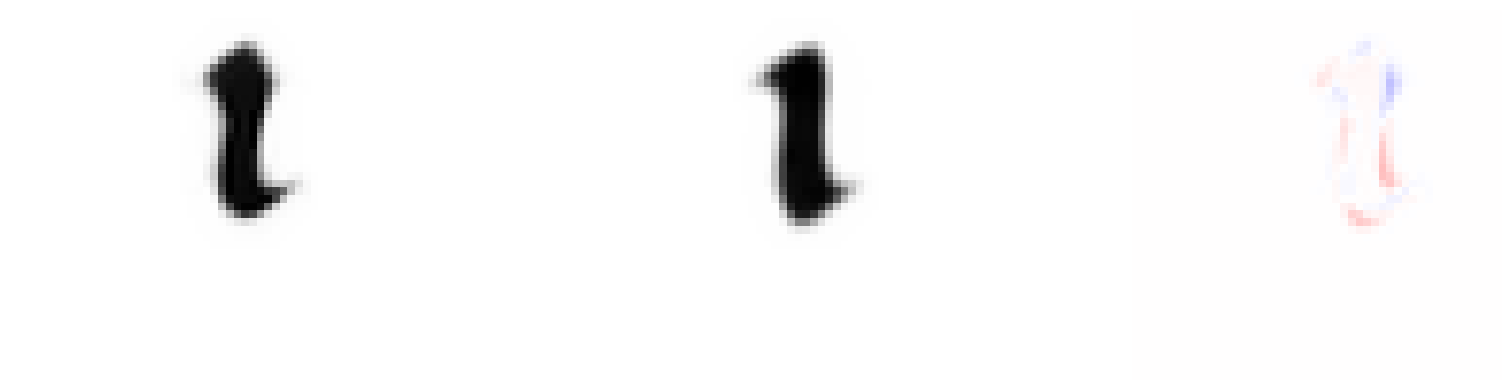

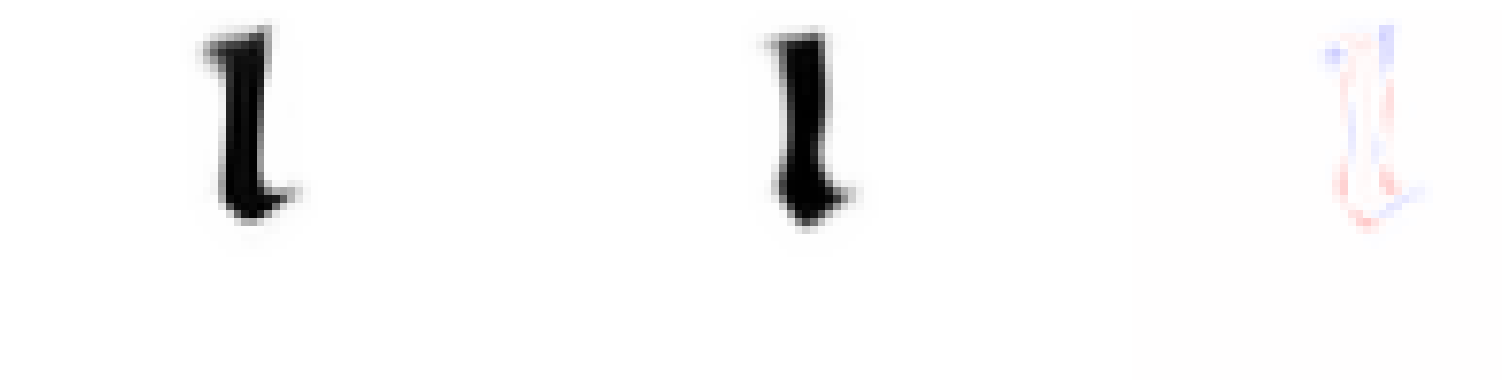

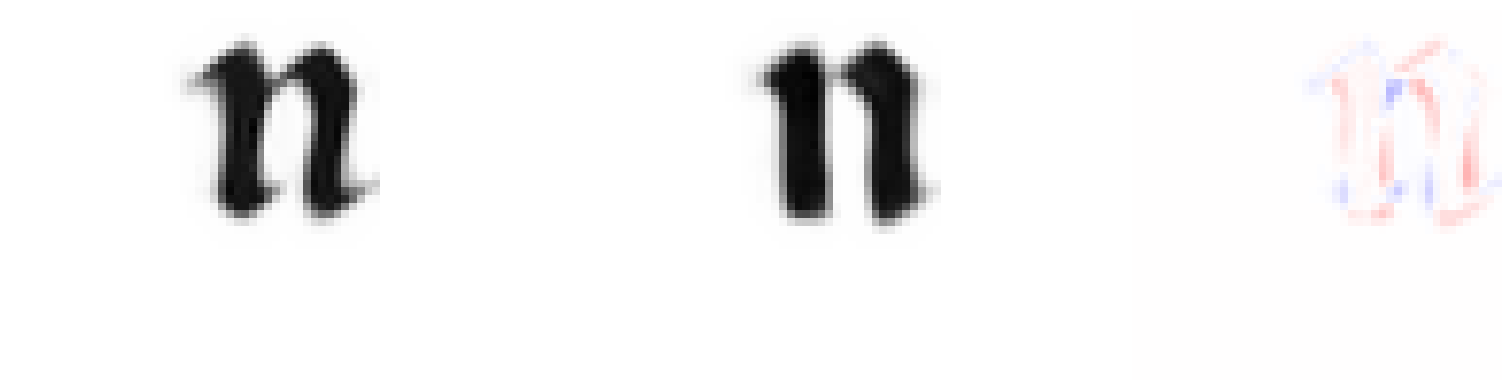

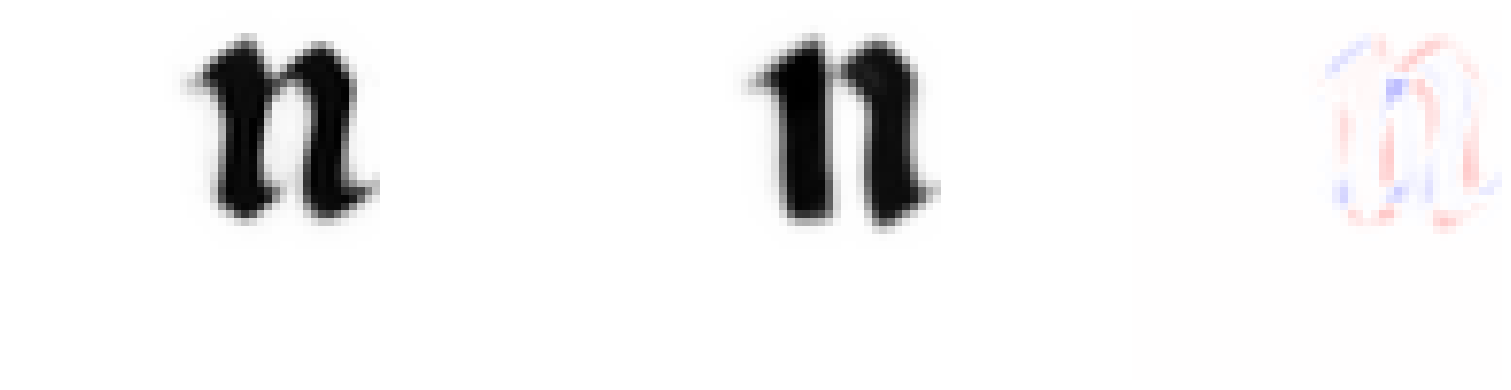

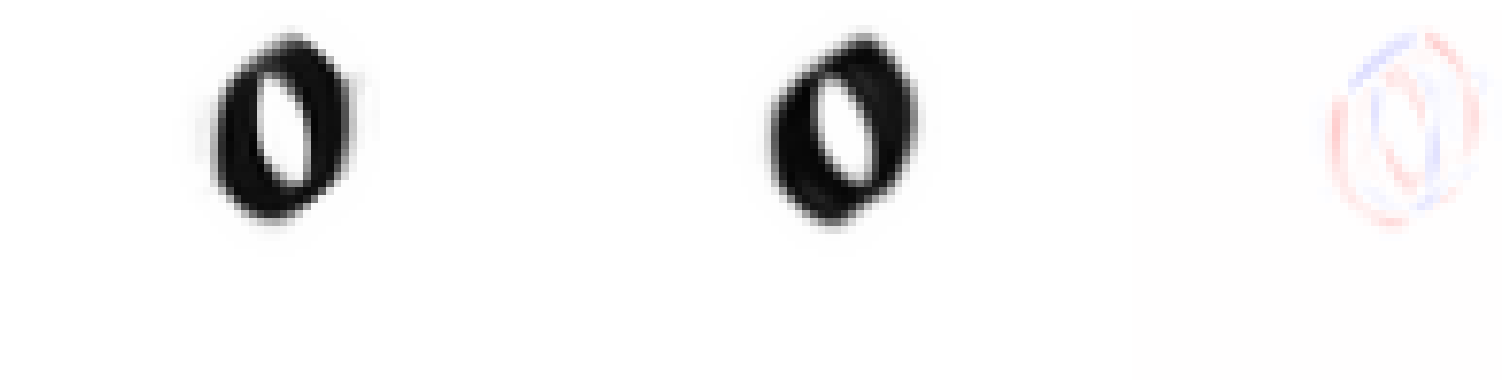

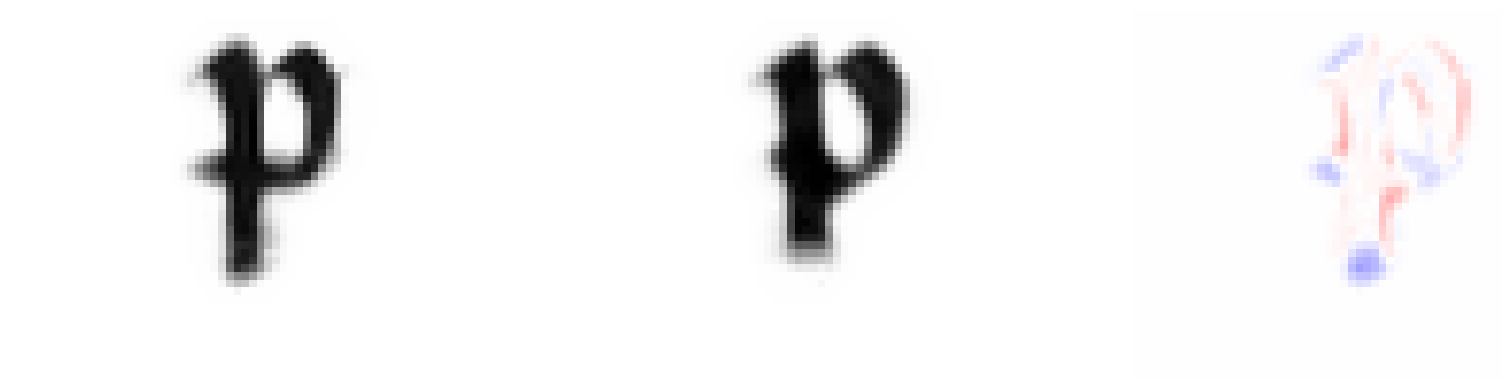

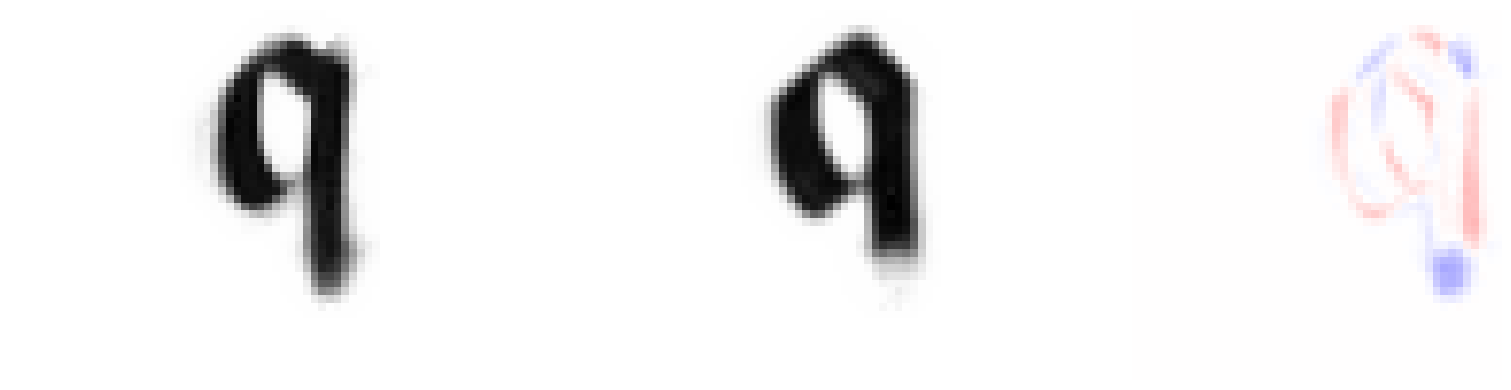

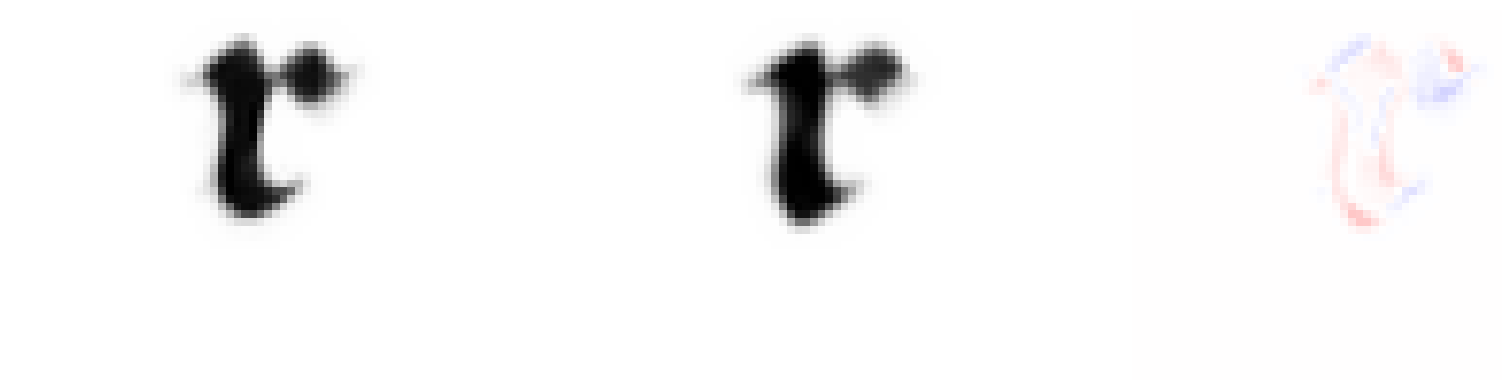

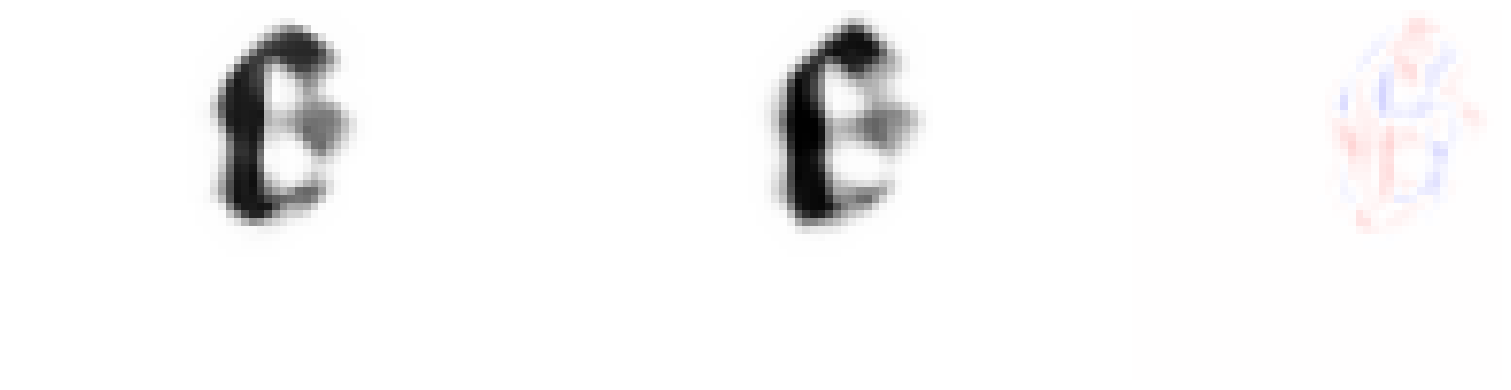

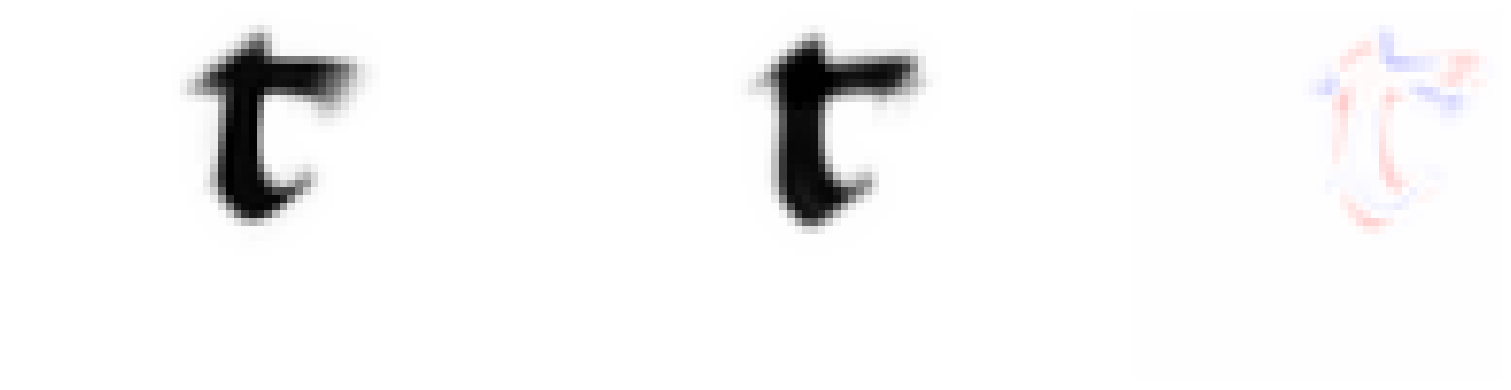

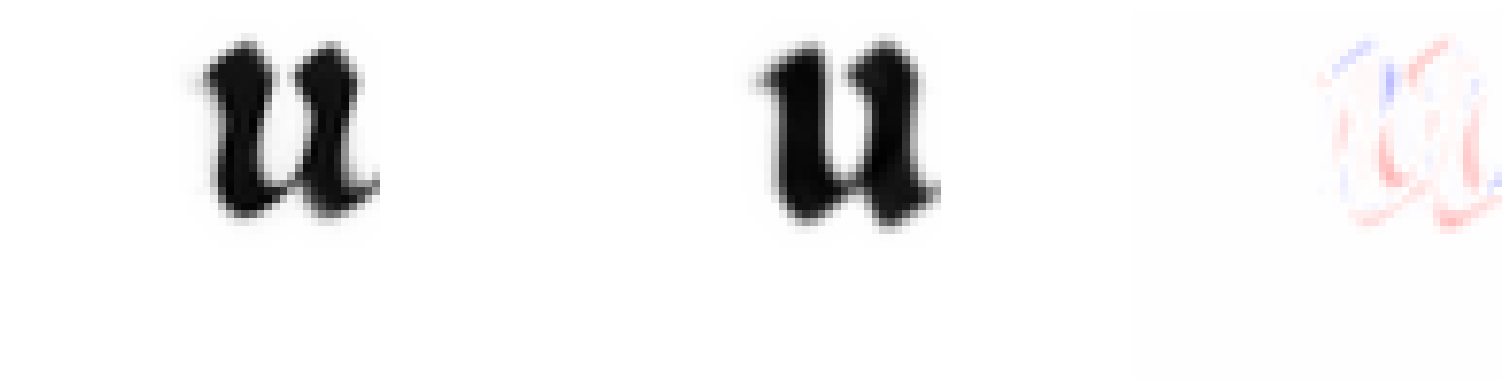

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/btv1b8433319z


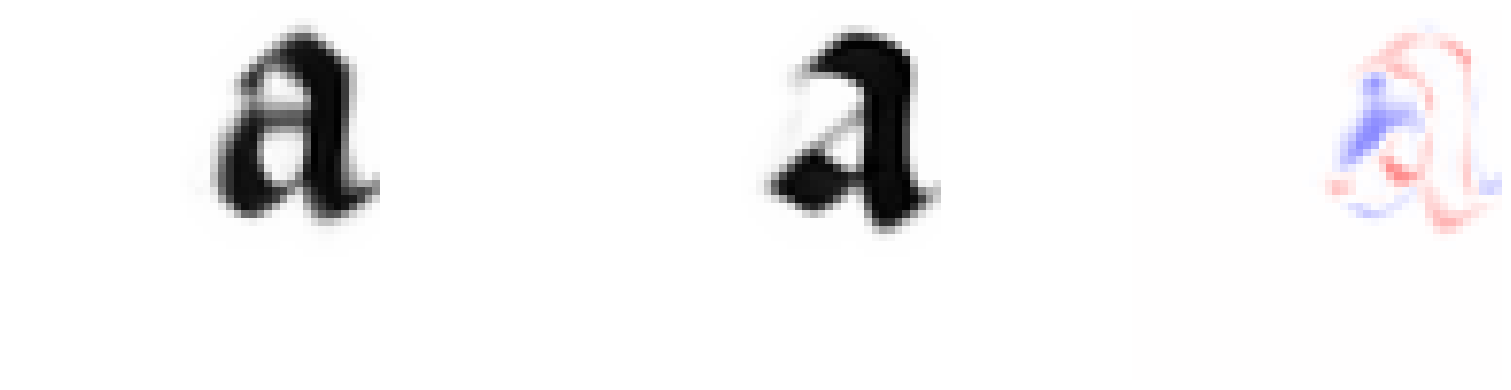

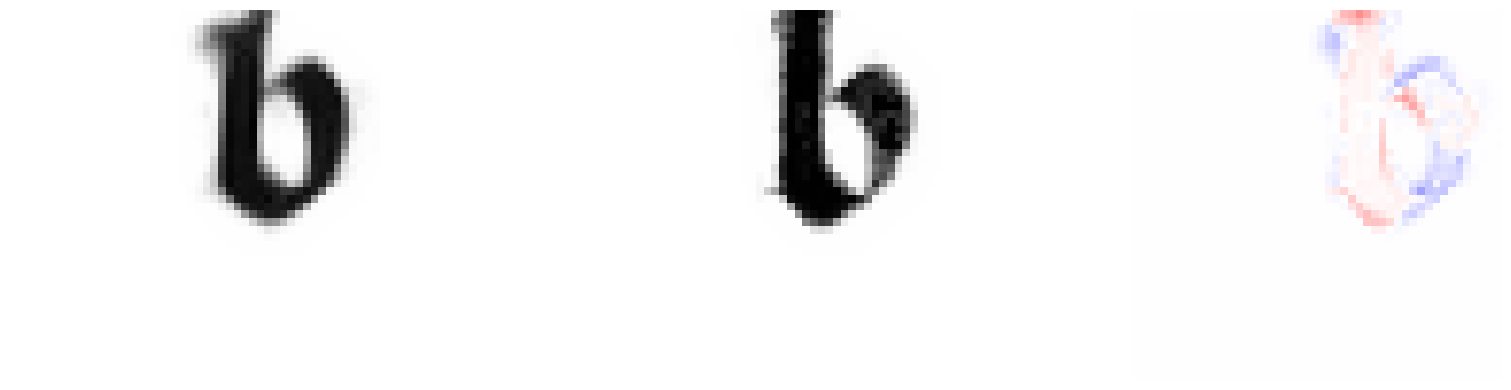

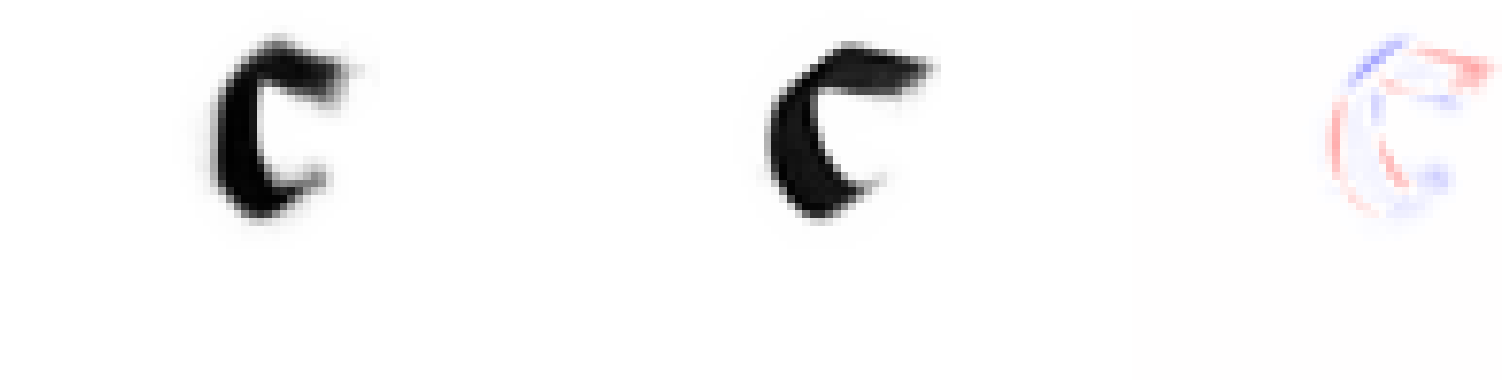

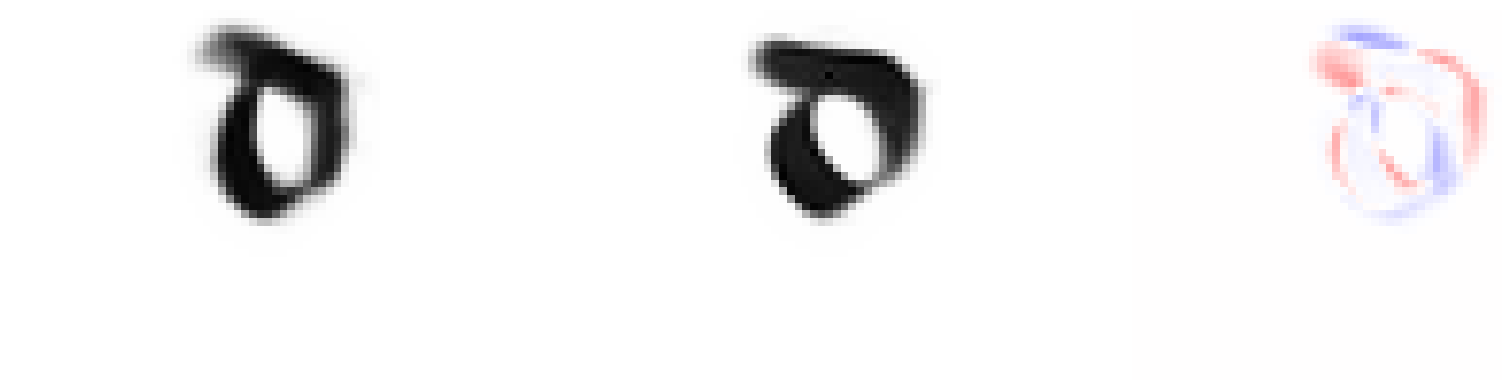

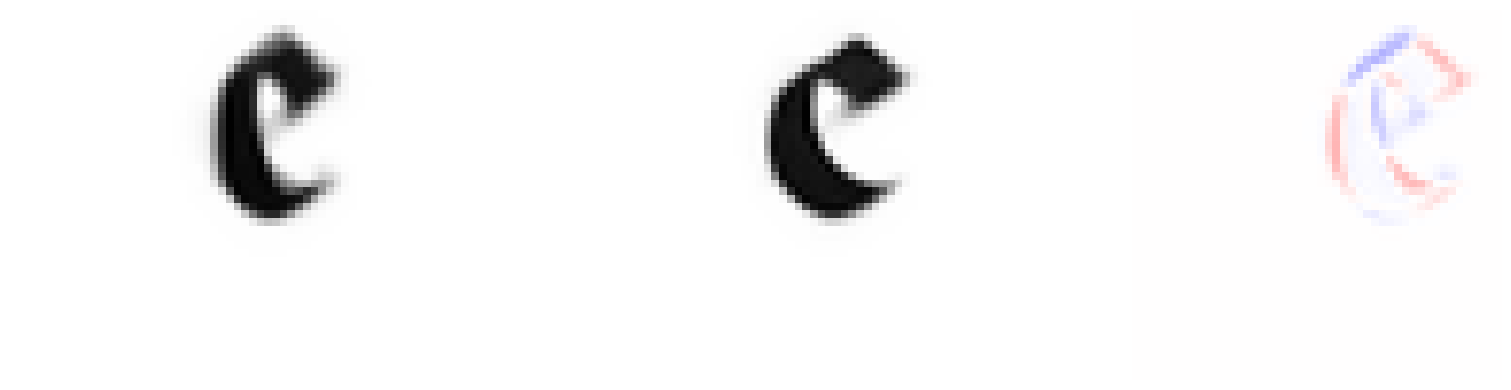

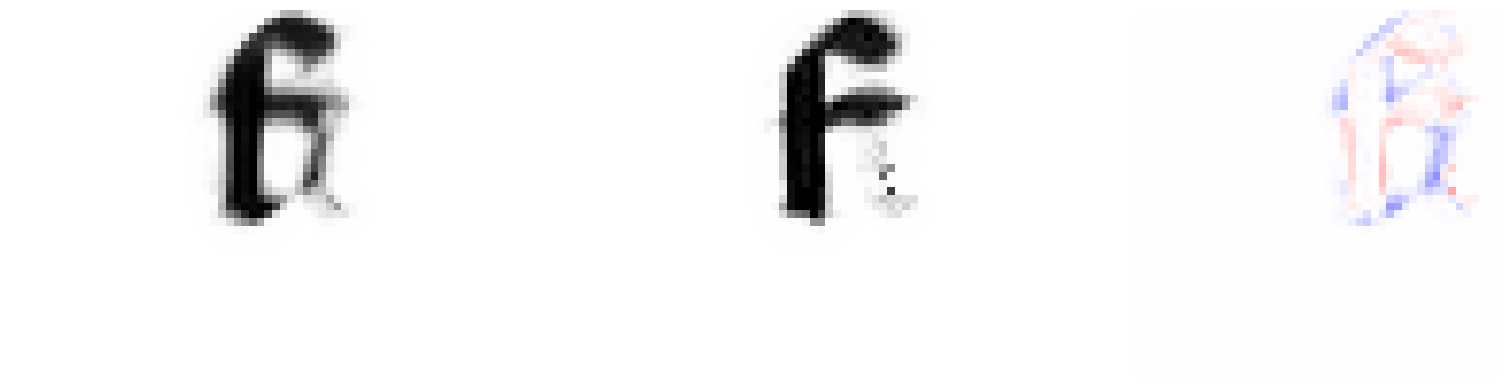

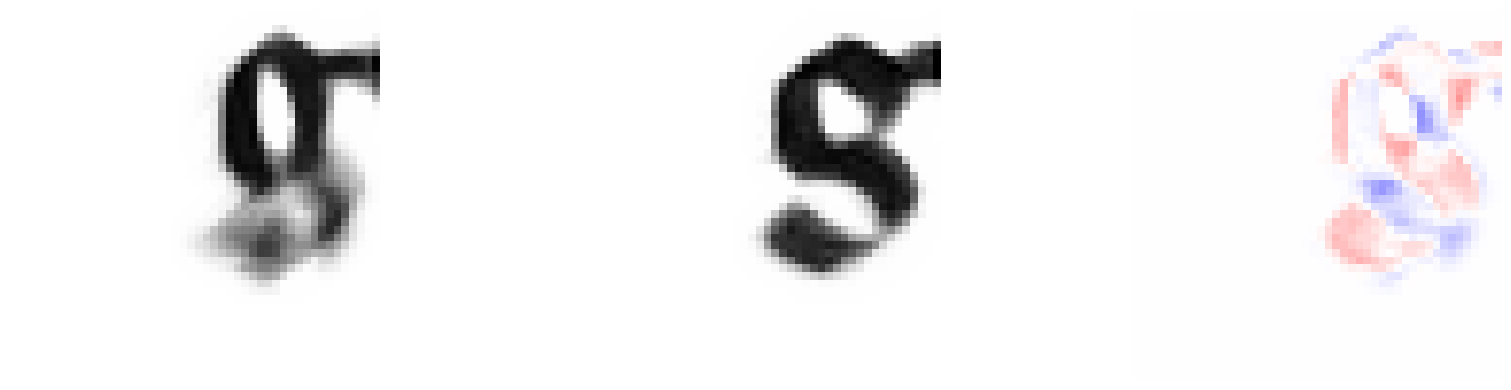

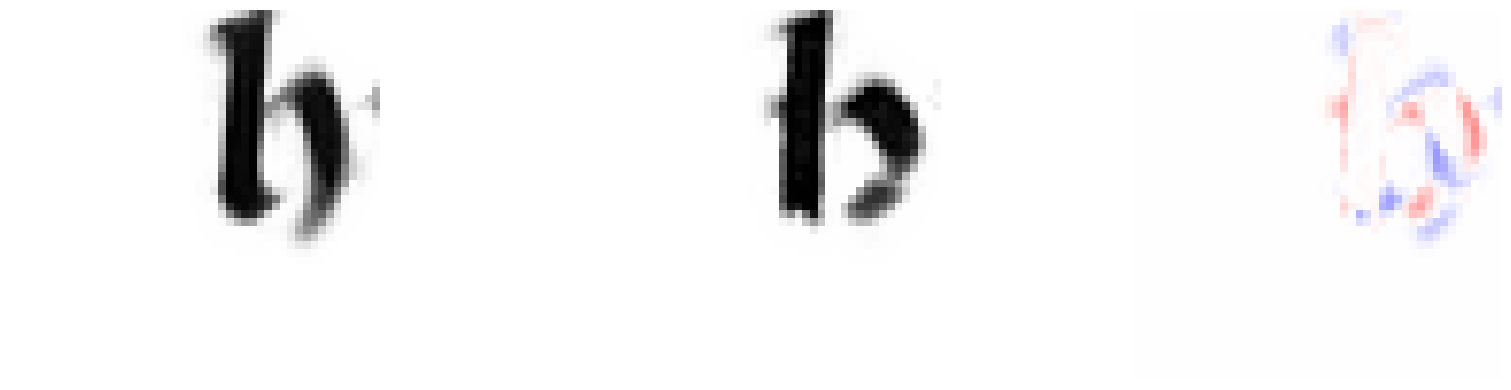

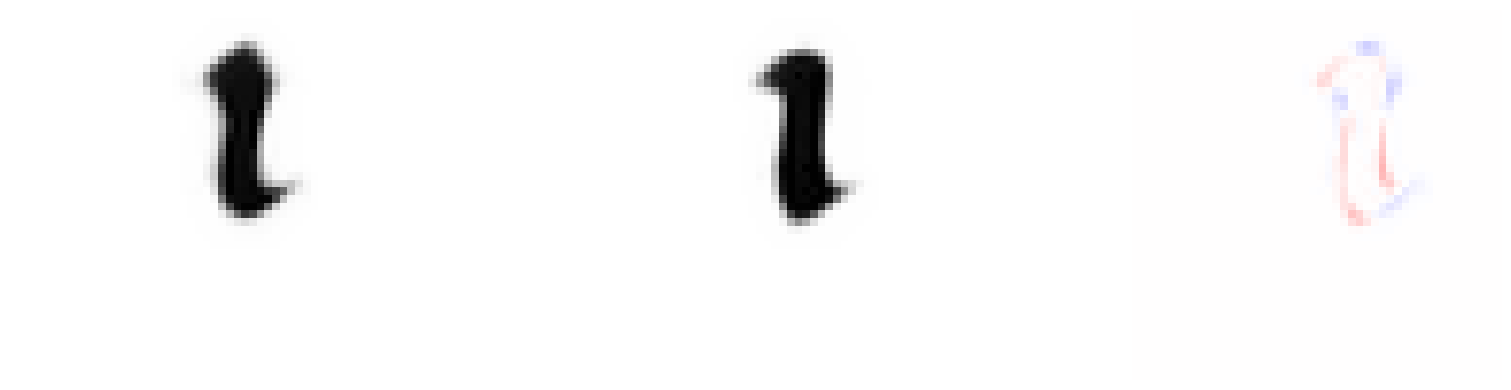

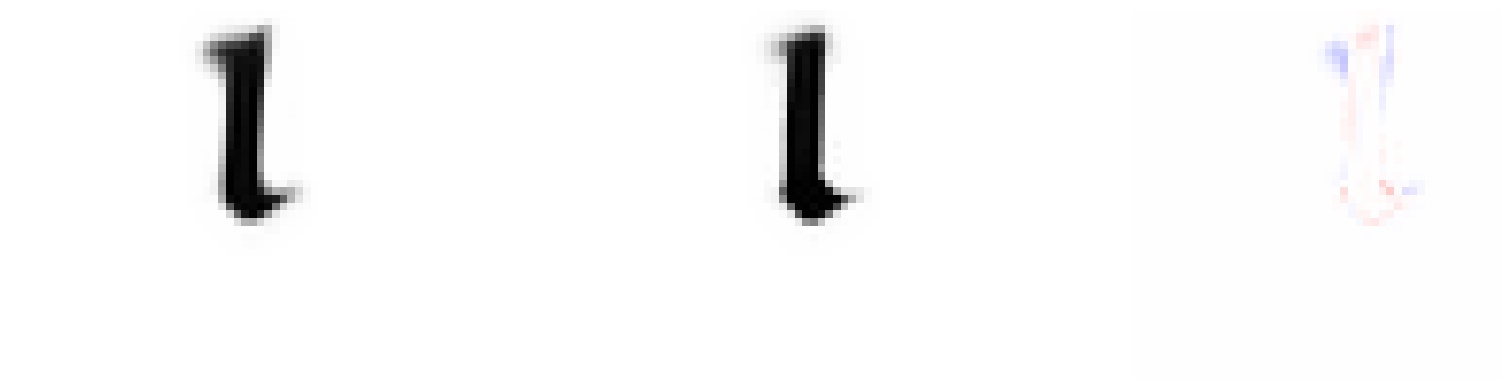

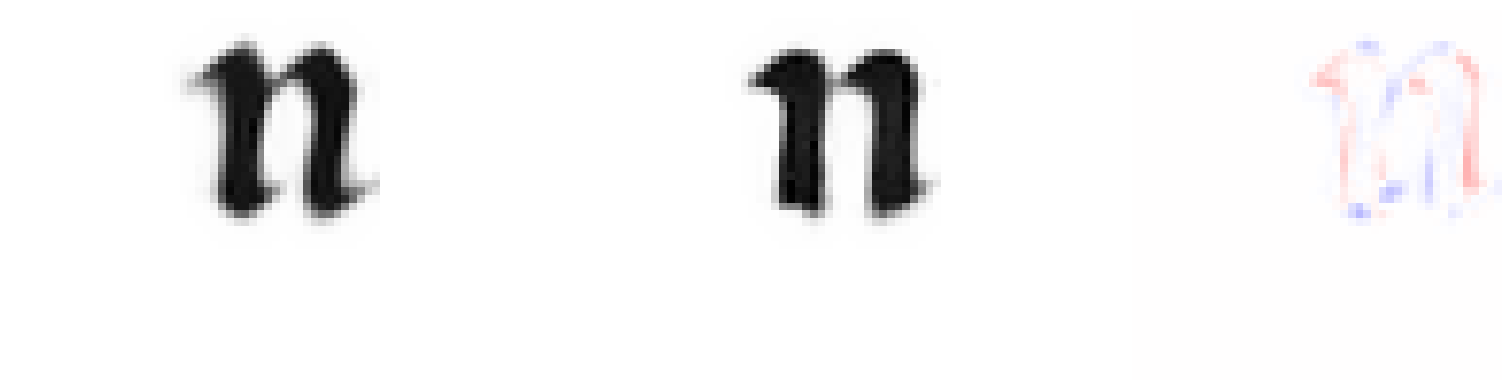

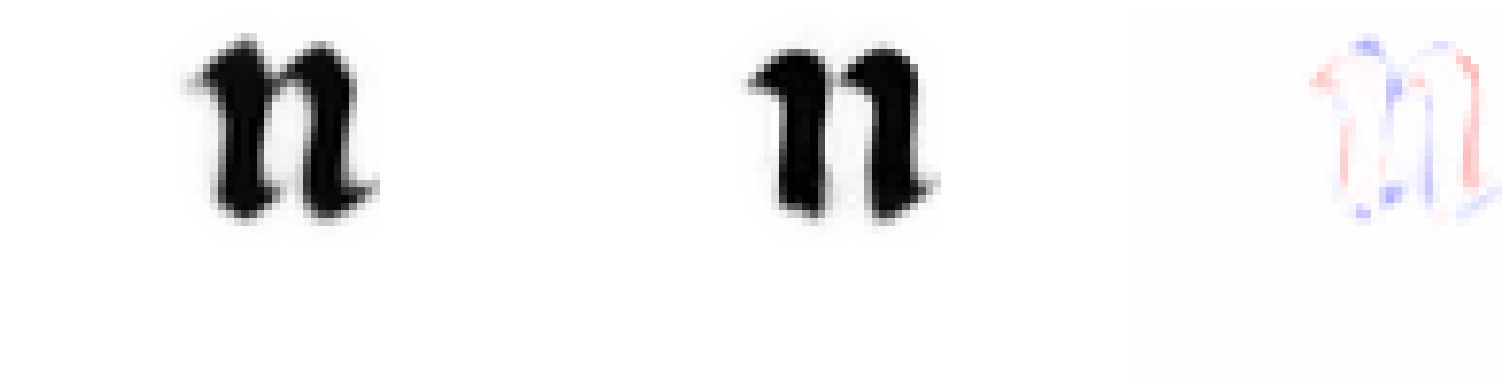

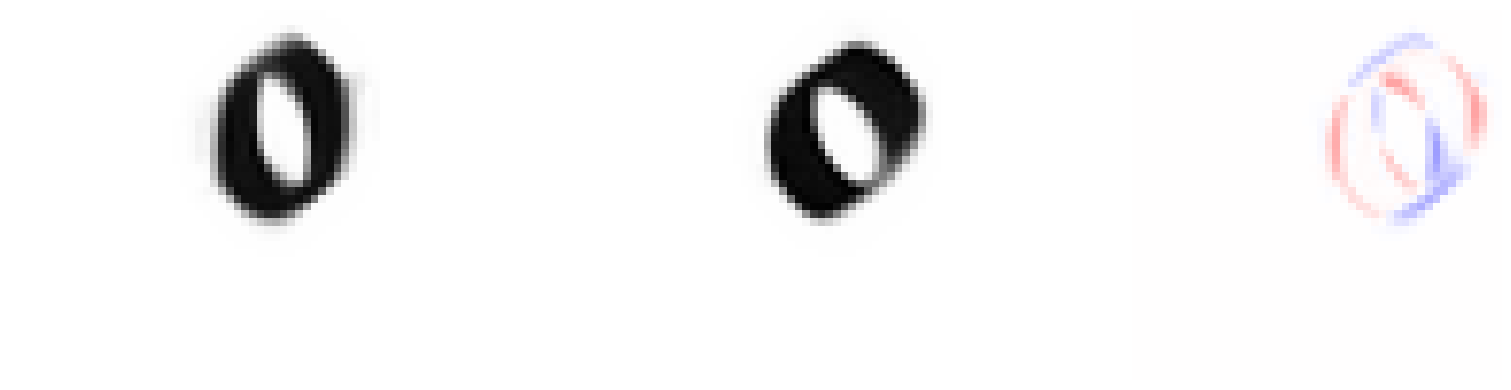

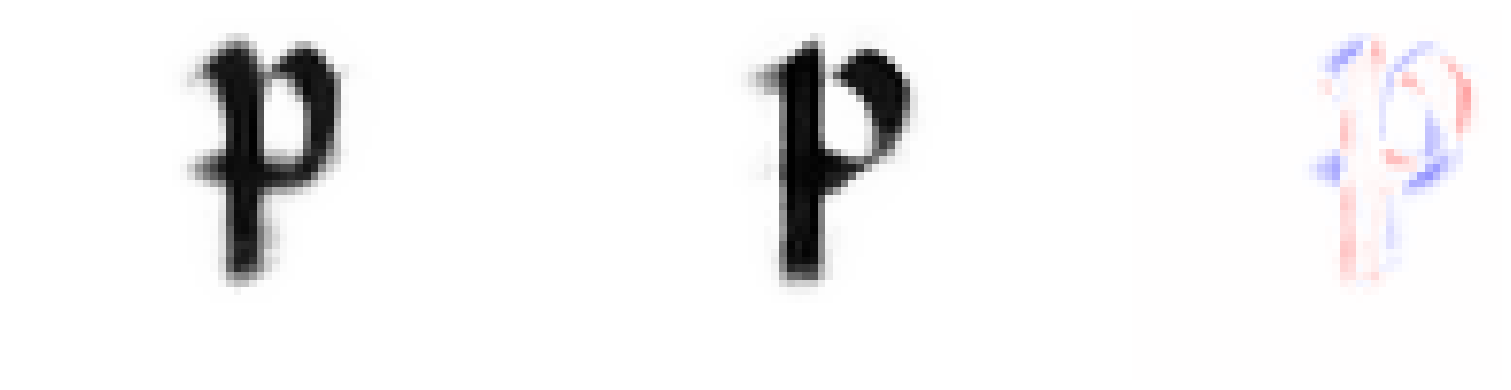

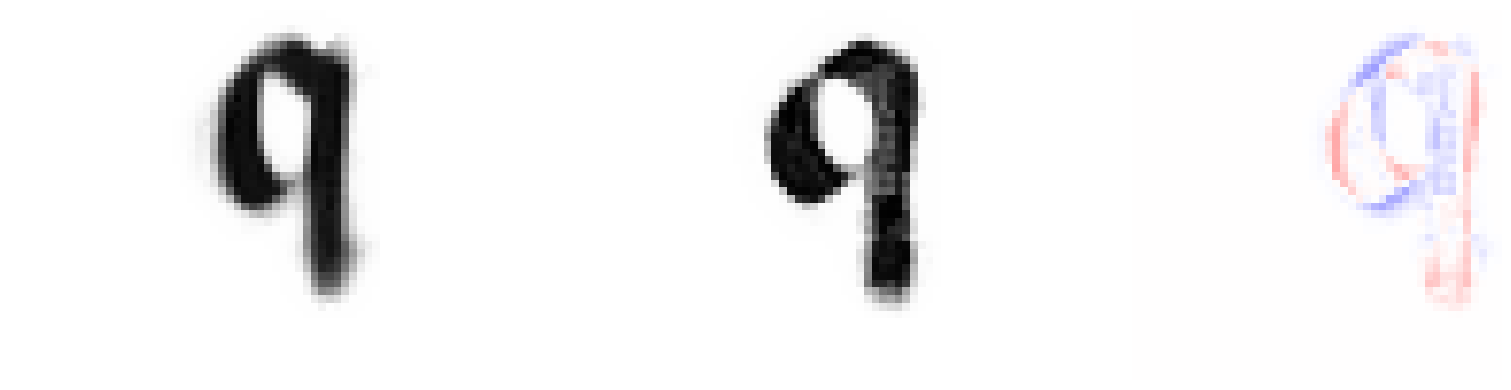

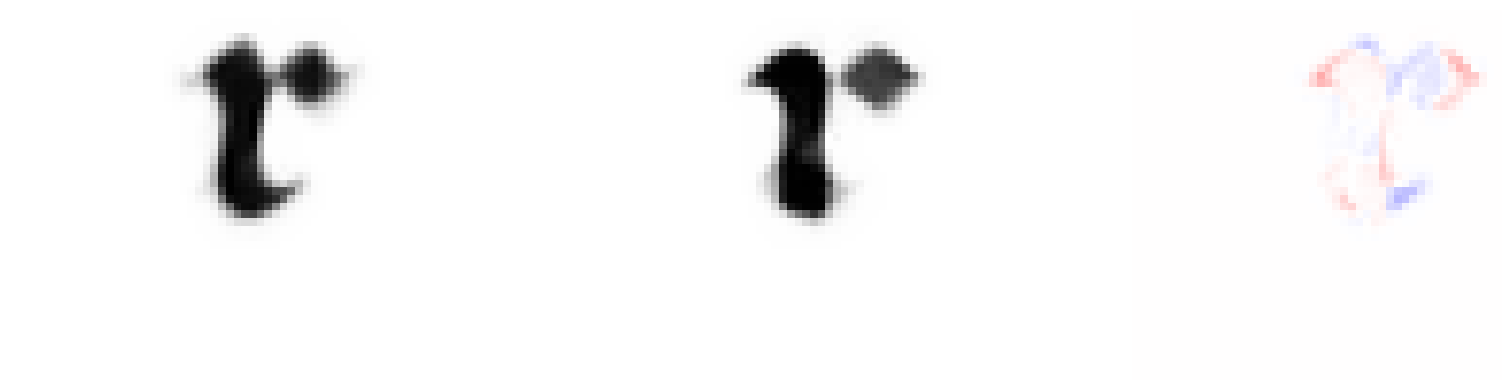

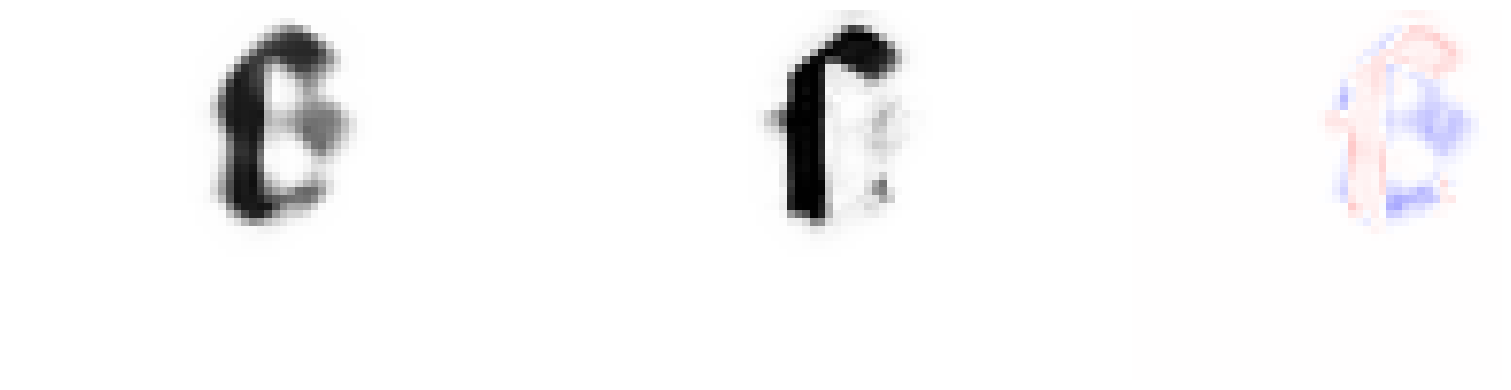

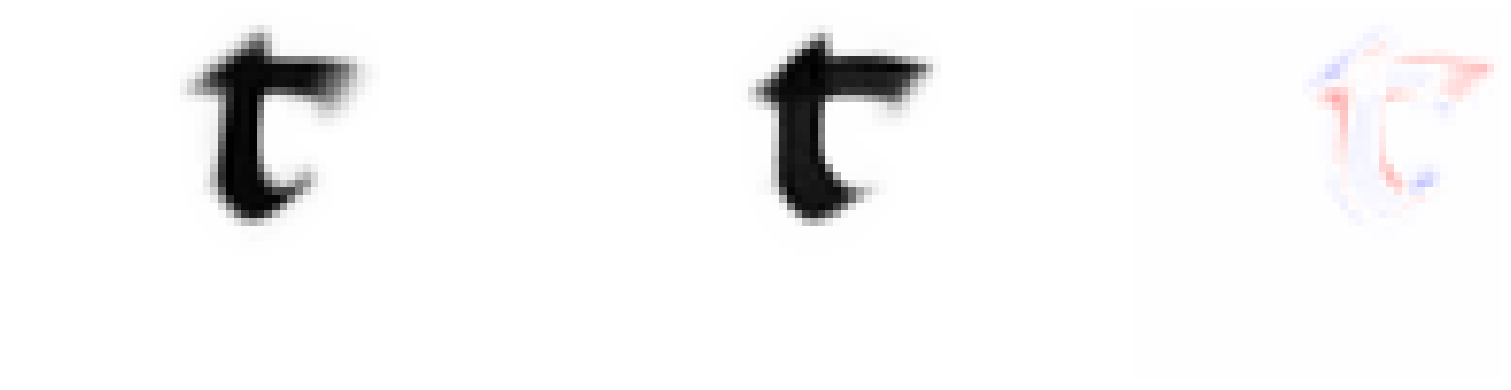

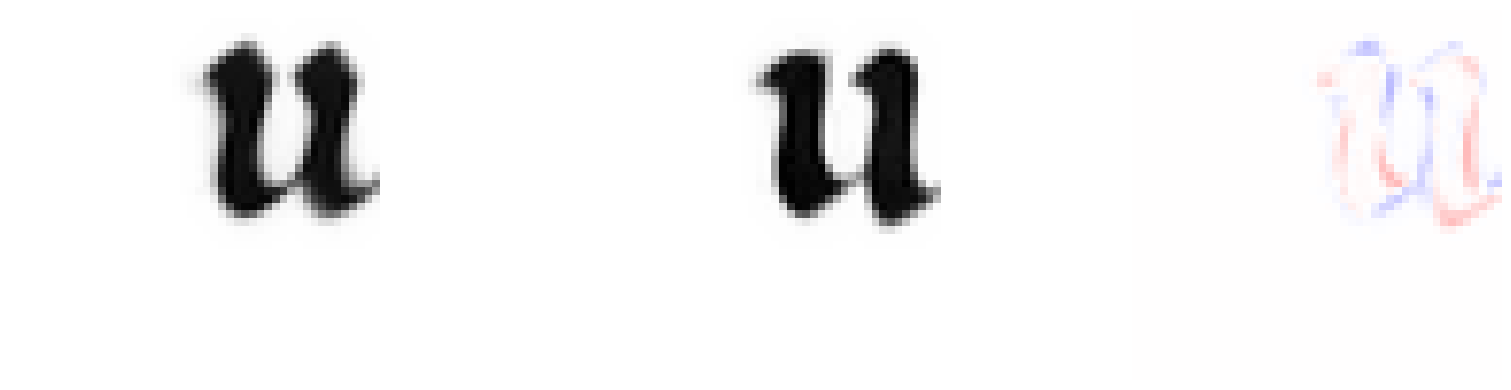

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/IB15304245v


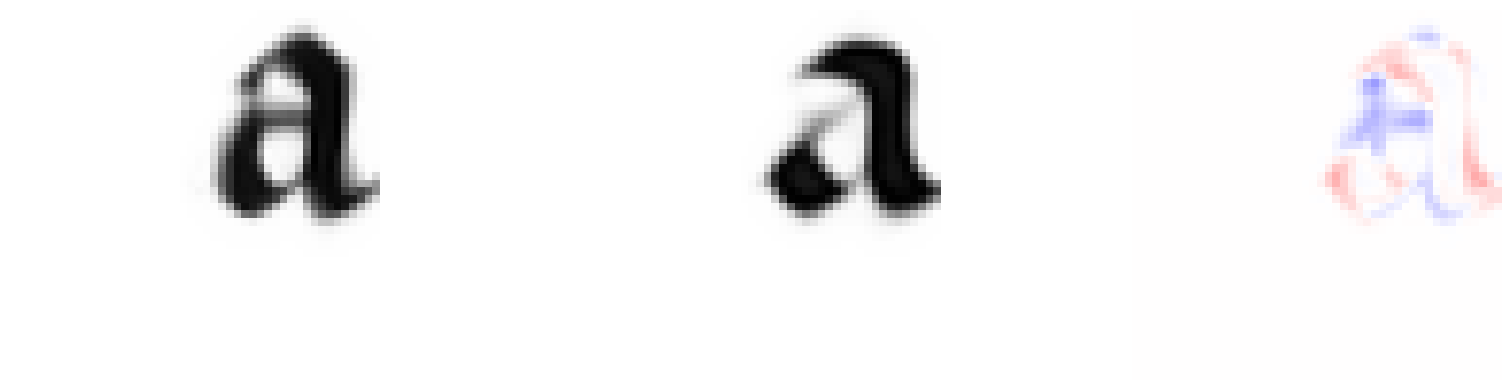

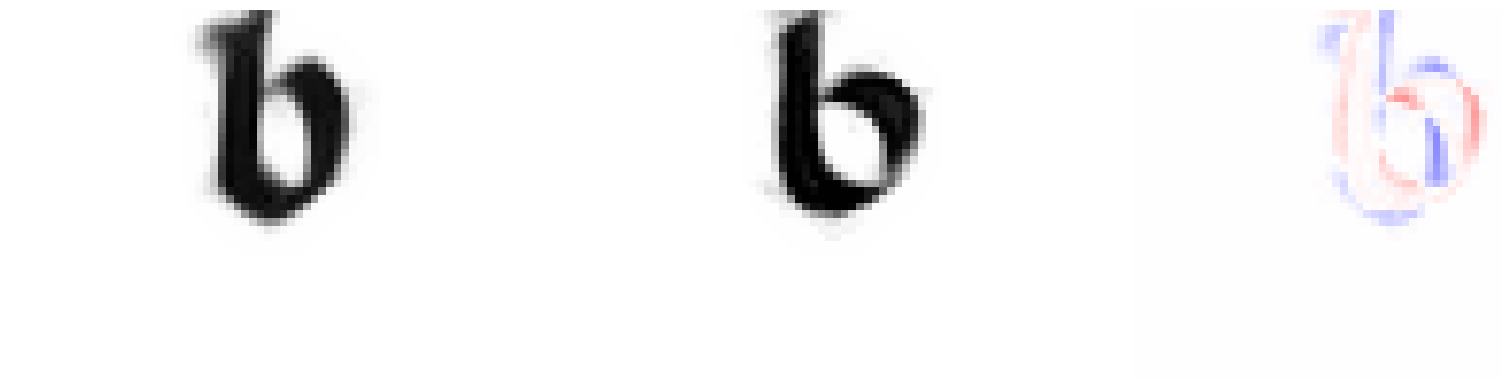

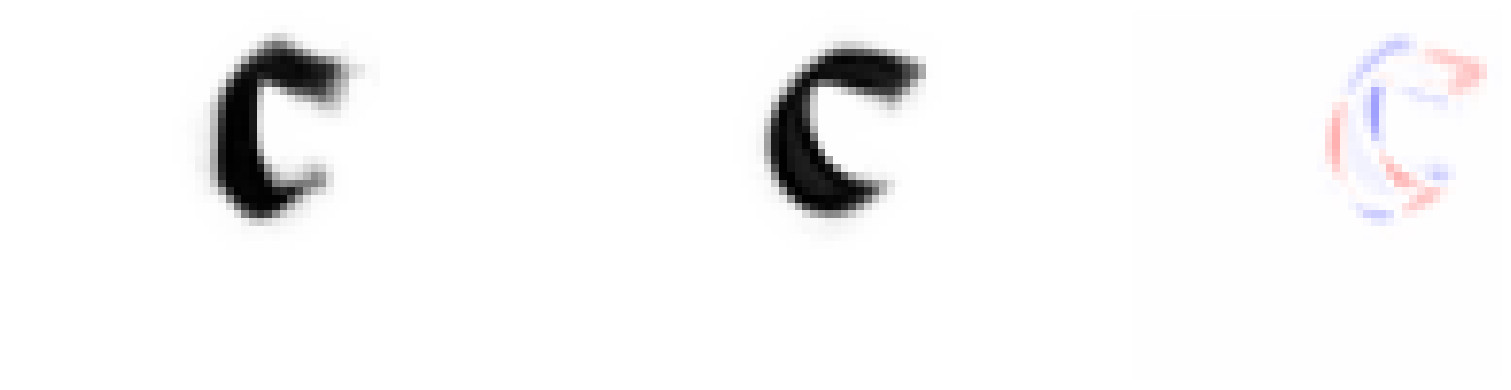

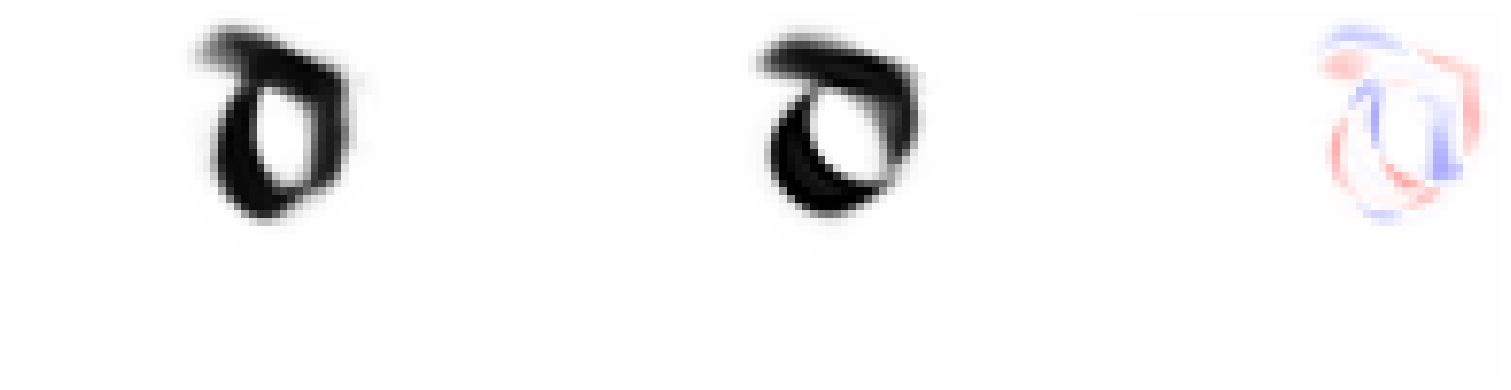

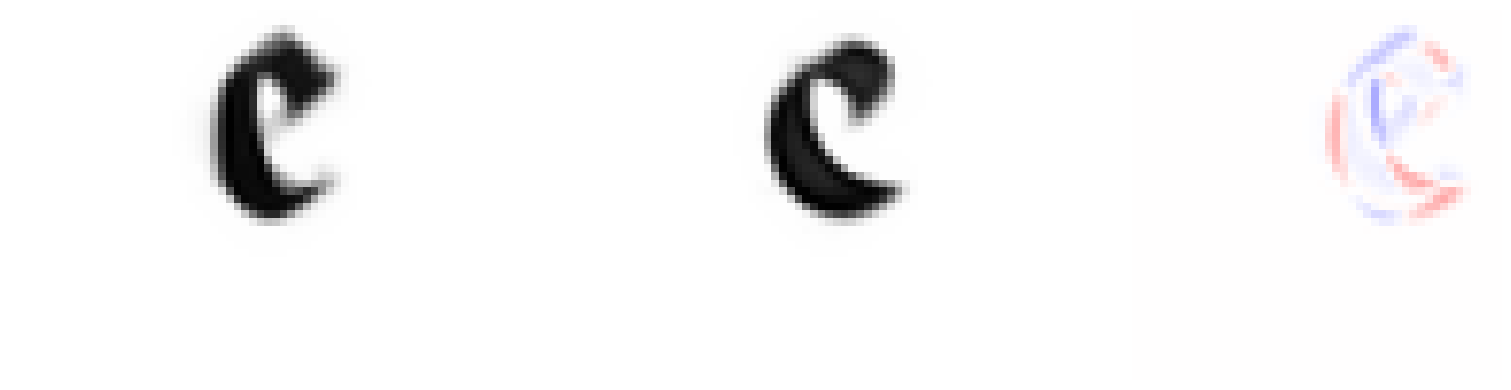

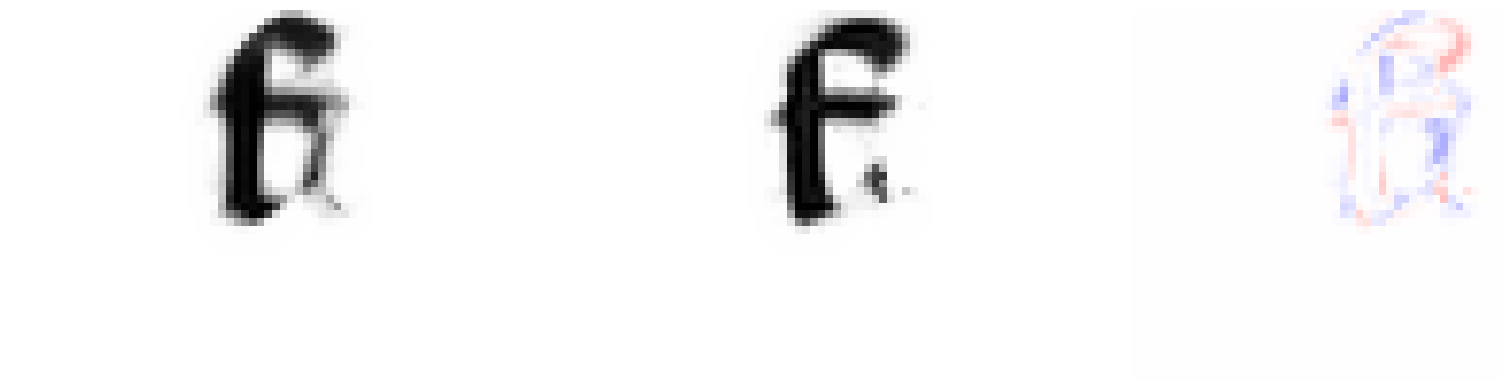

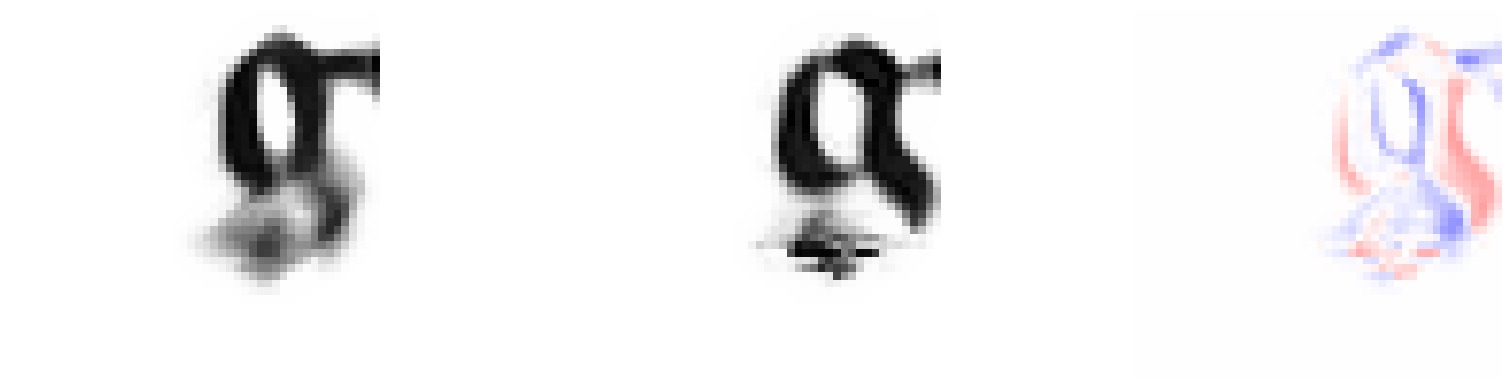

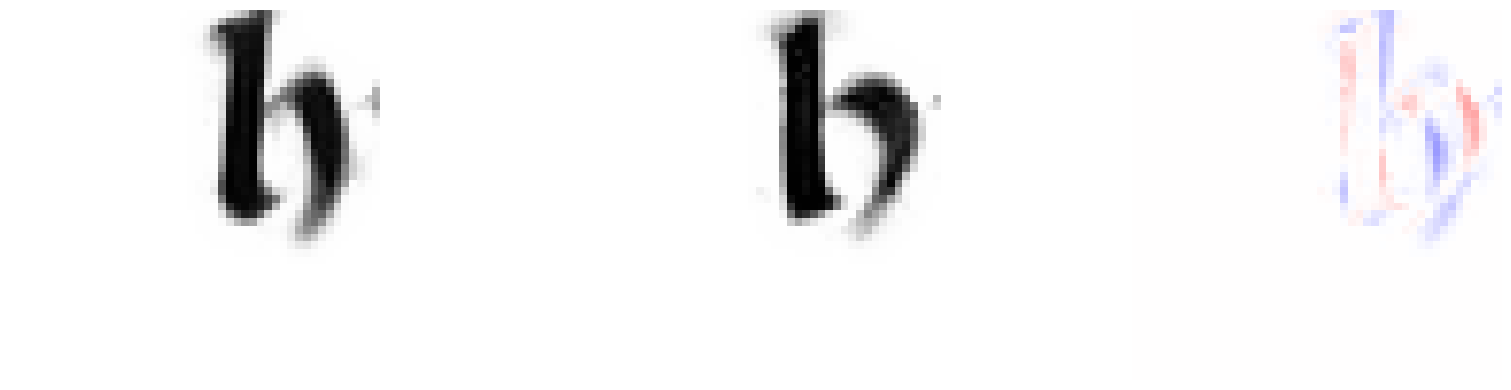

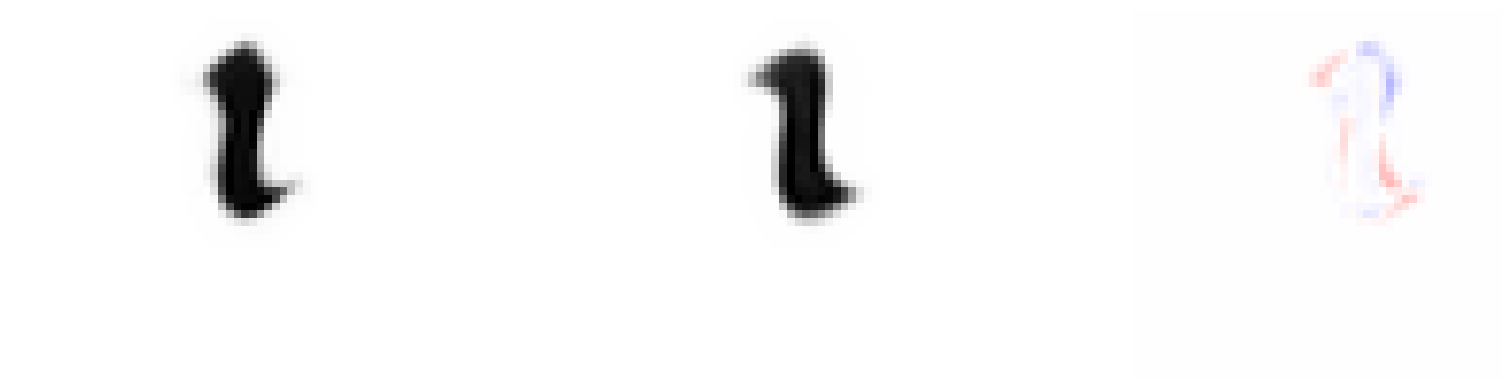

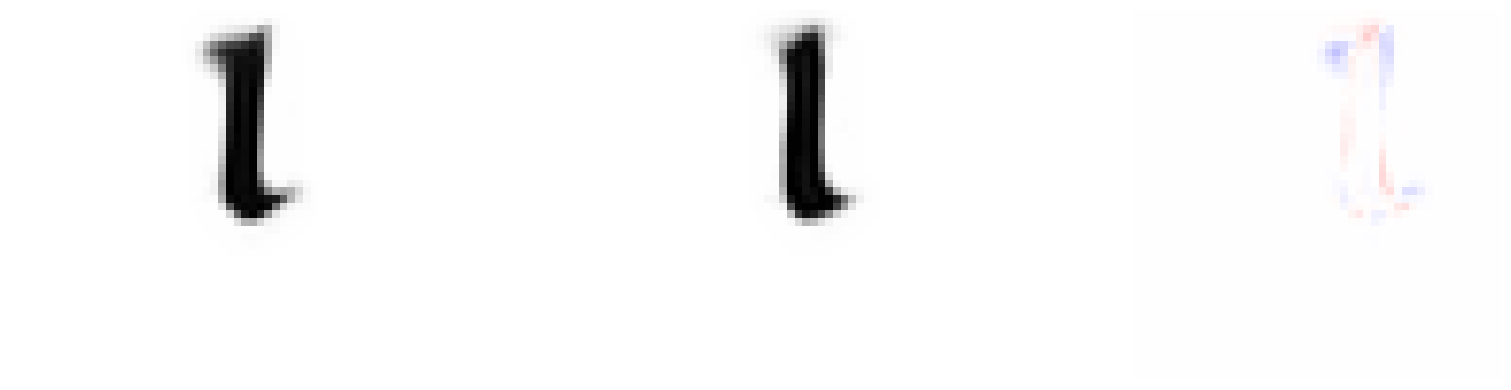

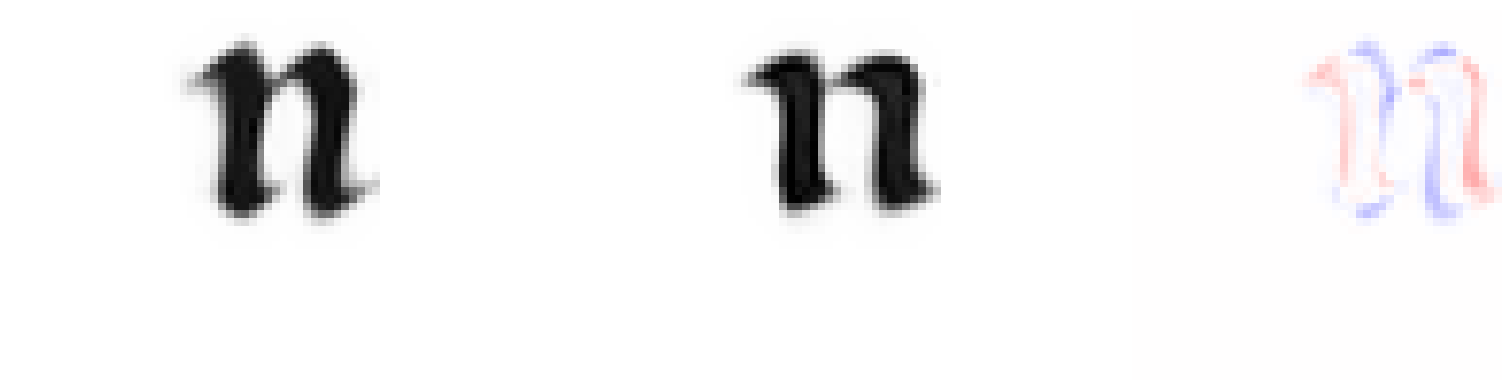

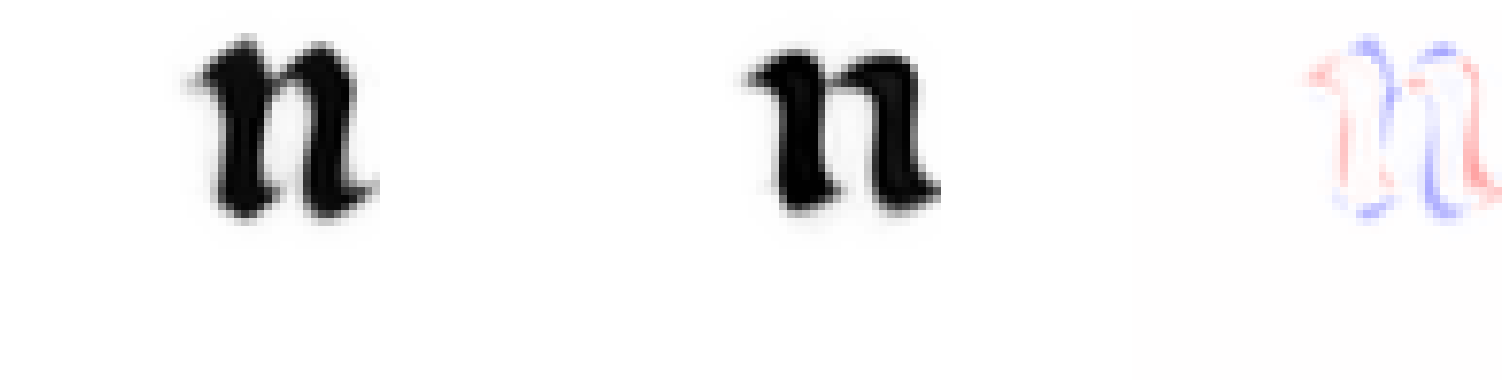

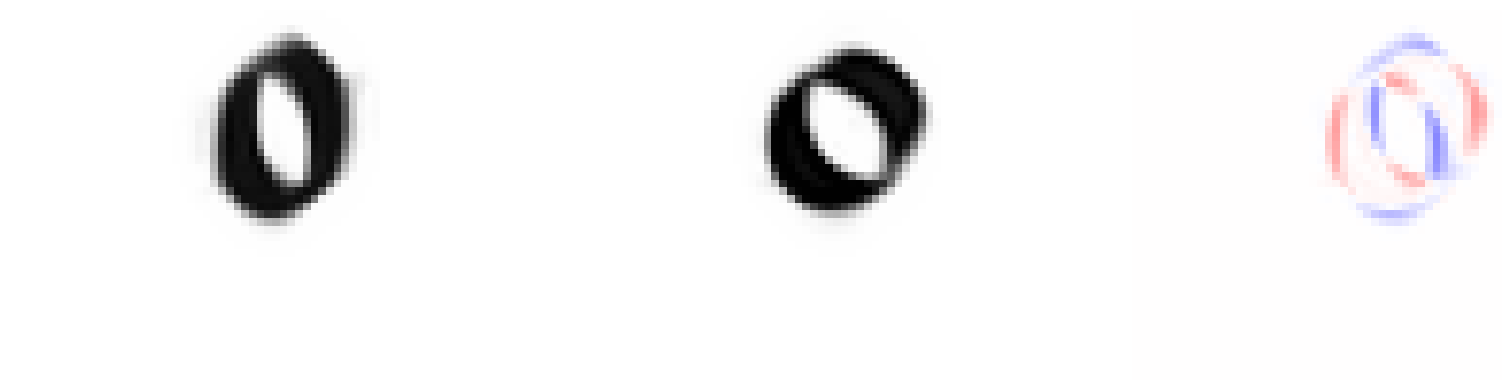

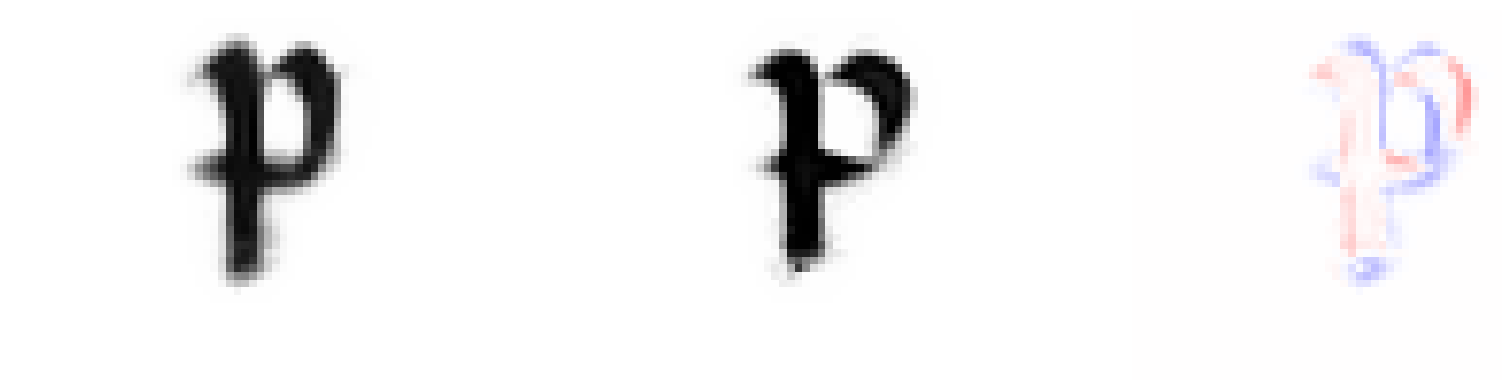

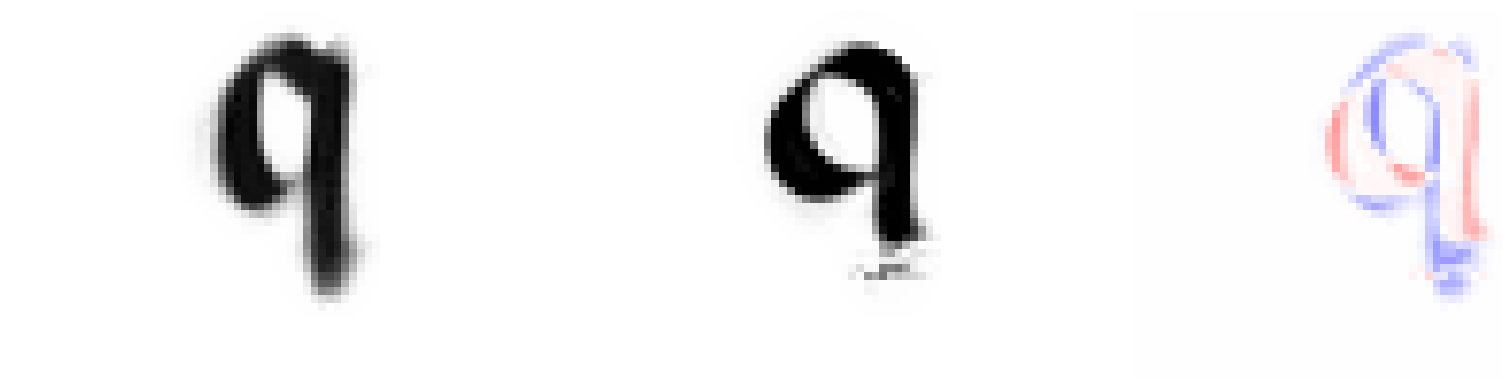

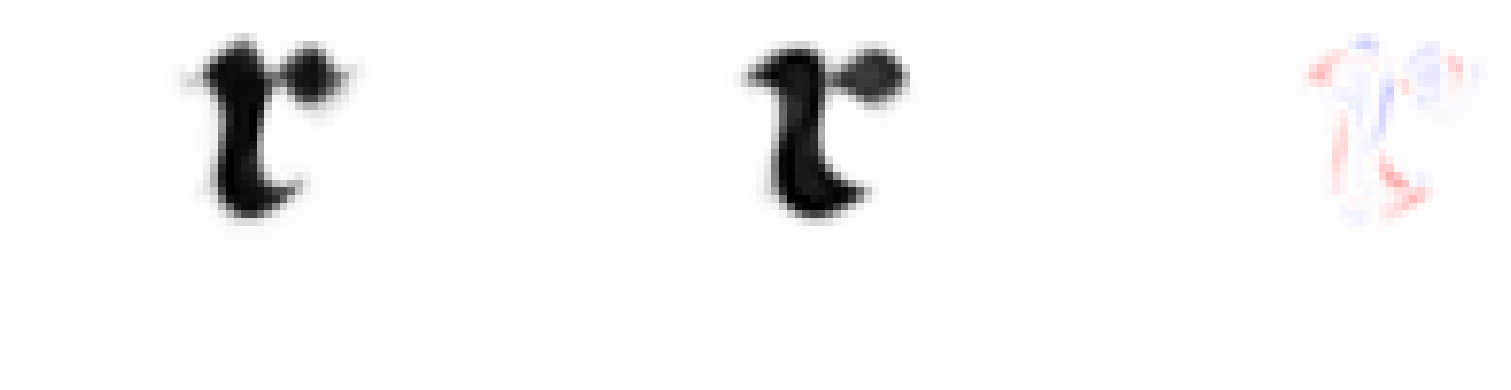

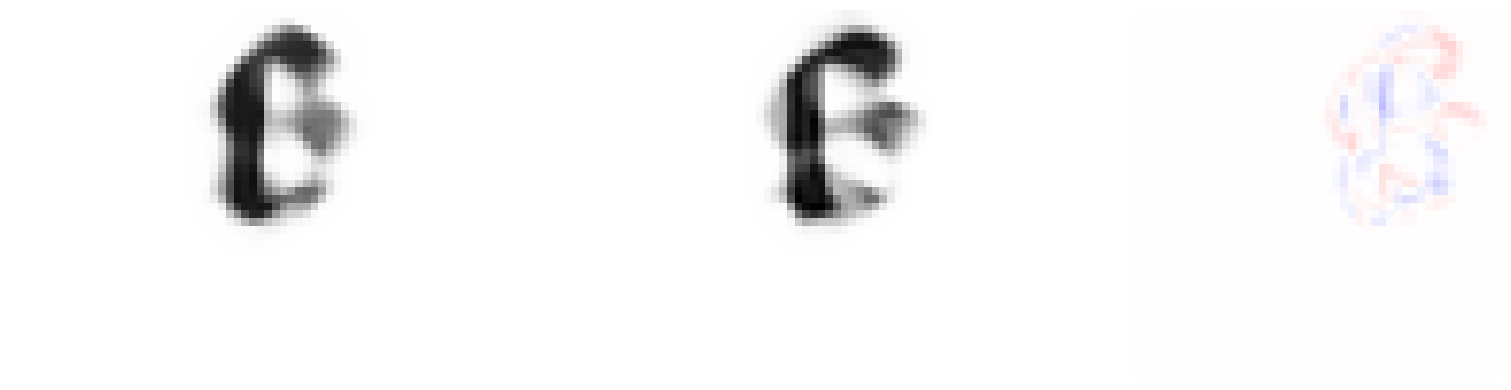

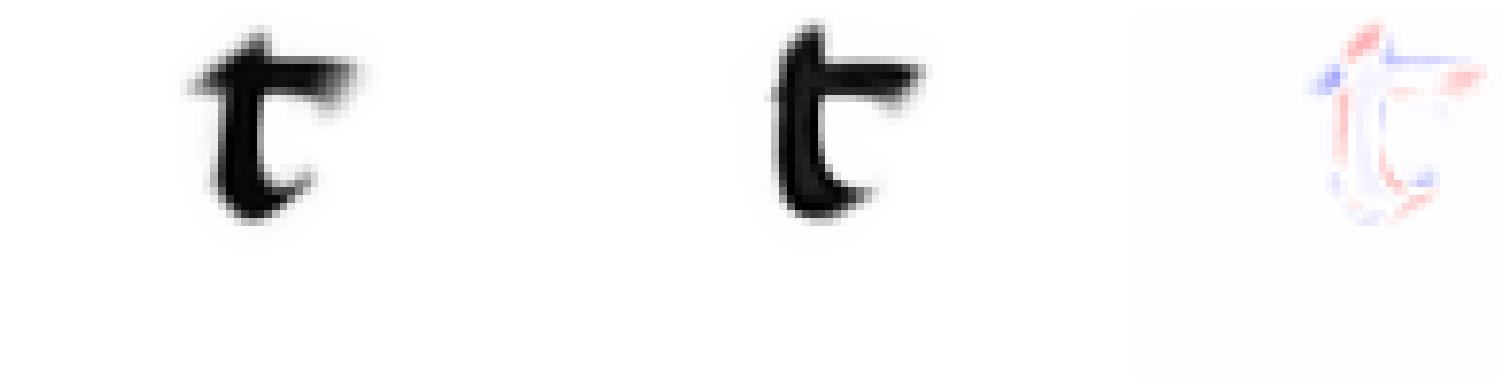

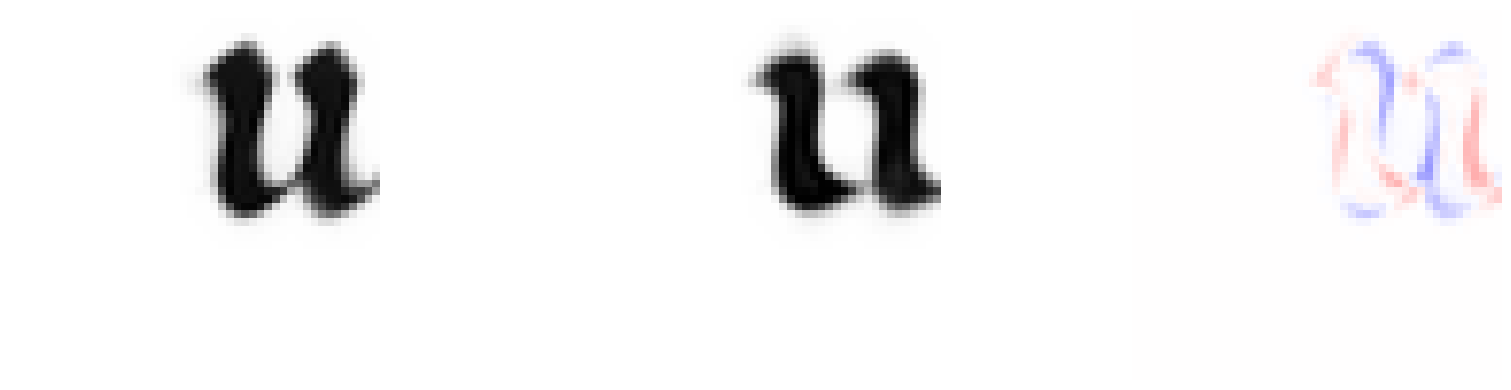

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/btv1b90590259


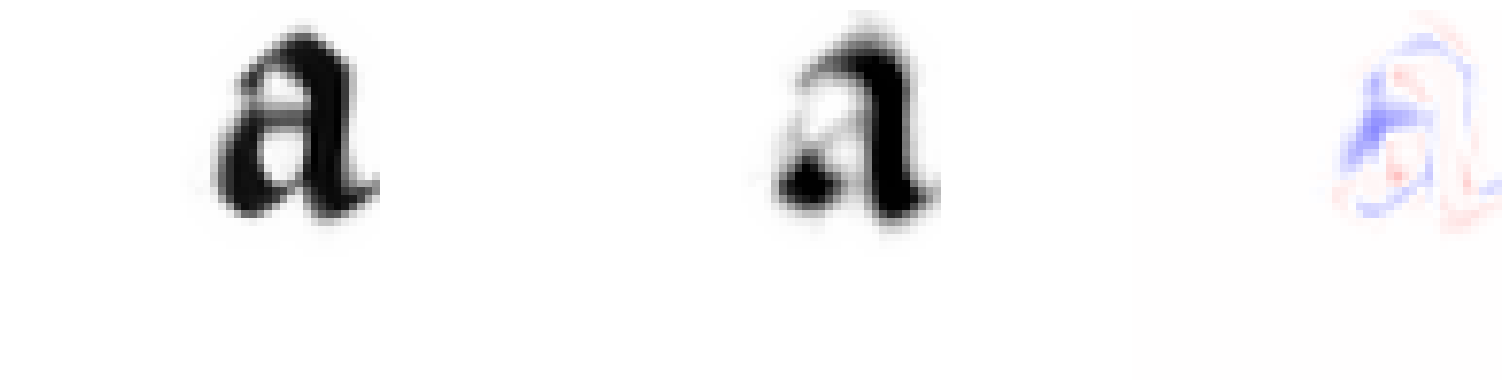

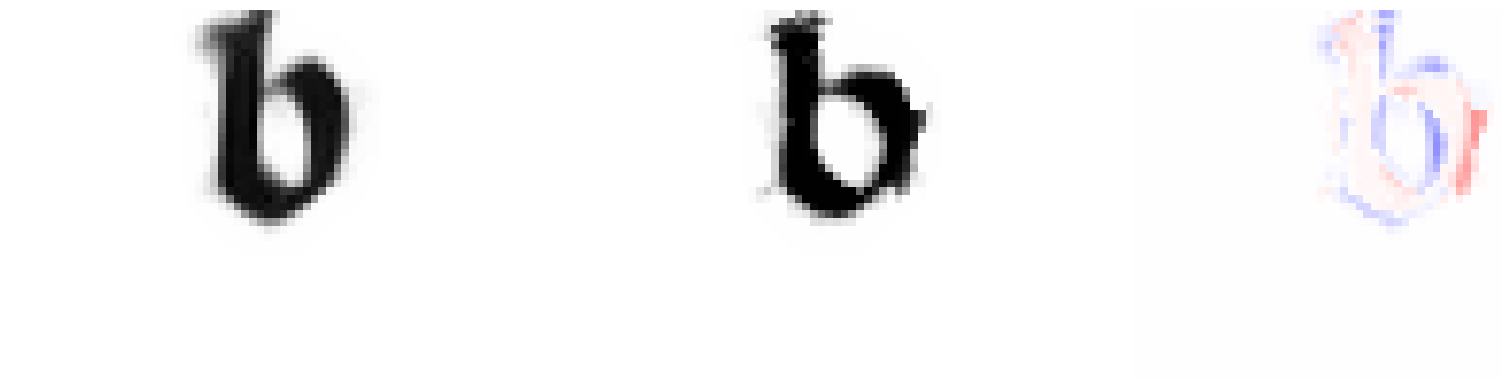

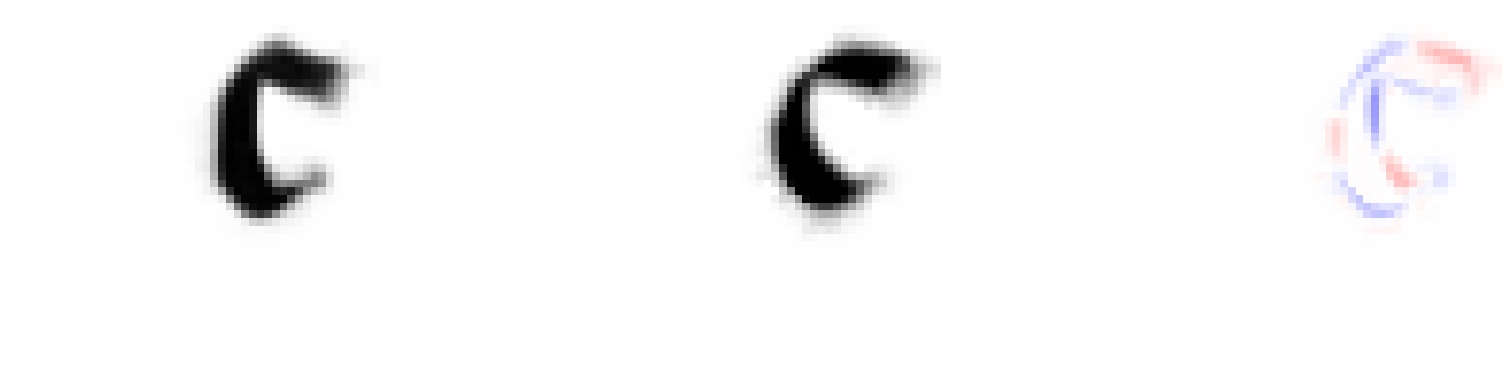

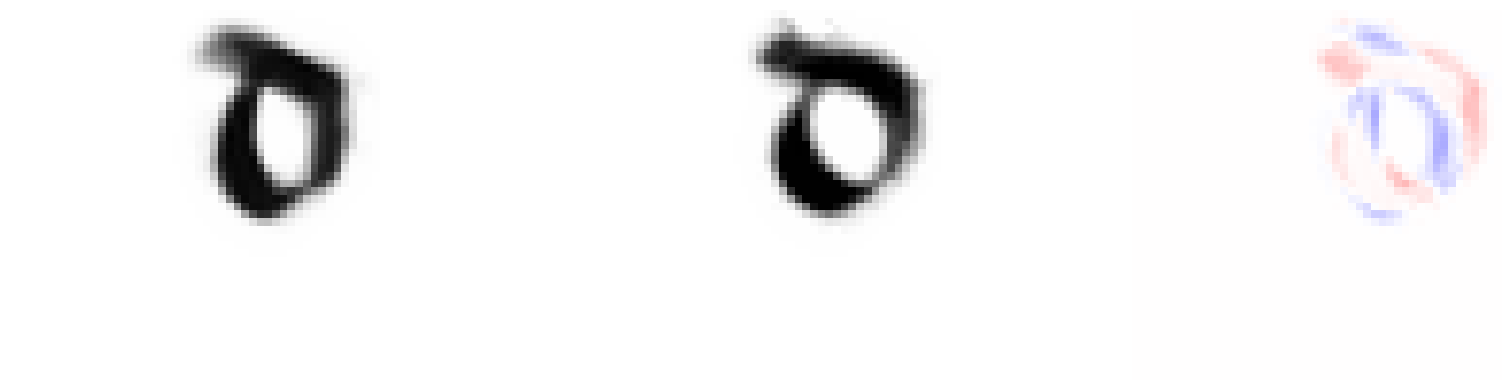

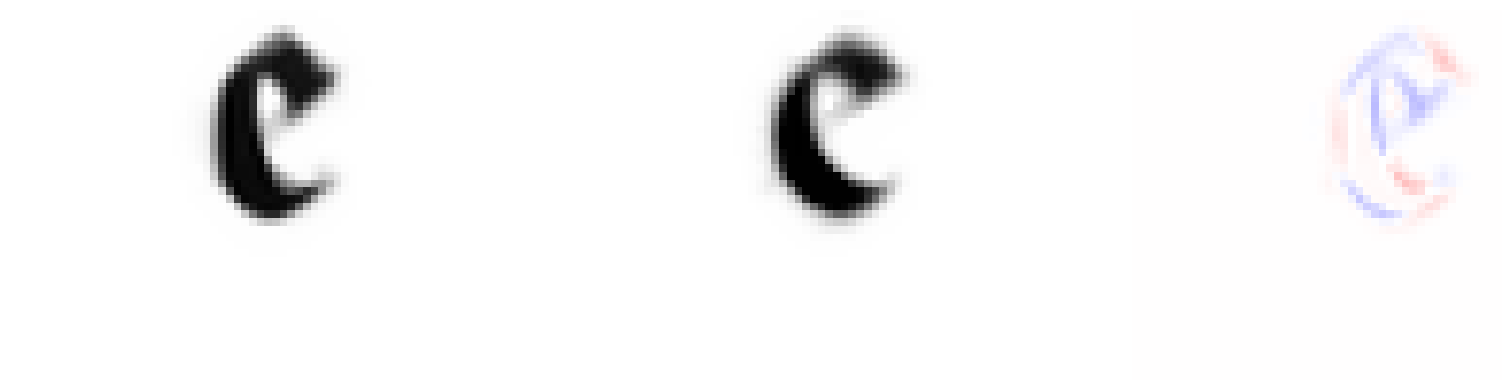

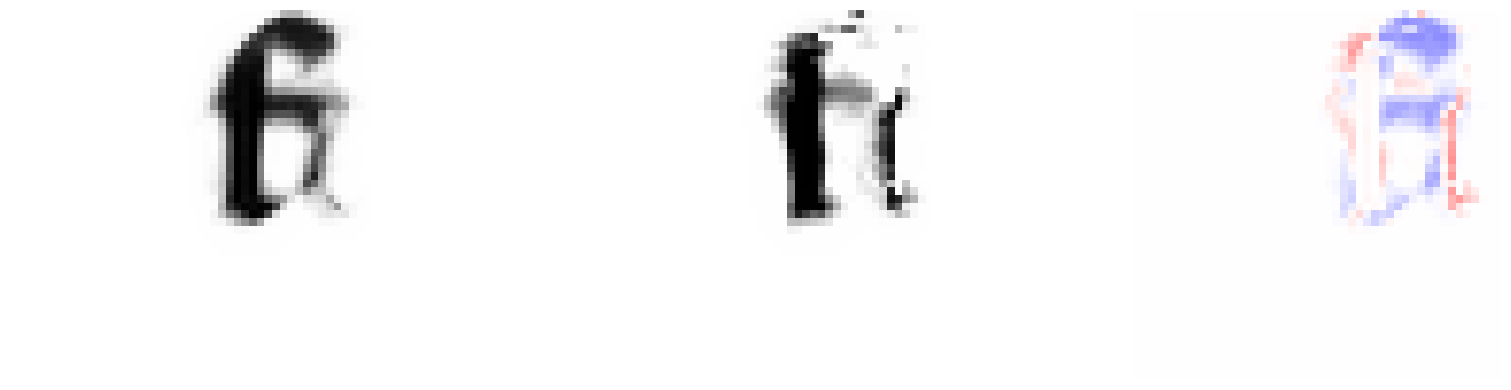

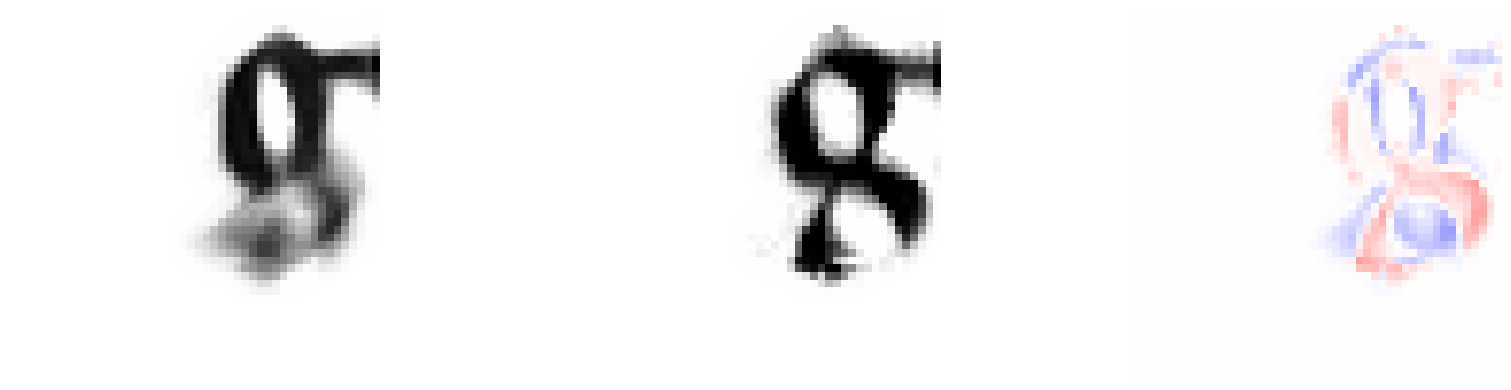

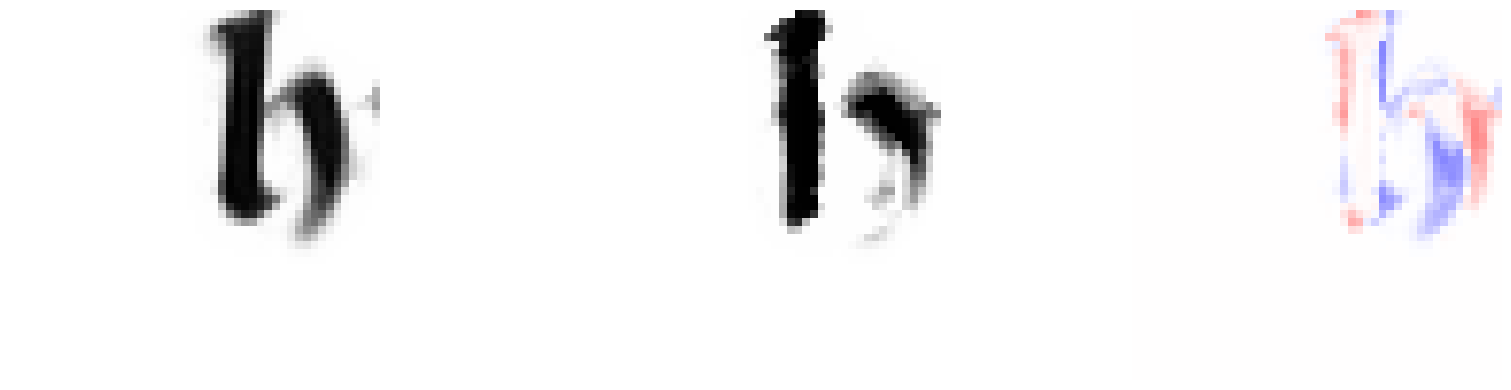

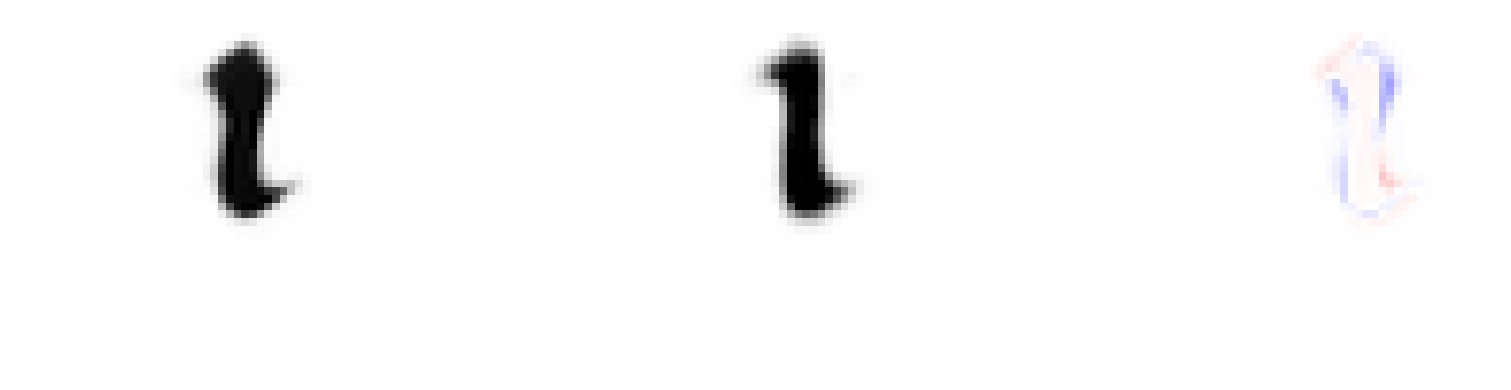

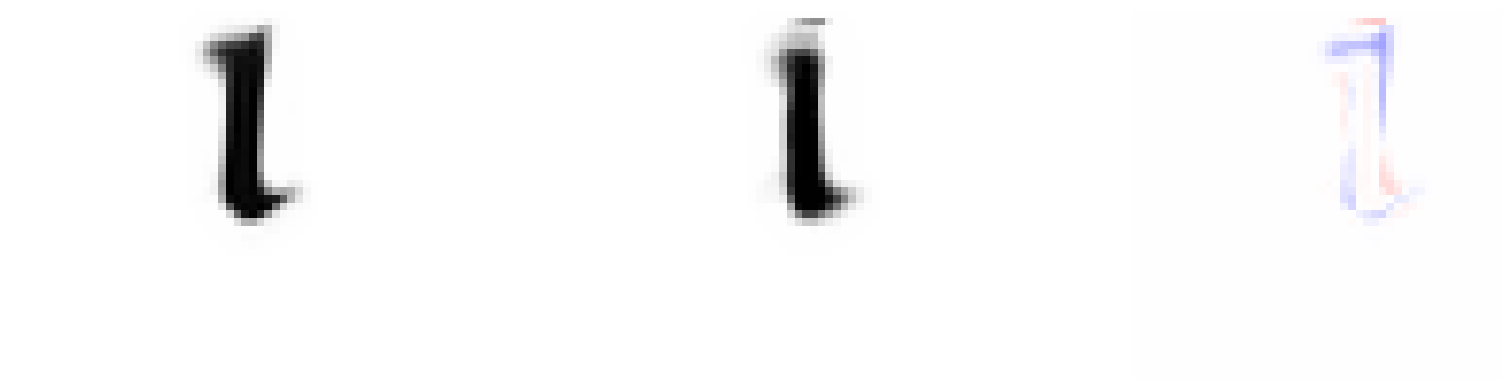

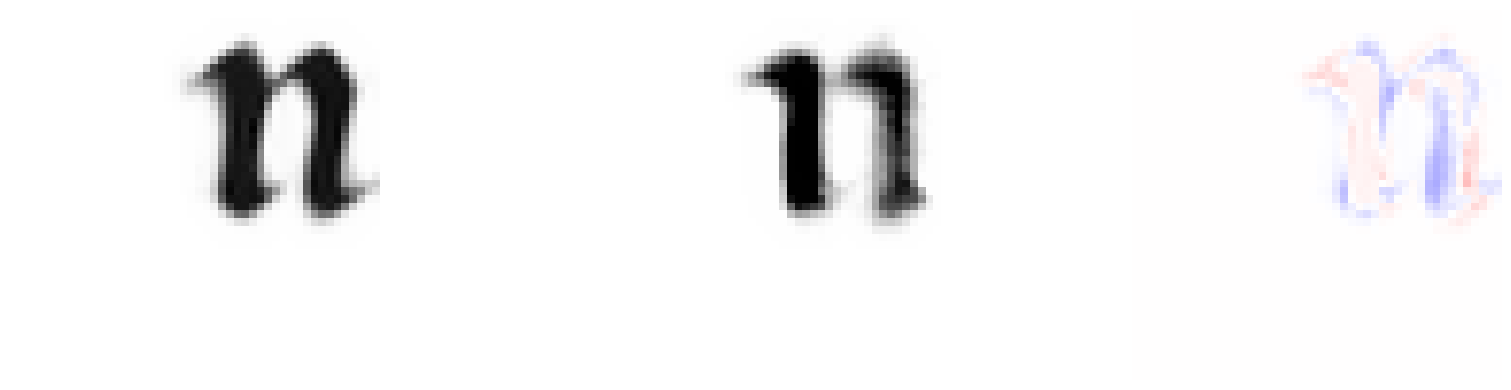

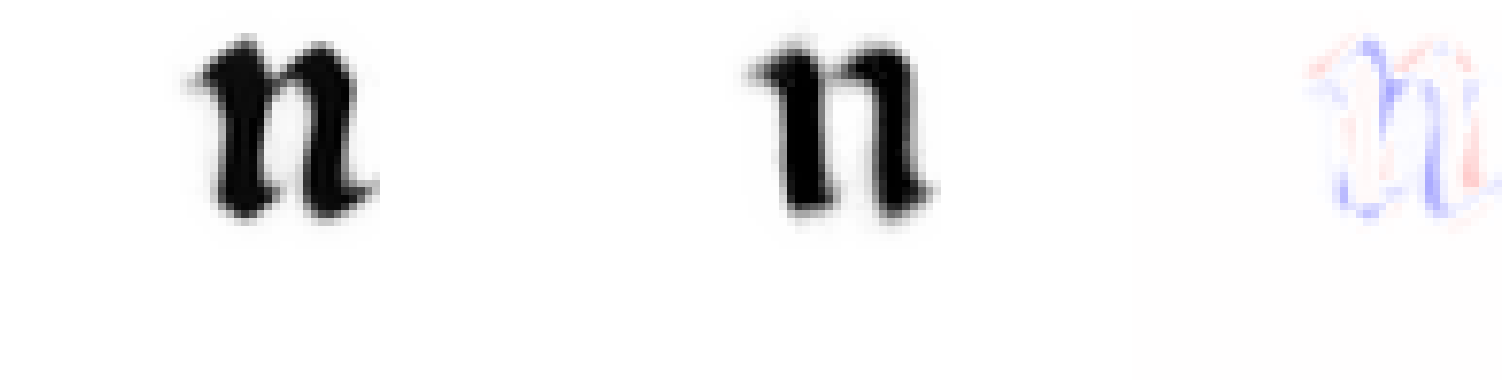

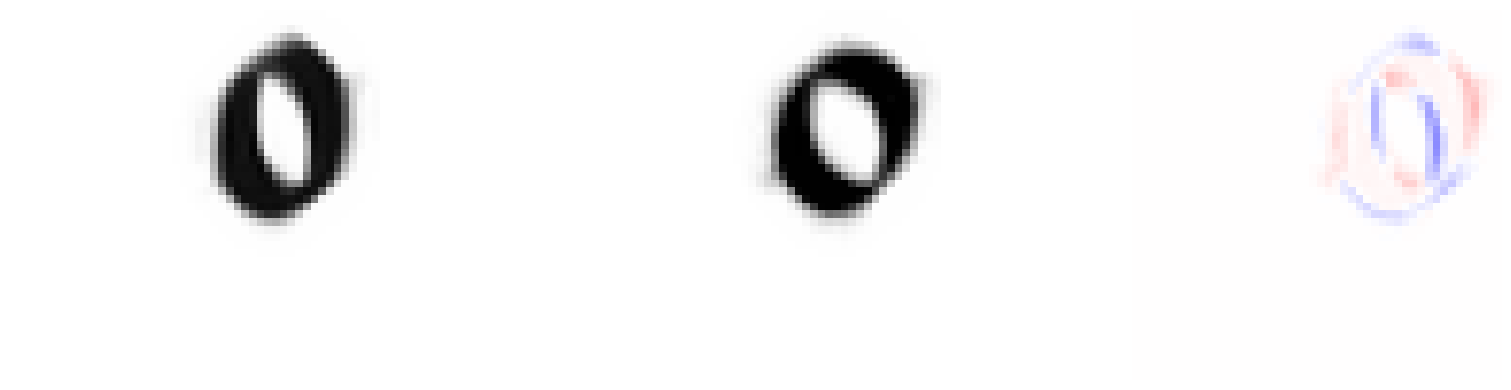

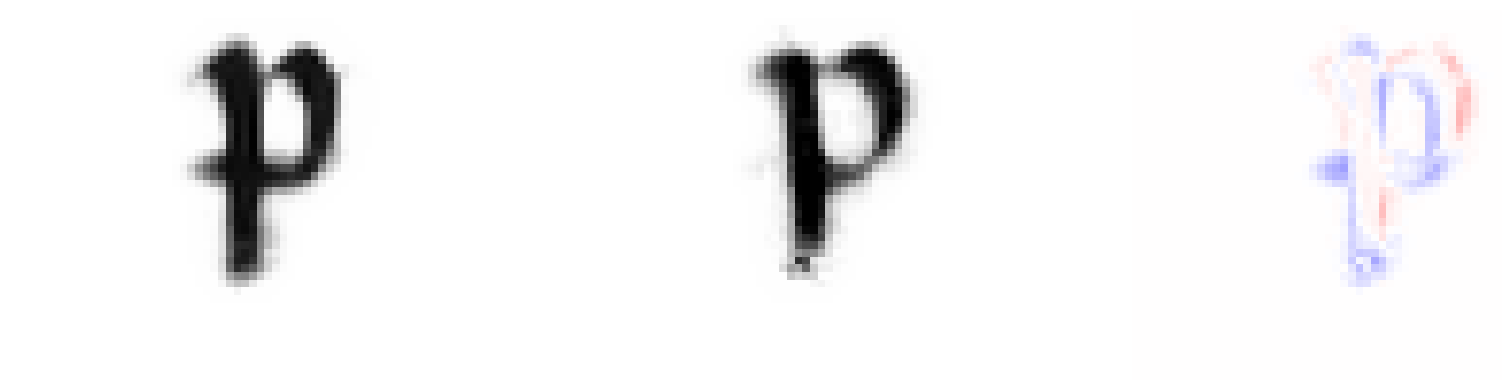

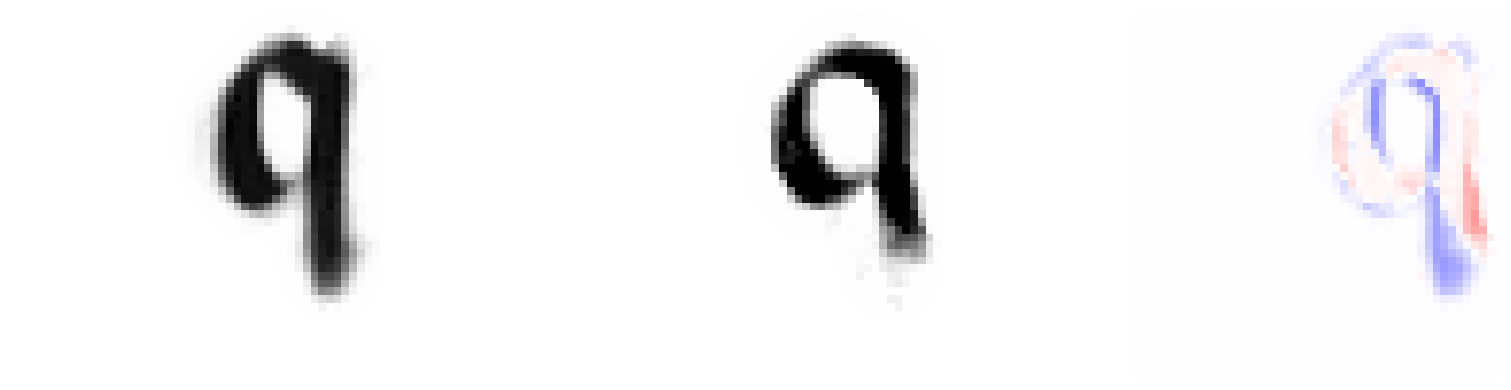

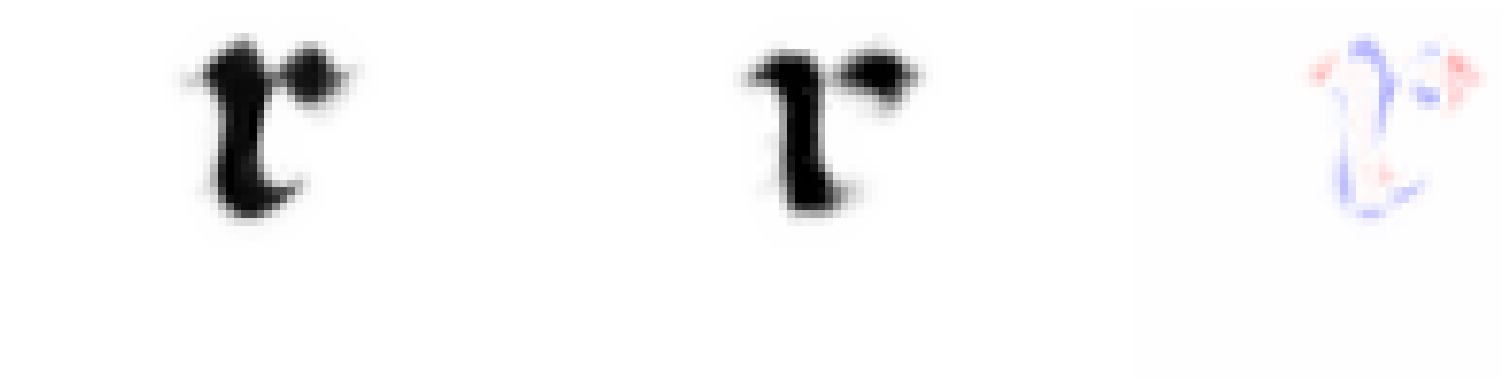

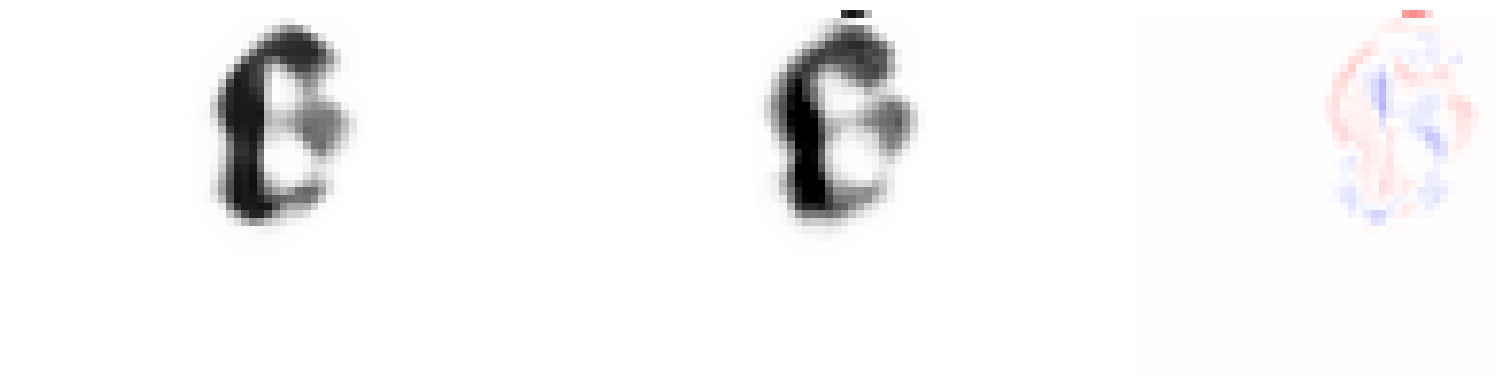

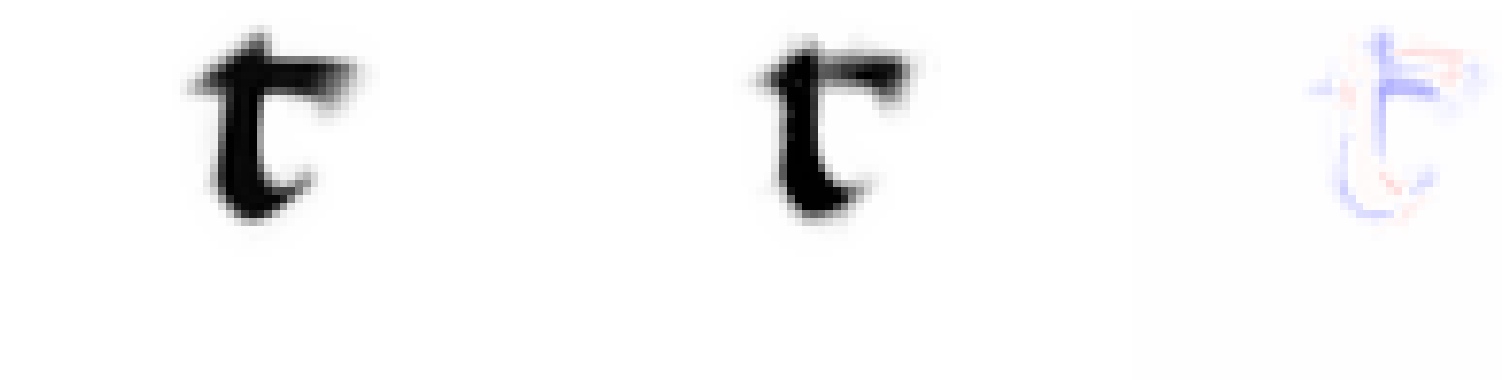

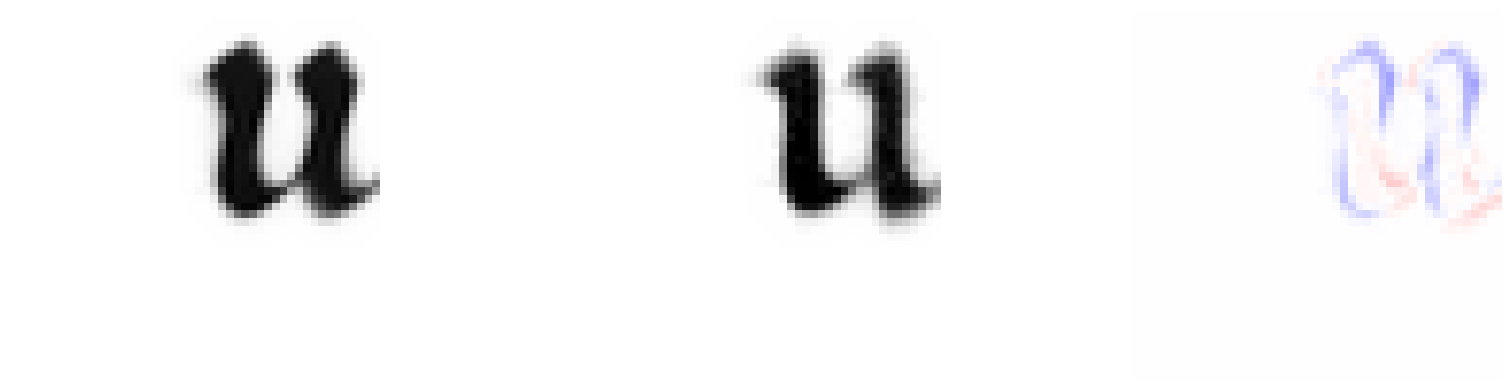

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/btv1b8446940n


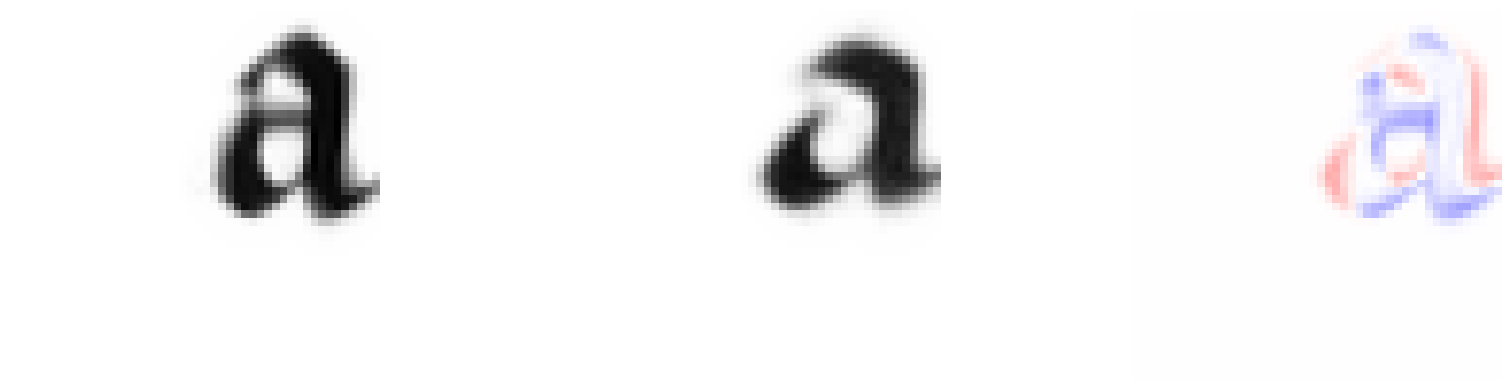

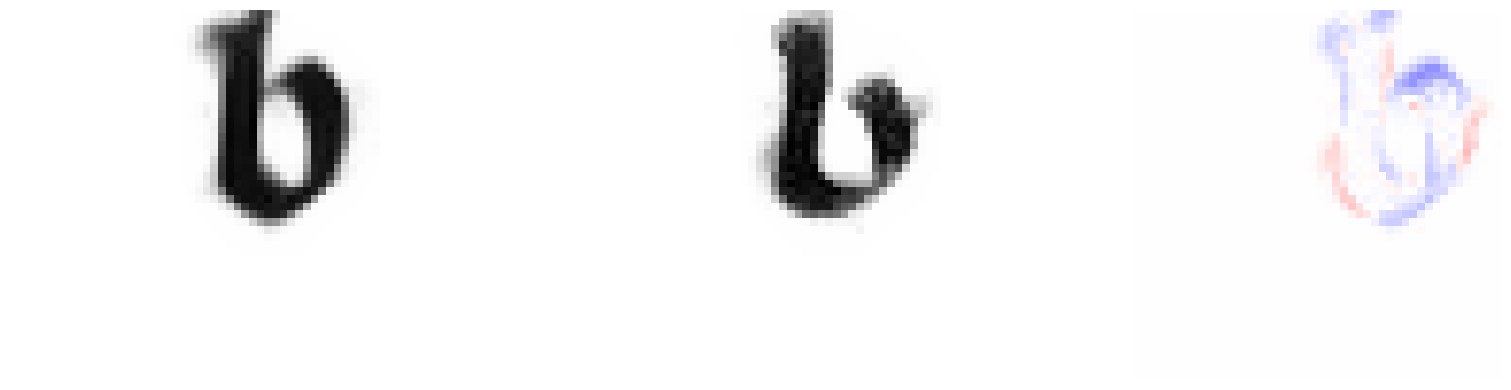

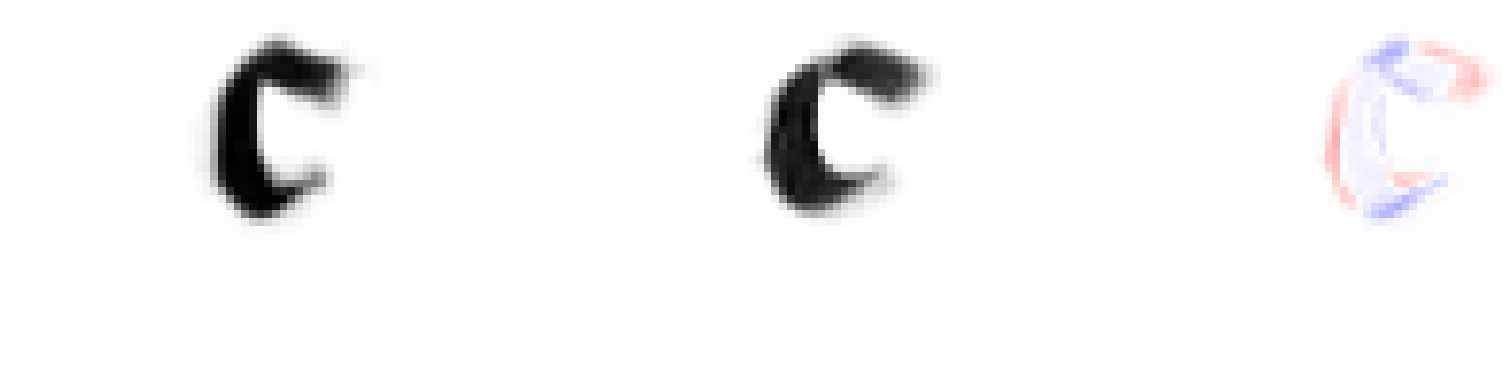

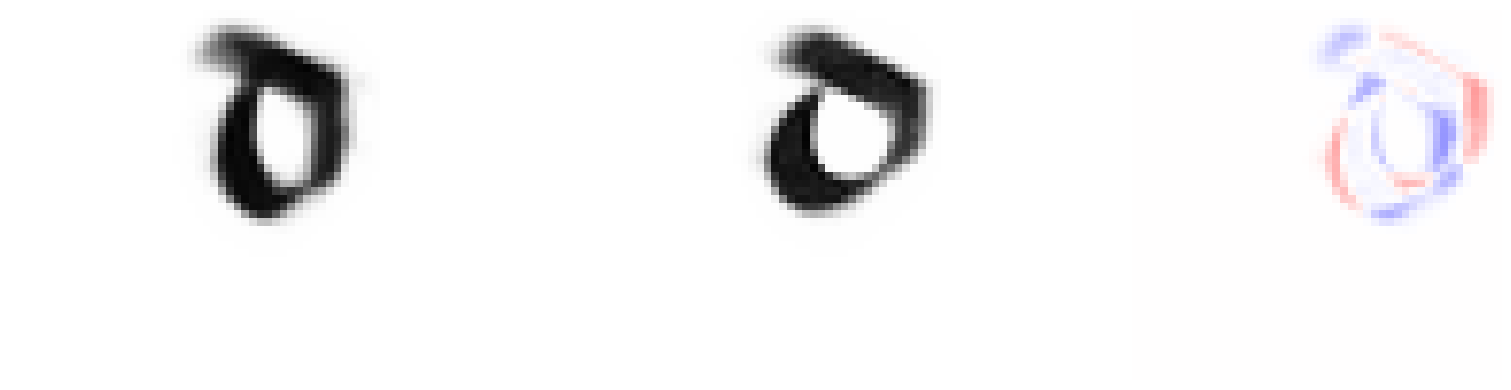

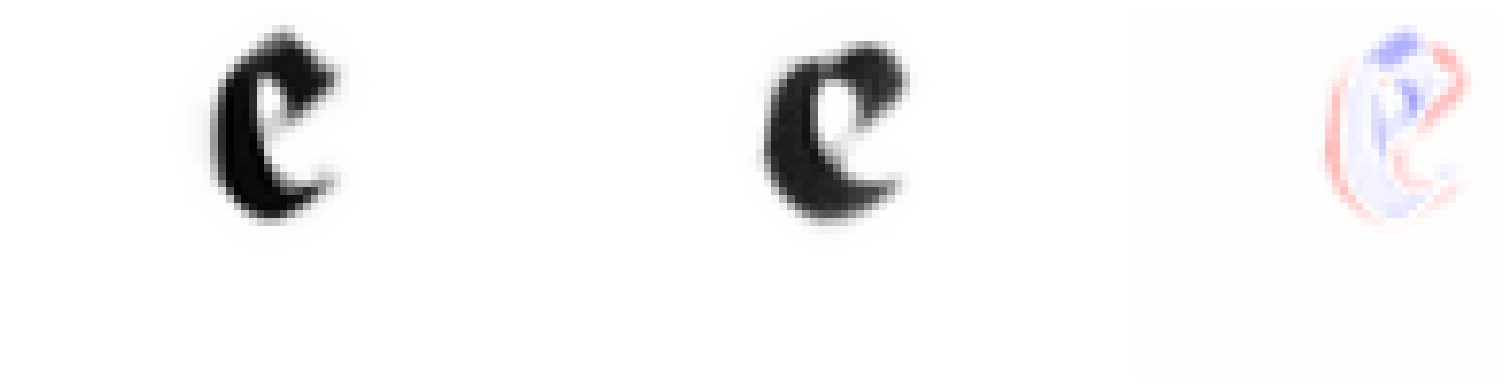

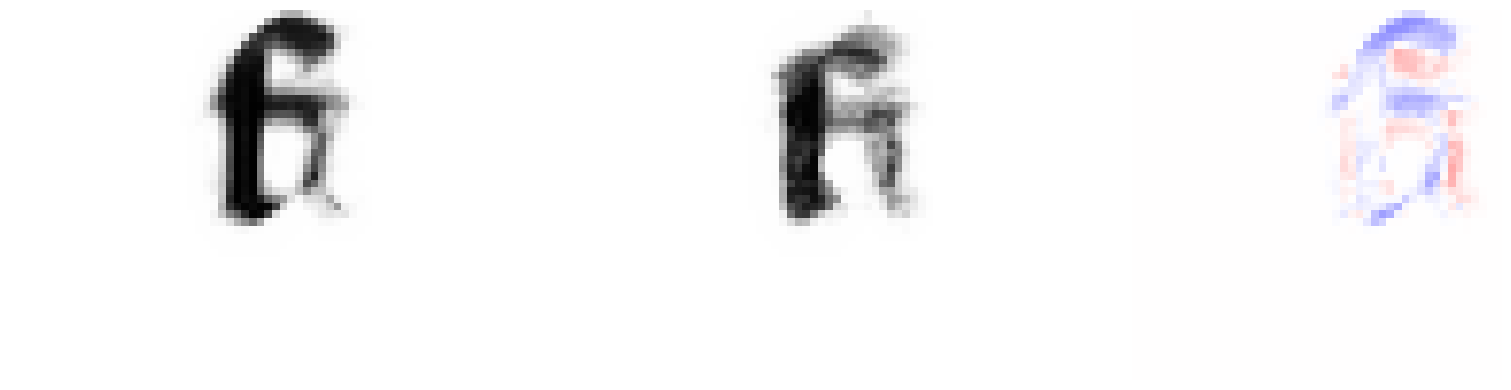

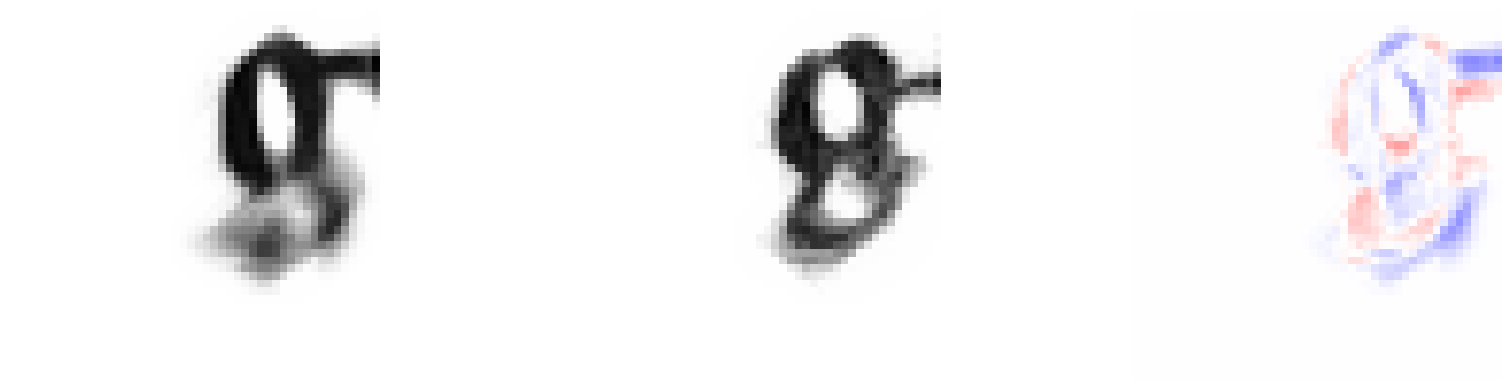

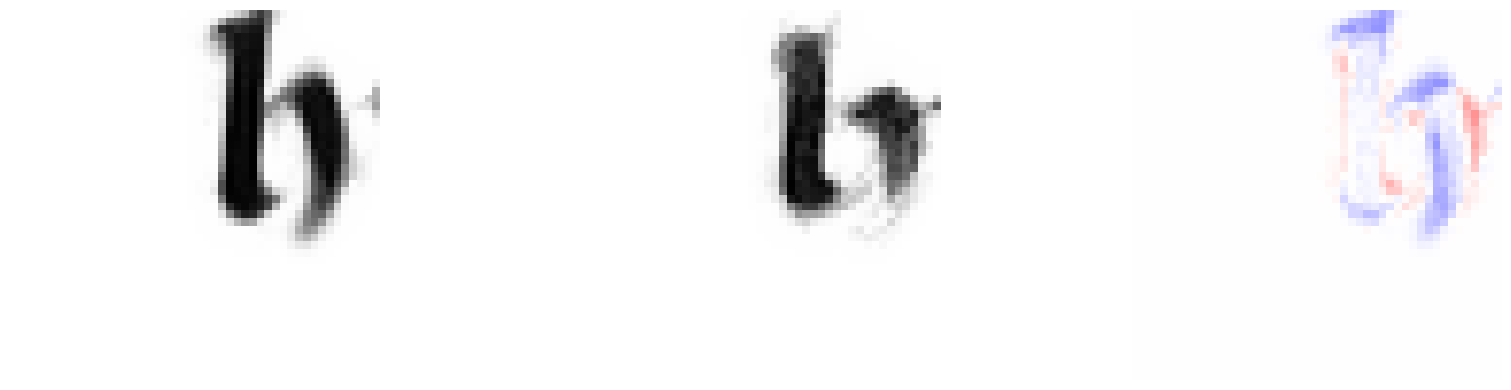

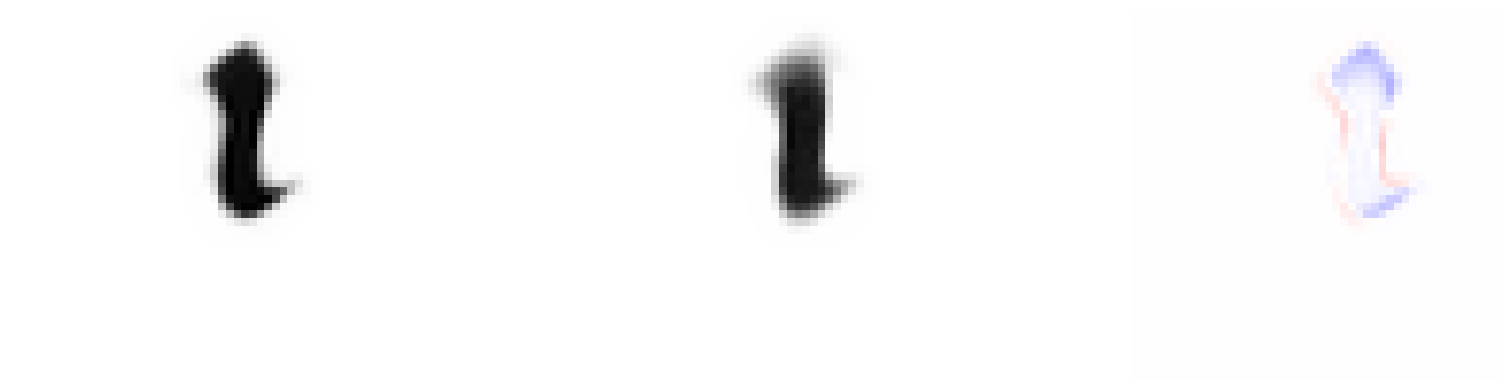

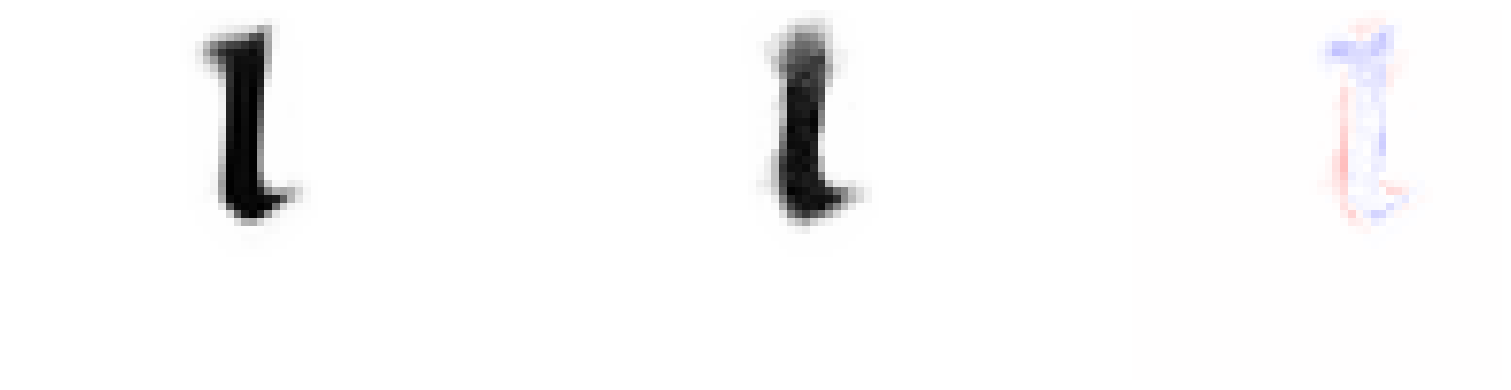

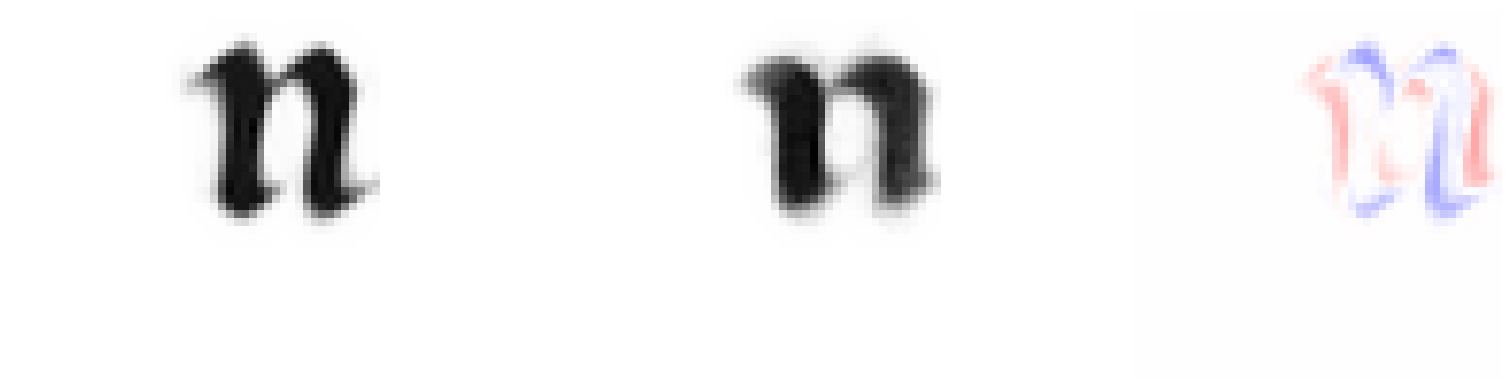

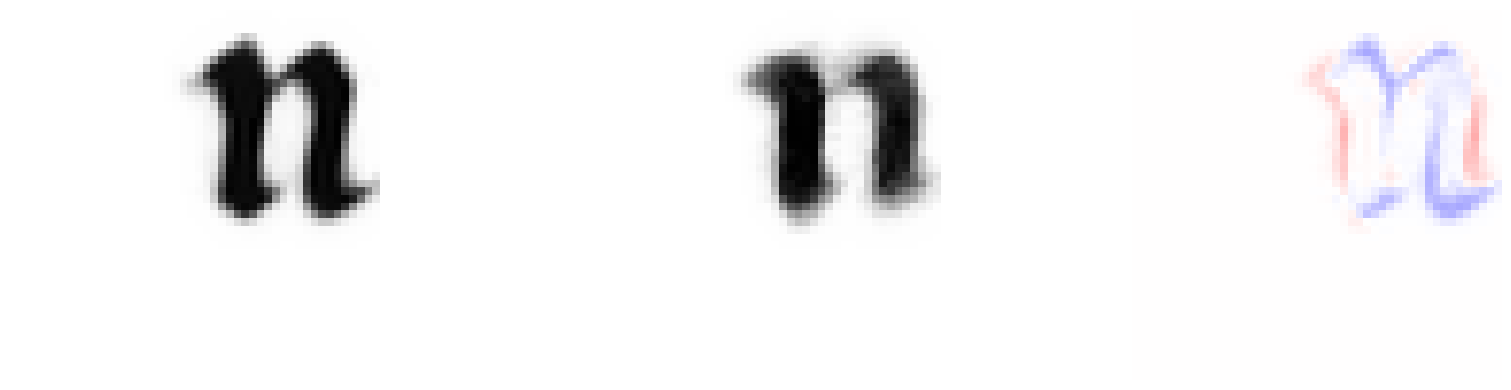

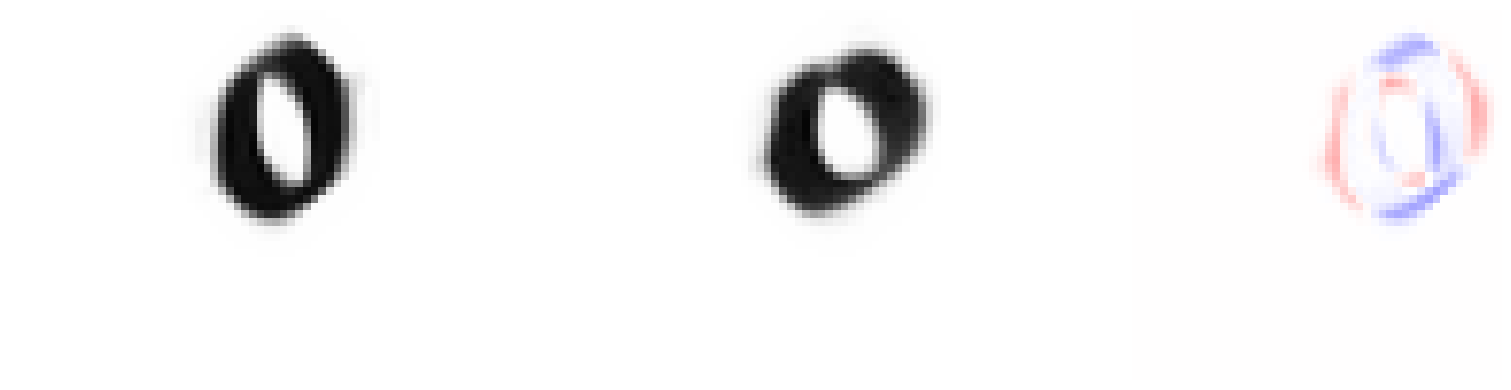

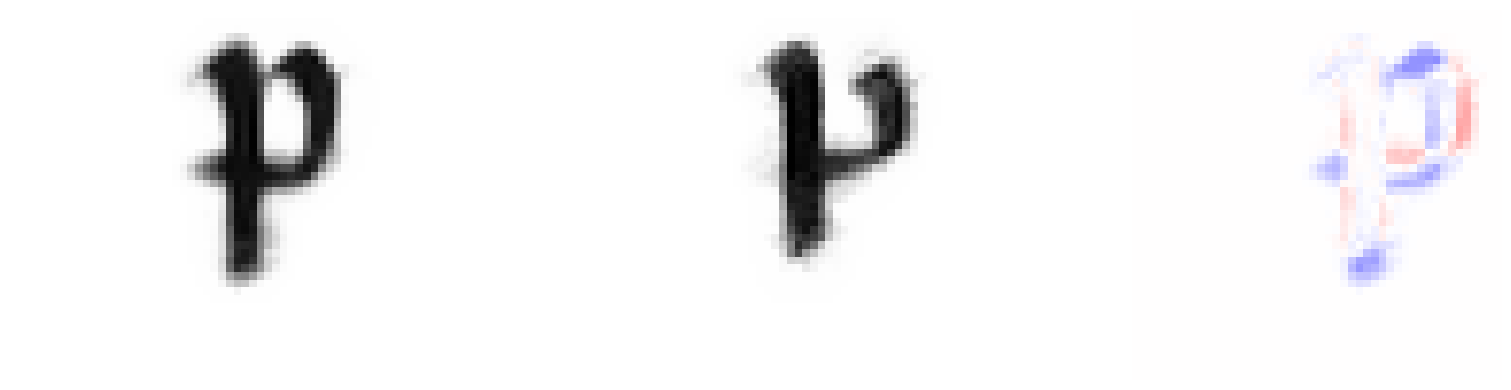

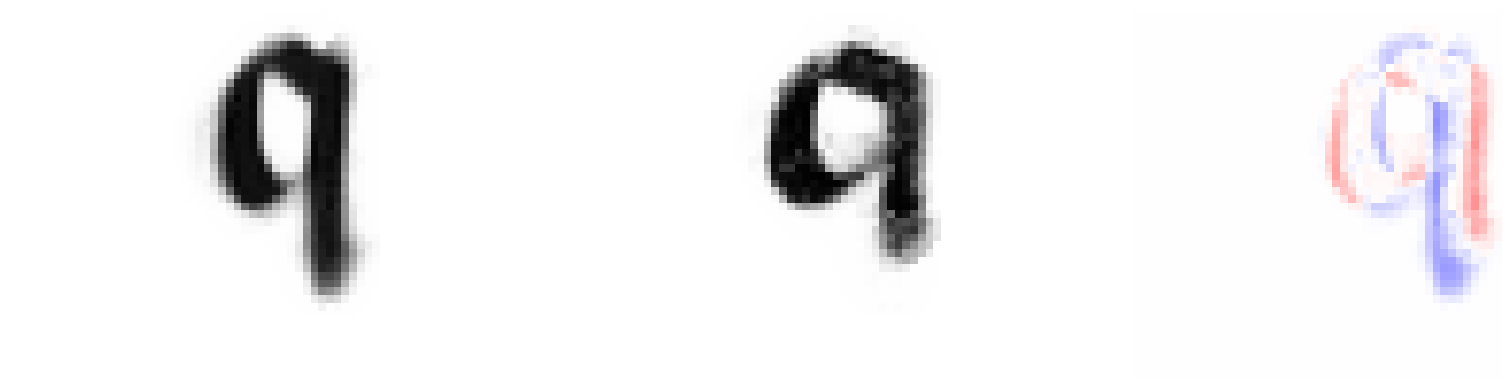

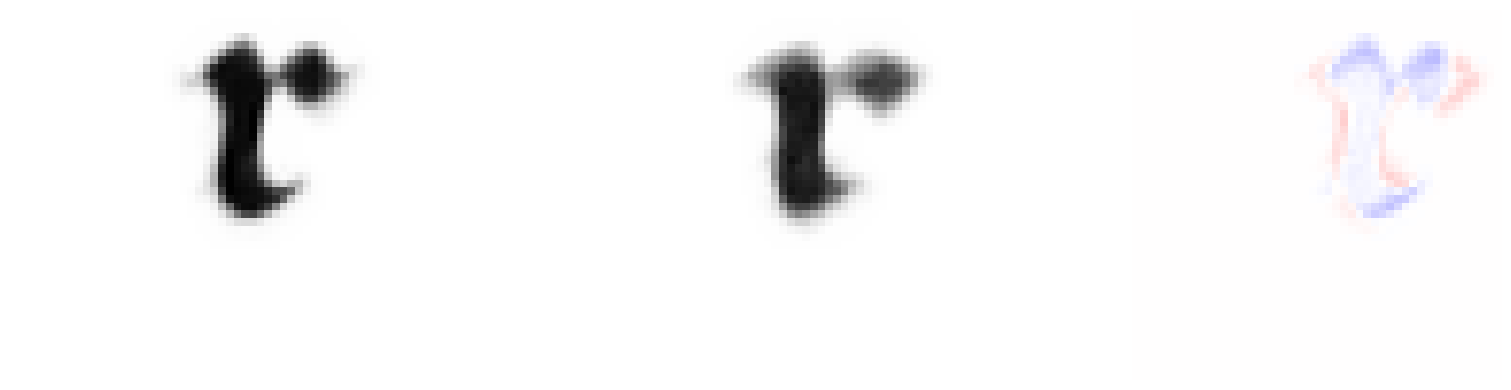

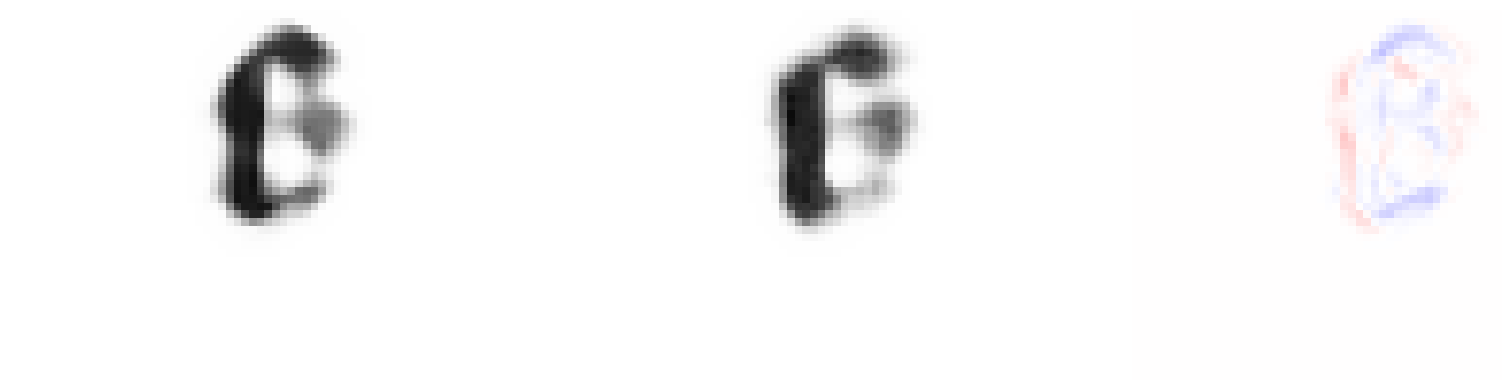

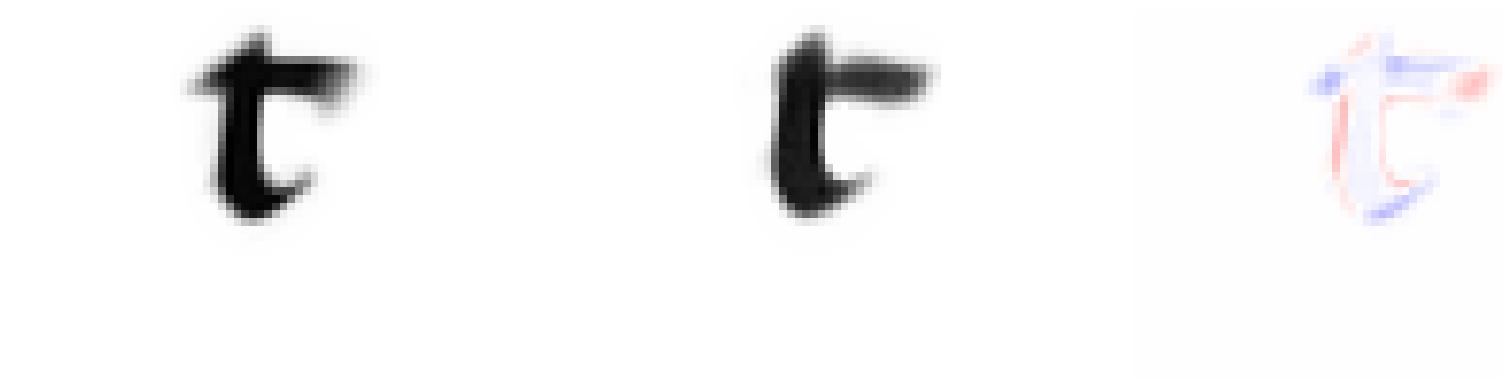

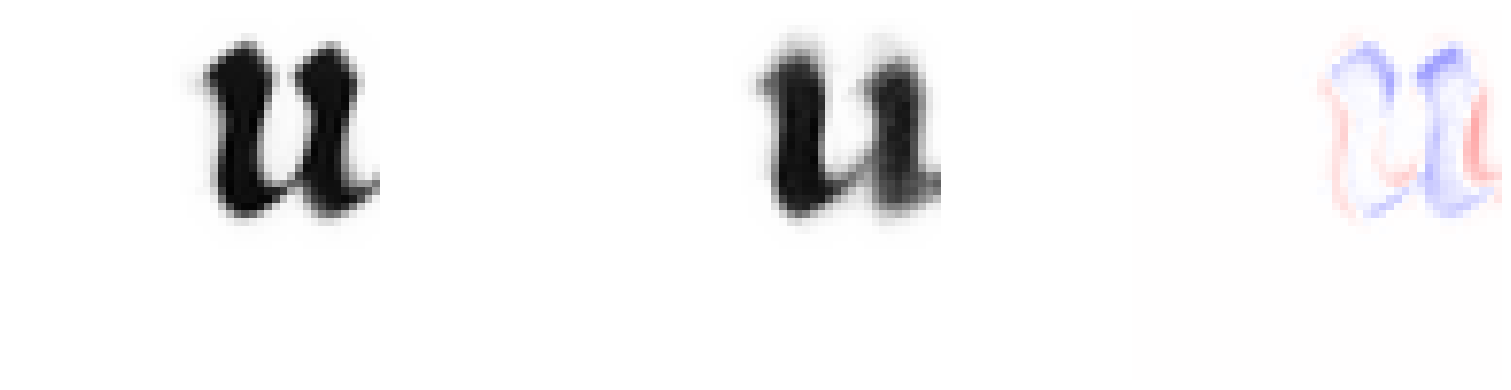

Processing folder: /content/learnable-handwriter/scripts/reproduce_results/prototypes/filtered/IB15304274v


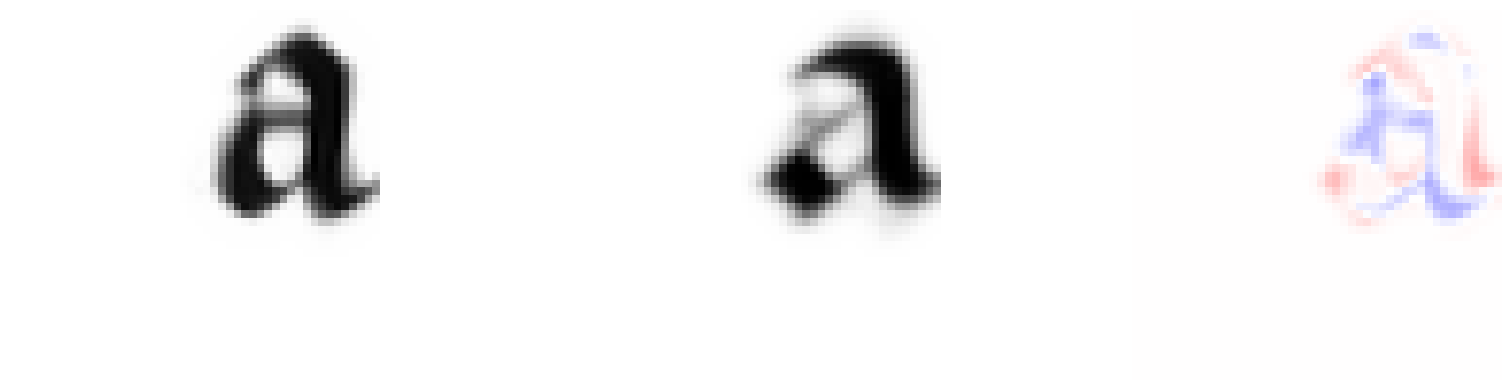

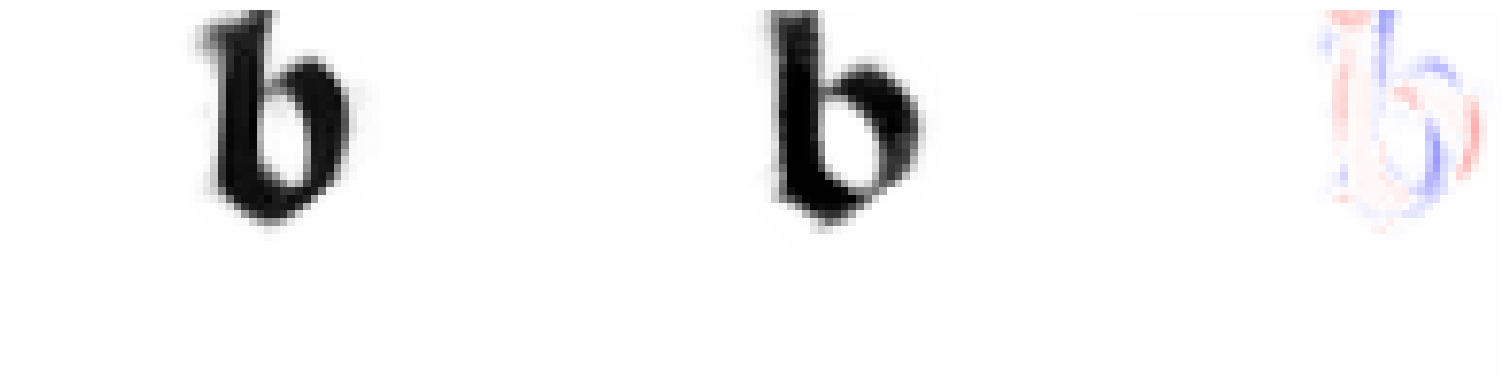

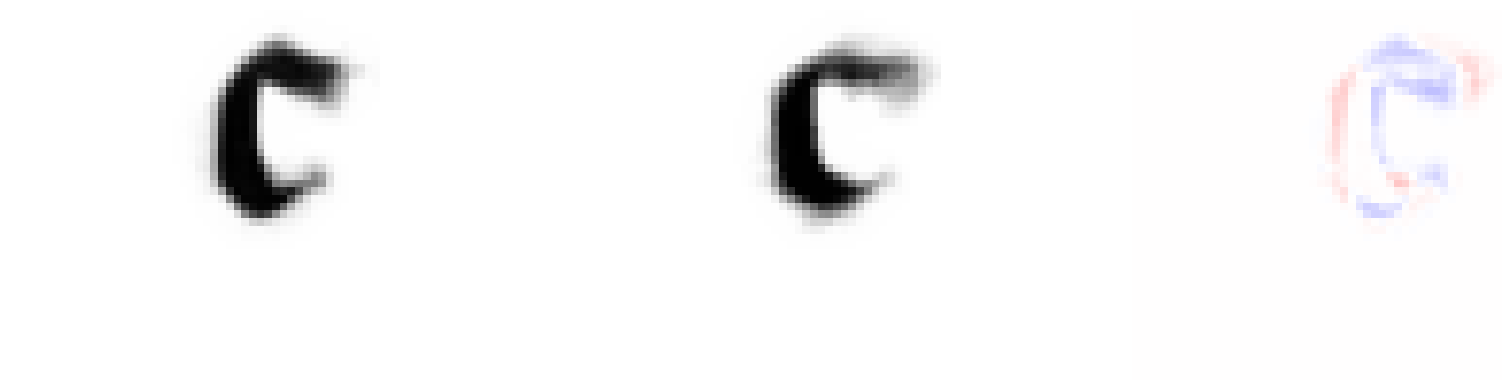

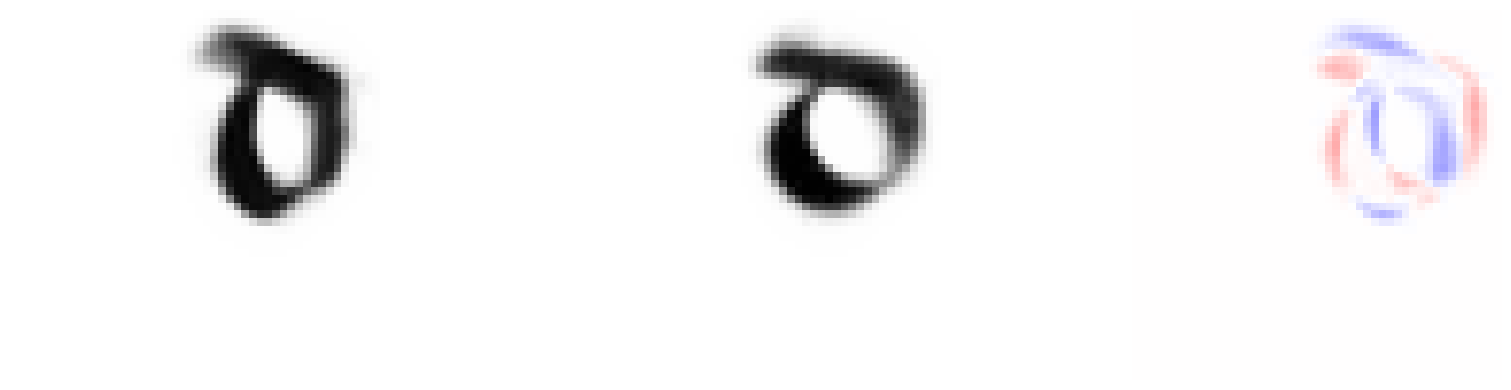

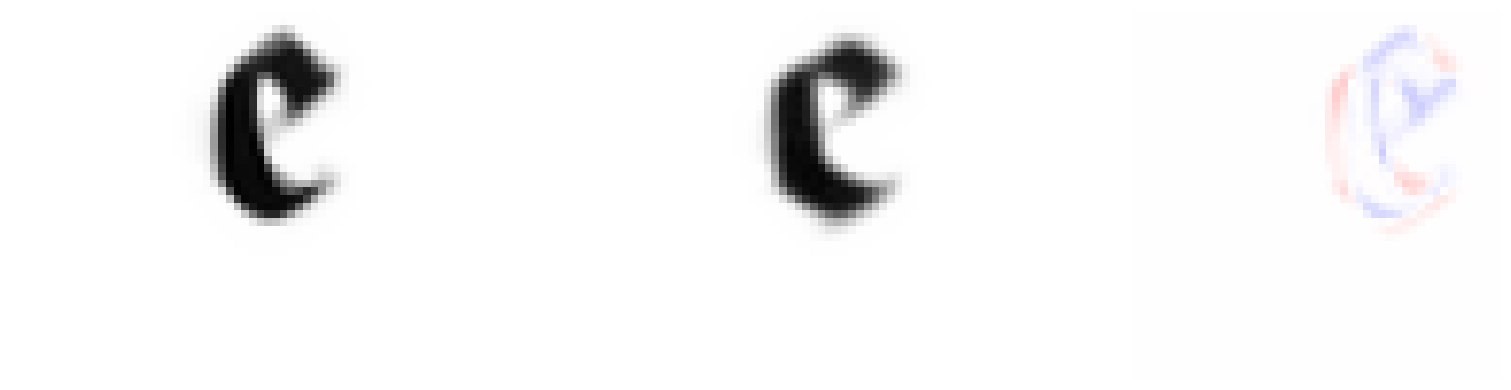

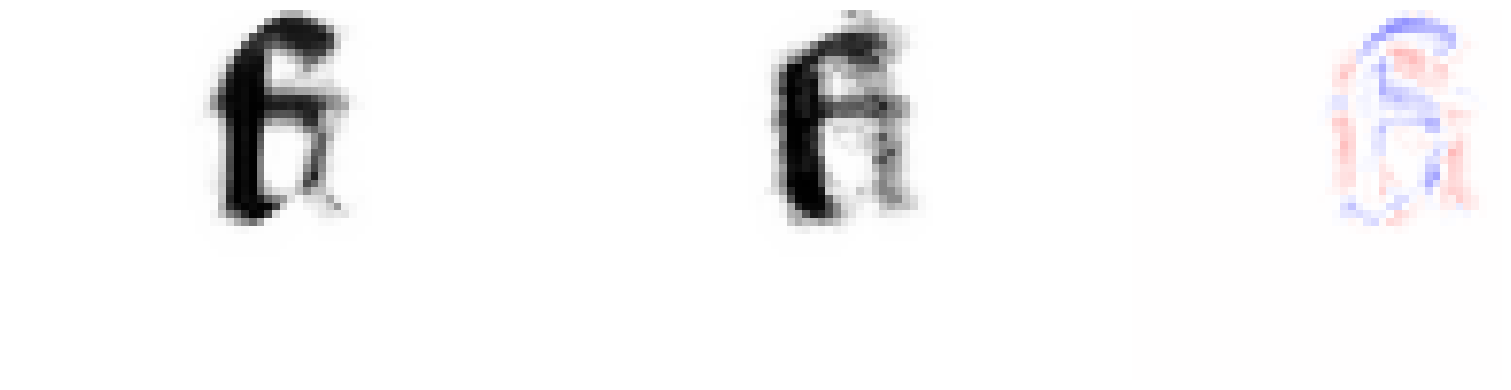

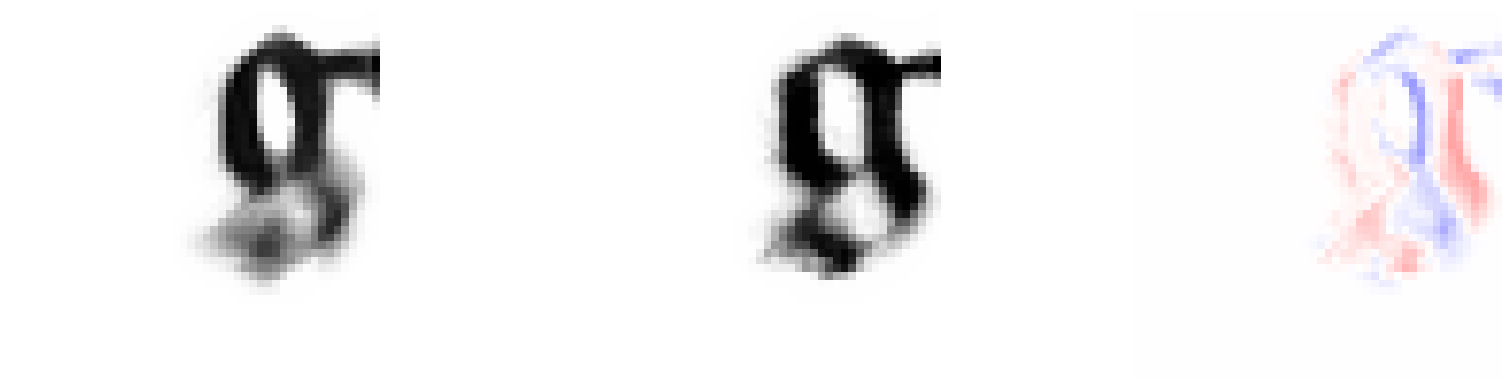

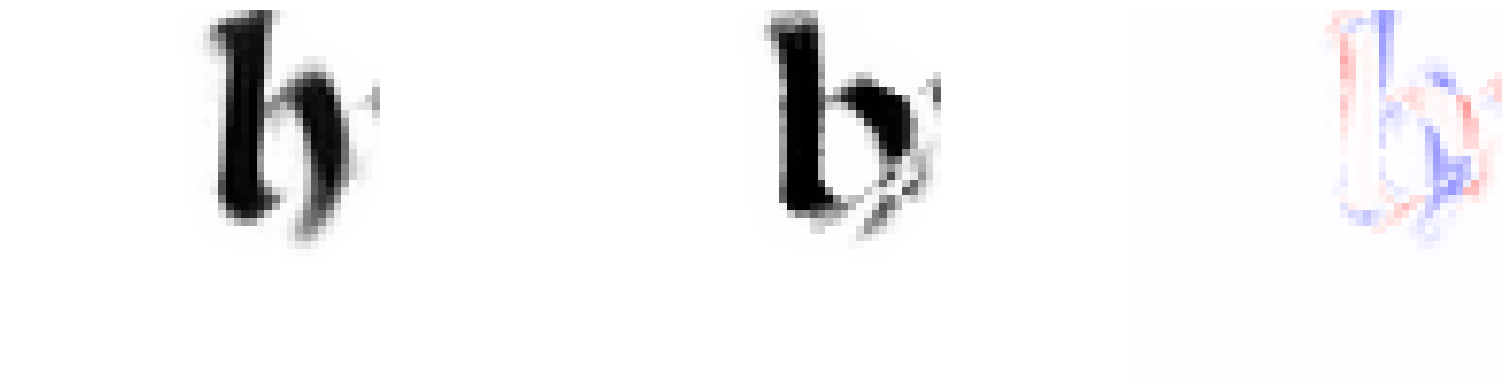

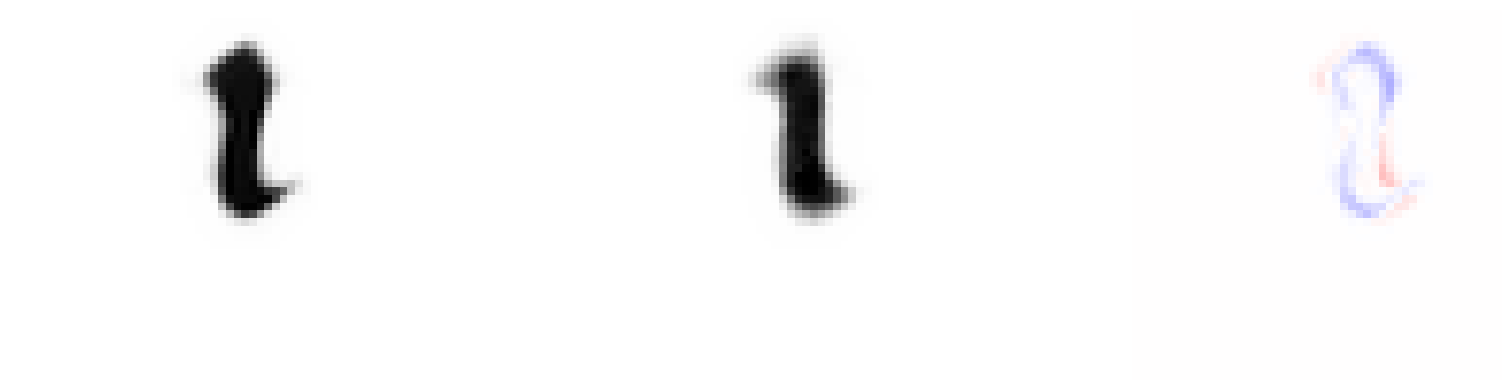

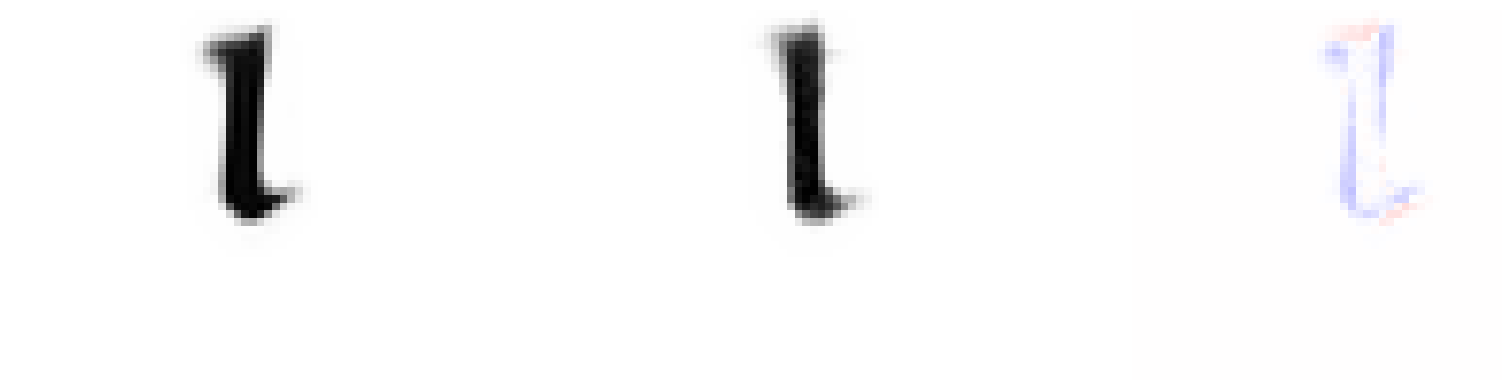

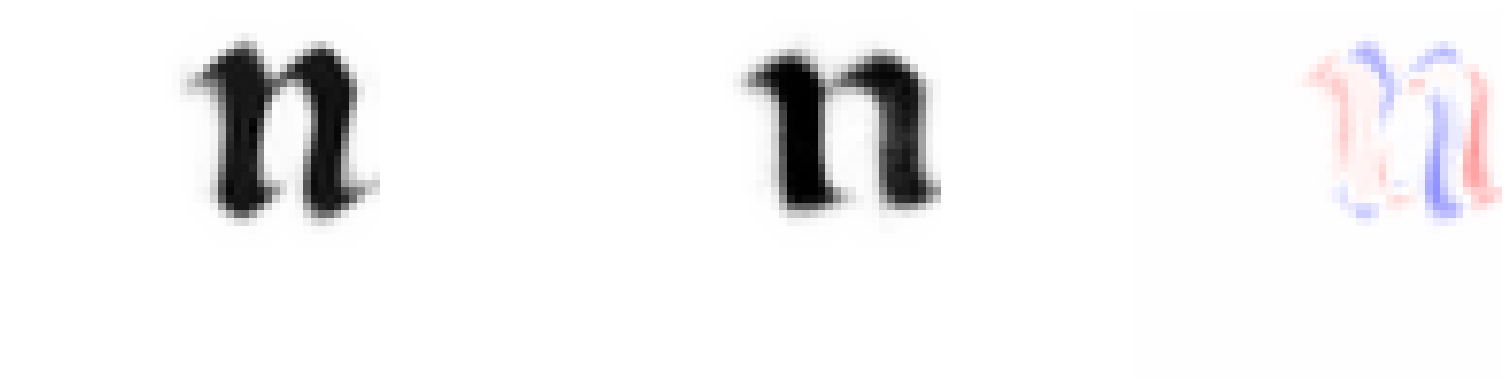

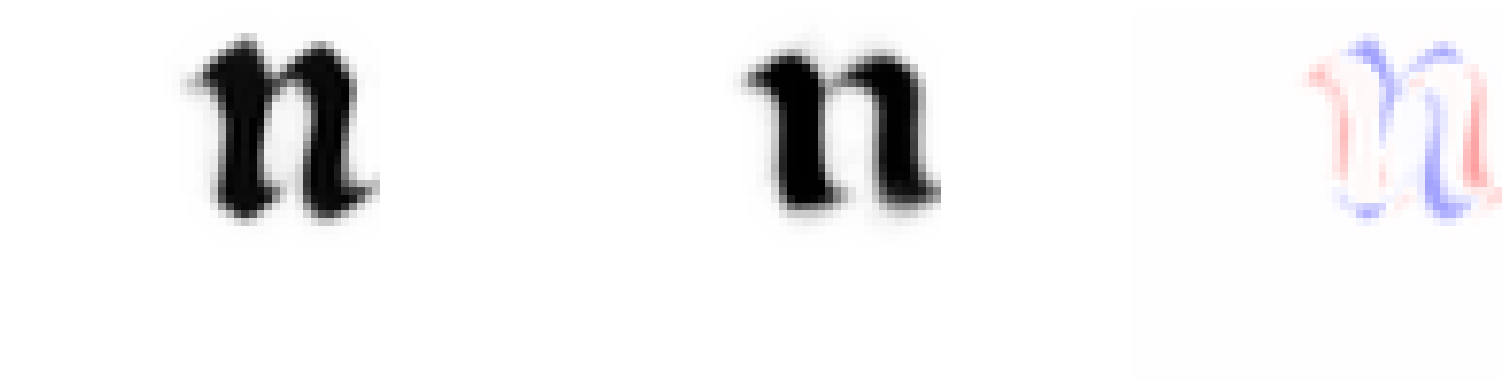

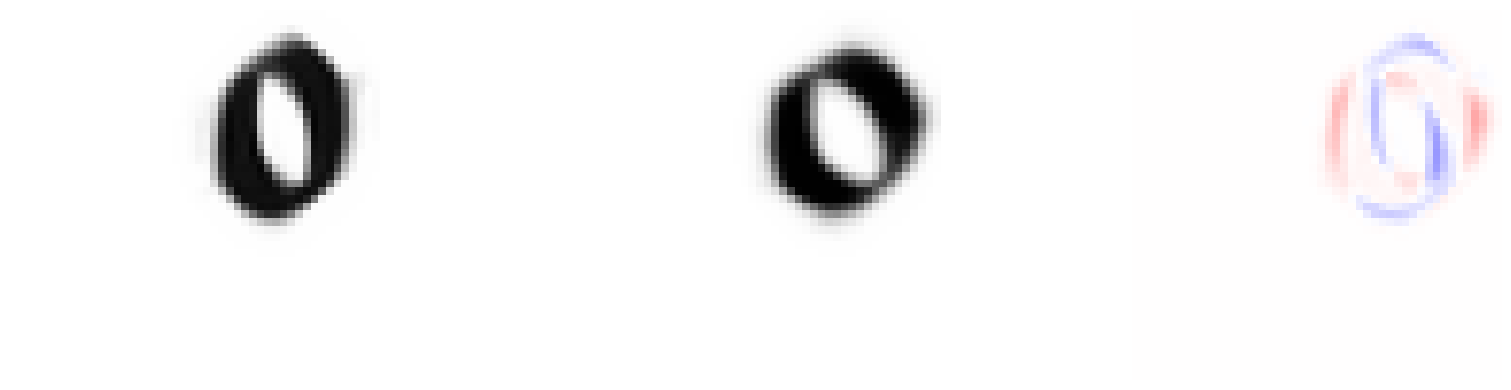

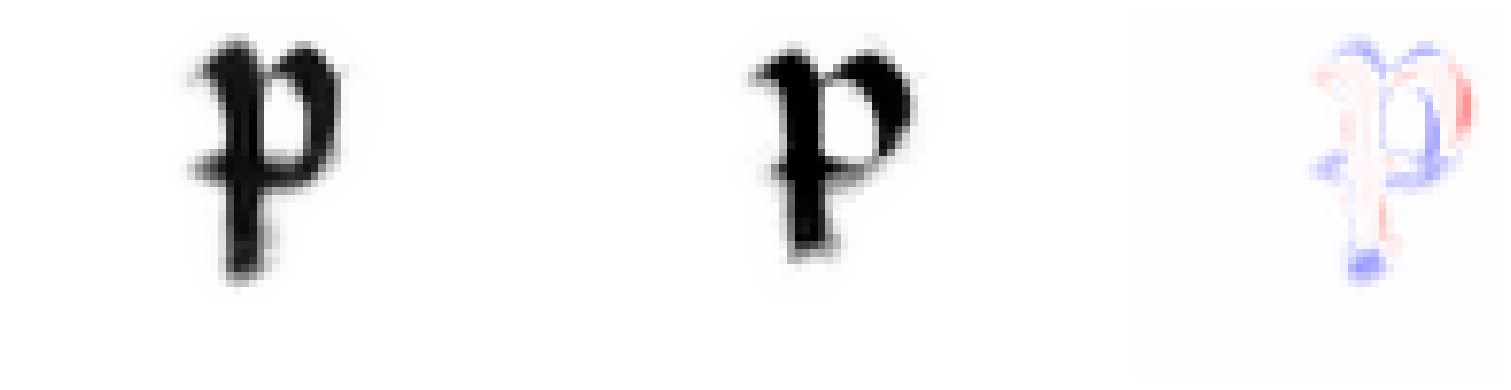

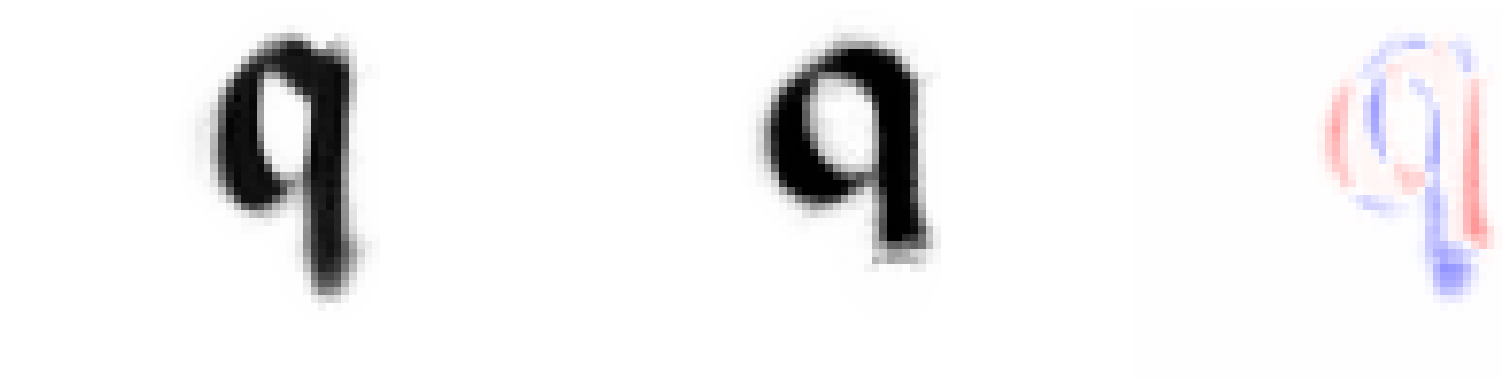

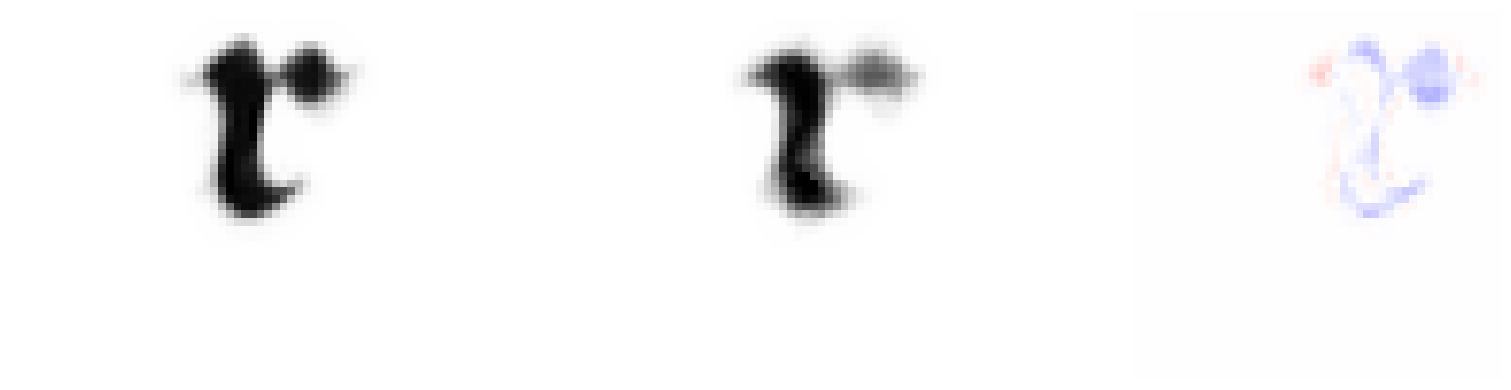

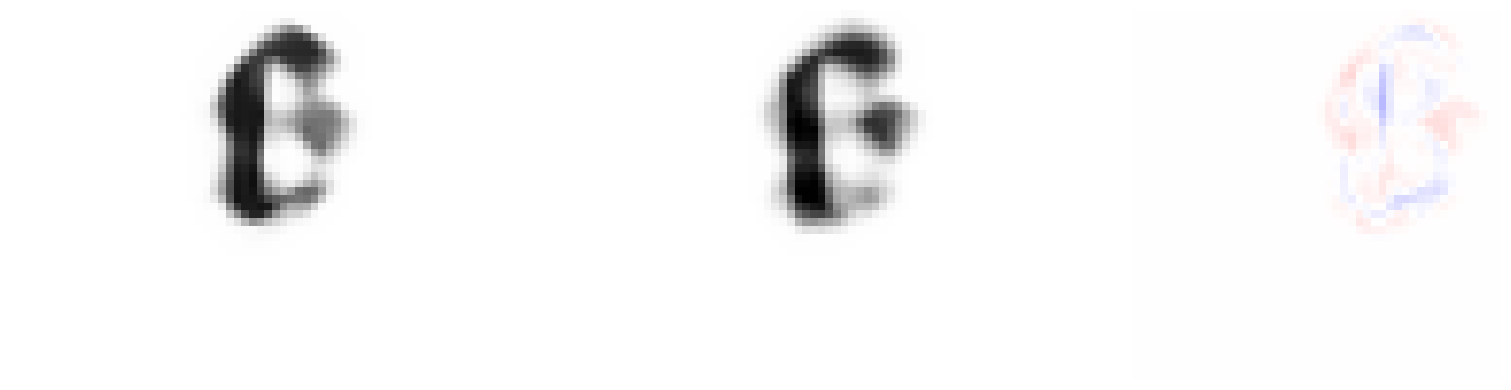

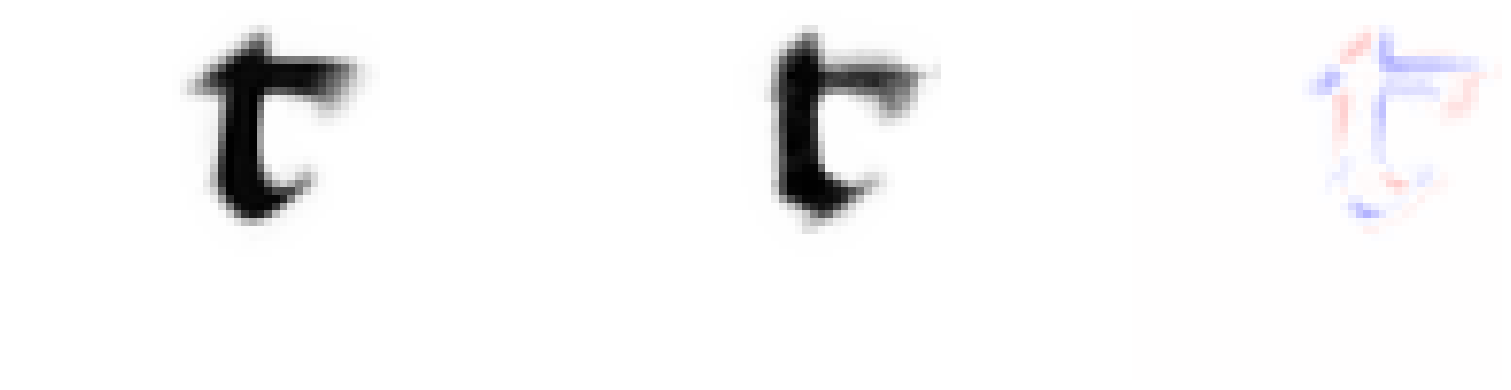

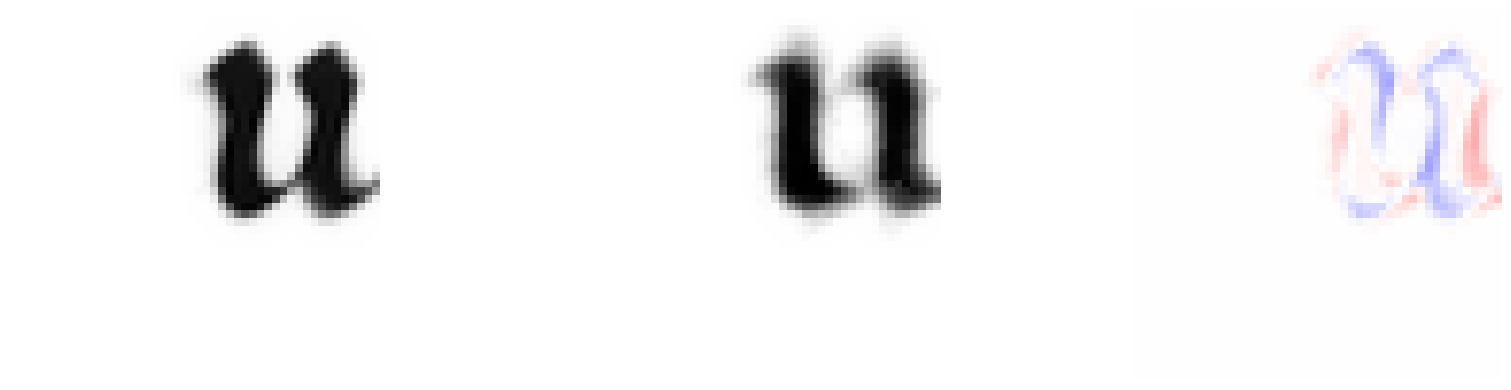

In [16]:
directory_path = filtered_dir
output_comp = output_comp

for folder in folder_order:
    doc_path = os.path.join(directory_path, folder)
    print("Processing folder:", doc_path)

    output_folder = os.path.join(output_comp, 'baseline_comp_all', folder)
    visualize_comparison(os.path.join(directory_path, 'baseline'), doc_path, character_range, output_folder)

### 2.2 Visualise the visual comparison

Make sure you have the correct input and output names/folders.

Created directory: /content/learnable-handwriter/scripts/reproduce_results/grids
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/comp_prototypes/NT_comp_all/baseline
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/comp_prototypes/NT_comp_all/Northern_Textualis
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/comp_prototypes/NT_comp_all/btv1b8447298r
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/comp_prototypes/NT_comp_all/btv1b525068331
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/comp_prototypes/NT_comp_all/Arras-861
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/comp_prototypes/NT_comp_all/btv1b84473026
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/comp_prototypes/NT_comp_all/btv1b8455783p
Processing folder: /content/learnable-handwriter/scripts/reproduce_results/comp_prototypes/NT_comp_all/

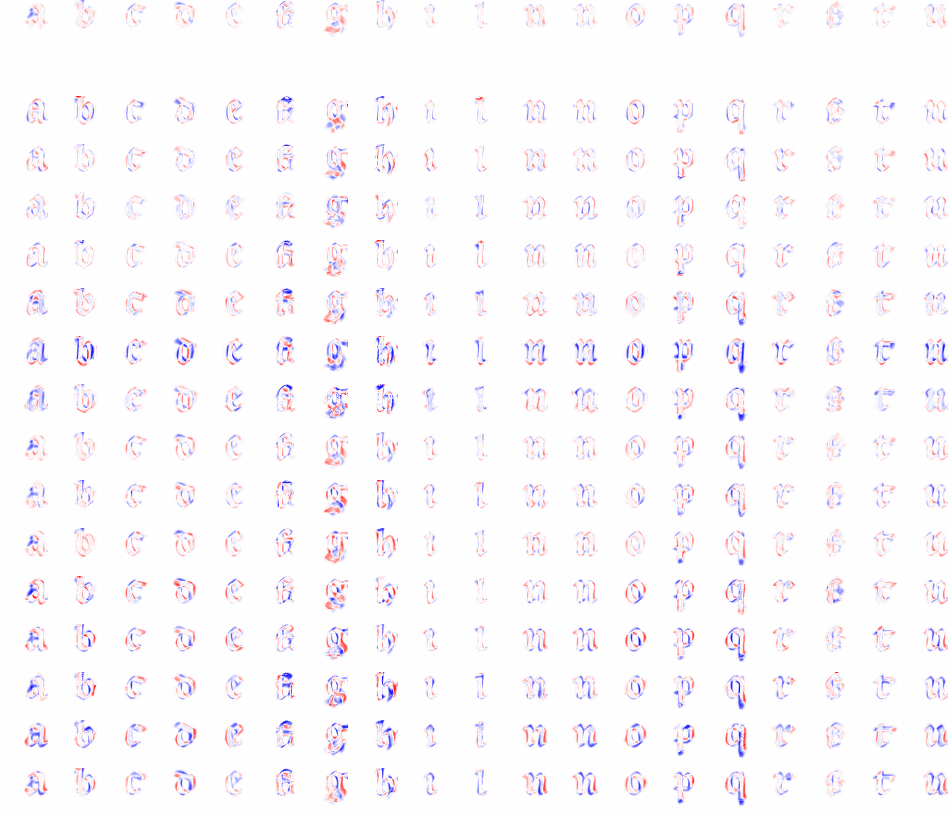

Image grid saved at: /content/learnable-handwriter/scripts/reproduce_results/grids/NT_comp_all.jpeg


In [17]:
output_path = os.path.join(grids_output_dir, "baseline_comp_all.jpeg")
input_path = output_comp / "baseline_comp_all"

os.makedirs(grids_output_dir, exist_ok=True)
print(f"Created directory: {grids_output_dir}")

sample_image_path = os.path.join(input_path, folder_order[0], f"{character_range[0]}.png")
sample_image = PIL.Image.open(sample_image_path)

image_width, image_height = sample_image.size

input_path = folder_to_grid(input_path, folder_order, character_range, image_width, image_height, margin=margin)

input_path.save(output_path)
print("Image grid saved at:", output_path)

### Calculate the variance of the two subtypes, Northern and Southern Textualis (cf. Section 4.1 in the paper)

In [ ]:
nt_df = calculate_metric_for_directory(filtered_dir, "NT", codename_to_id)
st_df = calculate_metric_for_directory(filtered_dir, "ST", codename_to_id)

if nt_df is not None and st_df is not None:
    merged_df = merge_dataframes(st_df, nt_df)
    print(merged_df)
else:
    print("One or both DataFrames are empty.")

           Image    Std_ST    Std_NT
0   Image 28.png  3.409315  3.952366
1   Image 29.png  3.563122  4.106200
2   Image 30.png  2.441201  2.905906
3   Image 31.png  3.106441  3.788863
4   Image 32.png  2.313107  3.347374
5   Image 33.png  4.269359  4.326612
6   Image 34.png  5.443670  5.762127
7   Image 35.png  4.247564  4.869019
8   Image 36.png  1.620305  2.432967
9   Image 39.png  1.832525  2.481817
10  Image 40.png  3.105308  3.619836
11  Image 41.png  2.923636  3.660845
12  Image 42.png  2.687734  3.489355
13  Image 43.png  3.229233  4.152183
14  Image 44.png  3.933021  4.809044
15  Image 45.png  2.354015  2.785253
16  Image 46.png  2.369182  2.680951
17  Image 47.png  2.430756  3.043400
18  Image 48.png  3.003820  3.674446


## 3.0 Quantitative analysis
### Document and Letter Graphs (cf. Section 3.1 in the paper)

### 3.1 Document graphs:
Note: if you want to apply the same code to your data, you'll need an external .csv file with the calculated occurrences per document per letter like the one provided for our experiments

In [ ]:
# Set plotting styles
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['image.cmap'] = 'summer'
matplotlib.rcParams['font.size'] = 17
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['figure.titlesize'] = 'medium'
matplotlib.rcParams['lines.linewidth'] = 2.0
plt.rcParams['text.usetex'] = False

# Define paths
os.makedirs(grids_output_dir, exist_ok=True)
print(f"Created directory: {grids_output_dir}")

# Load prototype folders
folder_1 = [
    filtered_dir / 'Northern_Textualis/',
    filtered_dir / 'Southern_Textualis/'
]

# Documents to compare (you can comment/uncomment as needed)
folder_2 = [
    # Northern Textualis (NT)
    #filtered_dir / 'btv1b8447298r/',
    #filtered_dir / 'btv1b525068331/',
    filtered_dir / 'Arras-861/',
    #filtered_dir / 'btv1b84473026/',
    filtered_dir / 'btv1b8455783p/',
    filtered_dir / 'btv1b55006072j/',
    #filtered_dir / 'SBB-PK-Hdschr25/',

    # Southern Textualis (ST)
    #filtered_dir / 'btv1b90615126/',
    filtered_dir / 'btv1b100361755/',
    #filtered_dir / 'btv1b8433319z/',
    #filtered_dir / 'IB15304245v/',
    #filtered_dir / 'btv1b90590259/',
    filtered_dir / 'btv1b8446940n/',
    filtered_dir / 'IB15304274v/',
]

# Load character mapping
json_path = os.path.join(root_path, 'runs', 'iwcp_south_north', 'transcribe.json')
with open(json_path) as json_file:
    character_mapping = json.load(json_file)

# Load character occurrences
csv_path = os.path.join(root_path, 'char_occurrences.csv')
character_range = list(range(28, 36)) + list(range(39, 48))

char_occurrences_df = pd.read_csv(csv_path, index_col=0, sep=";")
char_occurrences_df = char_occurrences_df.loc[character_range]
char_occurrences_df = char_occurrences_df.apply(pd.to_numeric, errors='coerce')

# Run plot function
plot_document_graphs(
    folder_1_paths=folder_1,
    folder_2_paths=folder_2,
    output_folder=grids_output_dir,
    char_occurrences_df=char_occurrences_df,
    character_mapping=character_mapping,
    character_range=character_range,
    codename_to_id=codename_to_id
)

Created directory: /home/vlachoum/handwriter/scripts/reproduce_results/grids


### 3.2 Letter graphs

In [ ]:
folder_1 = [
    filtered_dir / 'Northern_Textualis',
    filtered_dir / 'Southern_Textualis'
]

folder_2 = [
    filtered_dir / 'btv1b8447298r',
    filtered_dir / 'btv1b525068331',
    filtered_dir / 'Arras-861',
    filtered_dir / 'btv1b84473026',
    filtered_dir / 'btv1b8455783p',
    filtered_dir / 'btv1b55006072j',
    filtered_dir / 'SBB-PK-Hdschr25',
    filtered_dir / 'btv1b90615126',
    filtered_dir / 'btv1b100361755',
    filtered_dir / 'btv1b8433319z',
    filtered_dir / 'IB15304245v',
    filtered_dir / 'btv1b90590259',
    filtered_dir / 'btv1b8446940n',
    filtered_dir / 'IB15304274v'
]

script_path = root_path /'datasets'/'iwcp_south_north'/'annotation.json'
manuscript_info_df = pd.read_json(script_path).T
manuscript_info_df['ID'] = manuscript_info_df.index.str.split('_').str[0]
manuscript_info_df = manuscript_info_df.drop_duplicates(subset=['ID'])

with open(root_path/'runs'/'iwcp_south_north'/'transcribe.json') as f:
    character_mapping = json.load(f)

character_range = [28, 35, 36, 42, 43, 45]
#uncomment the following line for all of the letters
#character_range = list(range(28, 37)) + list(range(39, 49))

split_to_id = {
    'train': ['btv1b8447298r', 'btv1b525068331', 'Arras-861', 'btv1b84473026', 'btv1b90615126', 'btv1b100361755', 'btv1b8433319z', 'IB15304245v'],
    'test': ['btv1b8455783p', 'btv1b55006072j', 'SBB-PK-Hdschr25', 'btv1b90590259', 'btv1b8446940n', 'IB15304274v']
}

plot_letter_graphs(
    folder_1_paths=folder_1,
    folder_2_paths=folder_2,
    output_folder=grids_output_dir,
    manuscript_info_df=manuscript_info_df,
    character_mapping=character_mapping,
    character_range=character_range,
    split_to_id=split_to_id,
    codename_to_id=codename_to_id
)

/home/vlachoum/handwriter/scripts/reproduce_results/utils.py:509: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
